In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.set_printoptions(suppress=True)

In [2]:
from scene import CircularCage, RectangularCage, SquareCage
from cell_group import PlaceCells, HeadDirectionCells

from dataloader import H5File
from trajectory_simulator import TrajectorySimulator

from model import VecNavModel, CrossEntropyLoss
from train import train_model
from util import print_mem, in_ipynb
import scipy
from scipy import stats
import torch


/usr/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
def mean_traj_dist(traj):
    xs, xs0 = traj[0].numpy(), traj[3].numpy()
    diff = np.mean(np.linalg.norm(xs[:, 0] - xs0, axis=1))
    mean_diff = np.array([np.linalg.norm(x - y, axis=1) for x, y in zip(xs[:, 1:], xs[:, :-1])]).mean()
    return diff, mean_diff

def mean_vel_over_time(traj, i=0):
    vs = traj[2].numpy().transpose(2, 1, 0)
    print("Mean ego_vels: ", (vs ** 2).mean(axis=(1, 2)))
    v = vs.mean(axis=2)
    plt.plot(np.arange(len(v[0, i:])), v[0, i:])
    plt.show()
    return v

def examine_batch(traj, crop=0):
    n = crop
    xs, ys = traj[0].reshape(-1, 2).transpose(1, 0).numpy()
    res = stats.binned_statistic_2d(xs, ys, np.ones_like(xs), bins=40, statistic="sum")[0]
    if n == 0:
        plt.imshow(res, cmap='jet')
    else:
        plt.imshow(res[n:-n, n:-n], cmap="jet")
    plt.axis("off")
    plt.show()
    return res

def plot_traj(traj, div=3):
    xs, hs, vels, xs0, hs0 = traj
    xs = xs.transpose(1, 0)
    hs = hs.transpose(1, 0)
    directions = torch.stack([xs, xs])[:, :, :]
    directions[1] += torch.cat([hs.cos(), hs.sin()]) * vels[:, 0] / div
    directions = directions.transpose(0, 1)
    plt.plot(*directions.numpy())
    plt.plot(*xs.numpy())
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

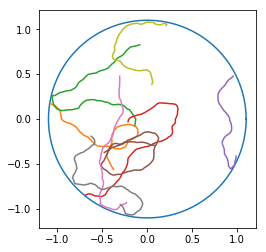

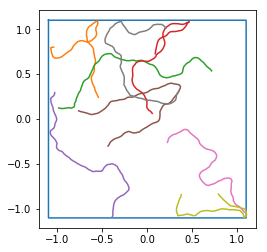

In [4]:
TrajectorySimulator(CircularCage(2.2)).plot_trajectories(N=8)

scene = SquareCage(2.2)
TS = TrajectorySimulator(scene, perimiter=0.03)
TS.plot_trajectories(N=8)

In [5]:
if False:
    traj_file = H5File('trajectories/new_traj.hdf5')
    TS.load_params(traj_file.attrs)
    TS.save(new_traj_f, N=10000)

In [6]:
# filename = 'new_traj' # 'new_traj', 'deepmind_traj', 'trajectories_3'
dataset = H5File(f'trajectories/new_traj.hdf5').to_dataset()
dm_dataset = H5File(f'trajectories/deepmind_traj.hdf5').to_dataset()

In [16]:
dataloader = DataLoader(dataset, batch_size=10, num_workers=16)
dm_dataloader = DataLoader(dm_dataset, batch_size=10, num_workers=16)

Mean trajectory distance and velocity between steps:
(1.1499907, 0.019888056)

Trajectory with head direction and velocity:


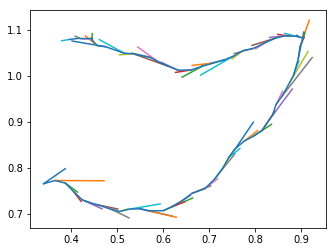

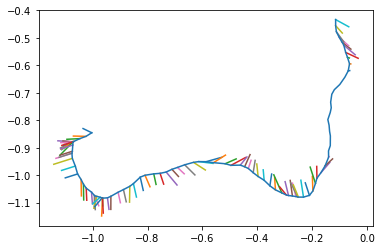


Density of 1000 paths over enclosure:


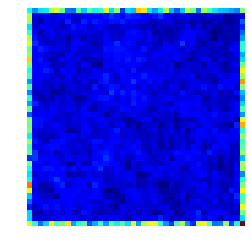


Density of 1000 paths over enclosure (Deepmind):


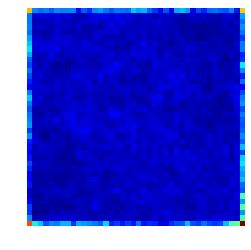

Mean ego_vels:  [0.02735298 0.9869875  0.01315353]


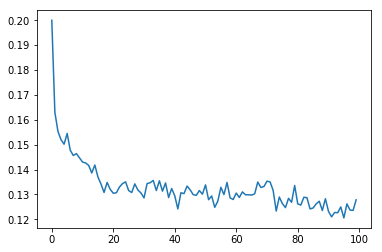

In [15]:
print(f'Mean trajectory distance and velocity between steps:\n{mean_traj_dist(dataset[:10000])}')

print('\nTrajectory with head direction and velocity:')
plot_traj(dataset[0], div=3.5)
plot_traj(dm_dataset[1], div=0.5)

print('\nDensity of 1000 paths over enclosure:')
_ = examine_batch(dataset[:1000], crop=0)

print('\nDensity of 1000 paths over enclosure (Deepmind):')
_ = examine_batch(dm_dataset[:1000], crop=0)

_ = mean_vel_over_time(dataset[:1000])

In [28]:
VNM = VecNavModel(12, 256, g_size=256, g_bias=False).cuda()
print(scene.height)

2.2


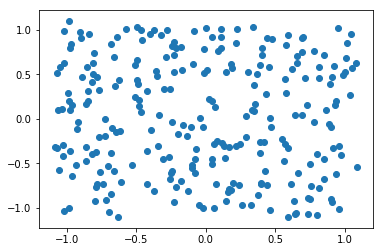

In [29]:
place_cells = PlaceCells(0.01, 256, scene)
hd_cells = HeadDirectionCells(20, 12)

epoch 0, mean loss 7.959867333412171, std loss 0.04804122808944859


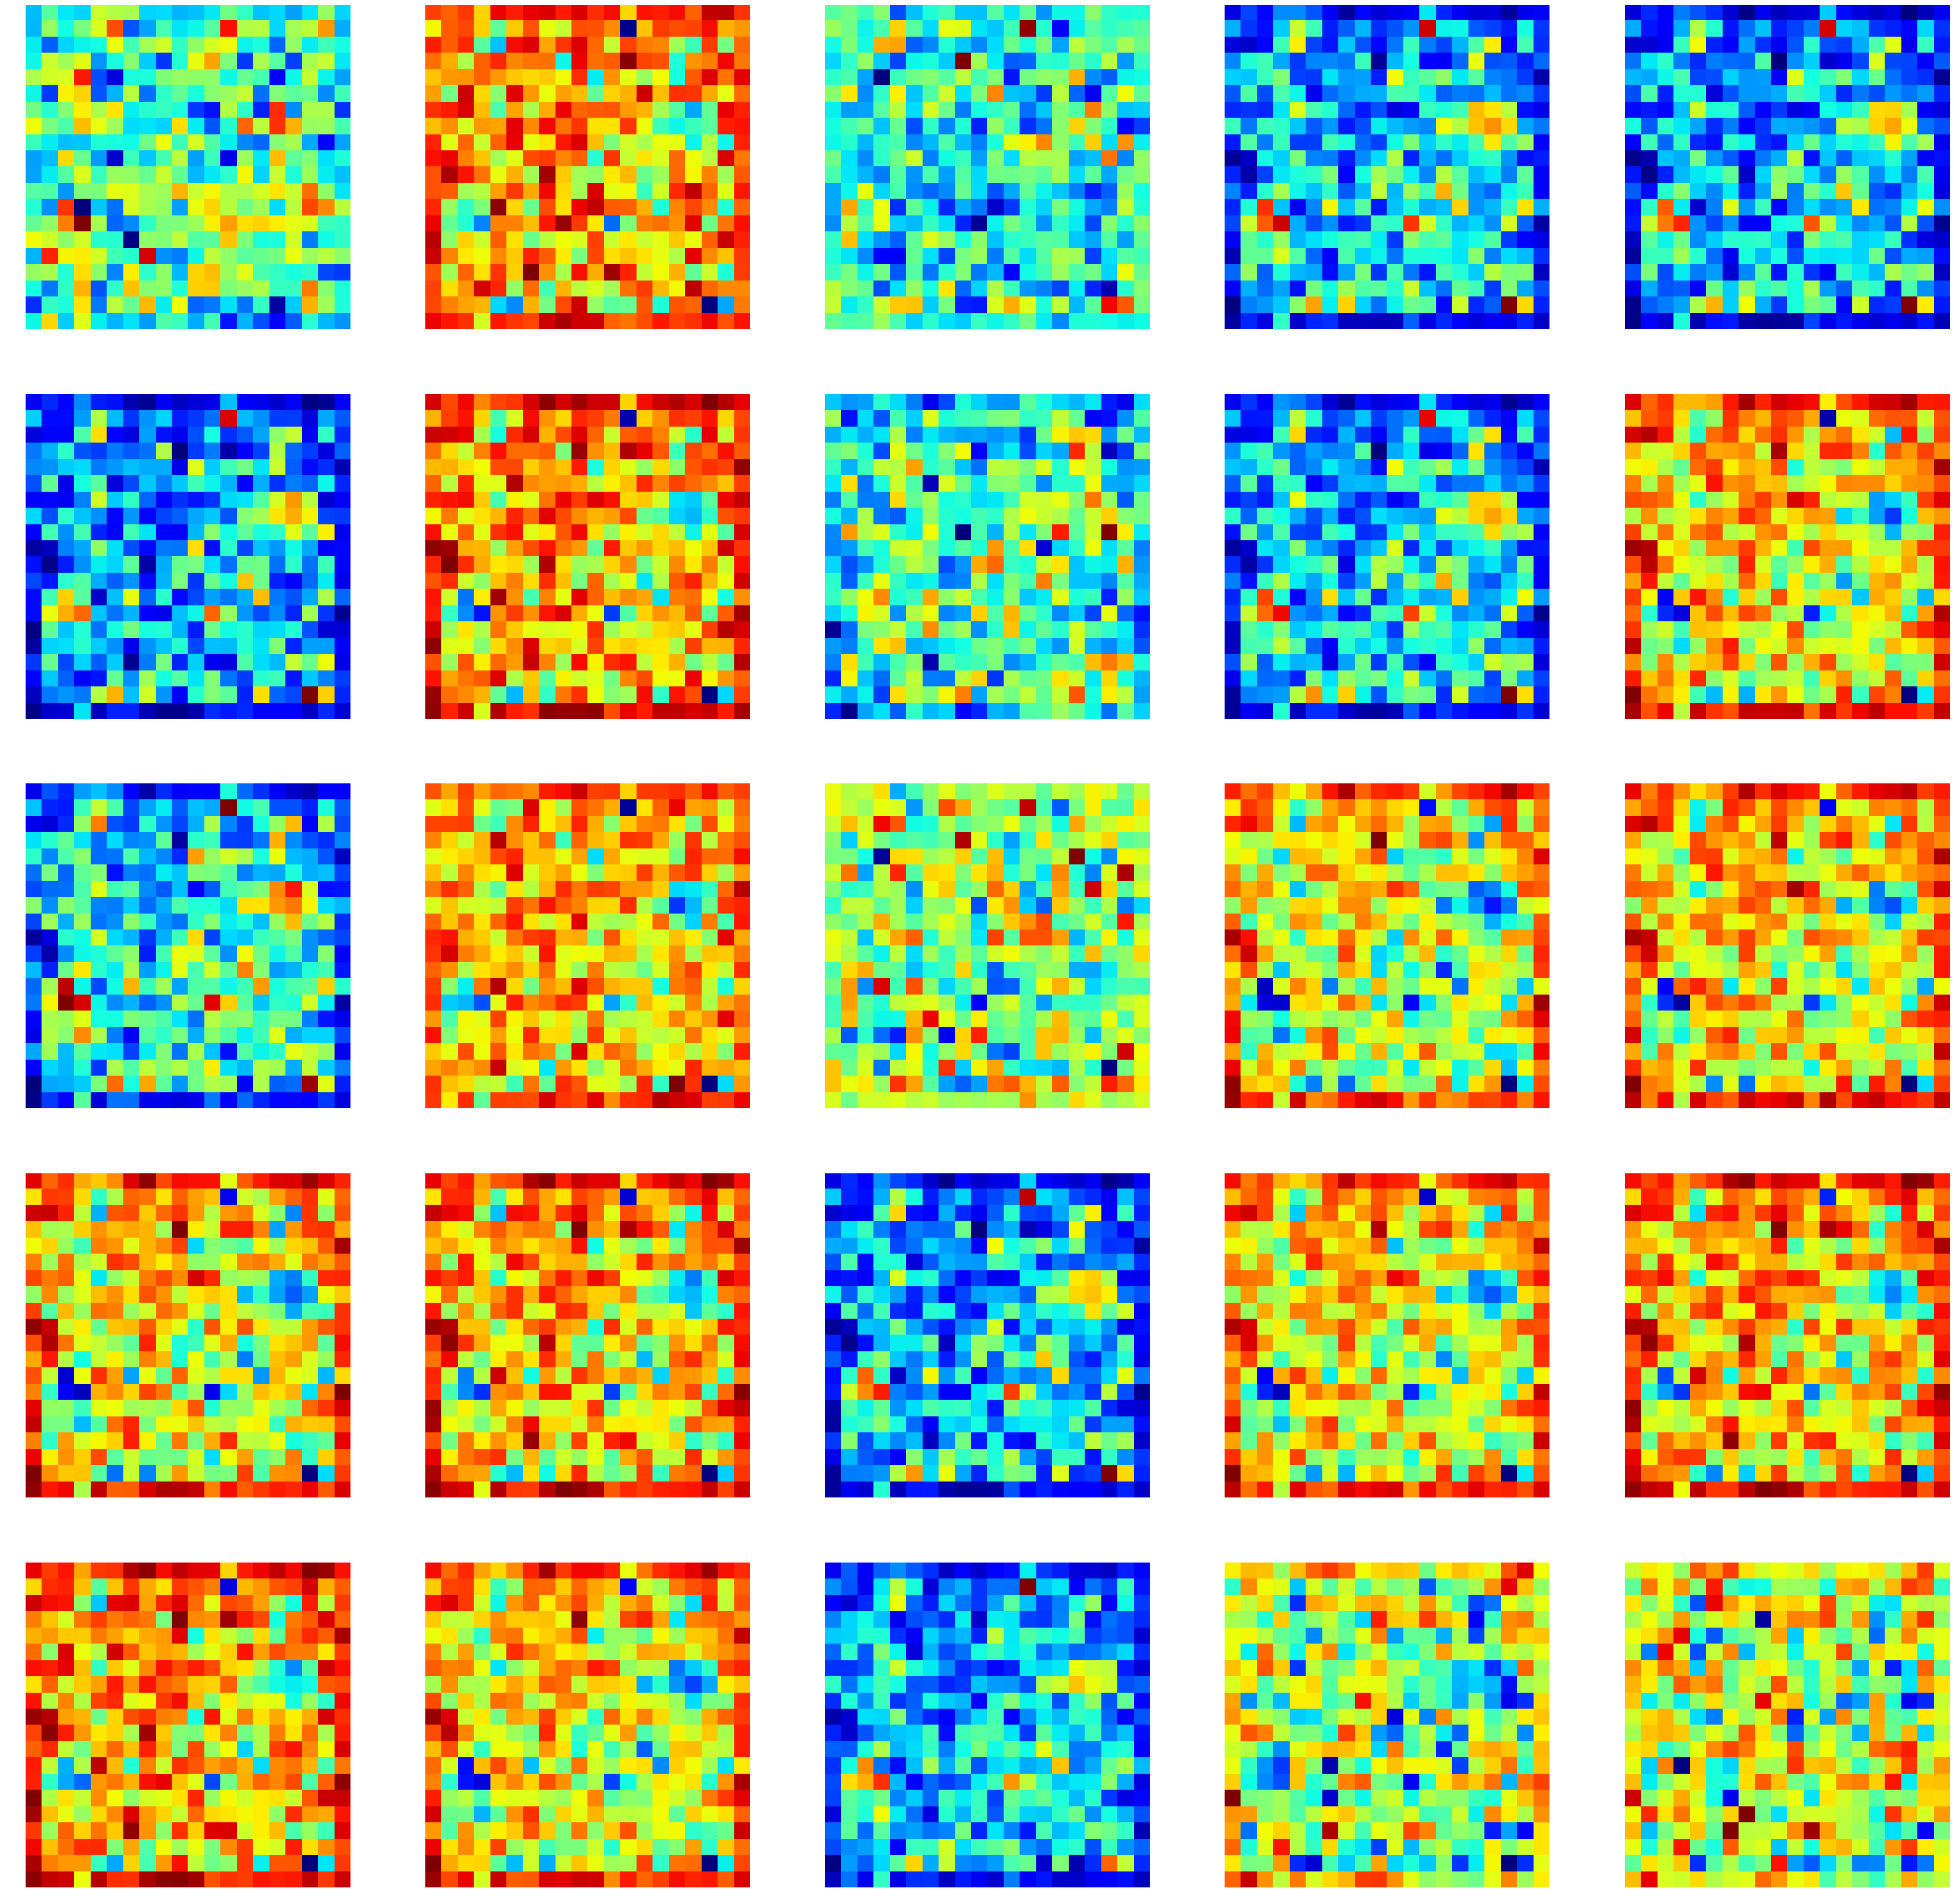

epoch 1, mean loss 7.941603116512298, std loss 0.05035021937016999


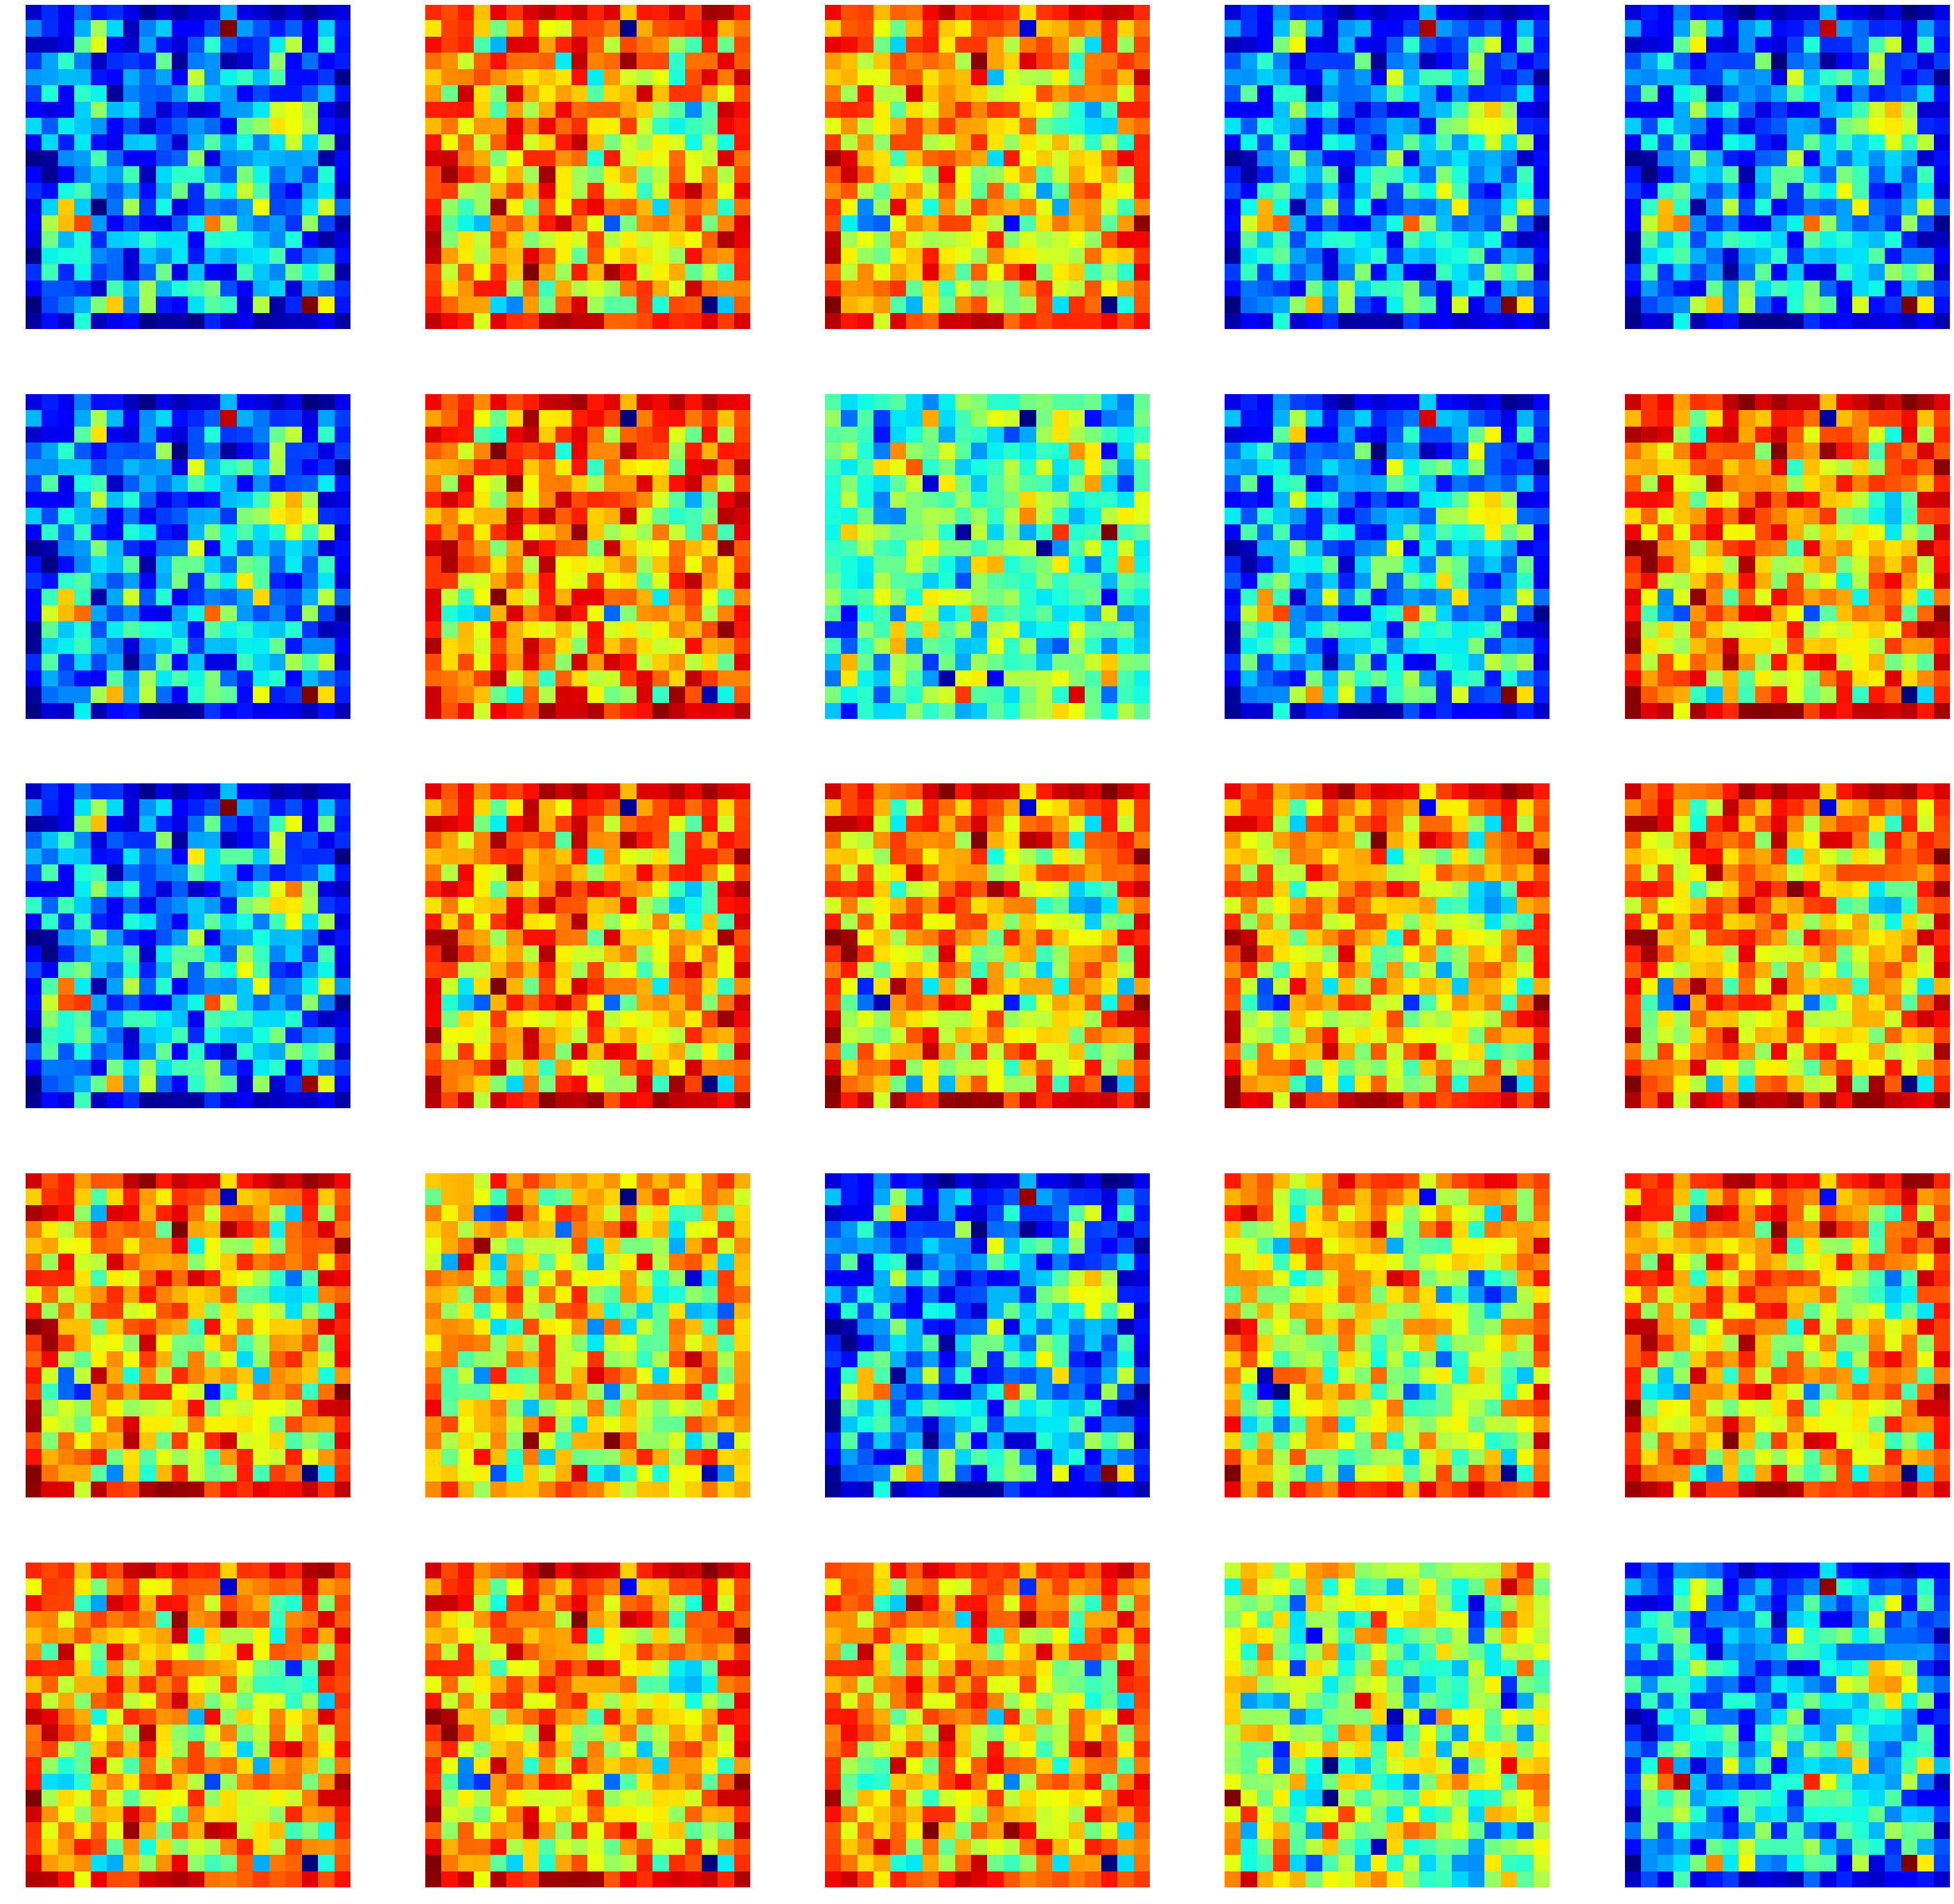

epoch 2, mean loss 7.937923037052155, std loss 0.0513141667257861


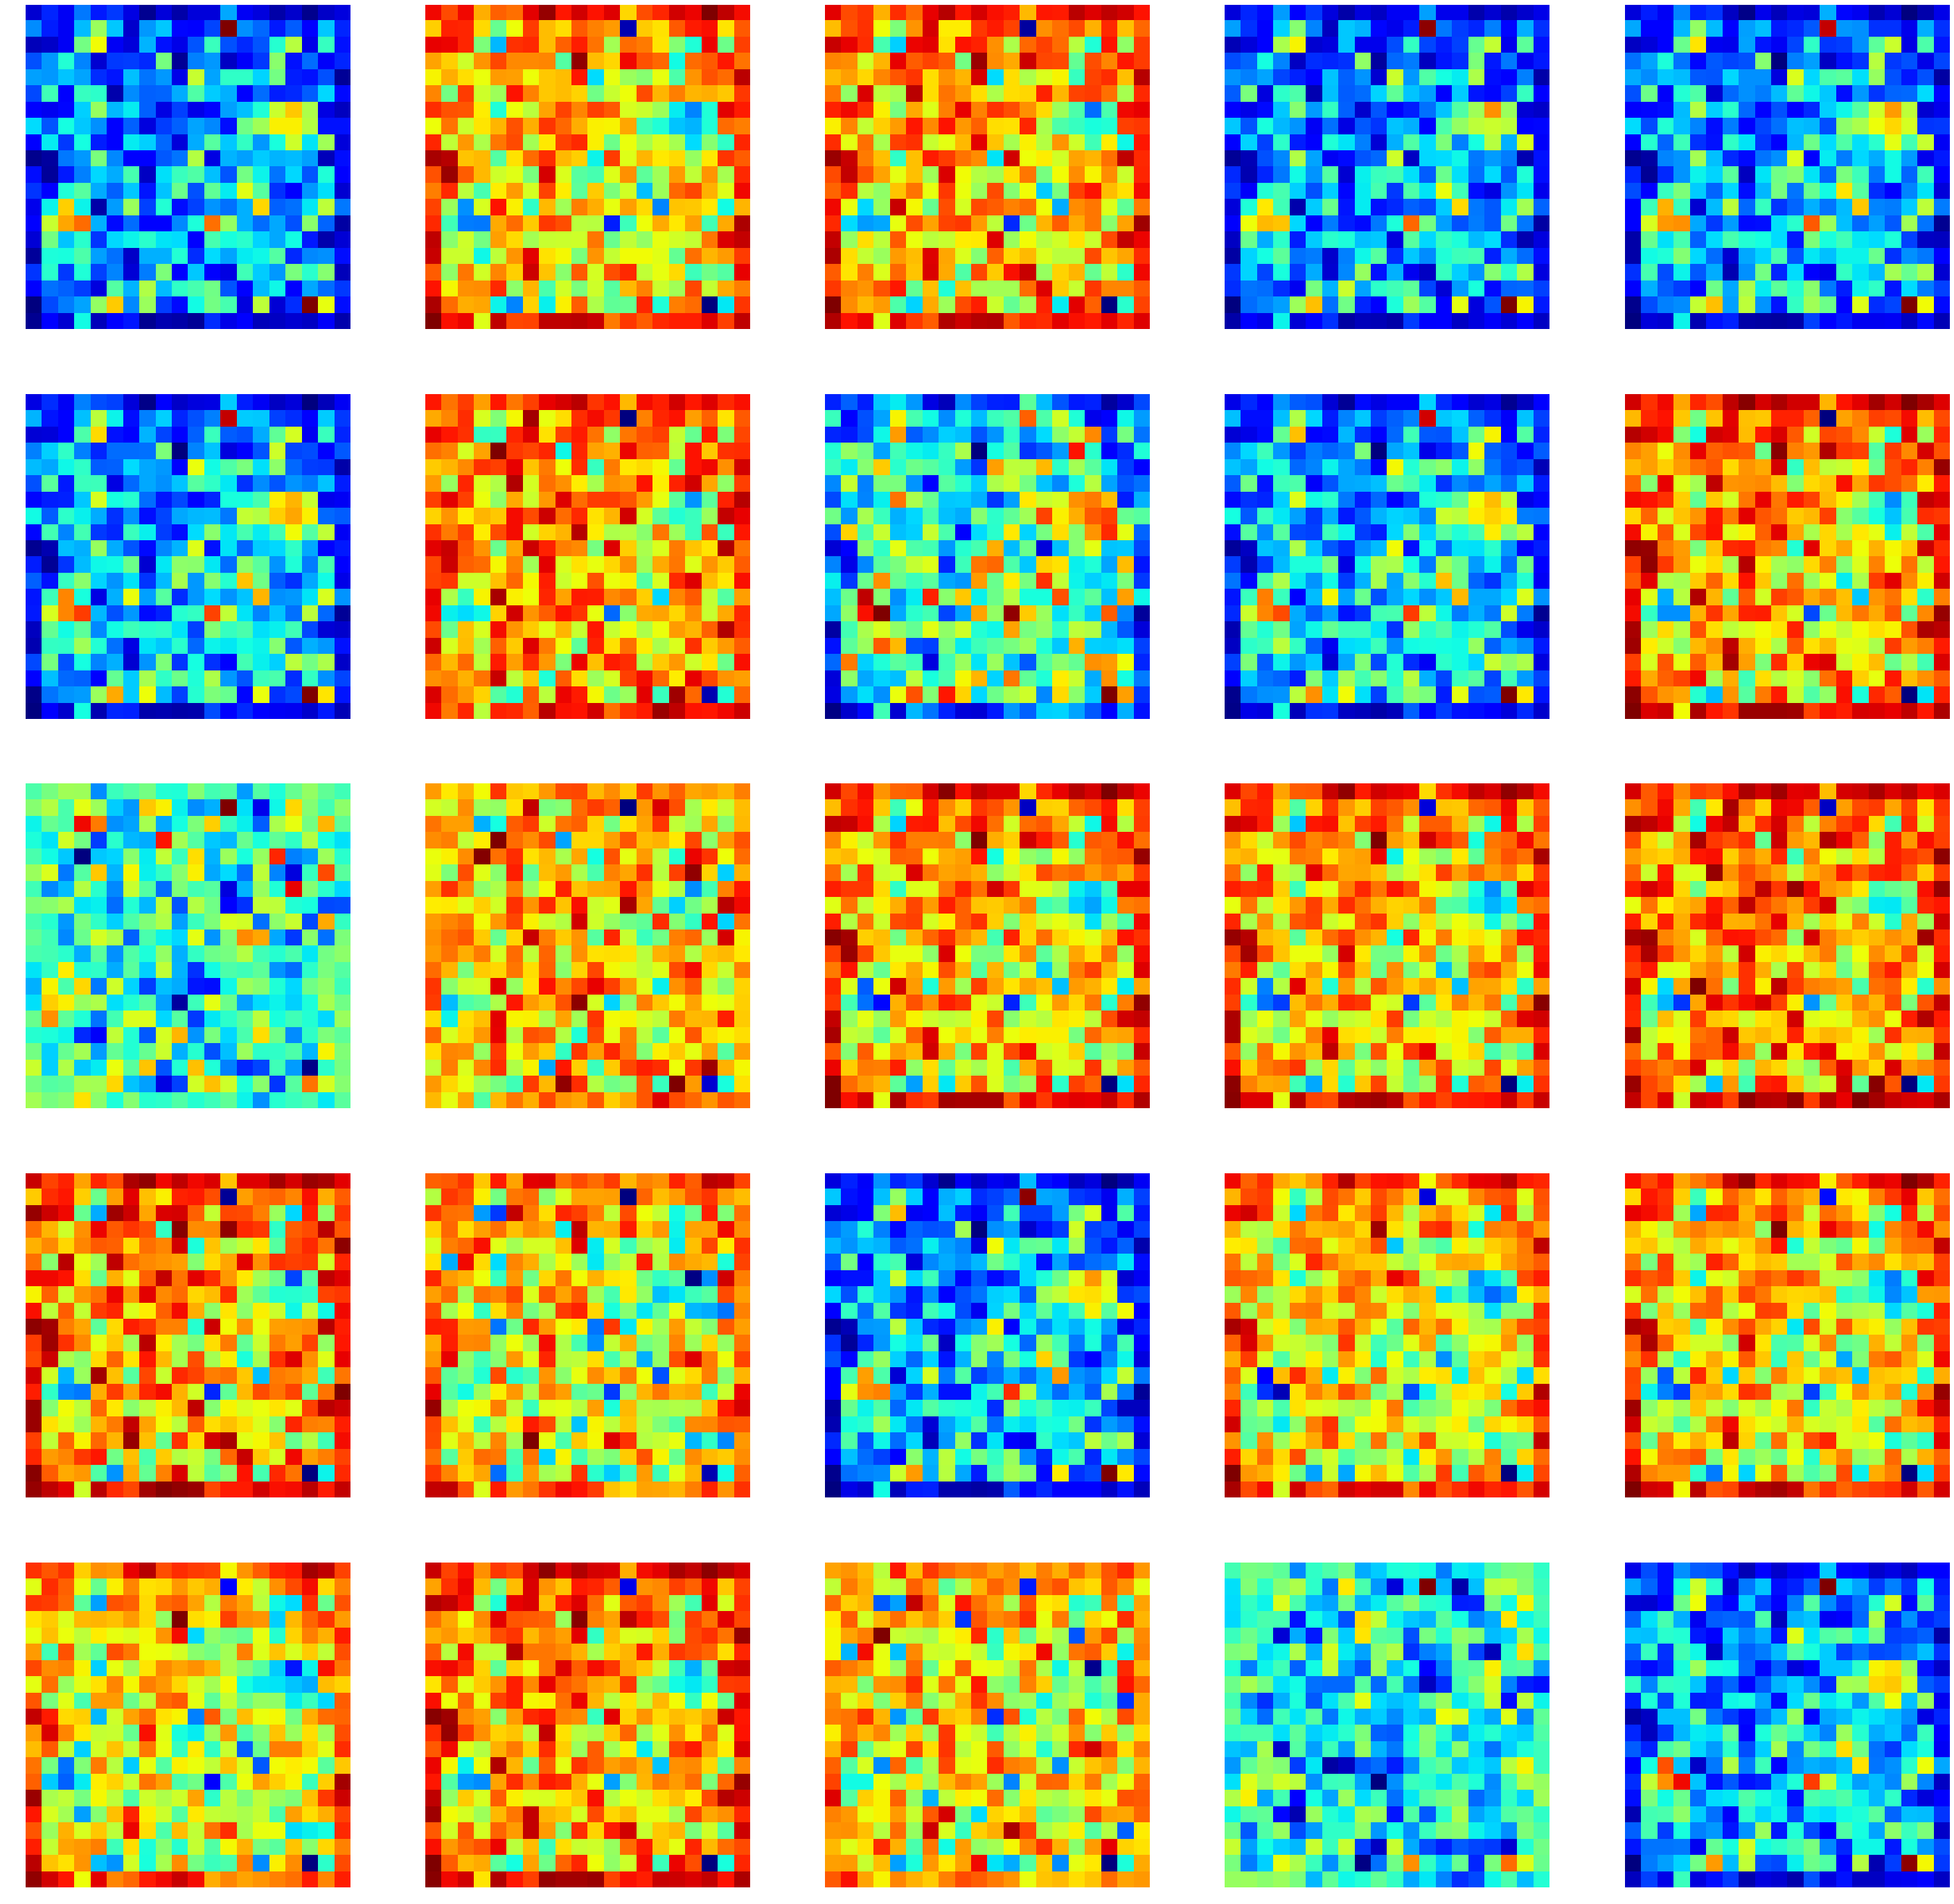

epoch 3, mean loss 7.9358081221580505, std loss 0.05125798640466815


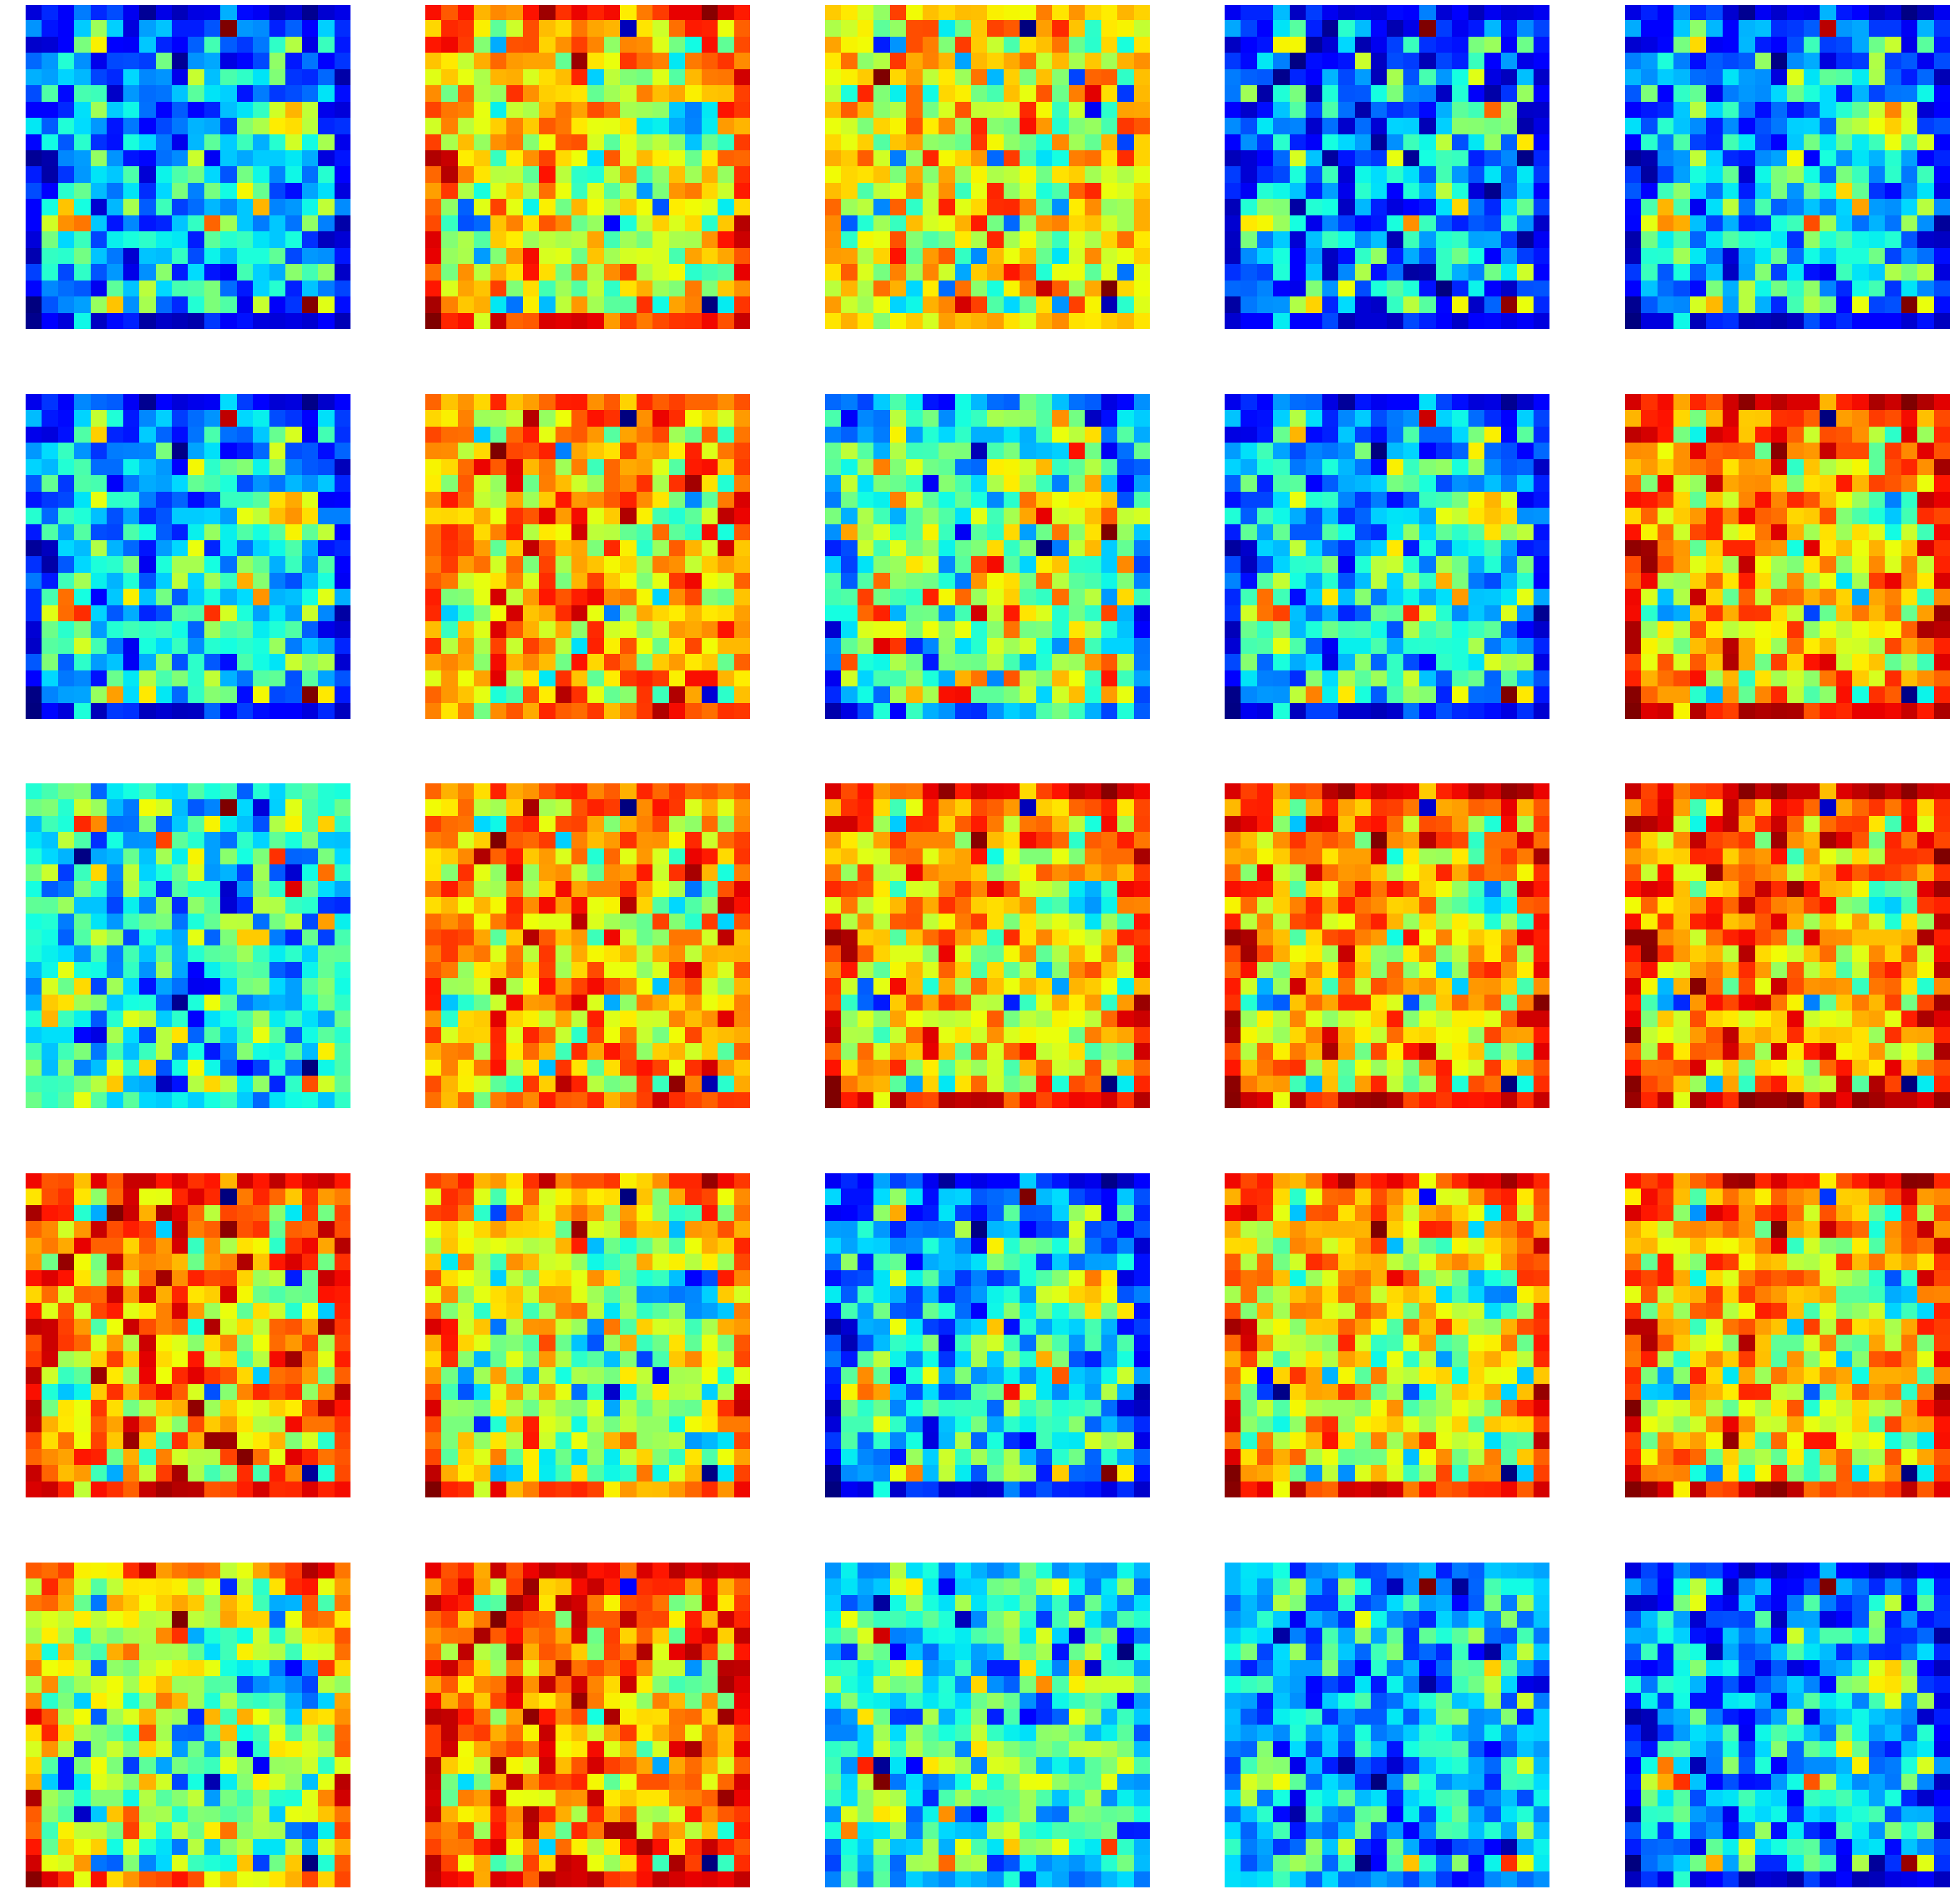

epoch 4, mean loss 7.935133747577667, std loss 0.05172250055634888


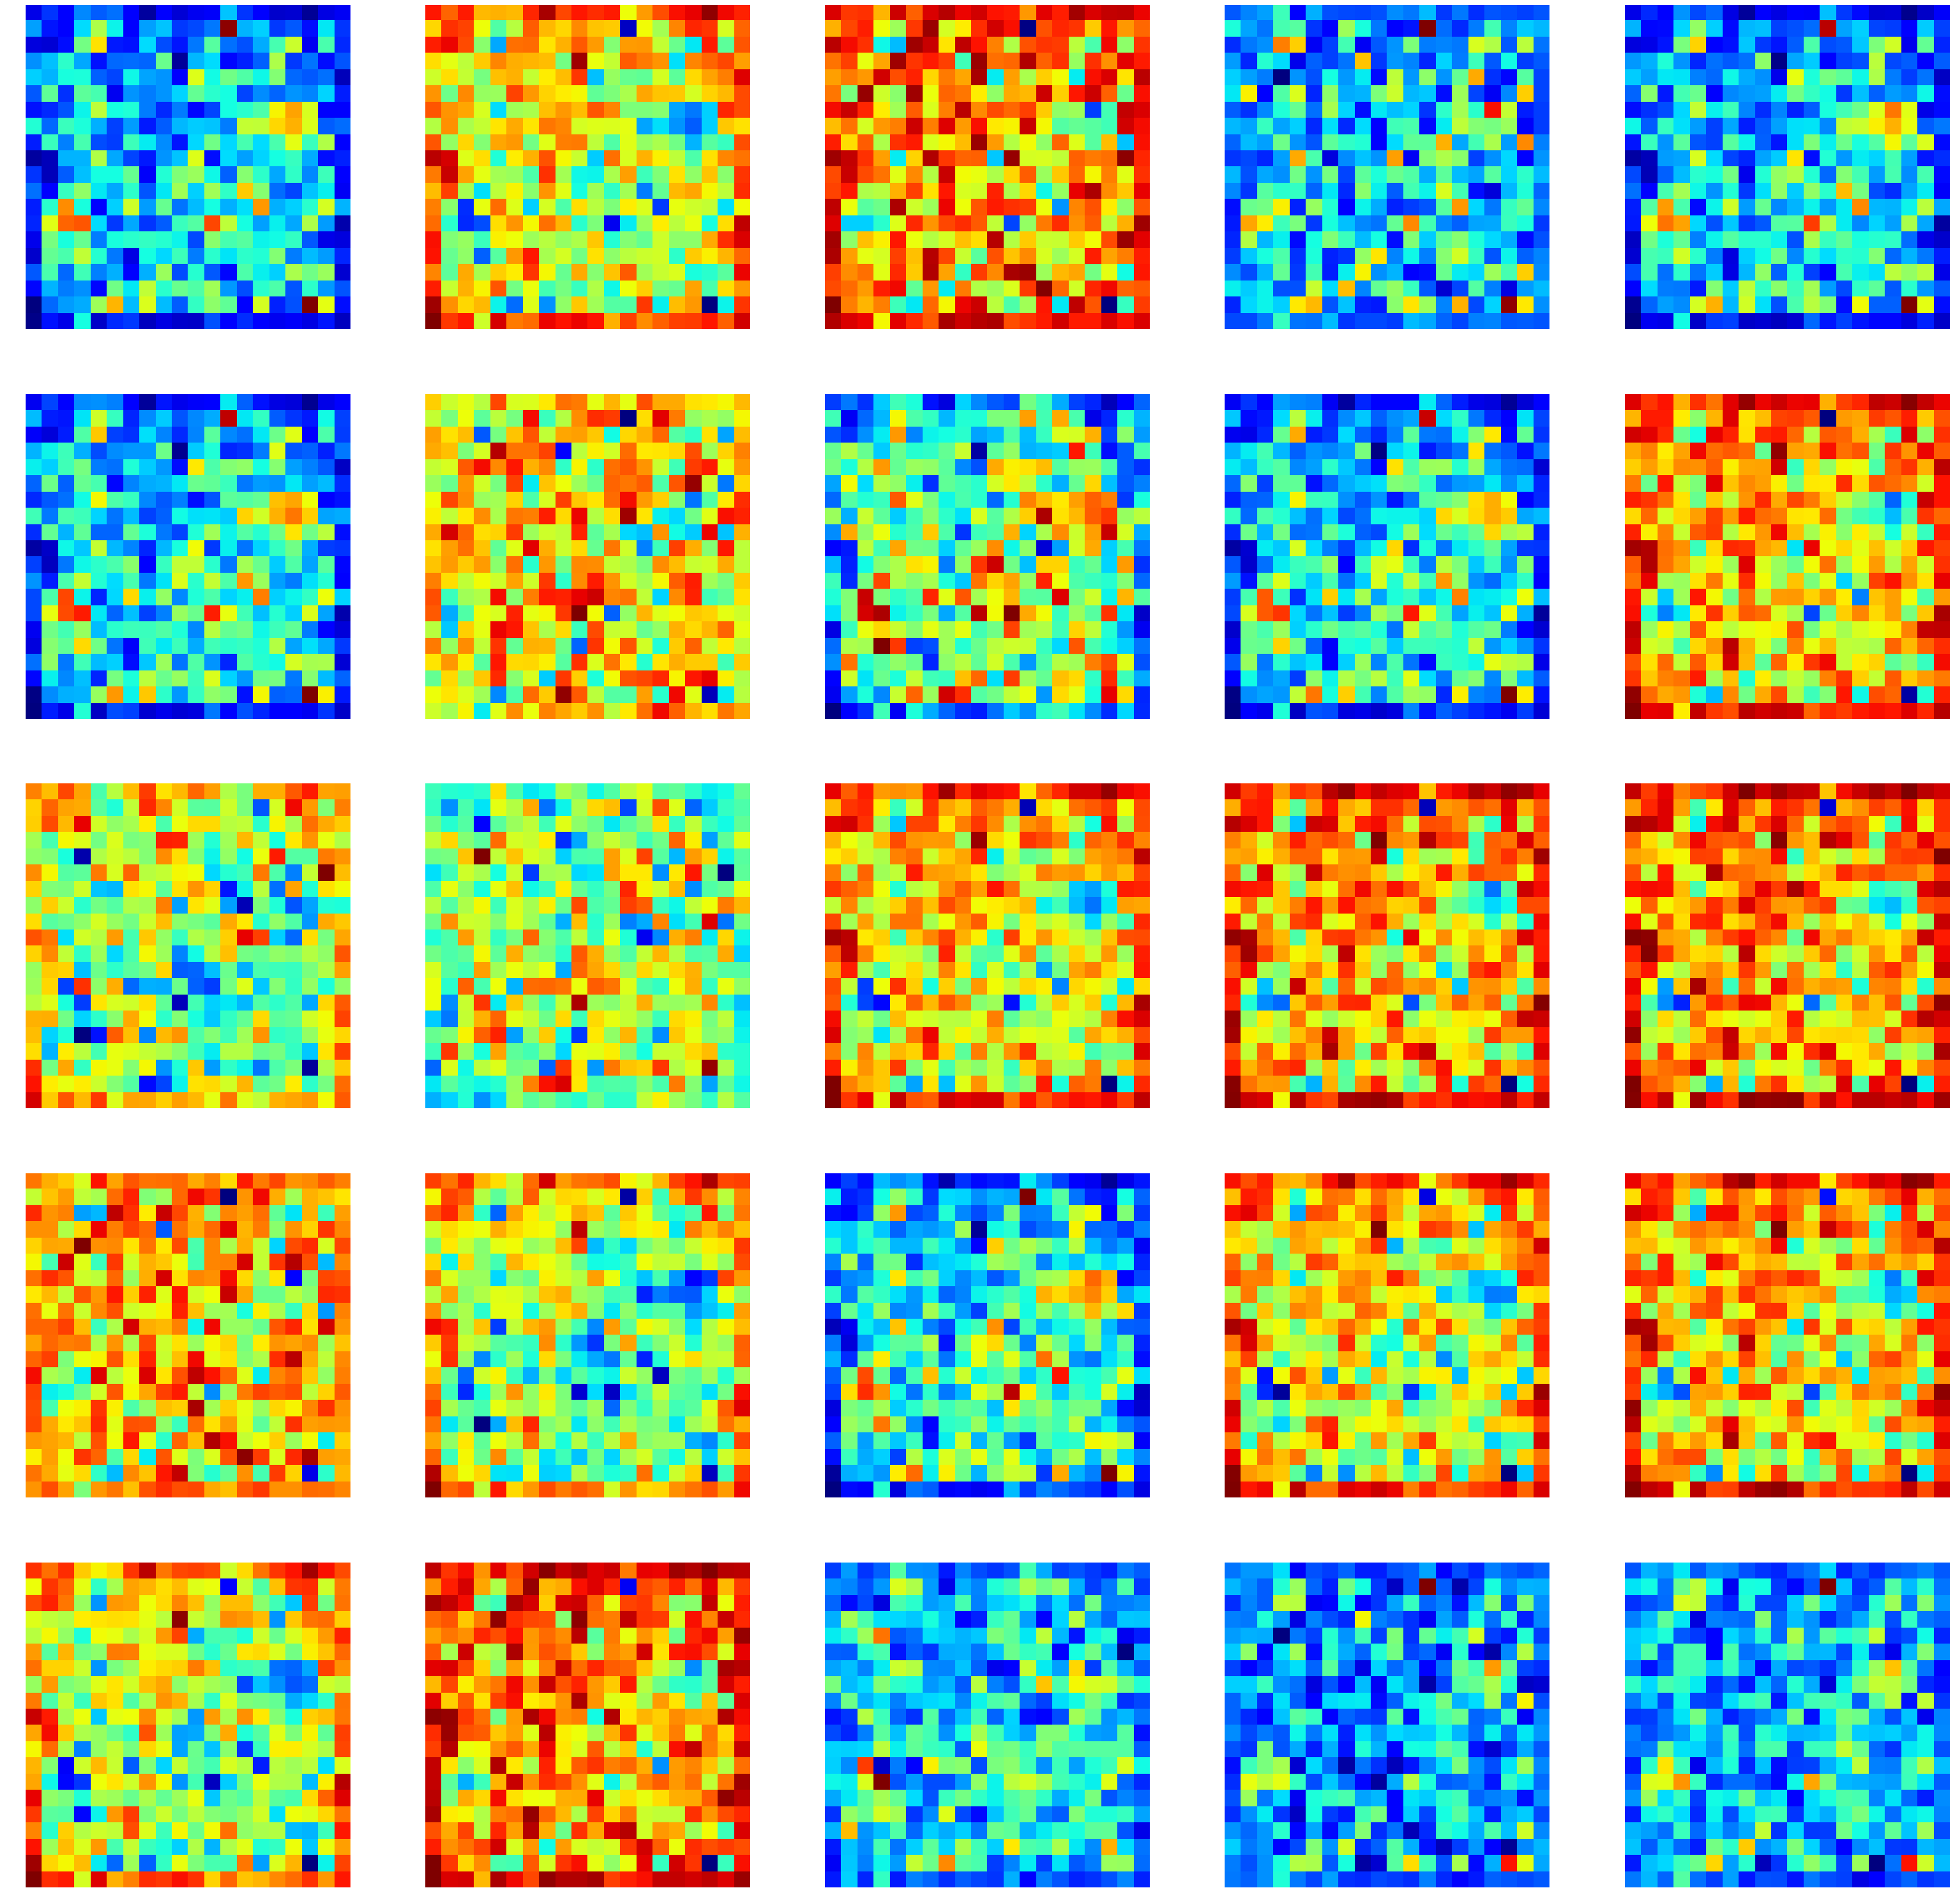

epoch 5, mean loss 7.934465913295746, std loss 0.05197723547137606


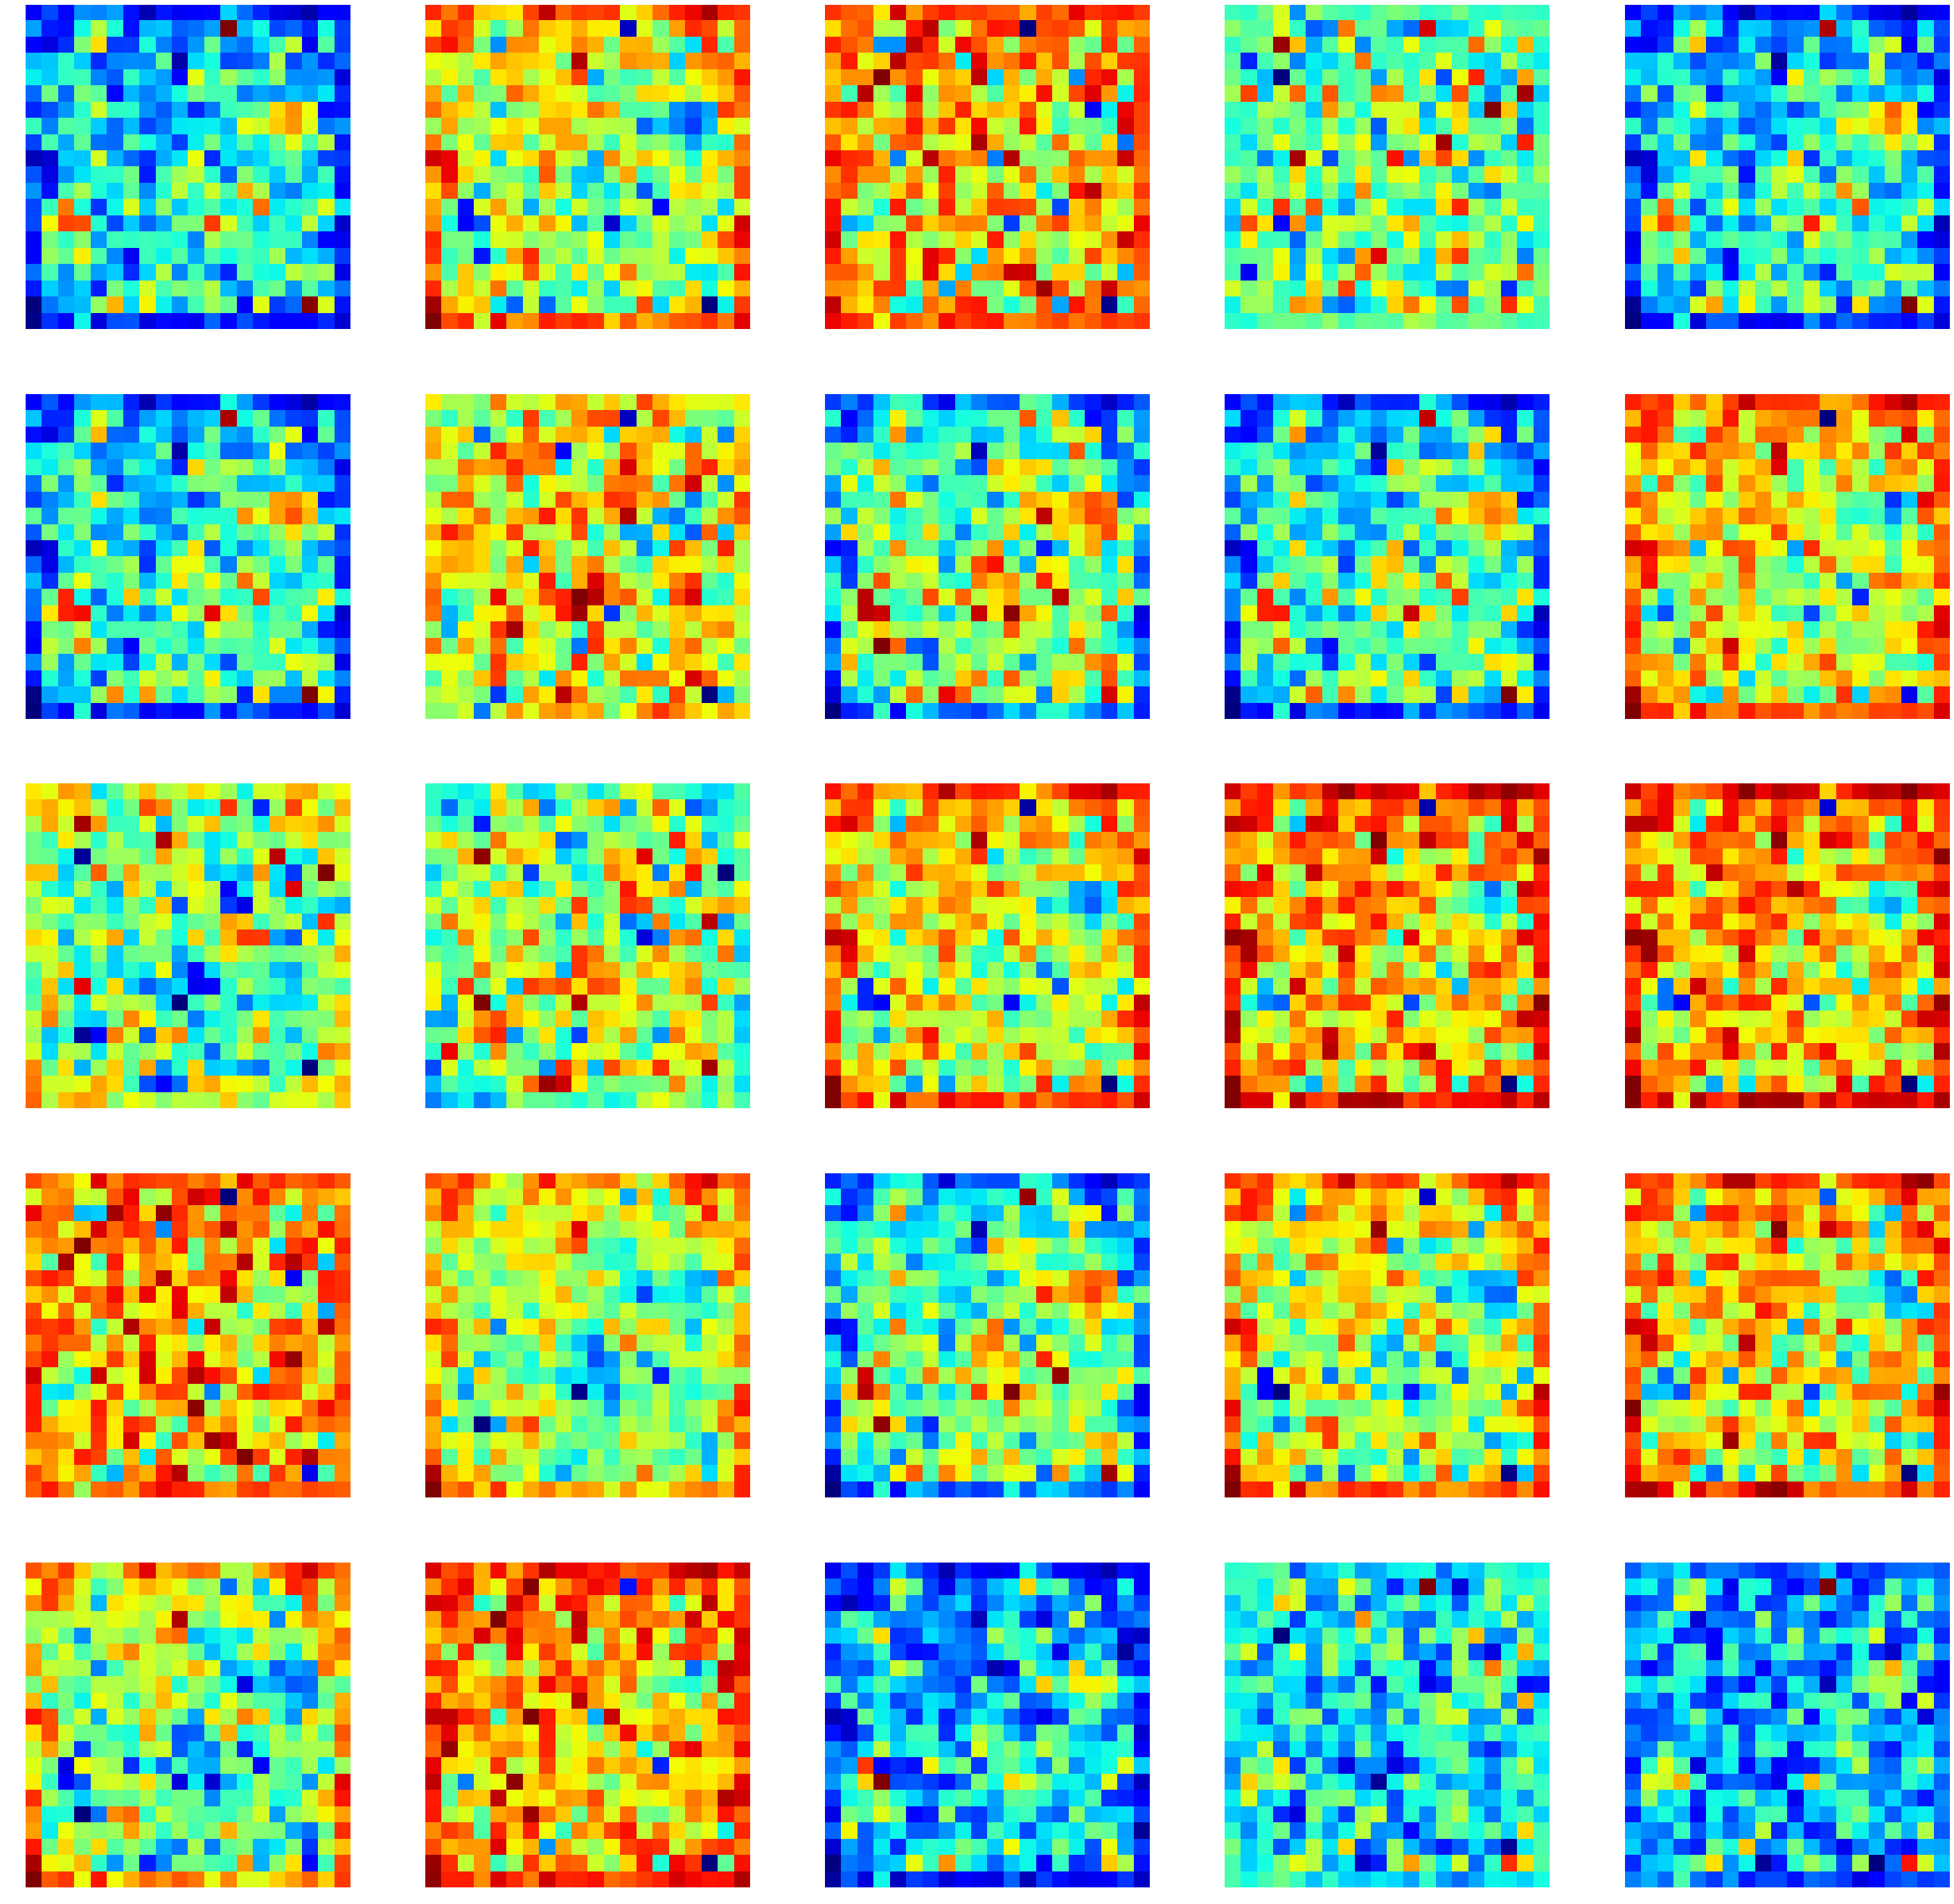

epoch 6, mean loss 7.934505537986755, std loss 0.052185968337145


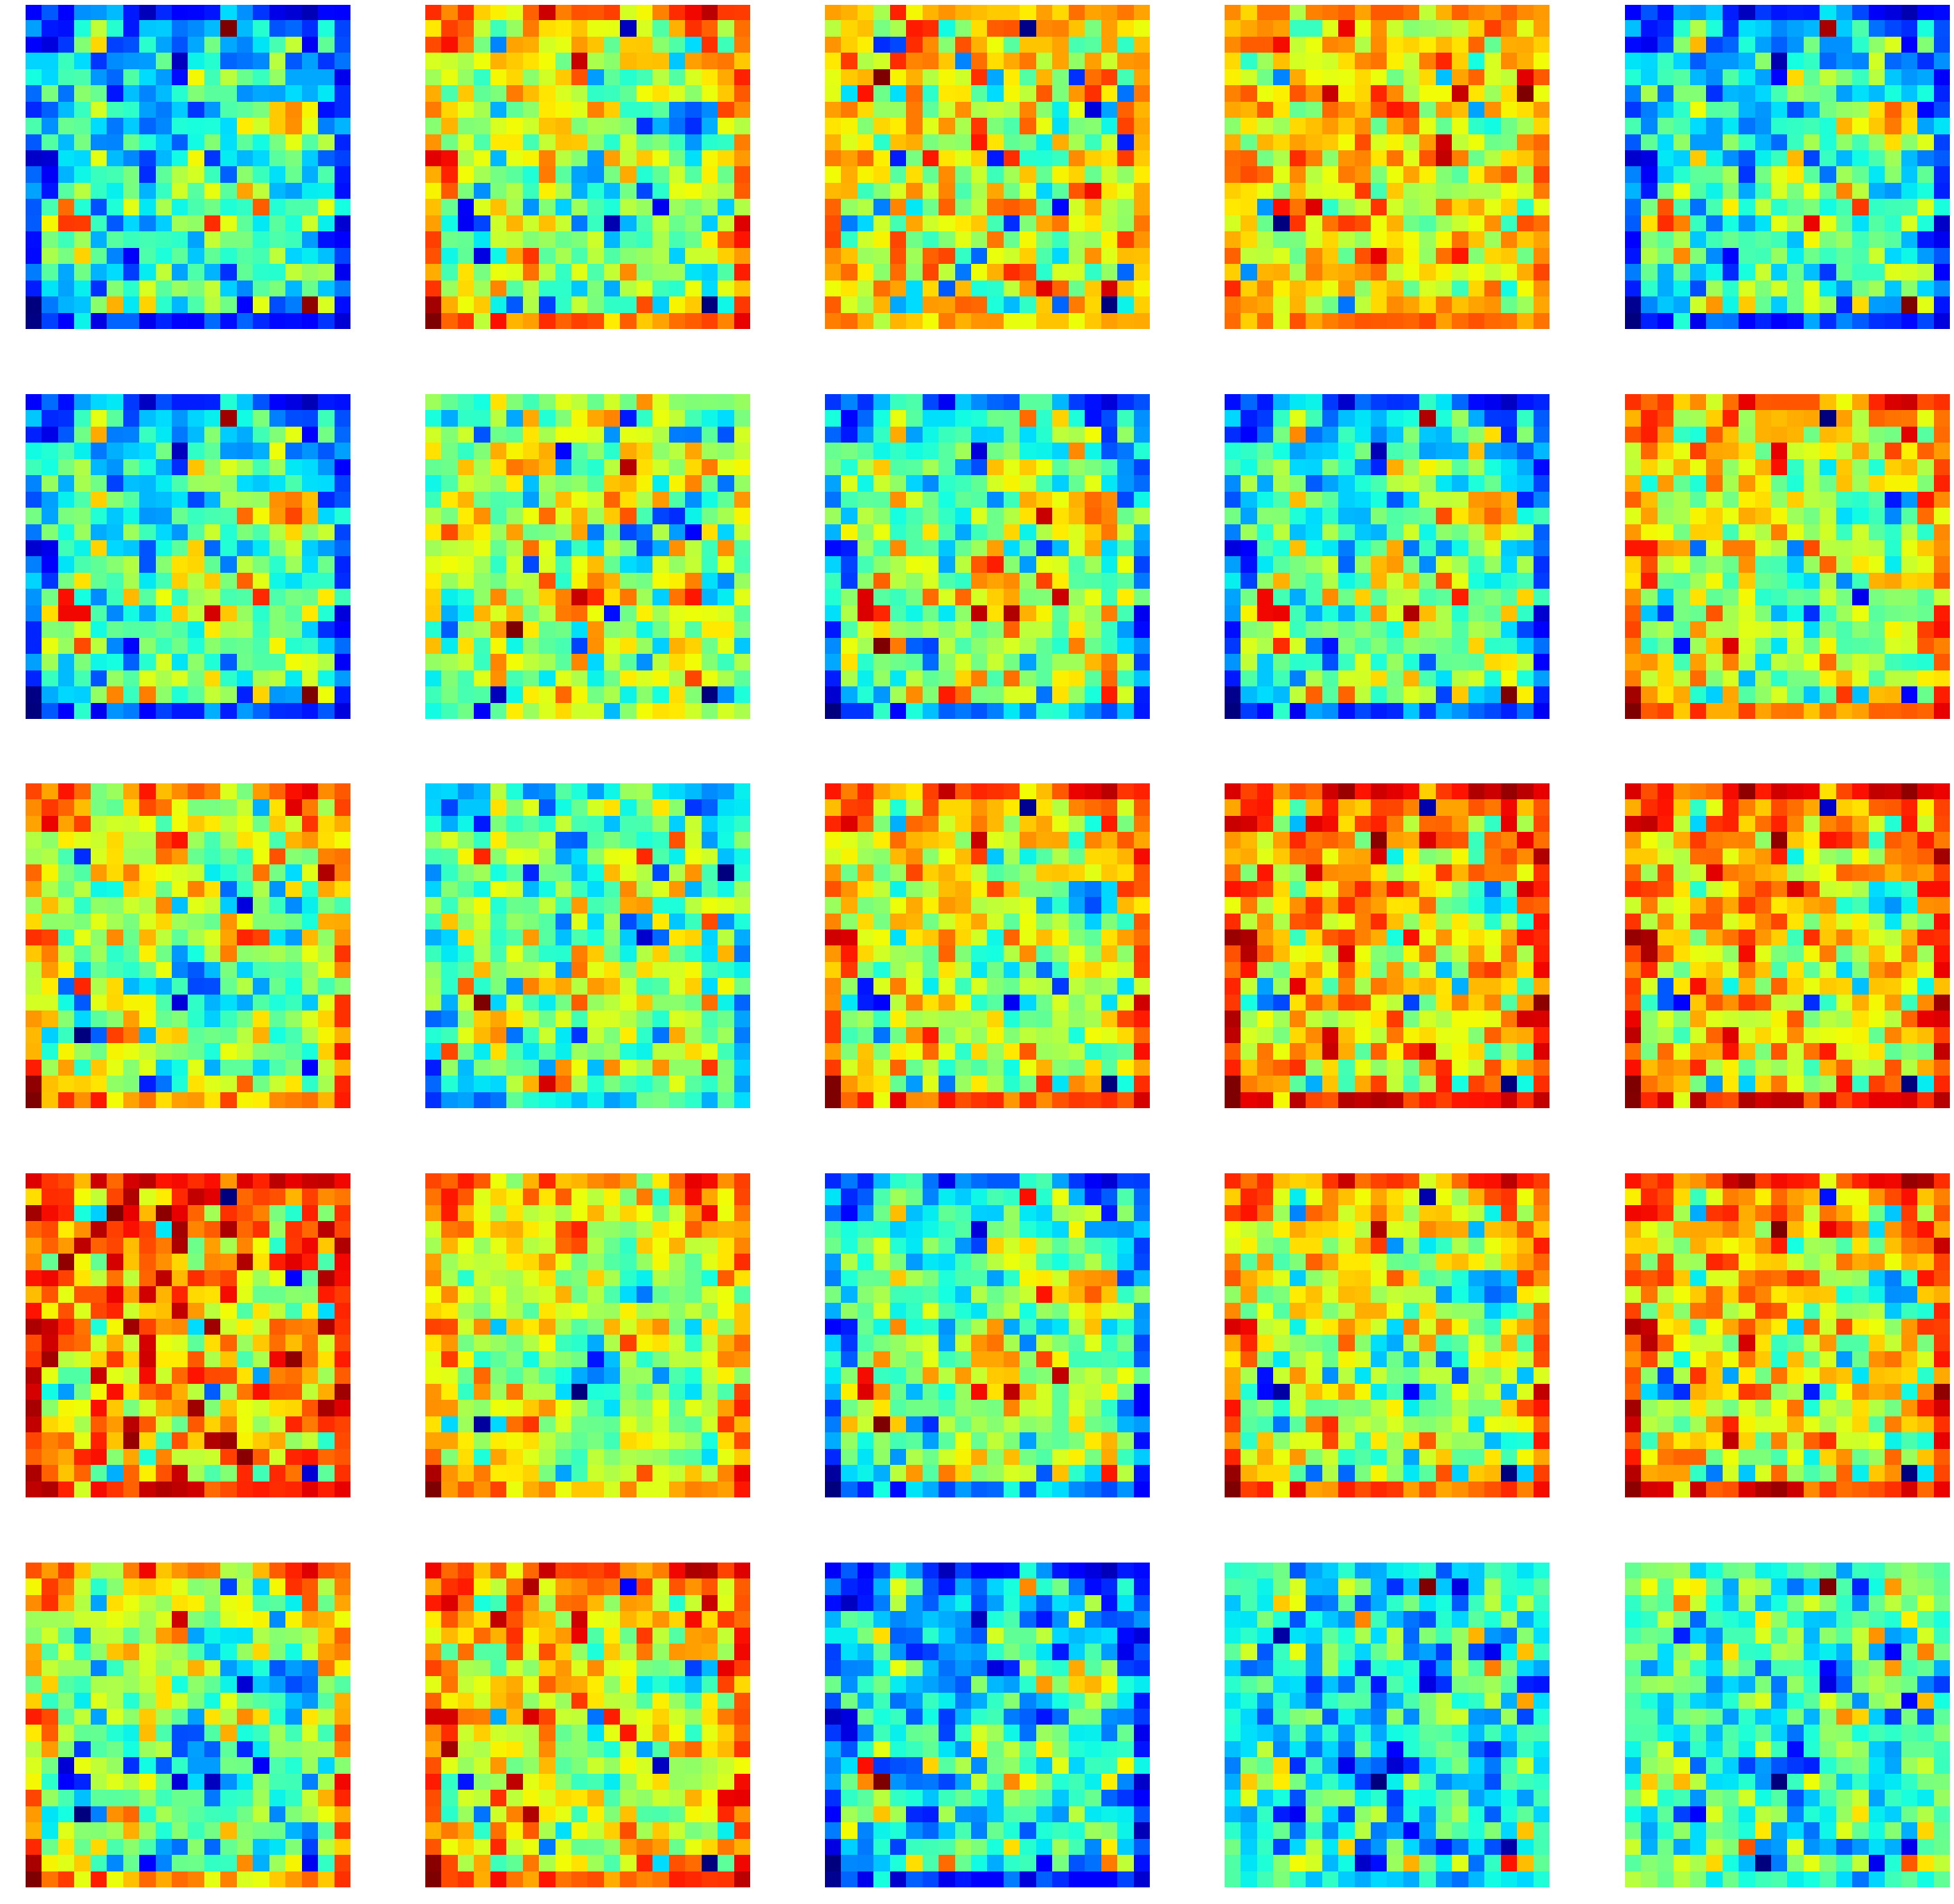

epoch 7, mean loss 7.933214626312256, std loss 0.05208744291513923


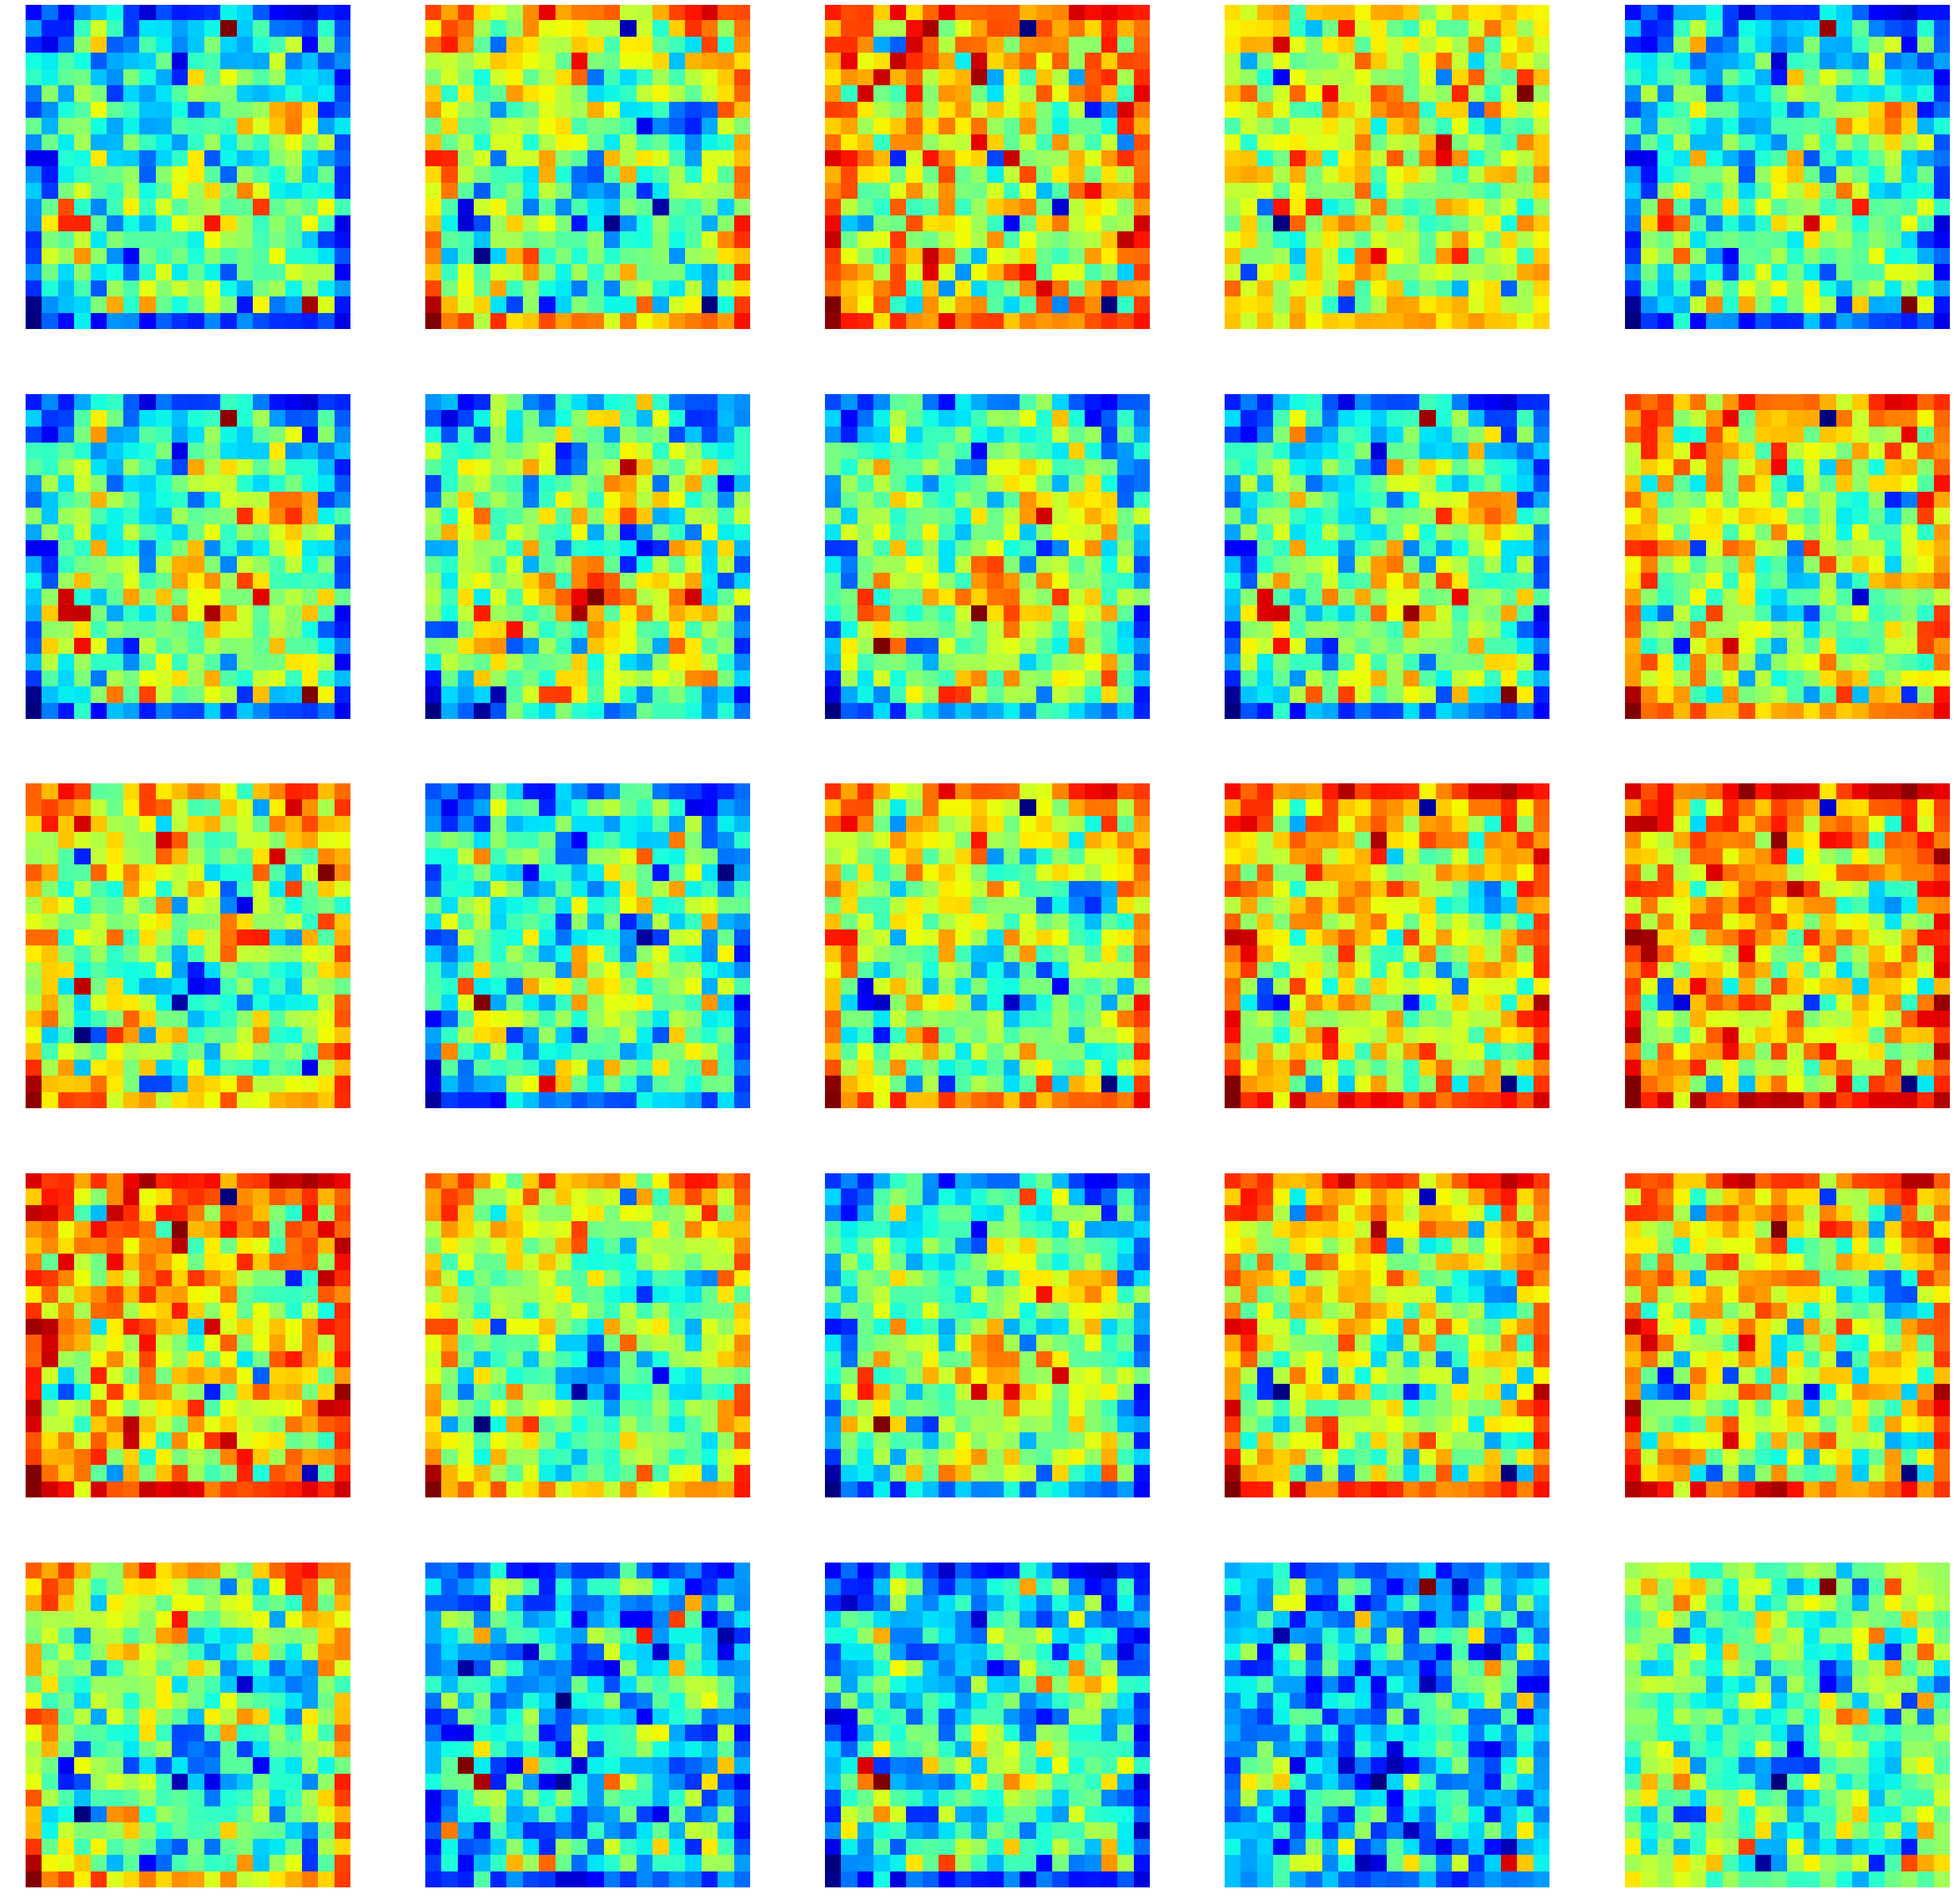

epoch 8, mean loss 7.933688467502594, std loss 0.05259054946040742


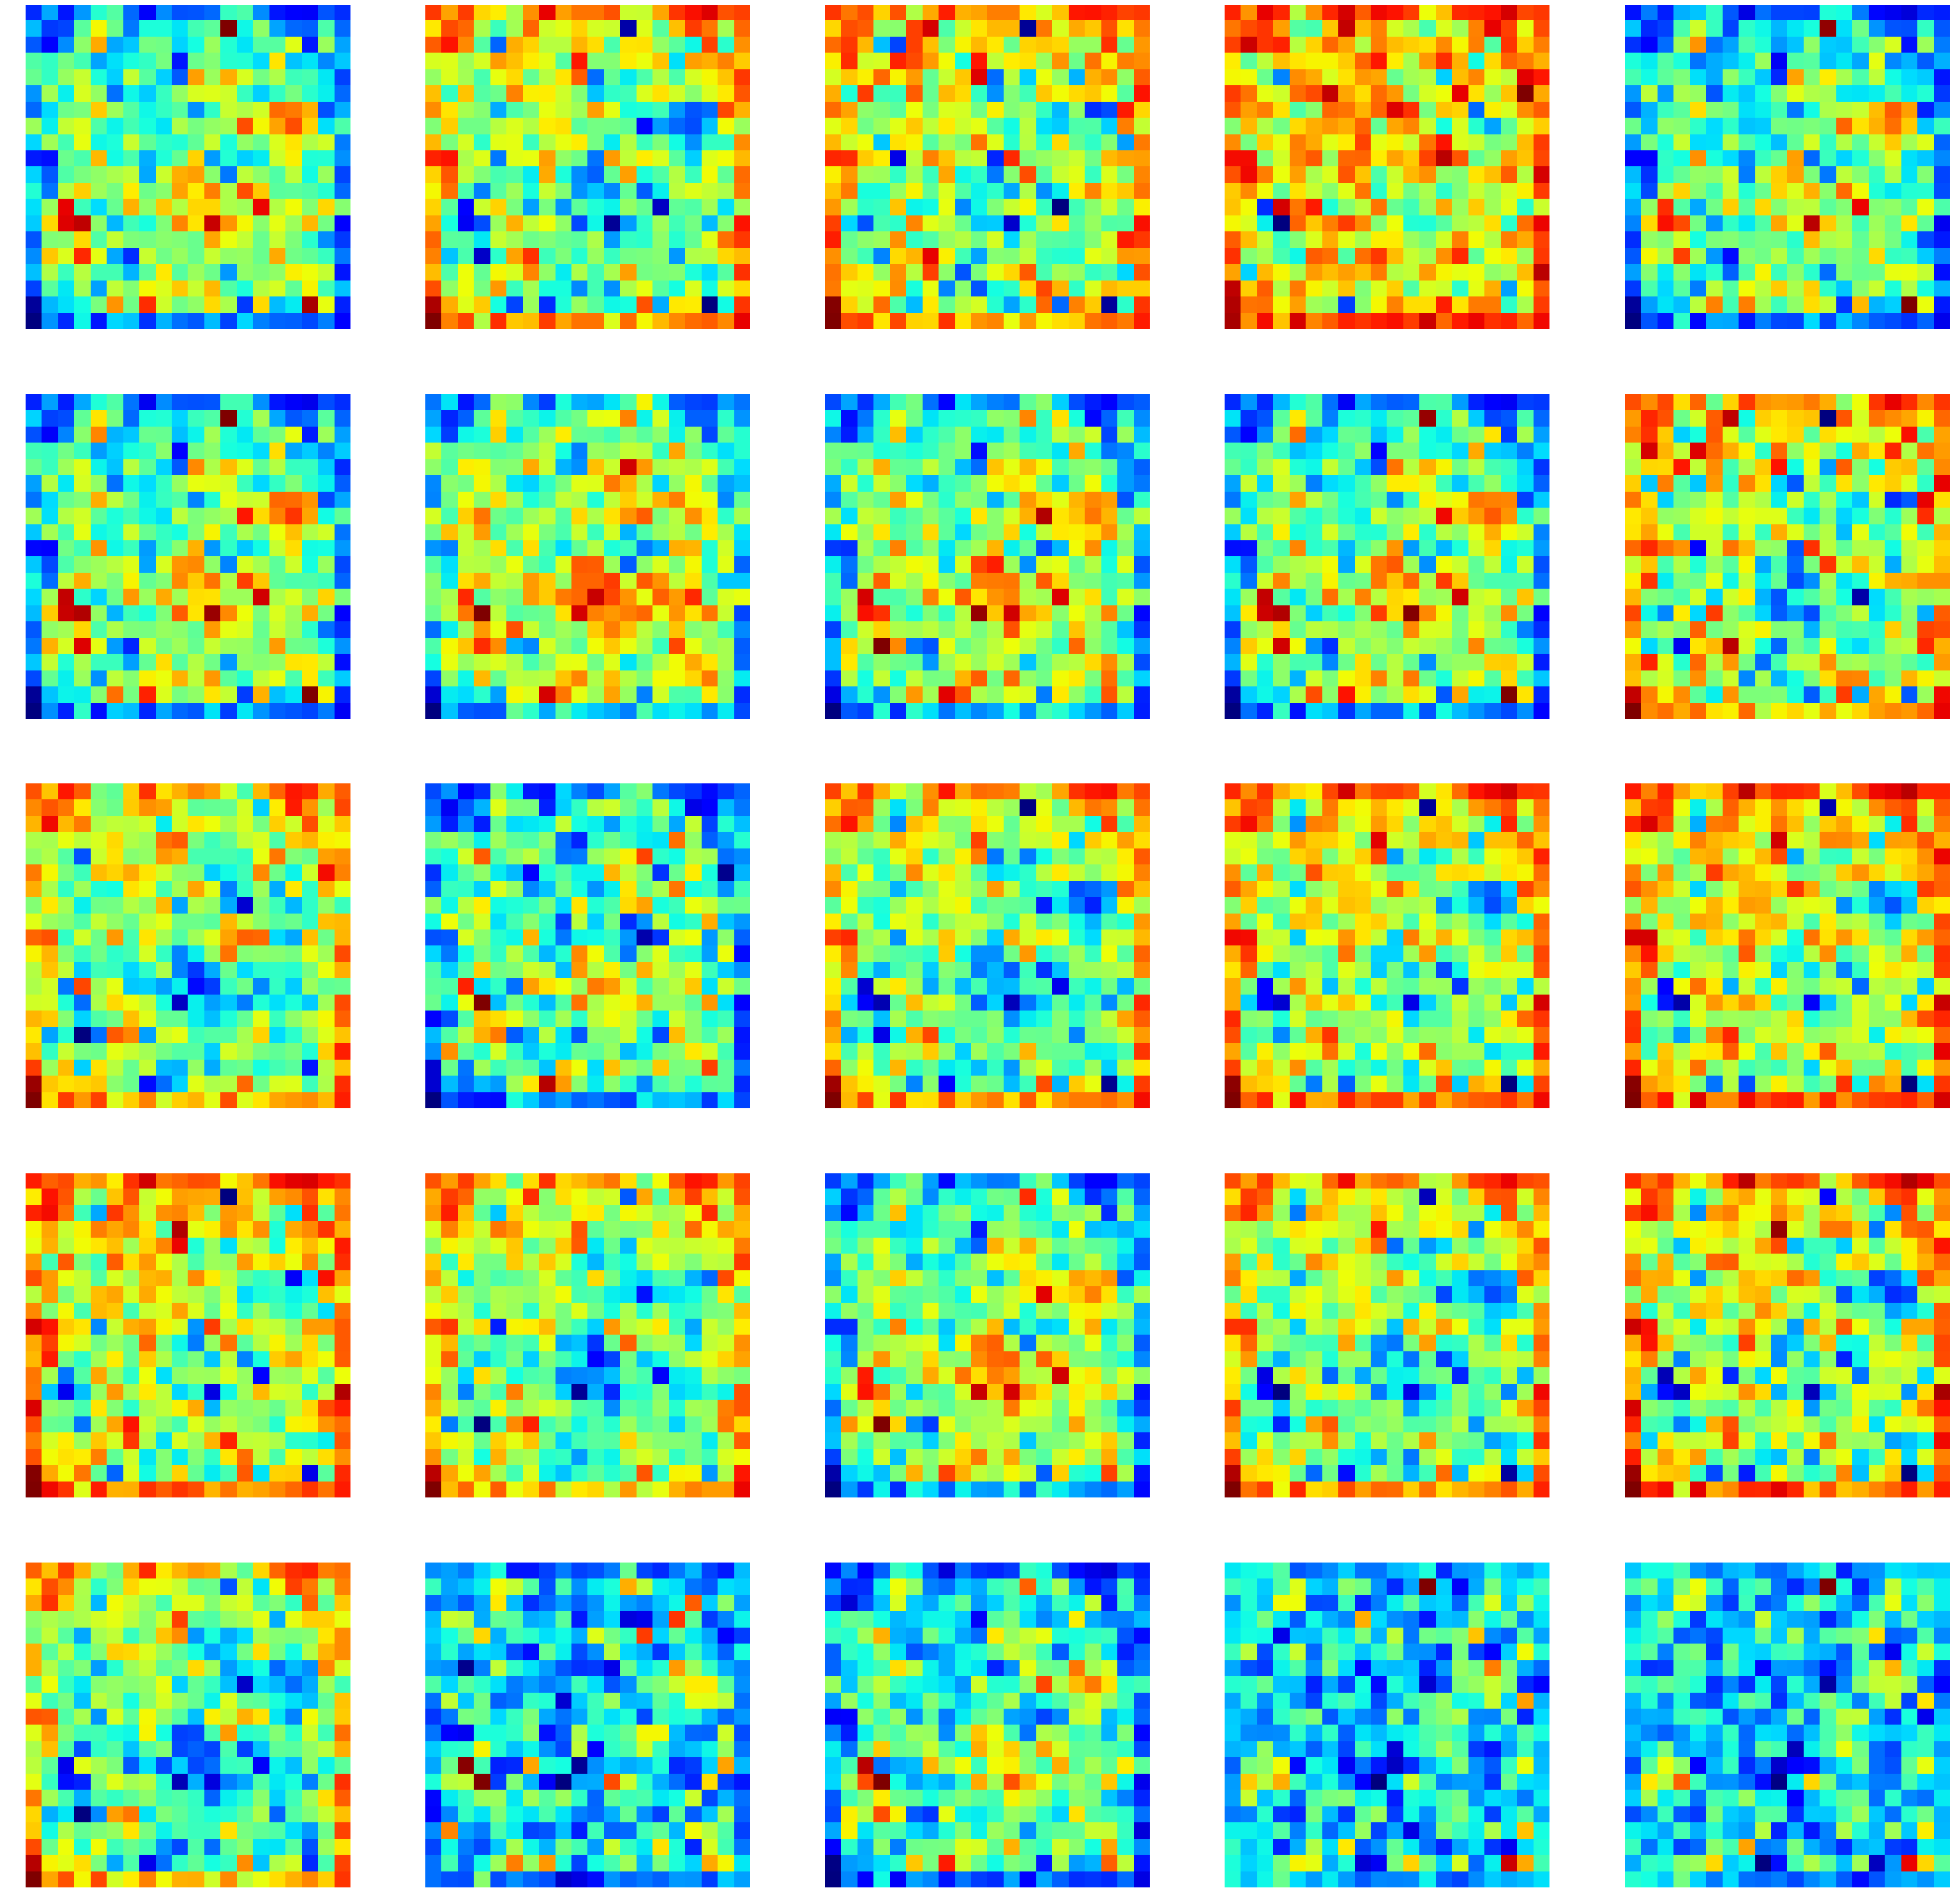

epoch 9, mean loss 7.933573795795441, std loss 0.052713584535610716


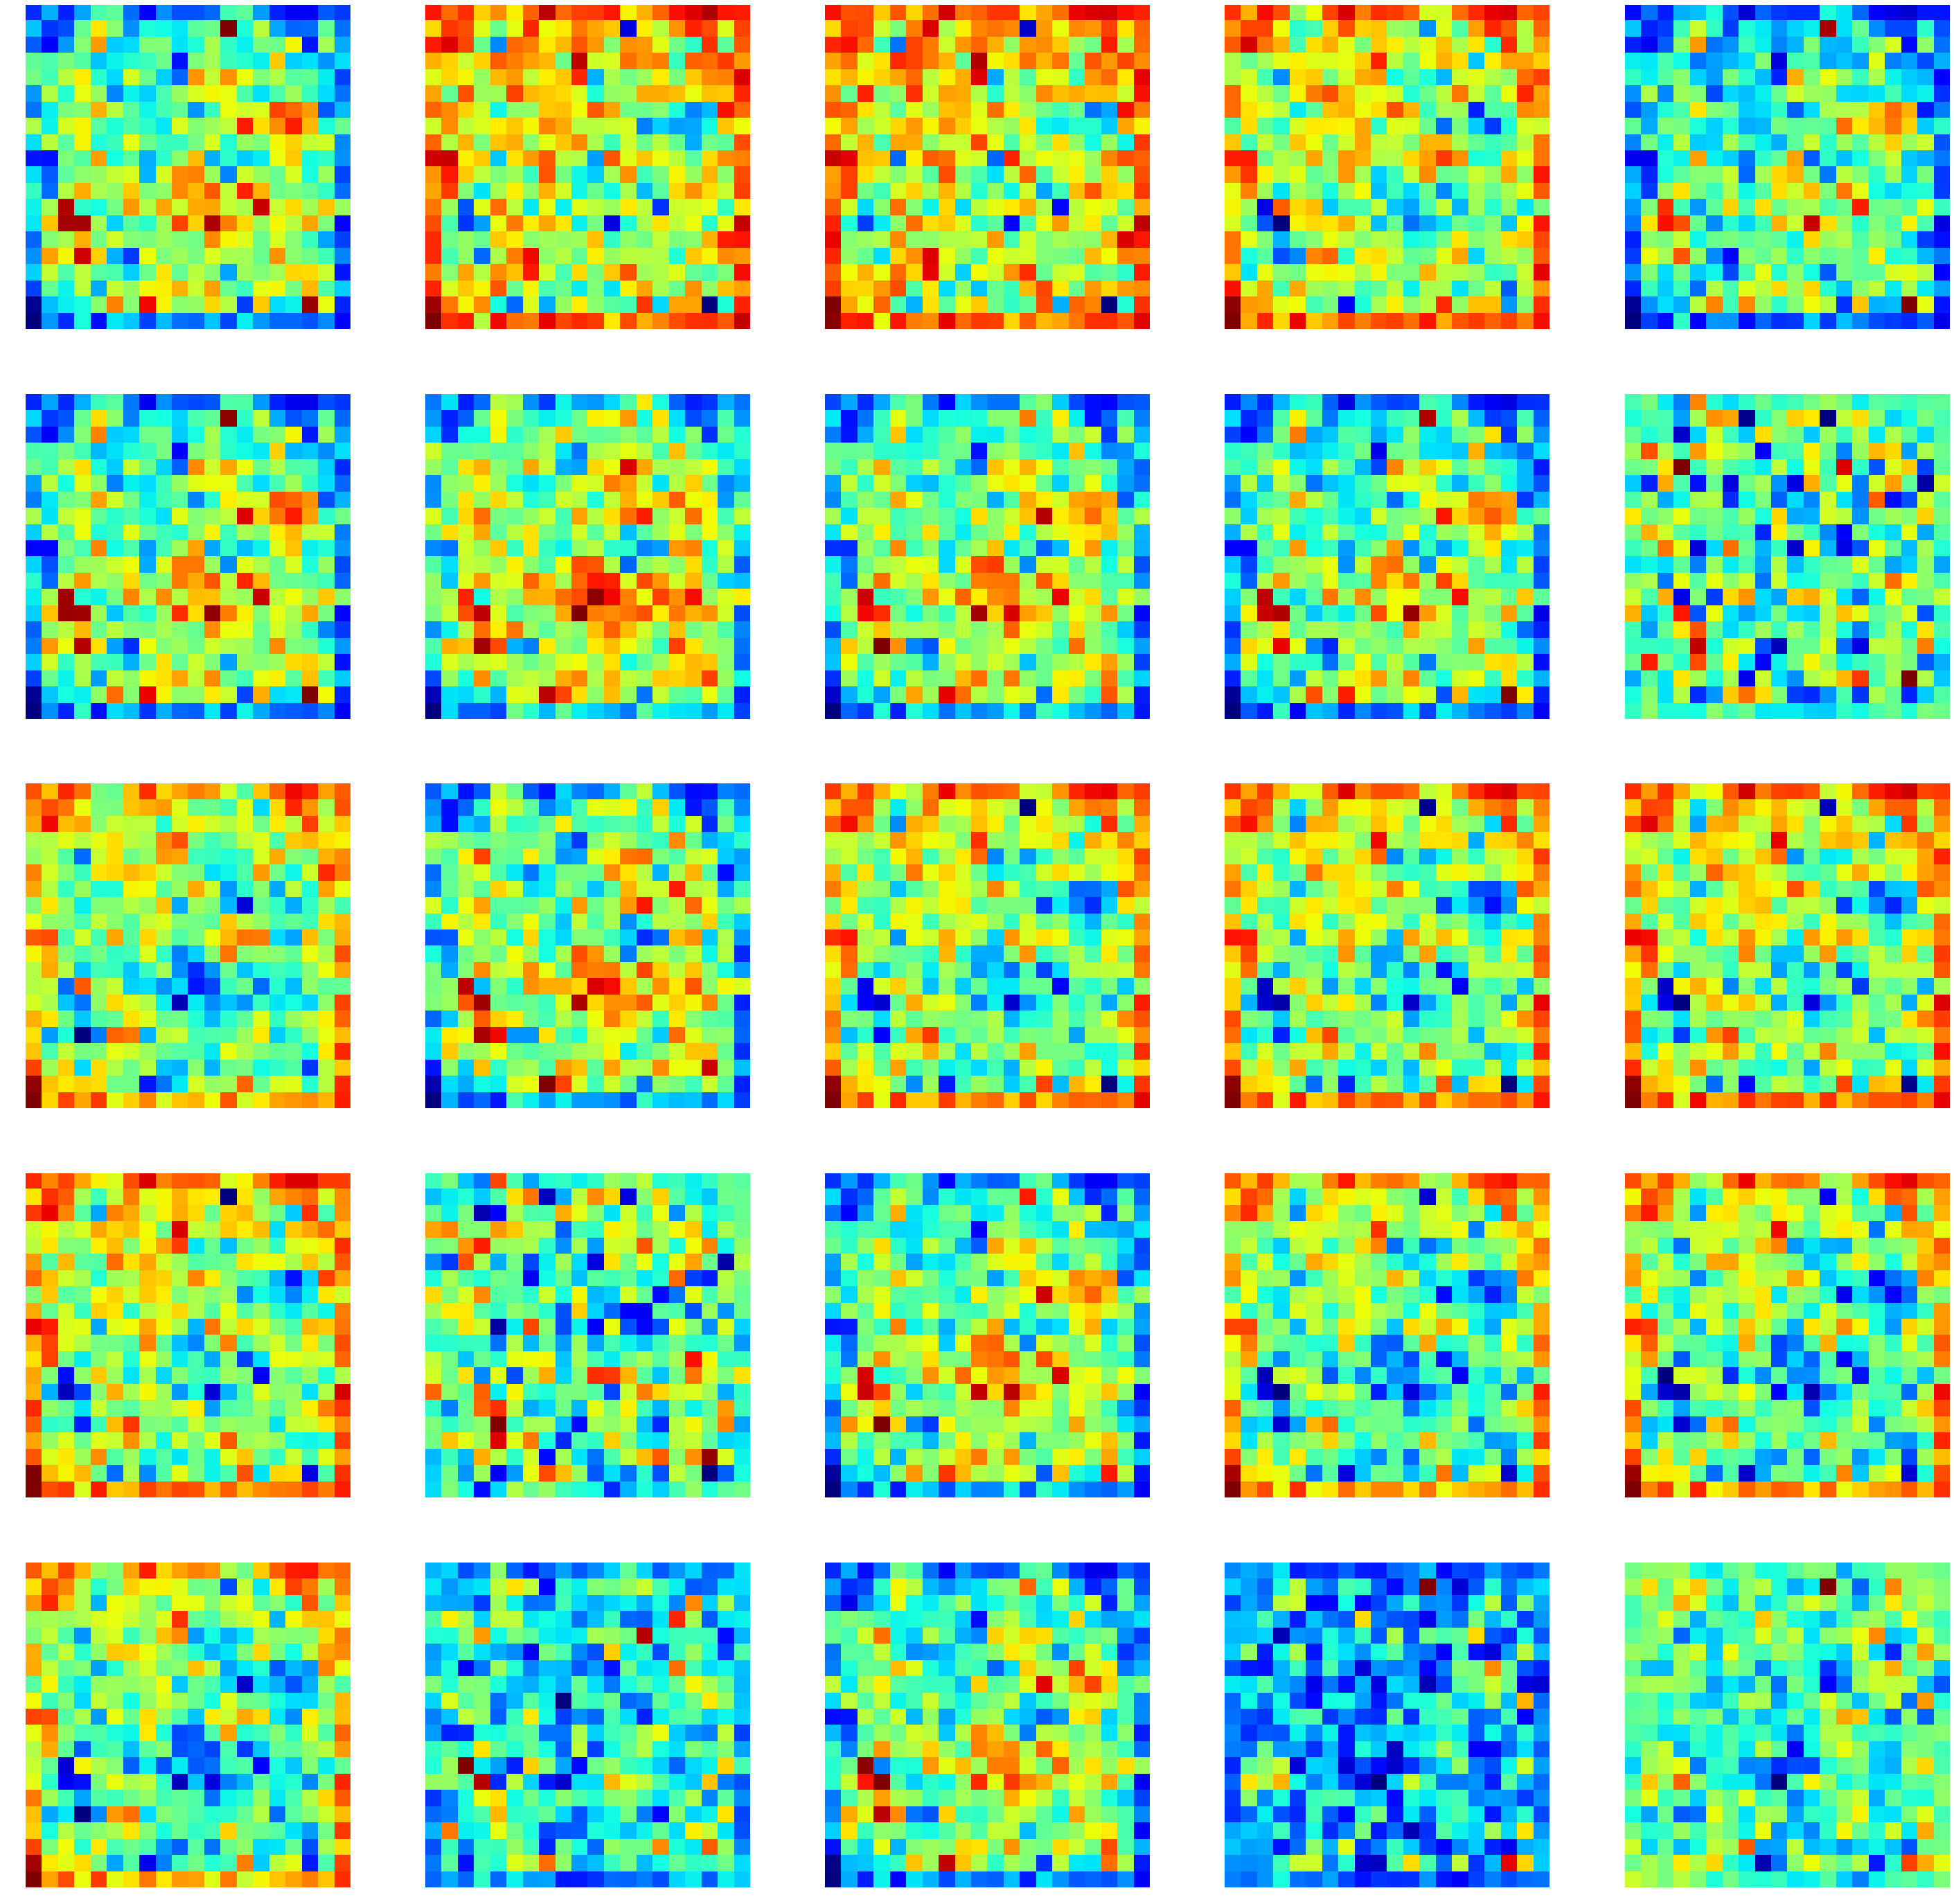

epoch 10, mean loss 7.93349587726593, std loss 0.05259972195073514


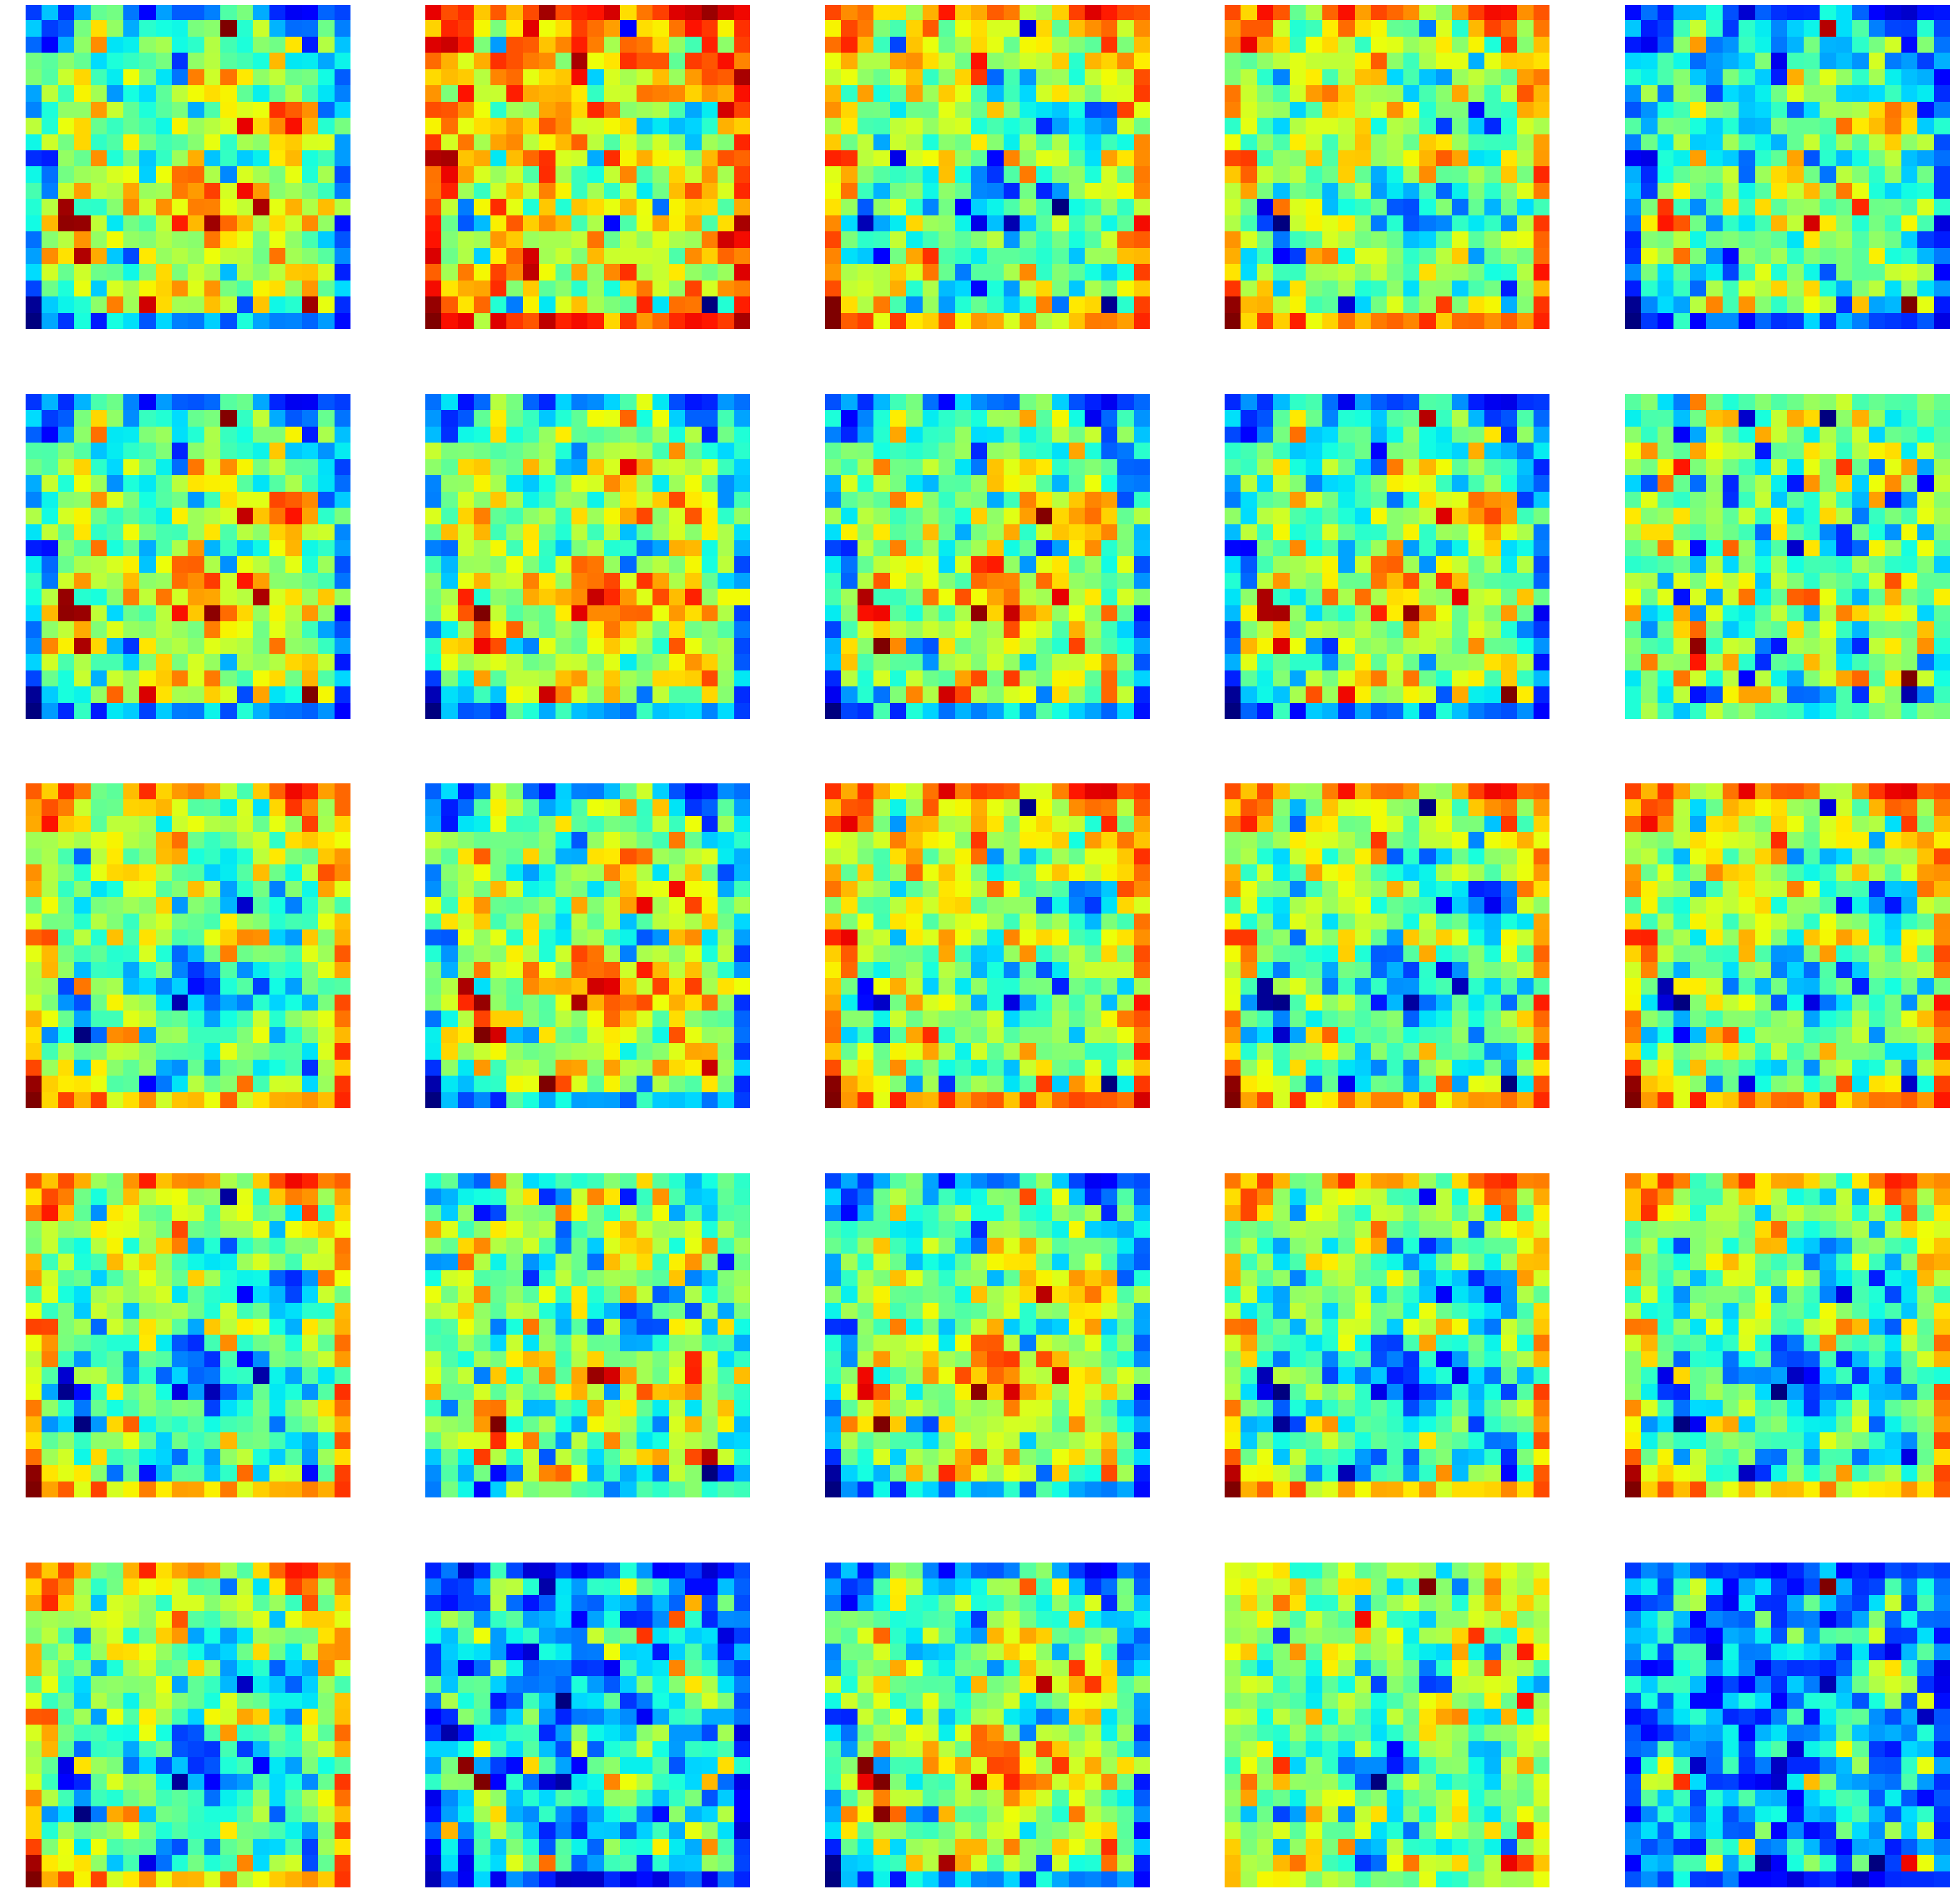

epoch 11, mean loss 7.933220713138581, std loss 0.05275243101535902


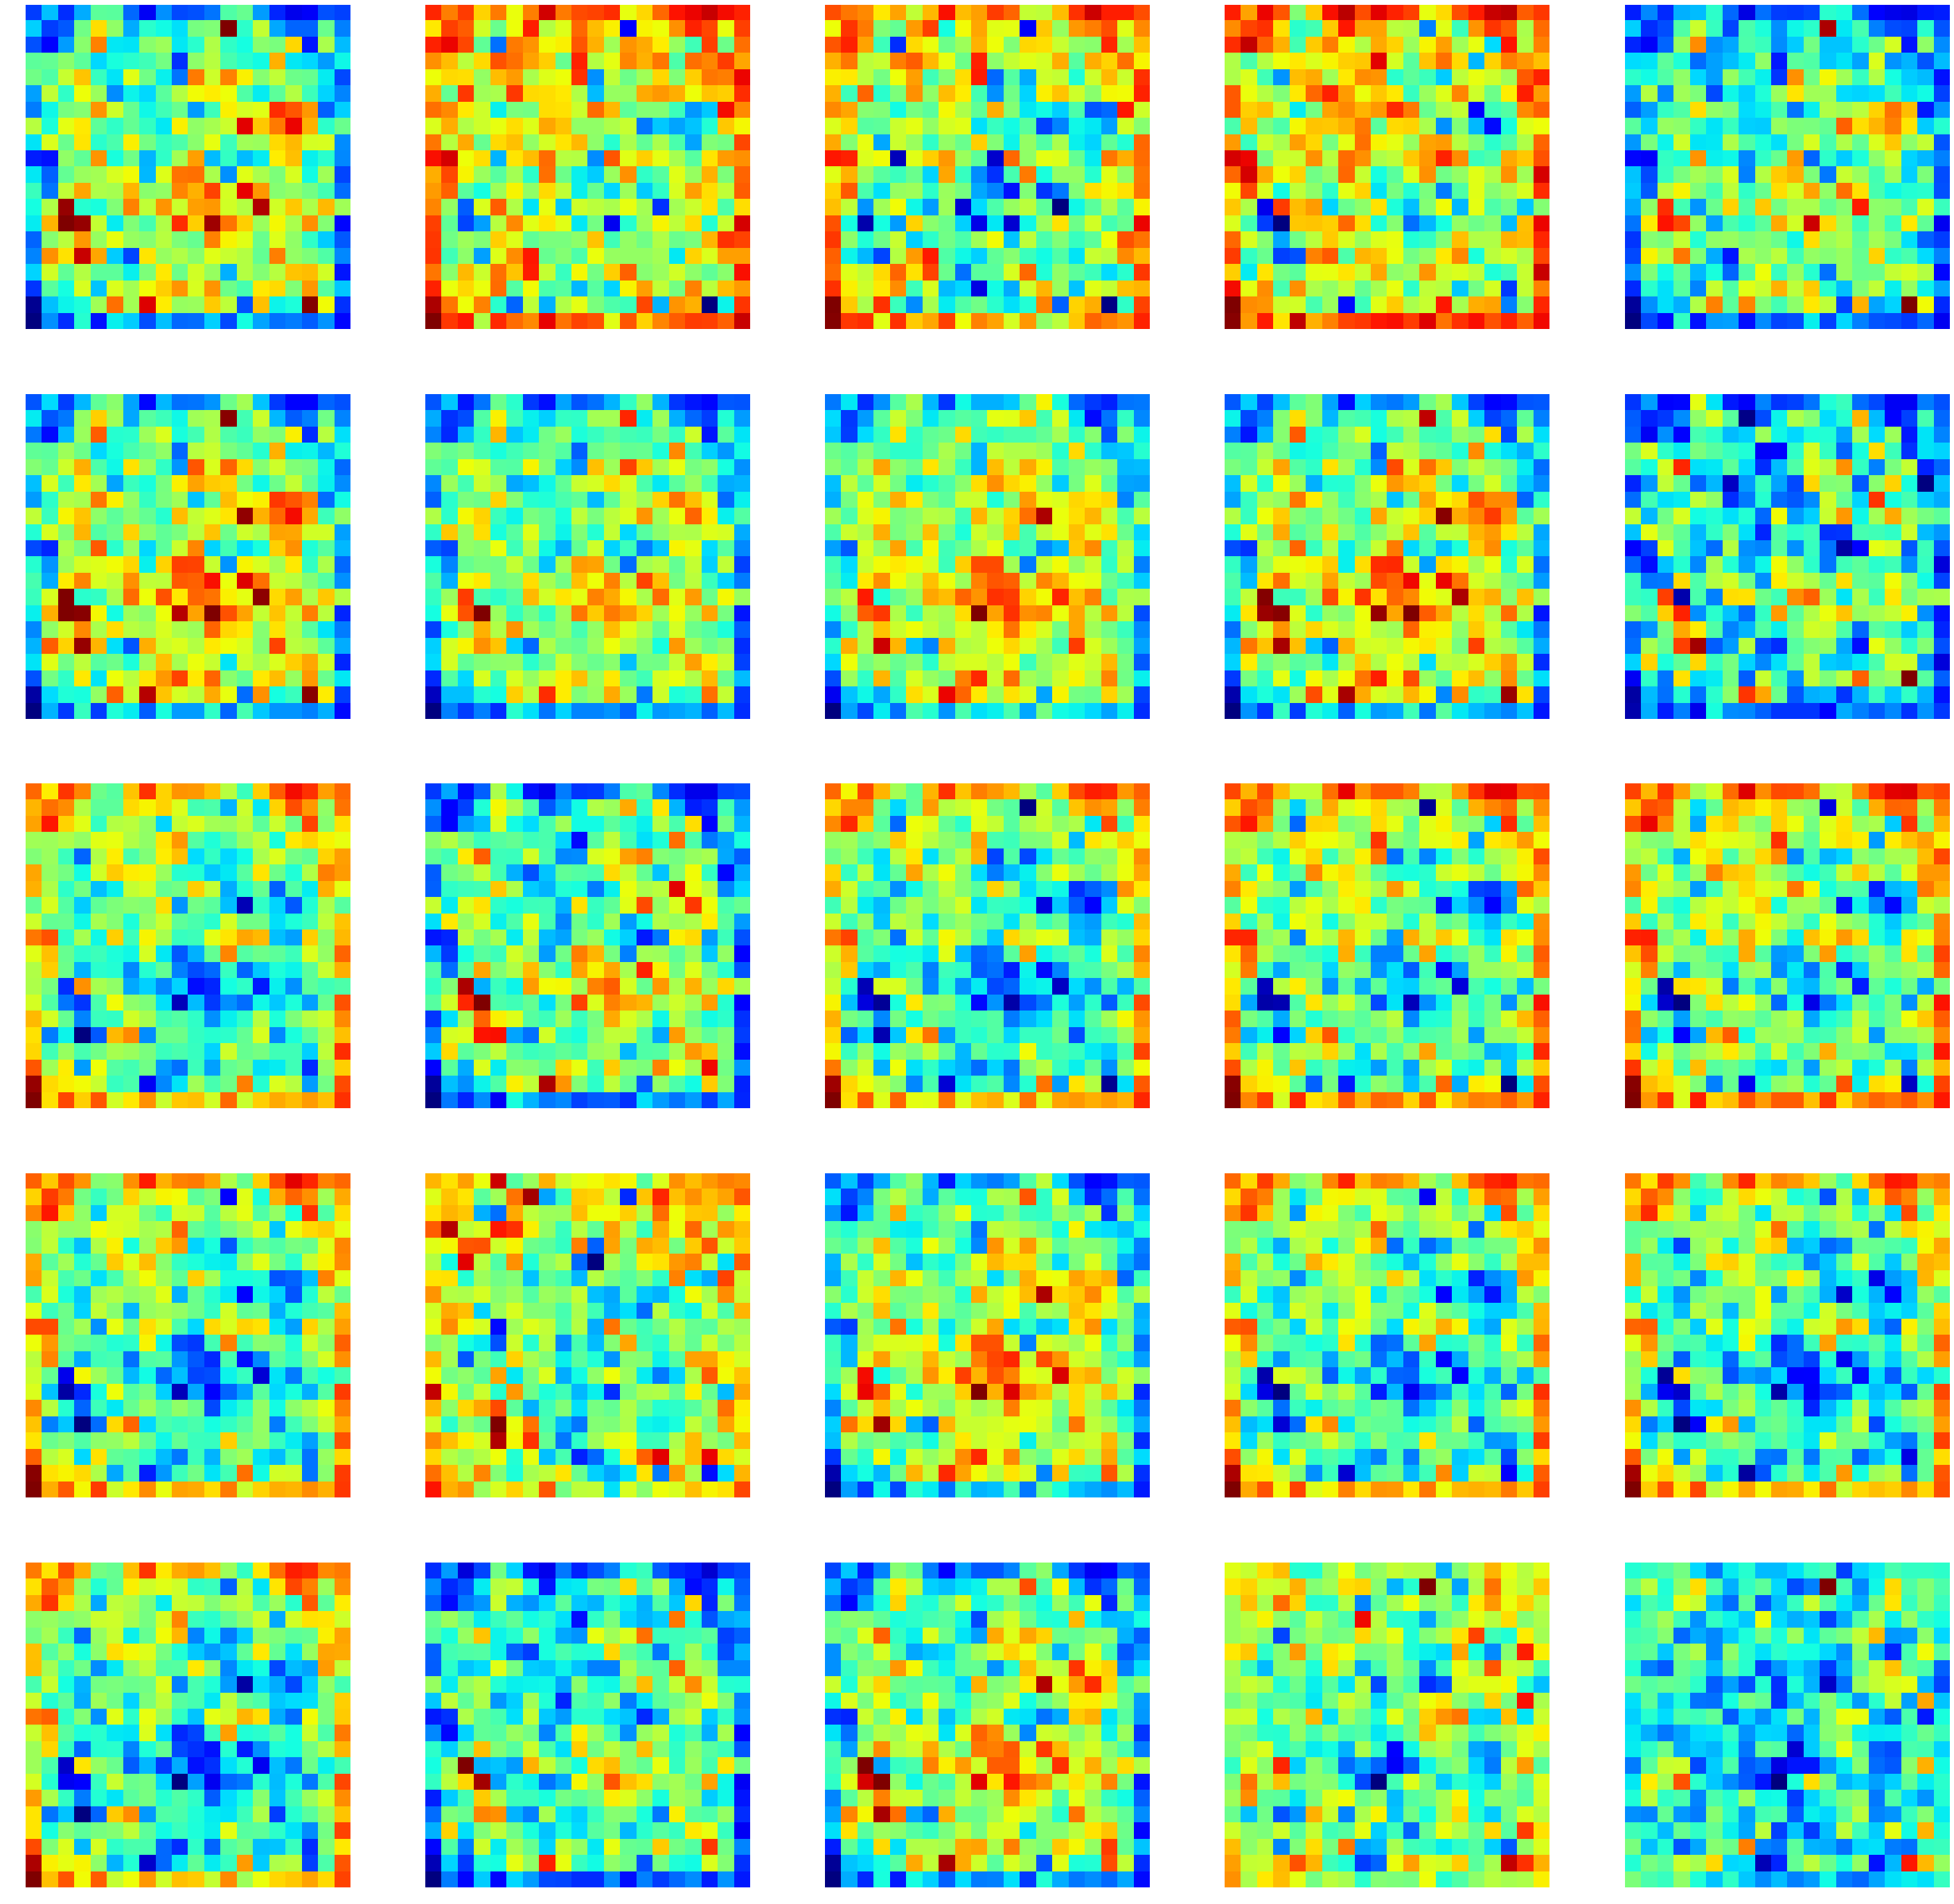

epoch 12, mean loss 7.934491653442382, std loss 0.05231749282457093


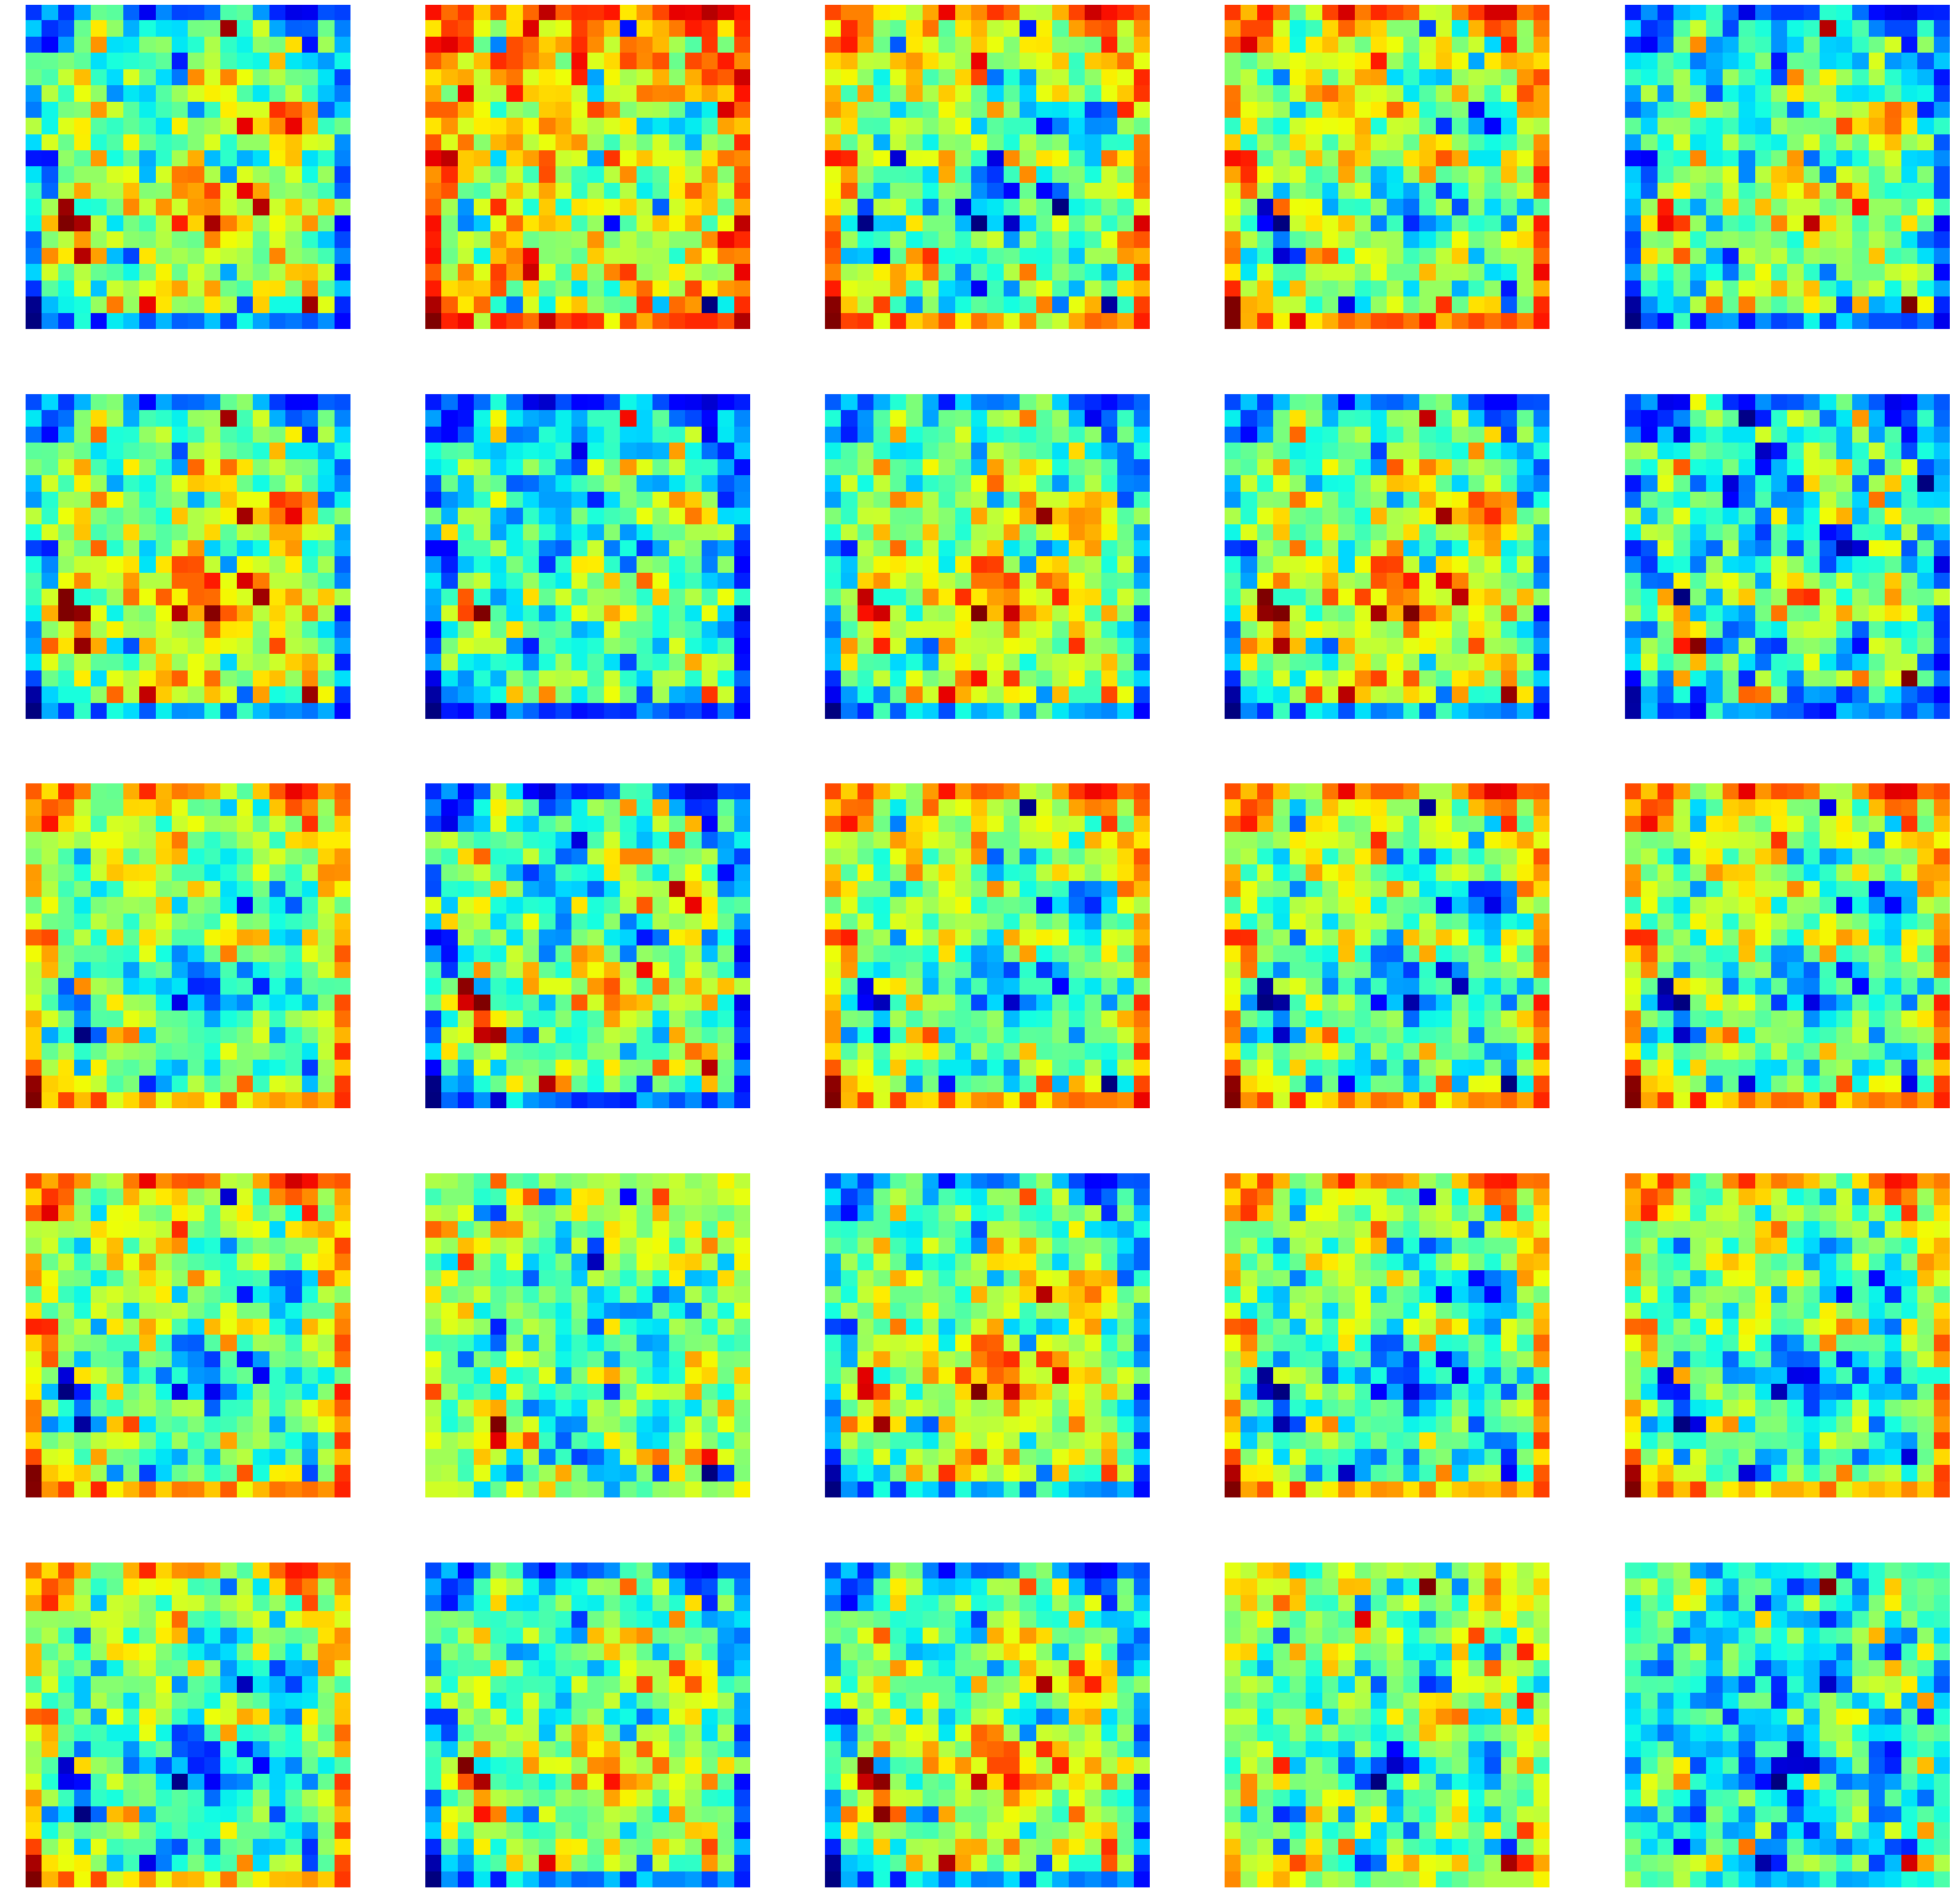

epoch 13, mean loss 7.934462537288666, std loss 0.05226515715562593


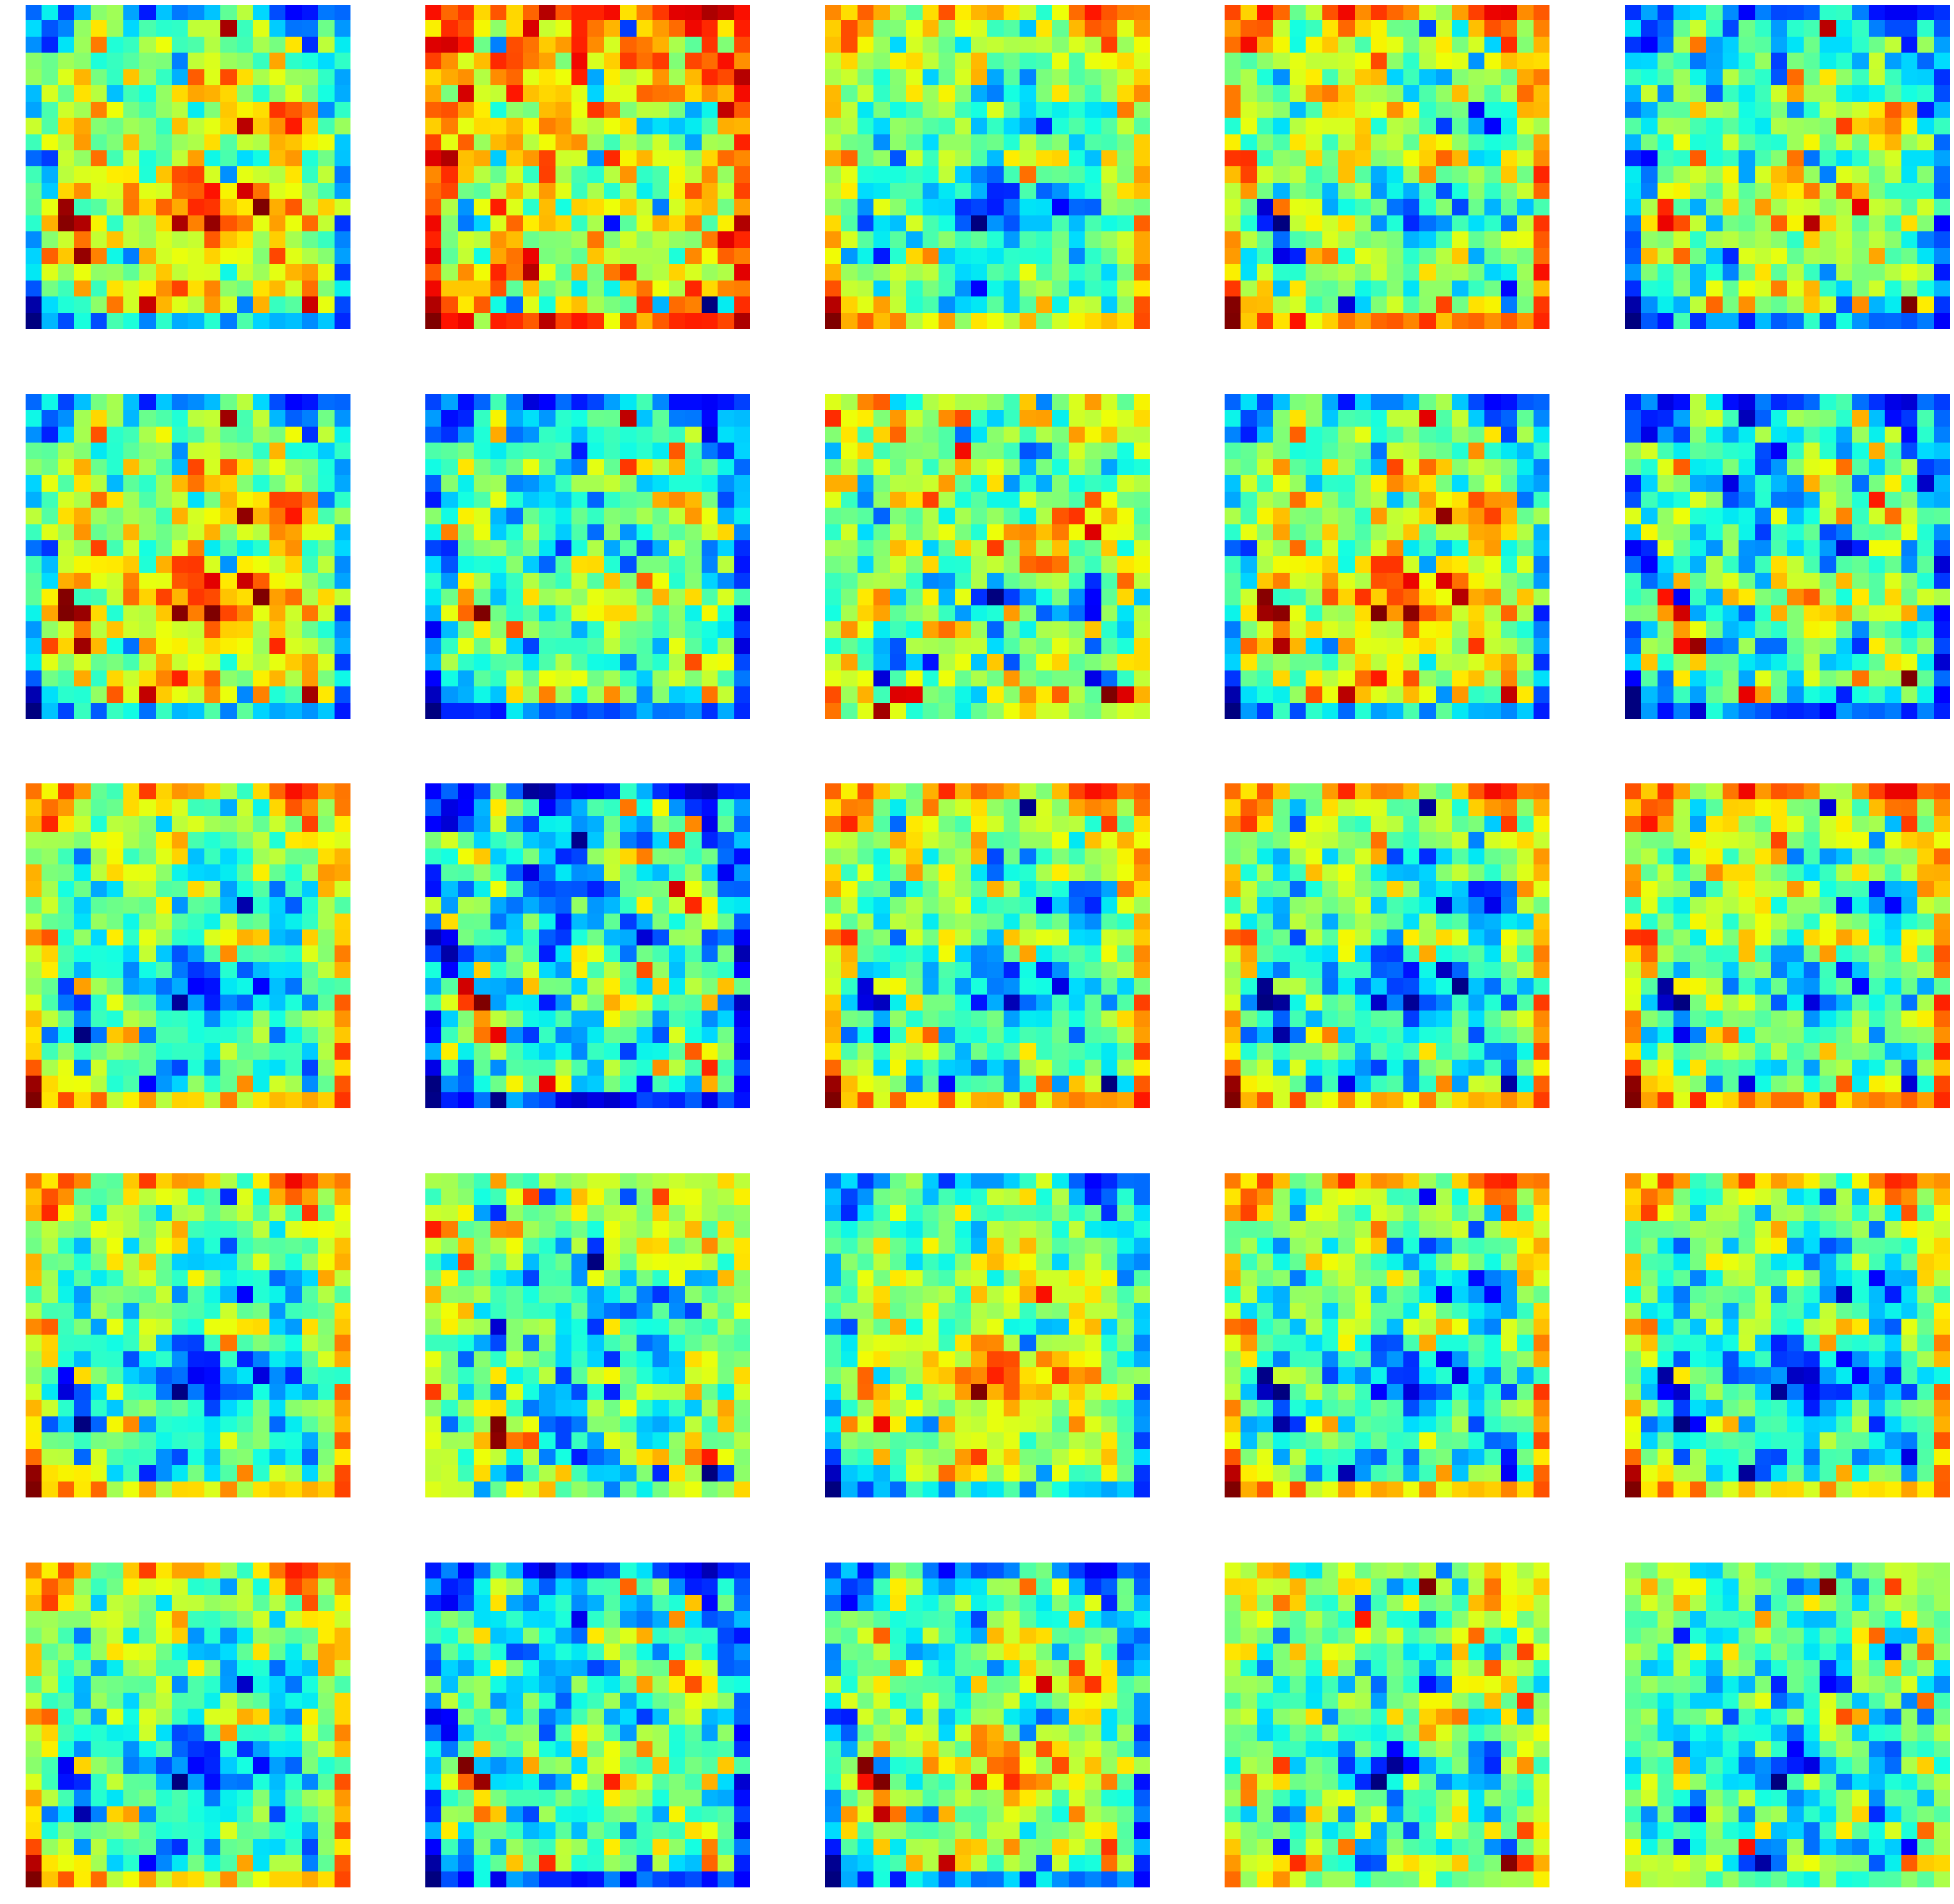

epoch 14, mean loss 7.934913011074066, std loss 0.05223074597270187


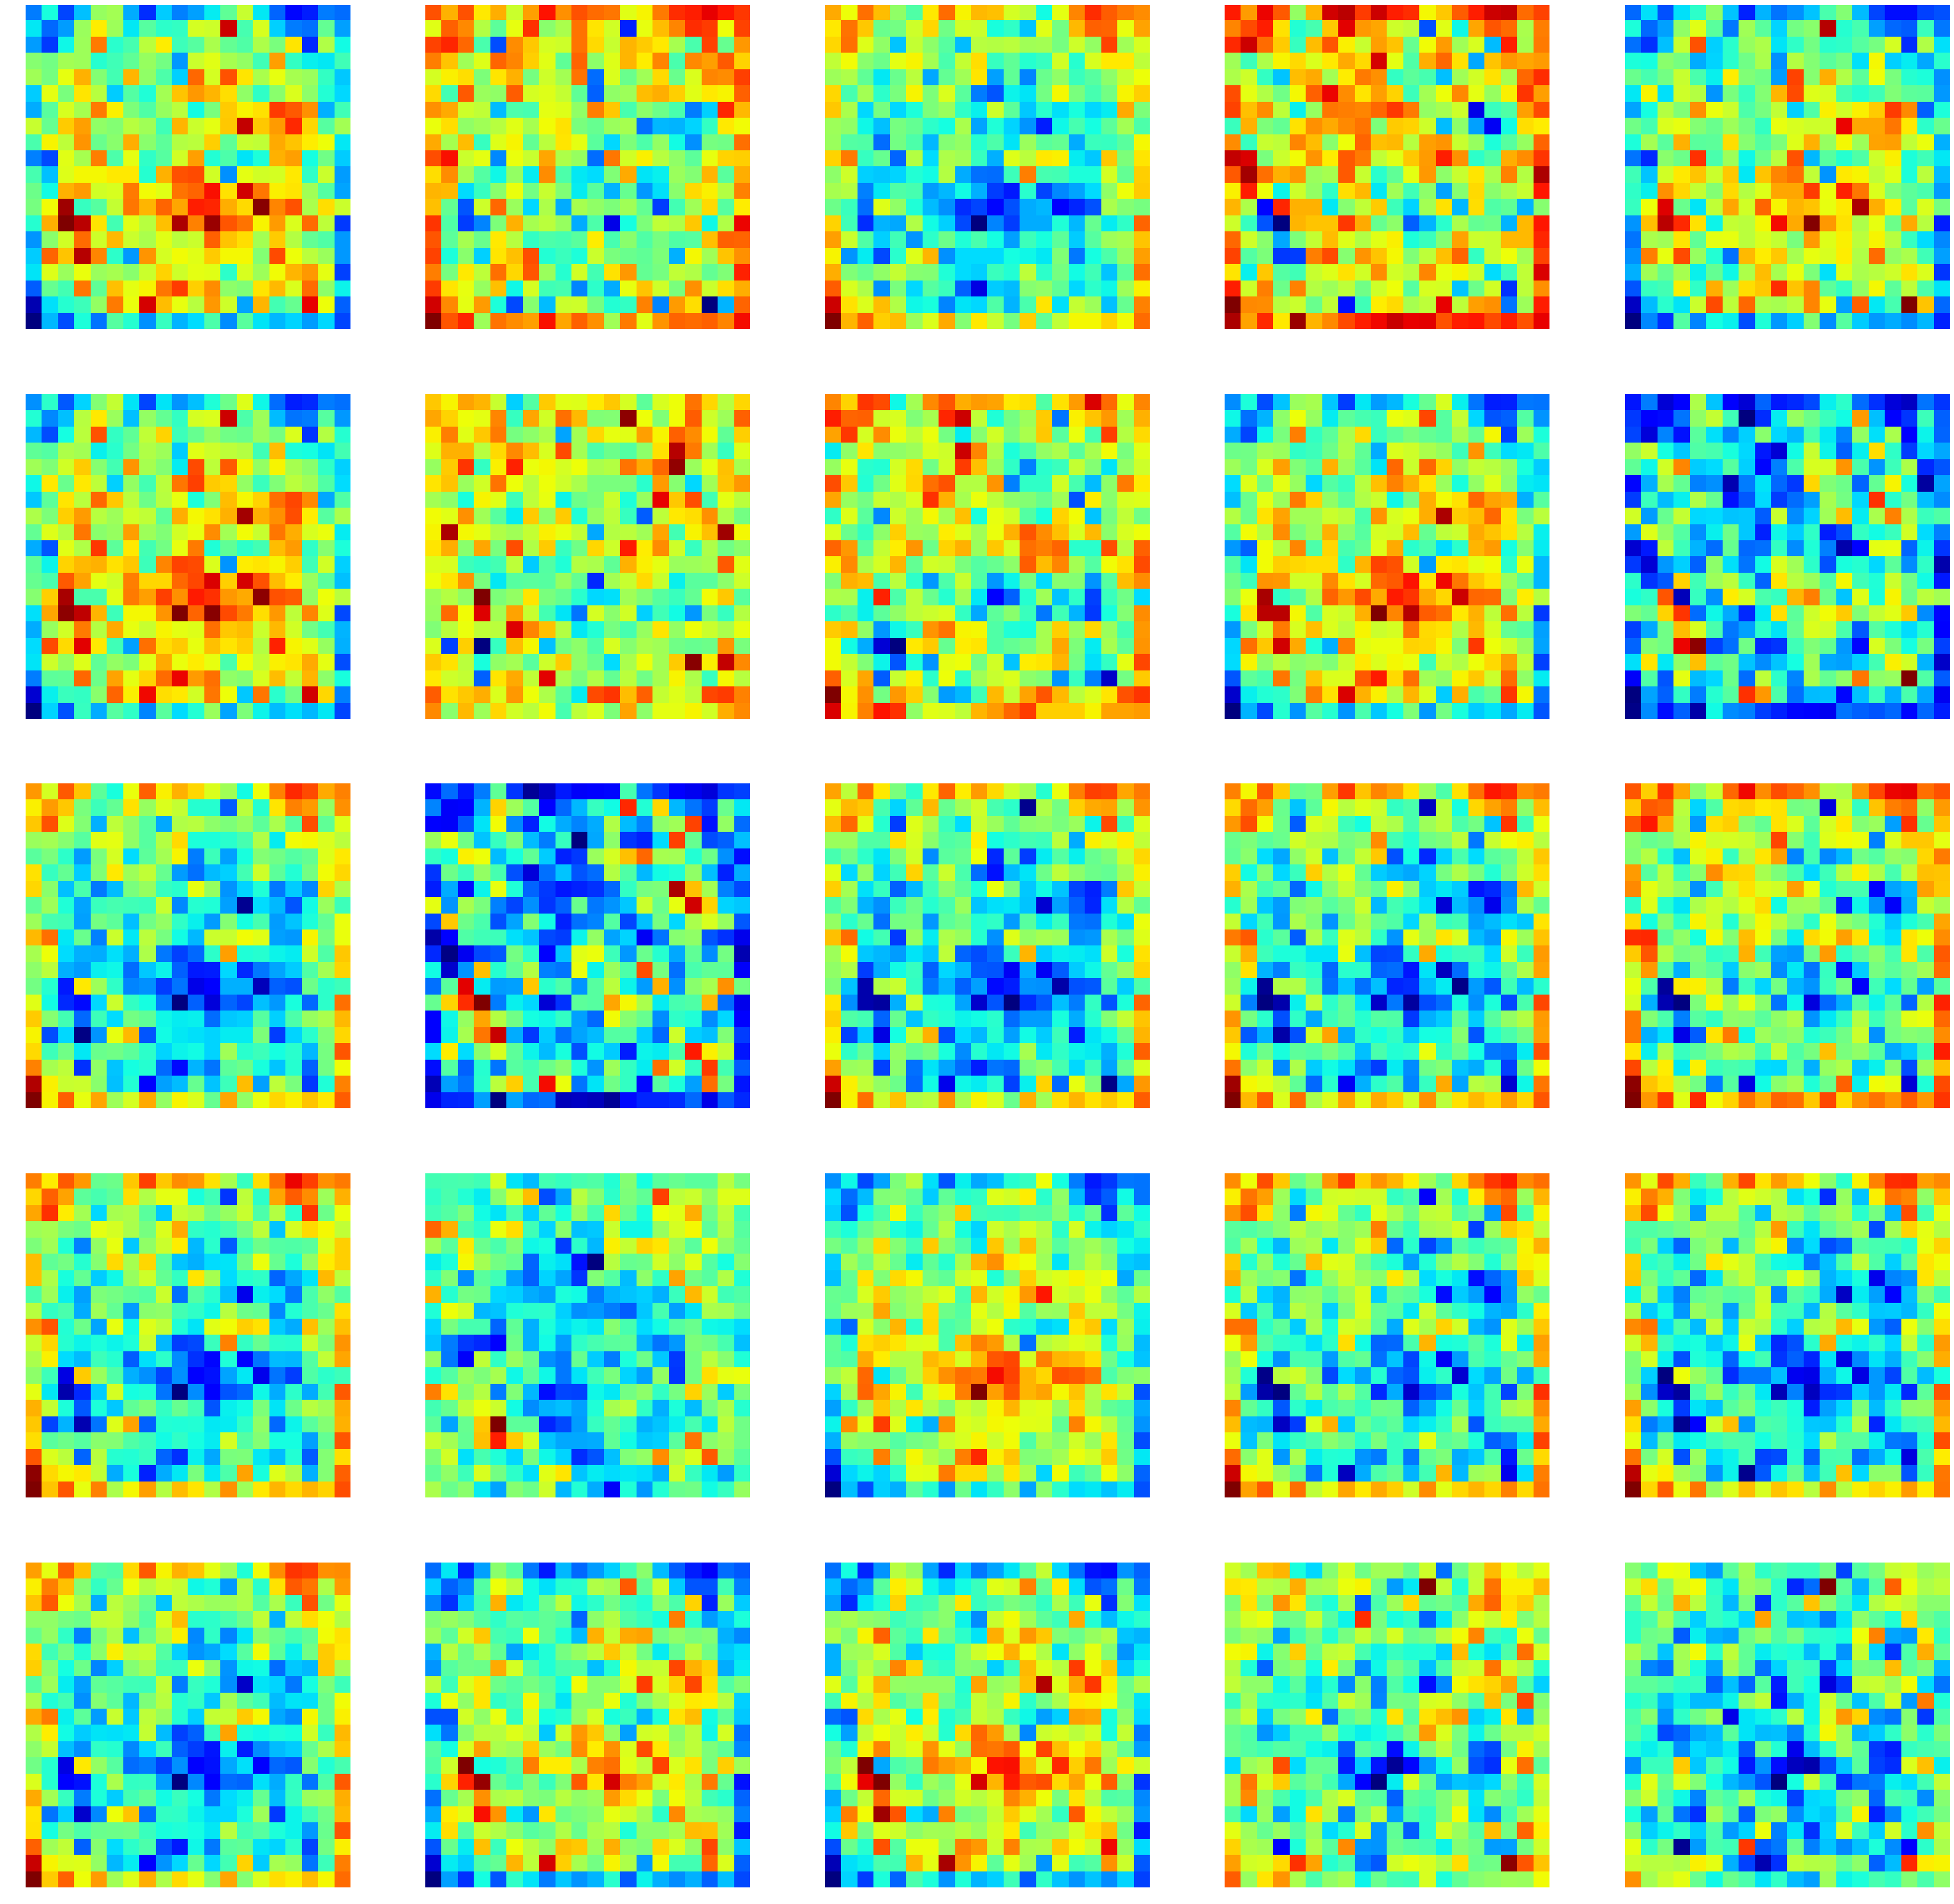

epoch 15, mean loss 7.935411850929261, std loss 0.05245248748557885


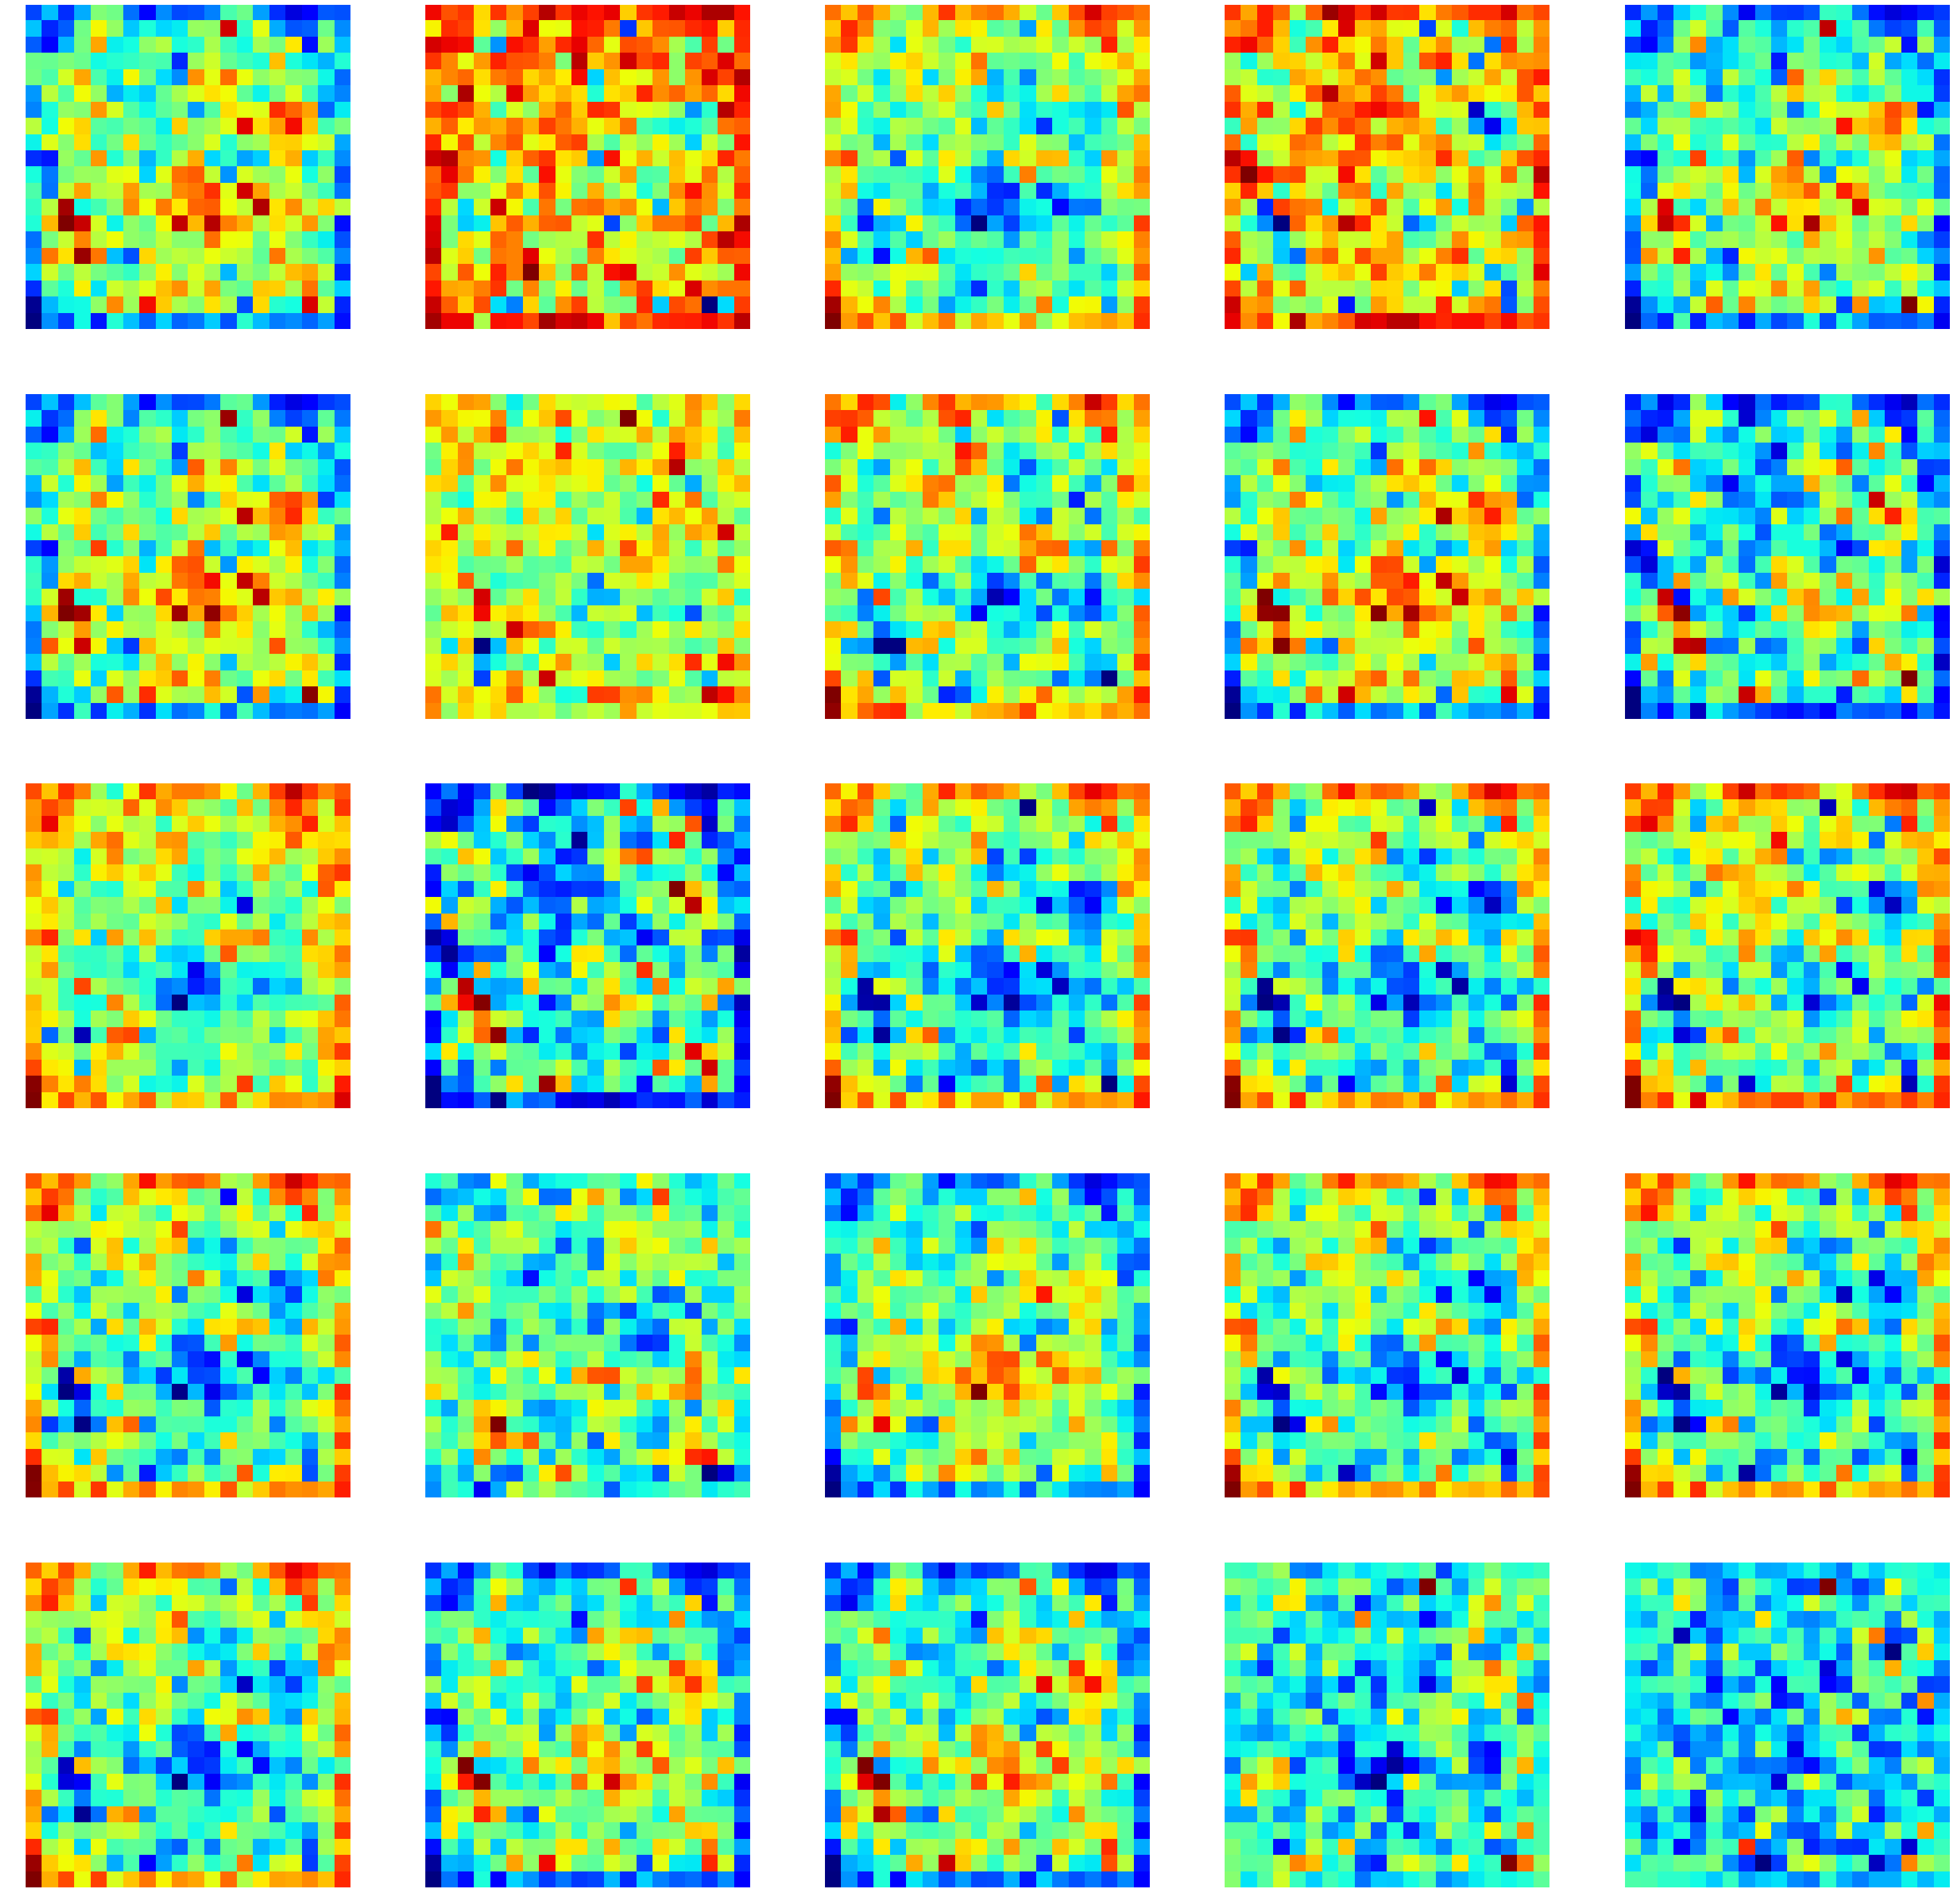

epoch 16, mean loss 7.936103927135467, std loss 0.051837191433443494


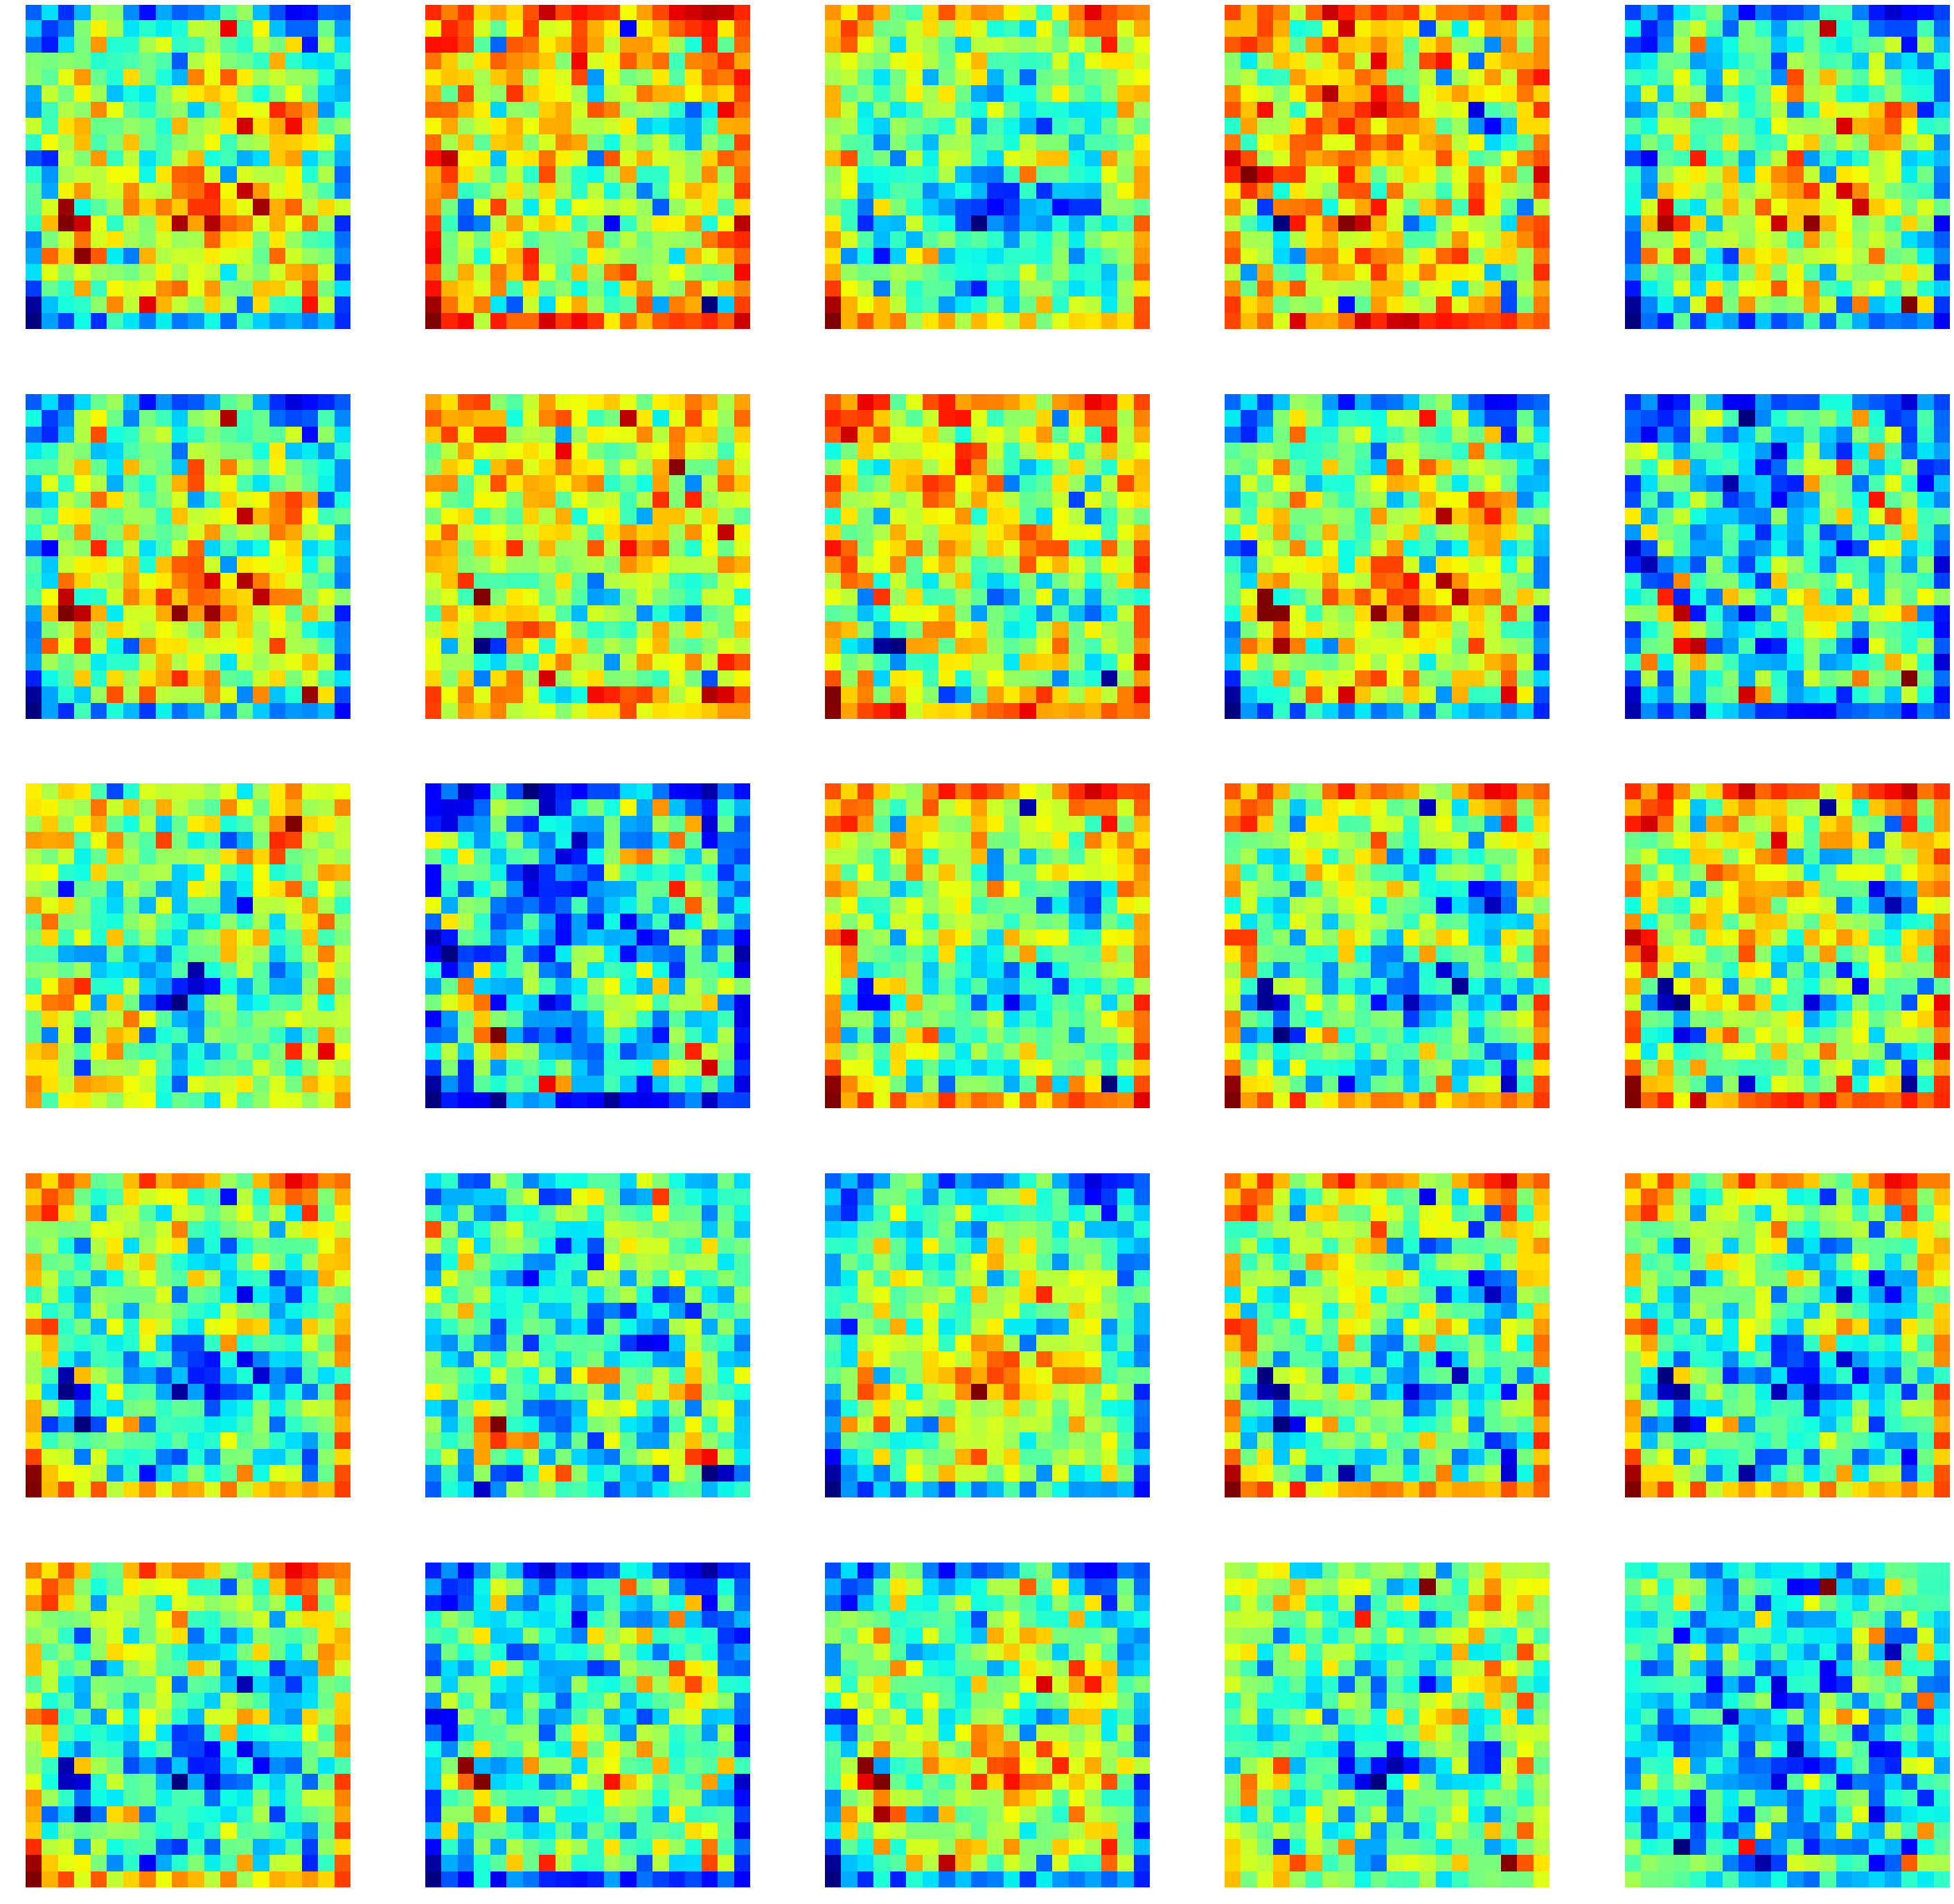

epoch 17, mean loss 7.936045858383179, std loss 0.05188314663976512


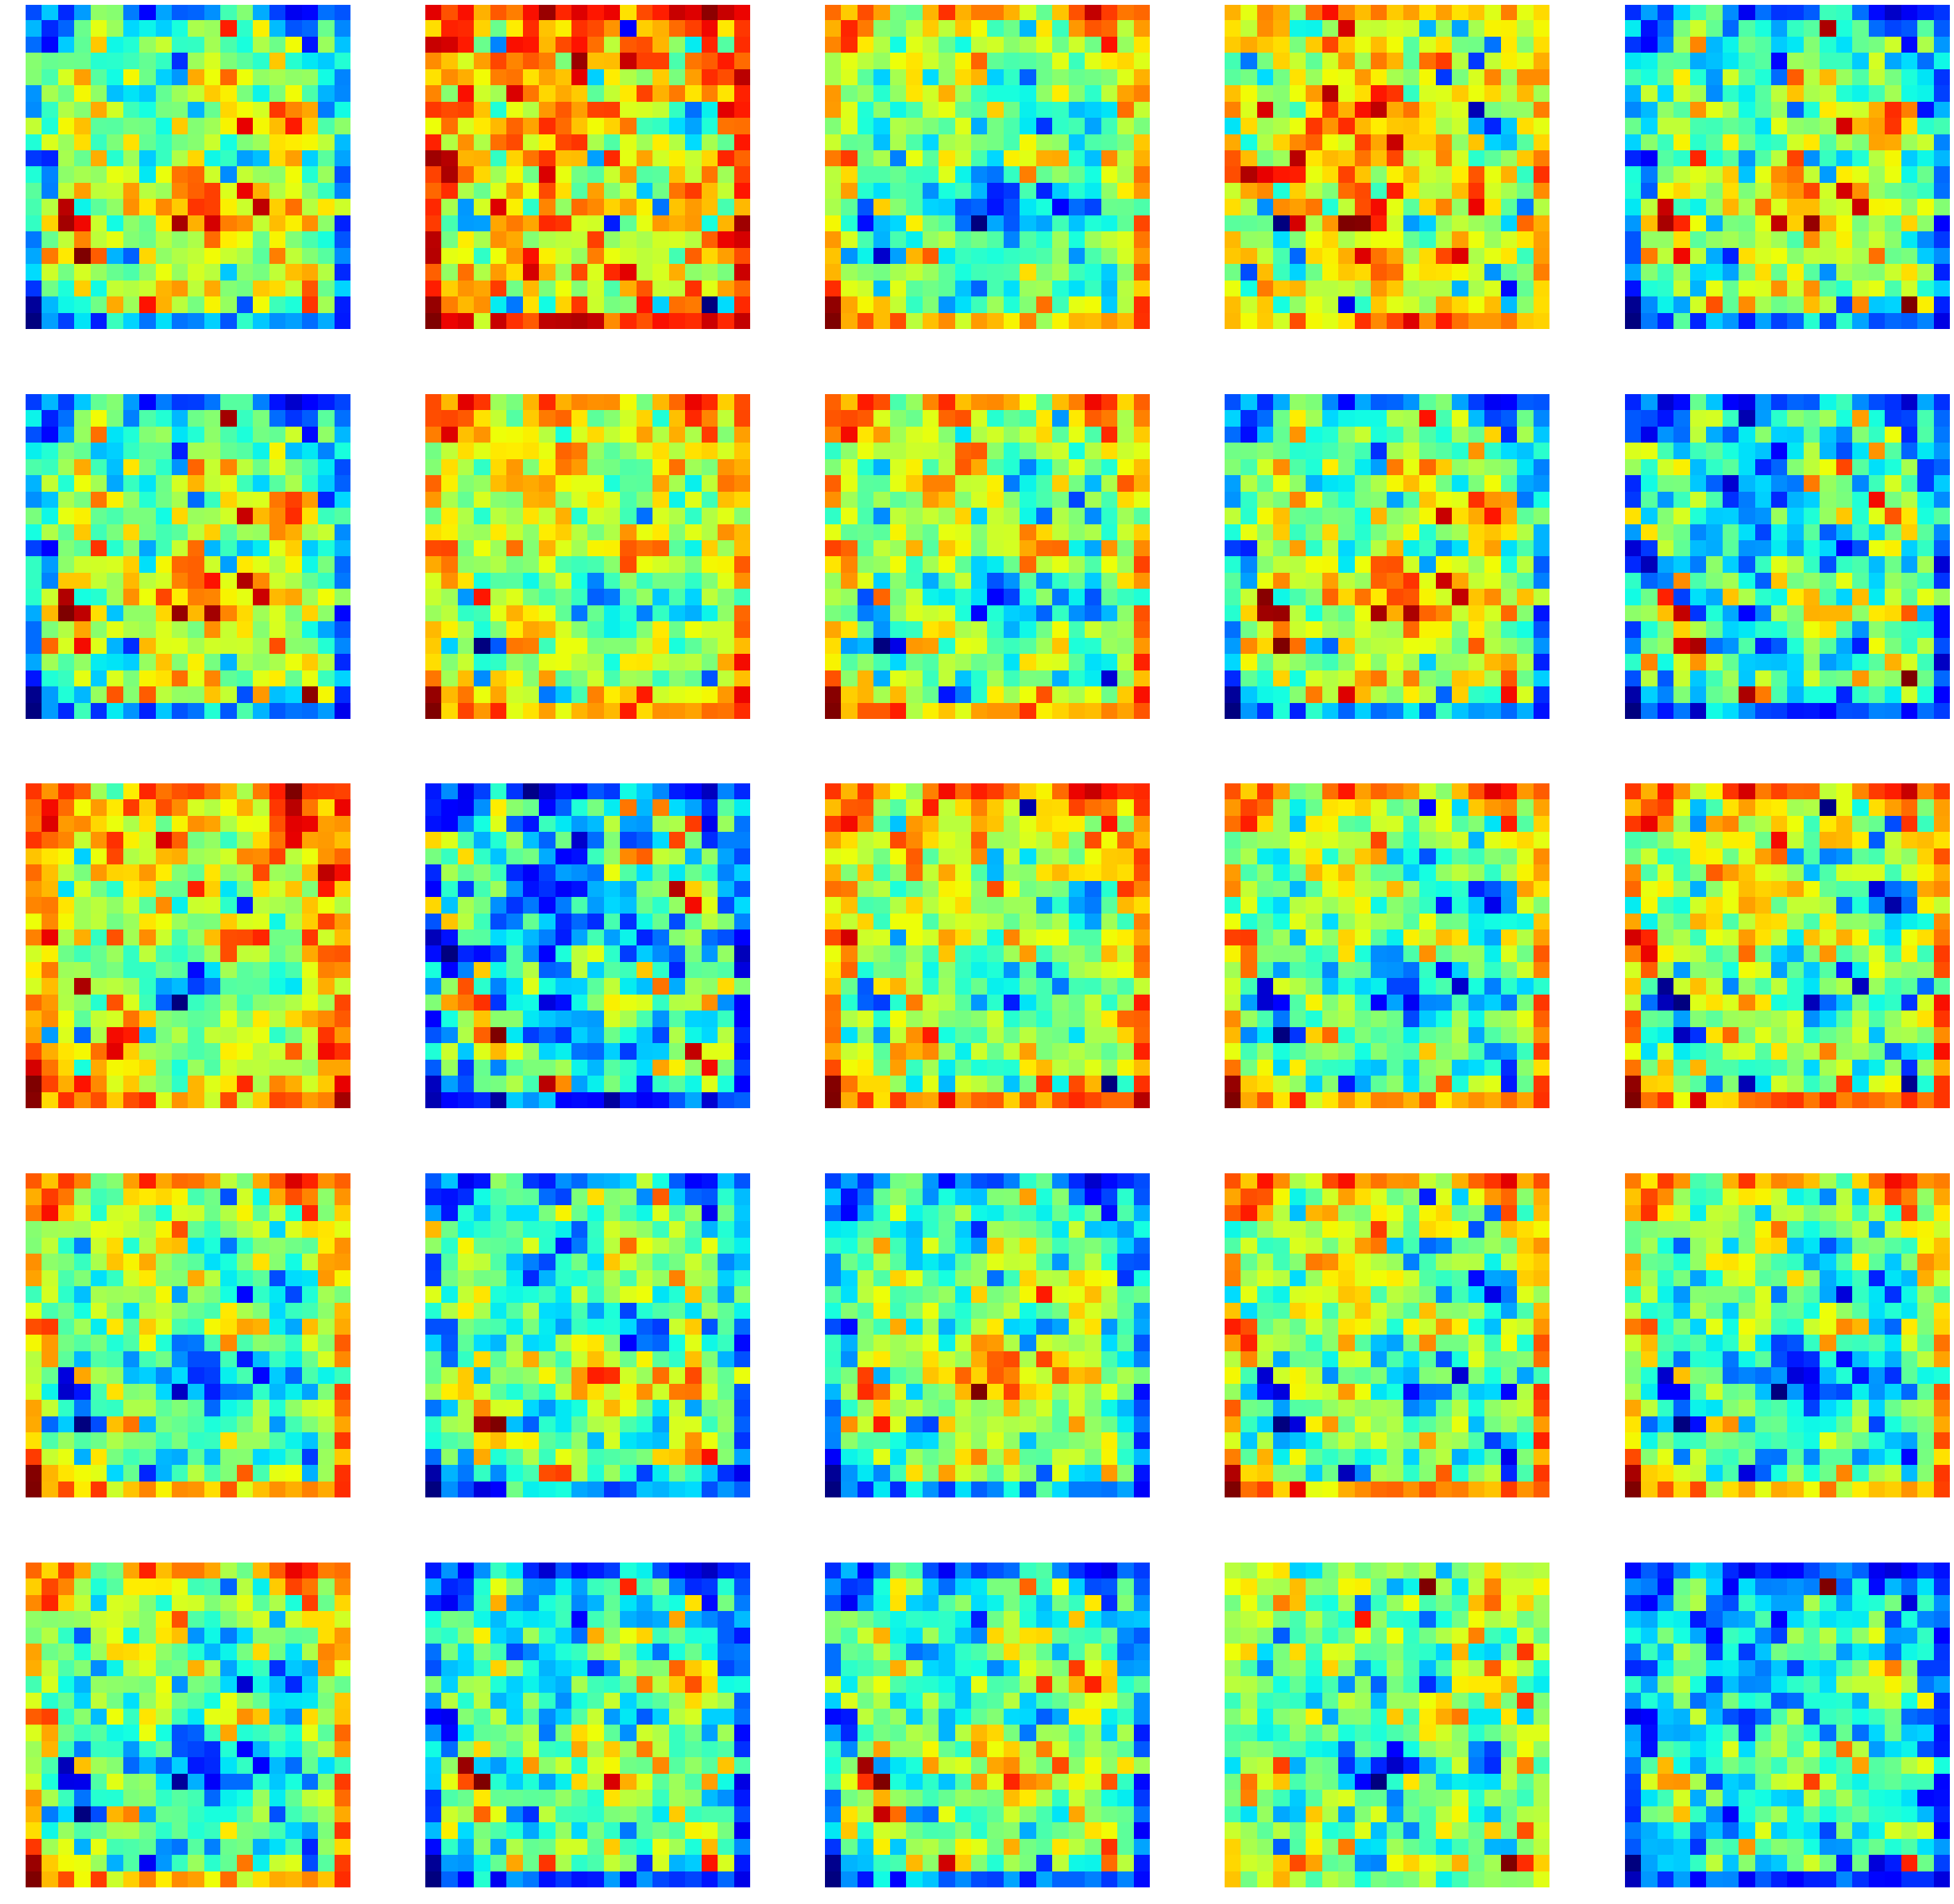

epoch 18, mean loss 7.935990832328796, std loss 0.0518819050383667


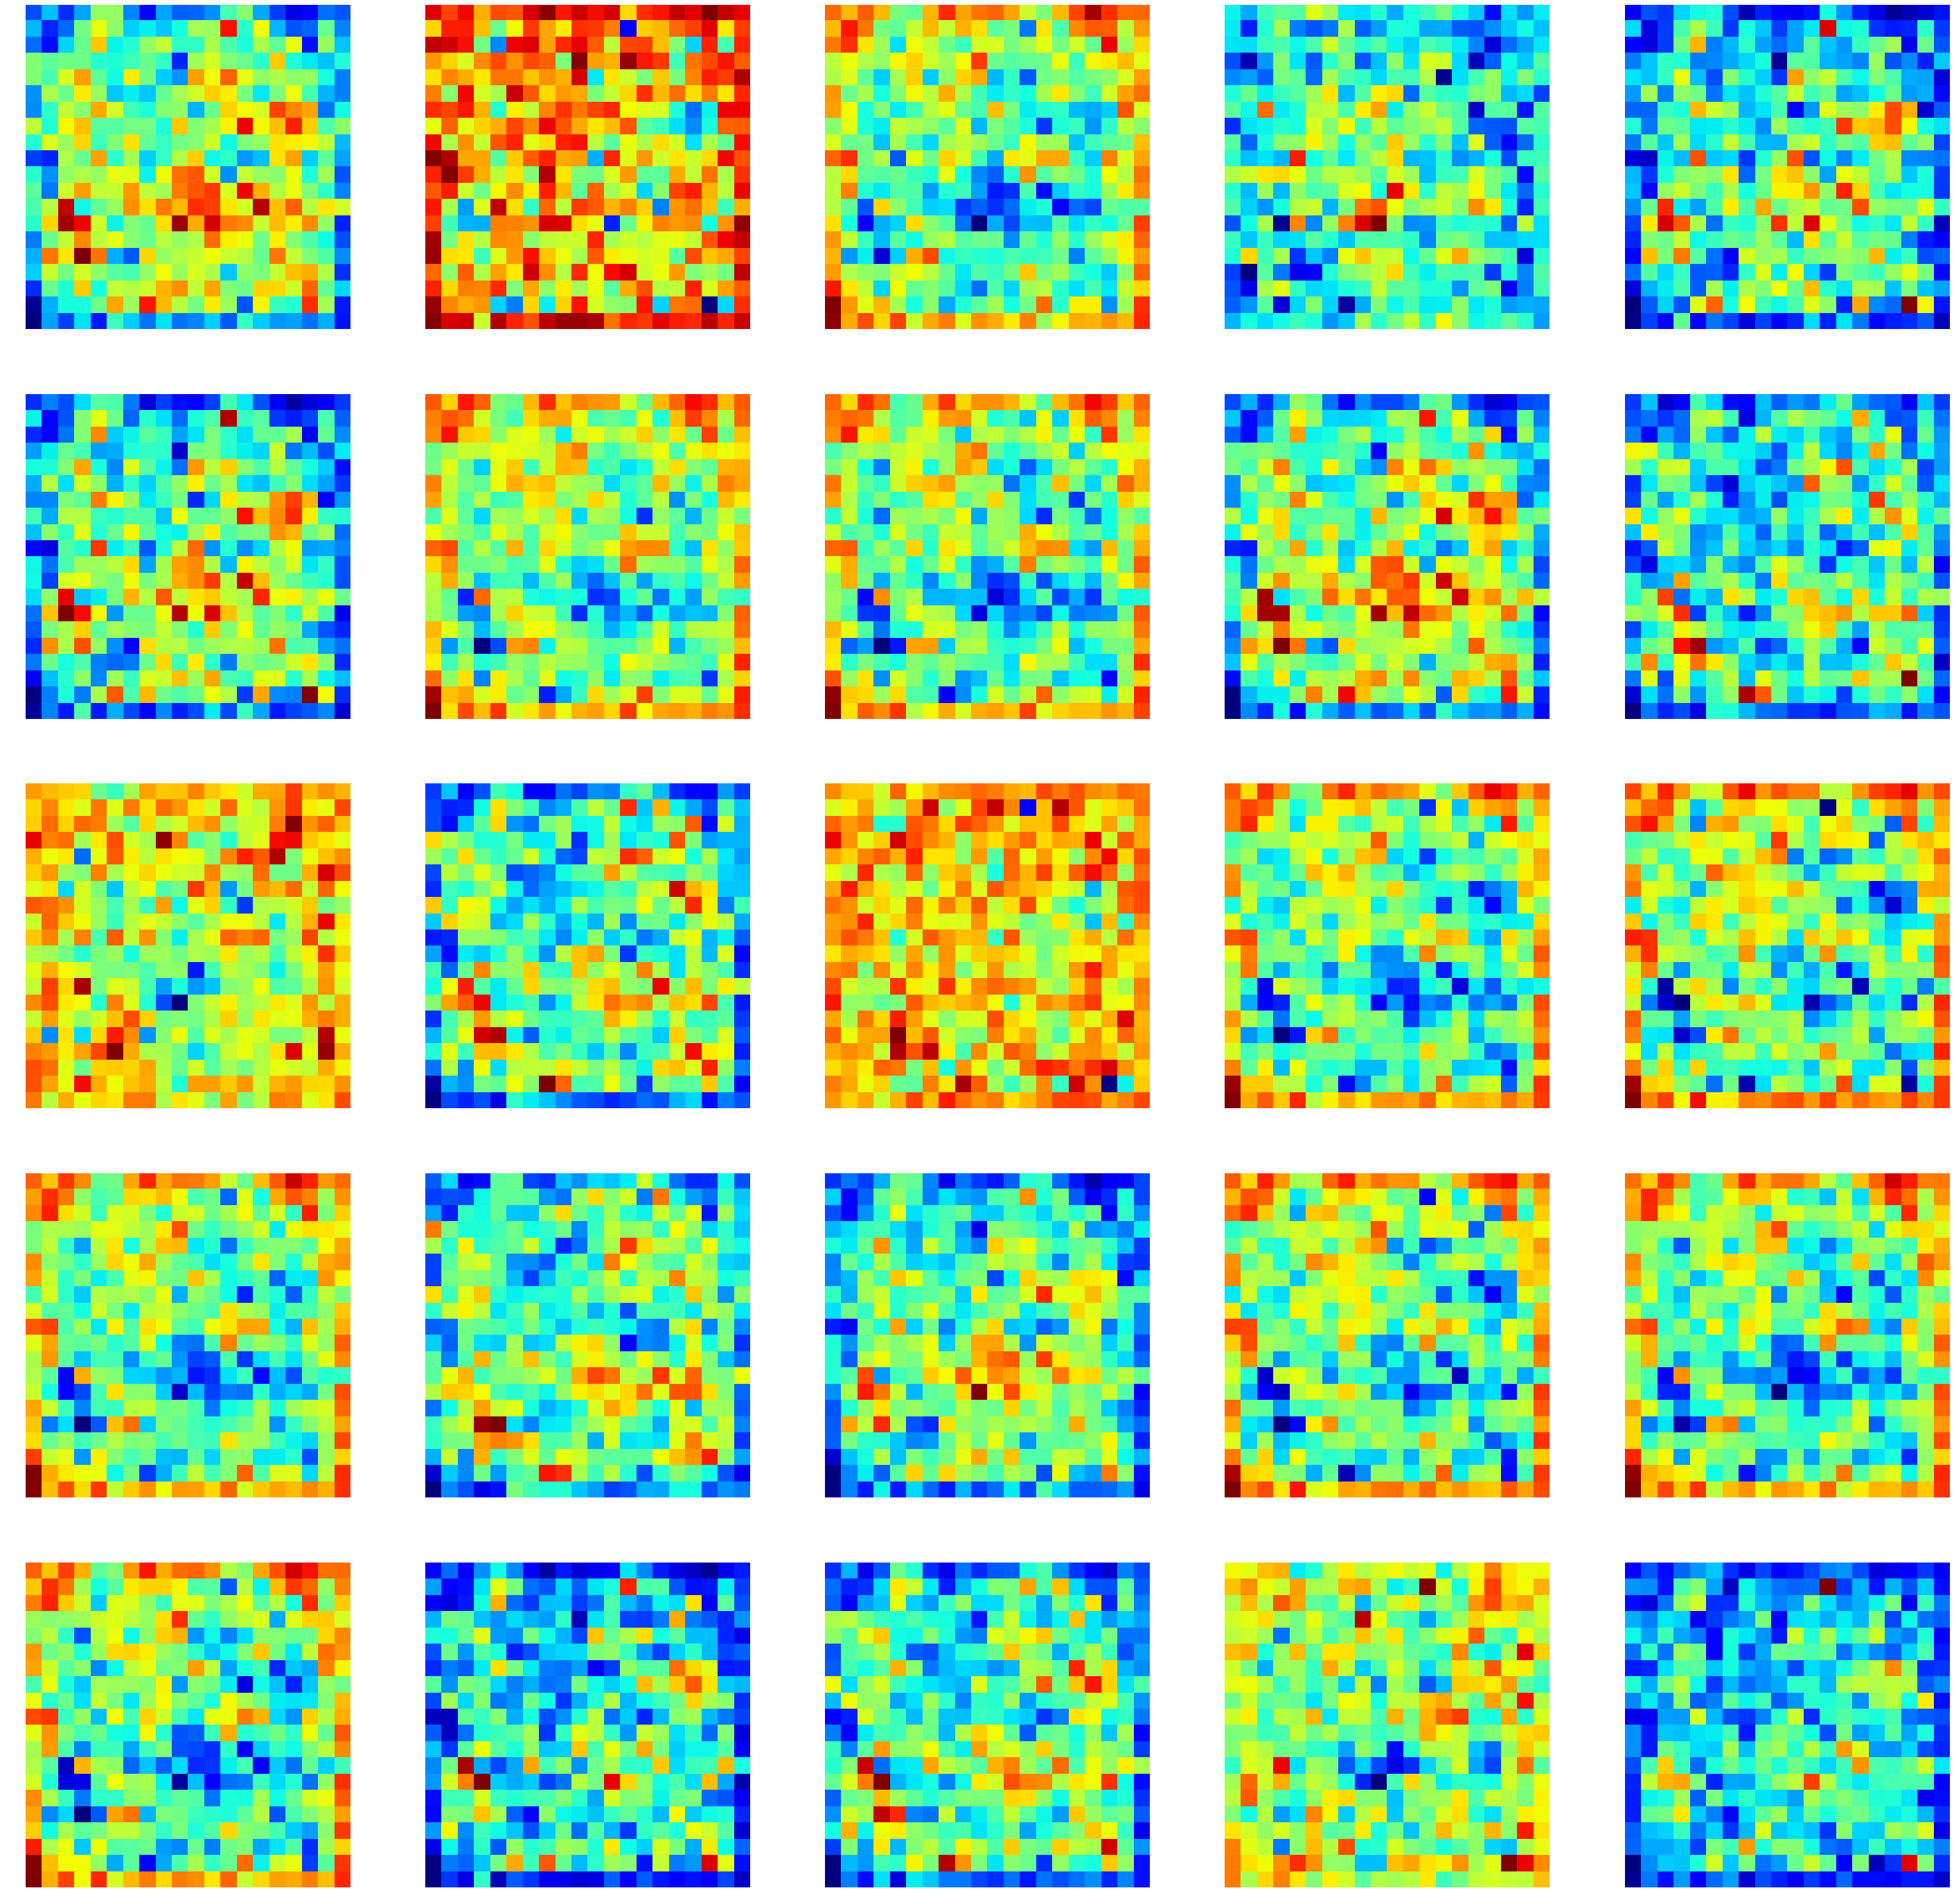

epoch 19, mean loss 7.936079367637634, std loss 0.051908449707898145


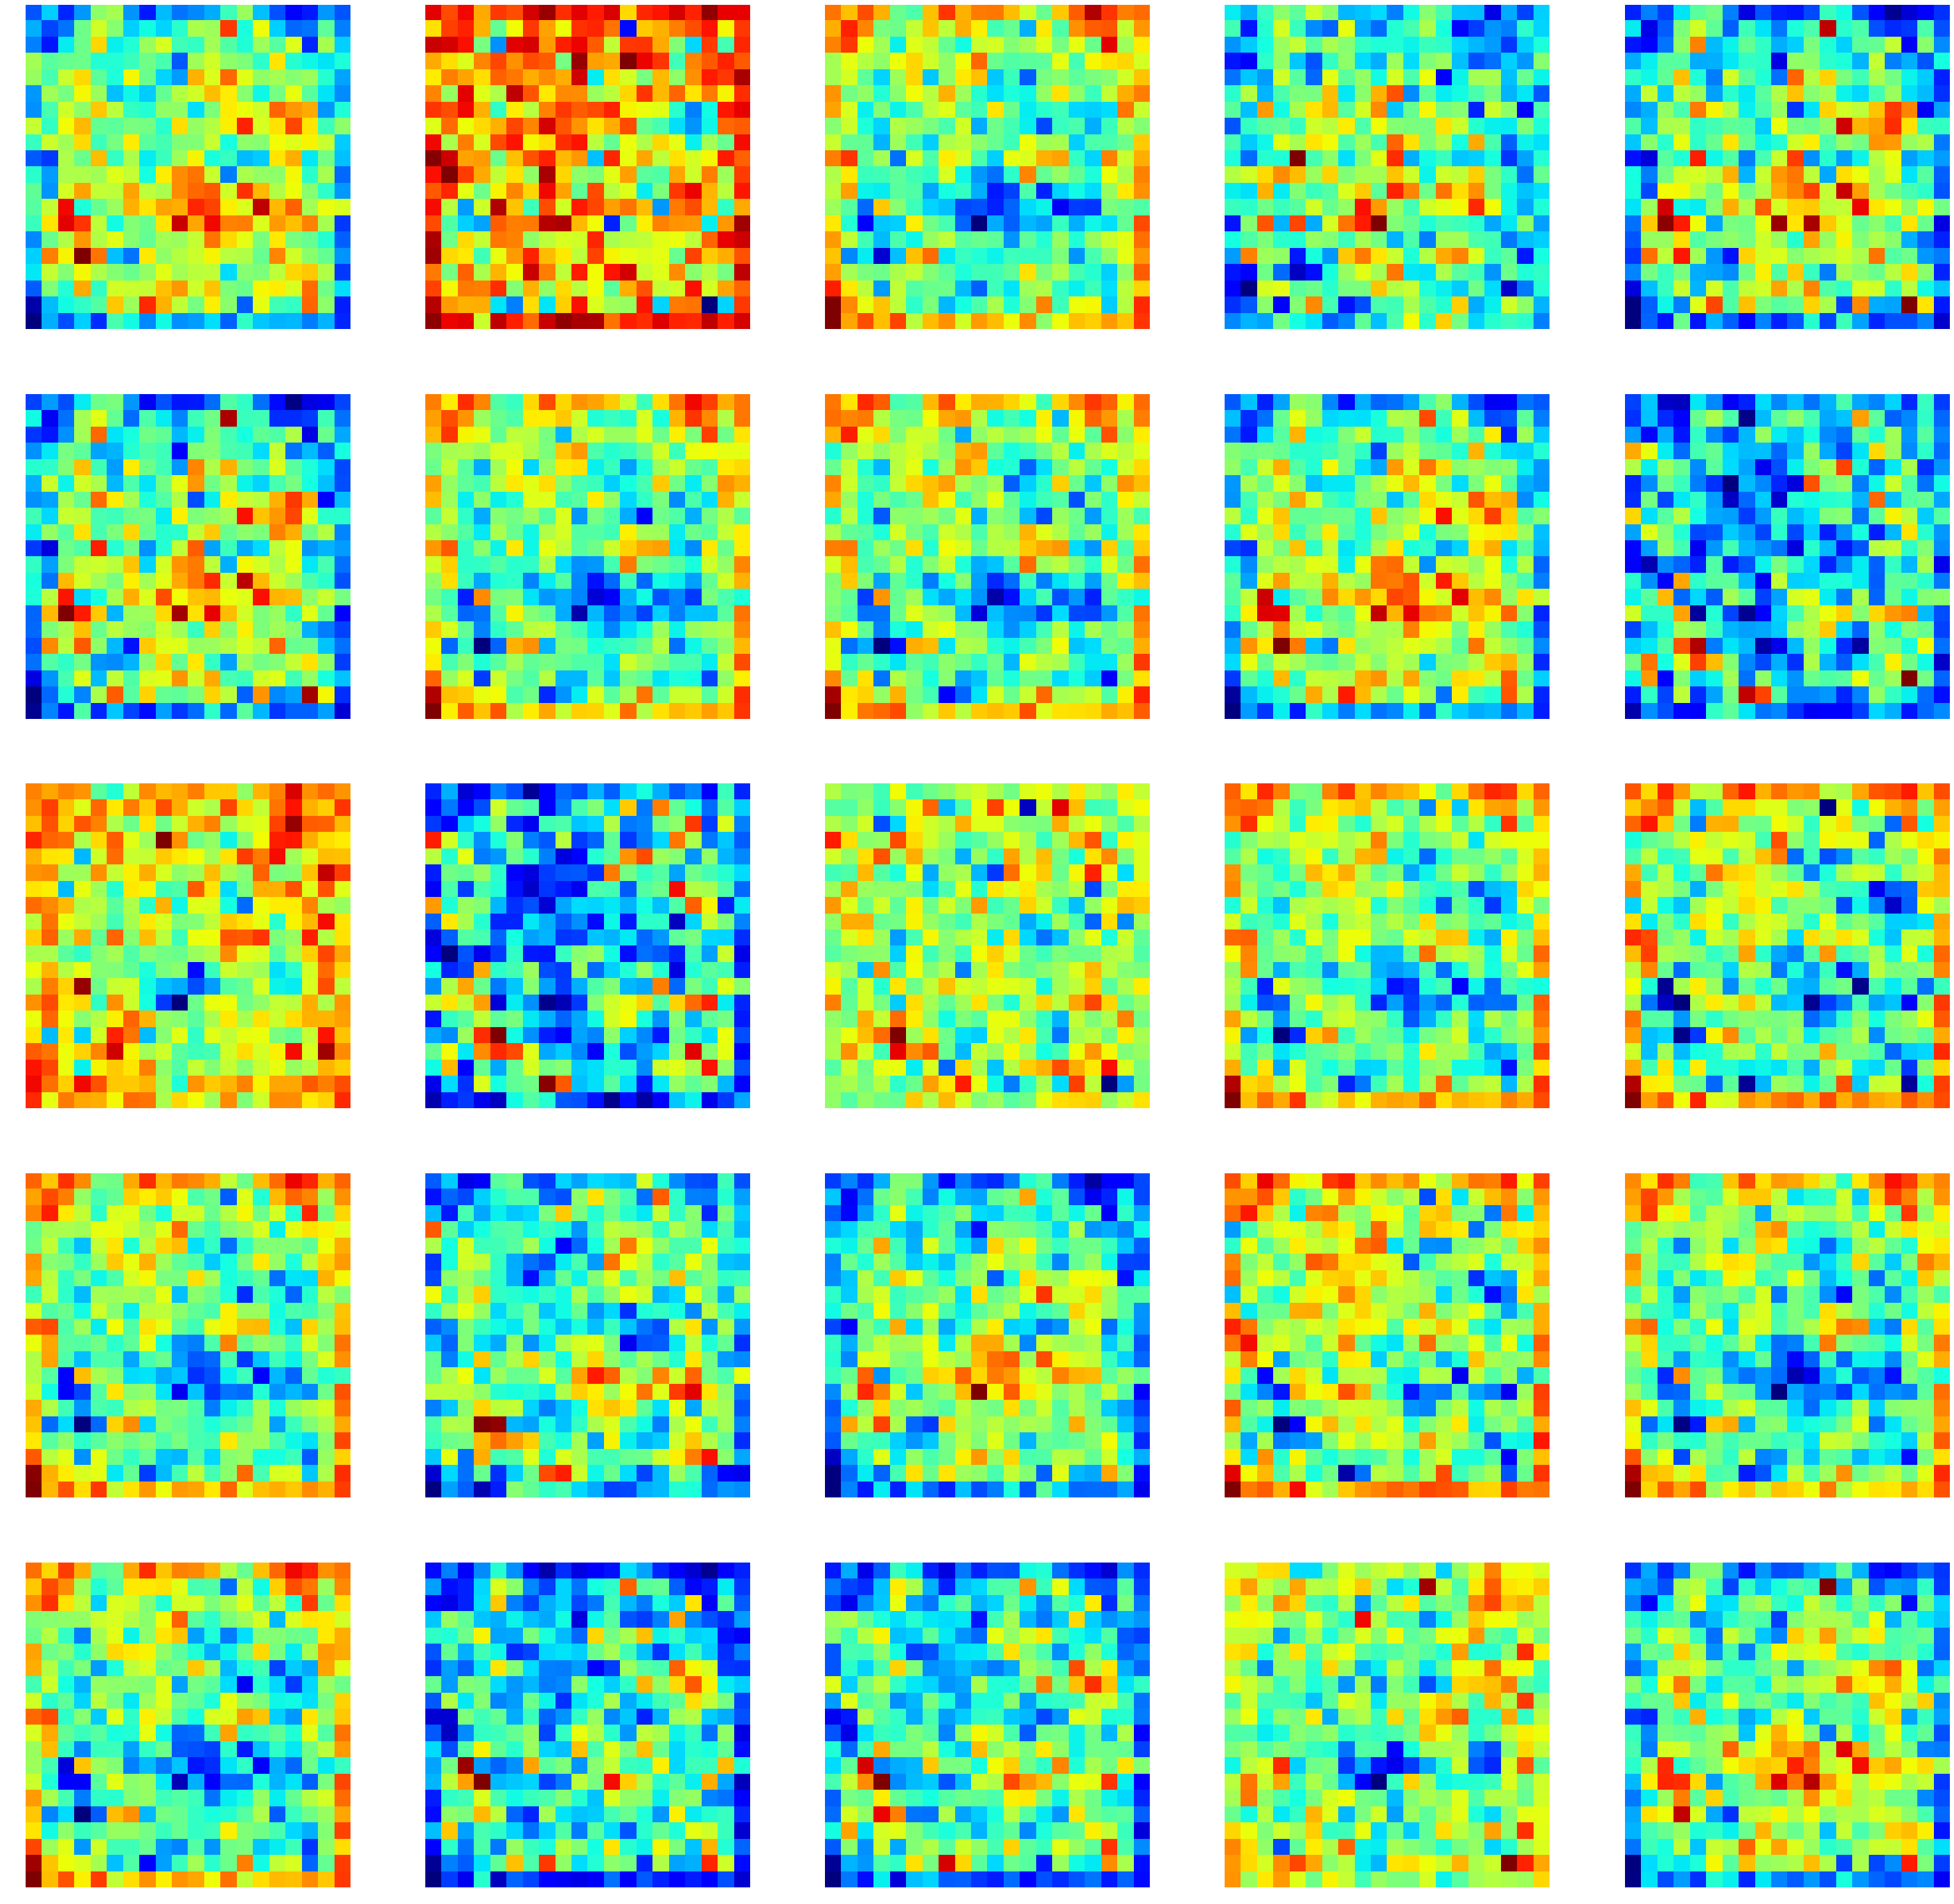

epoch 20, mean loss 7.935680666923523, std loss 0.051838674781411145


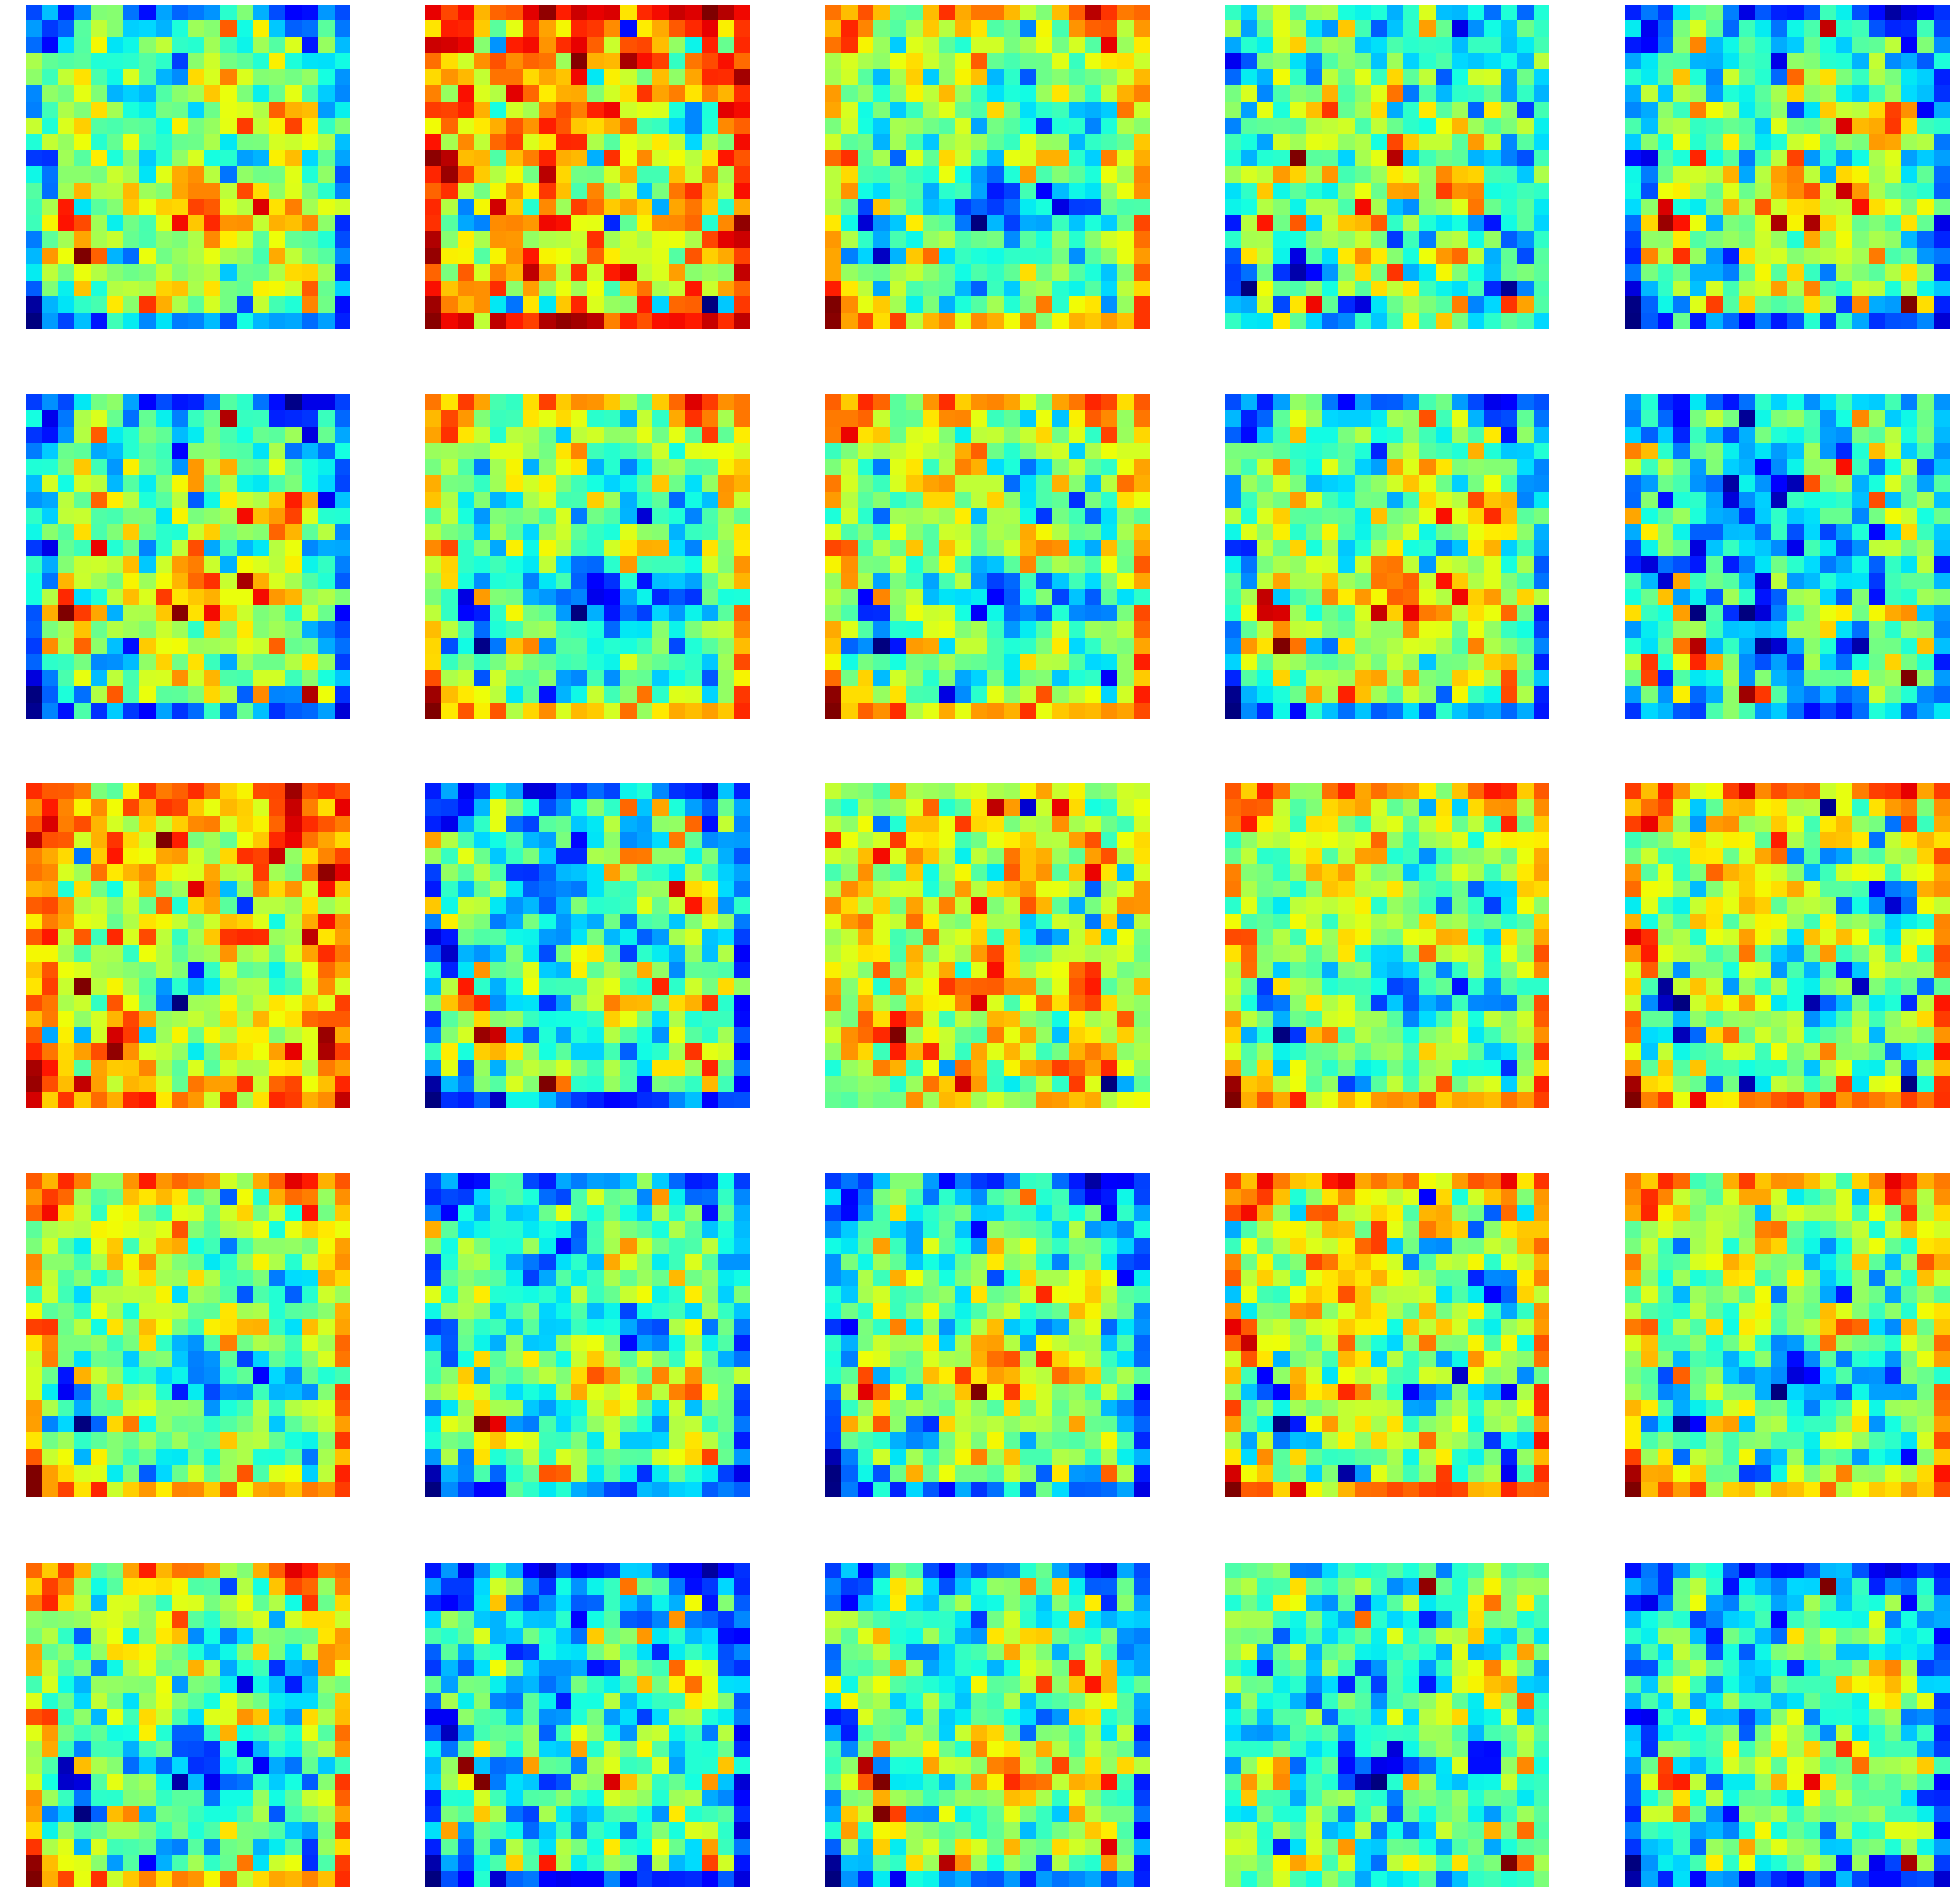

epoch 21, mean loss 7.9358551368713375, std loss 0.05220775007833382


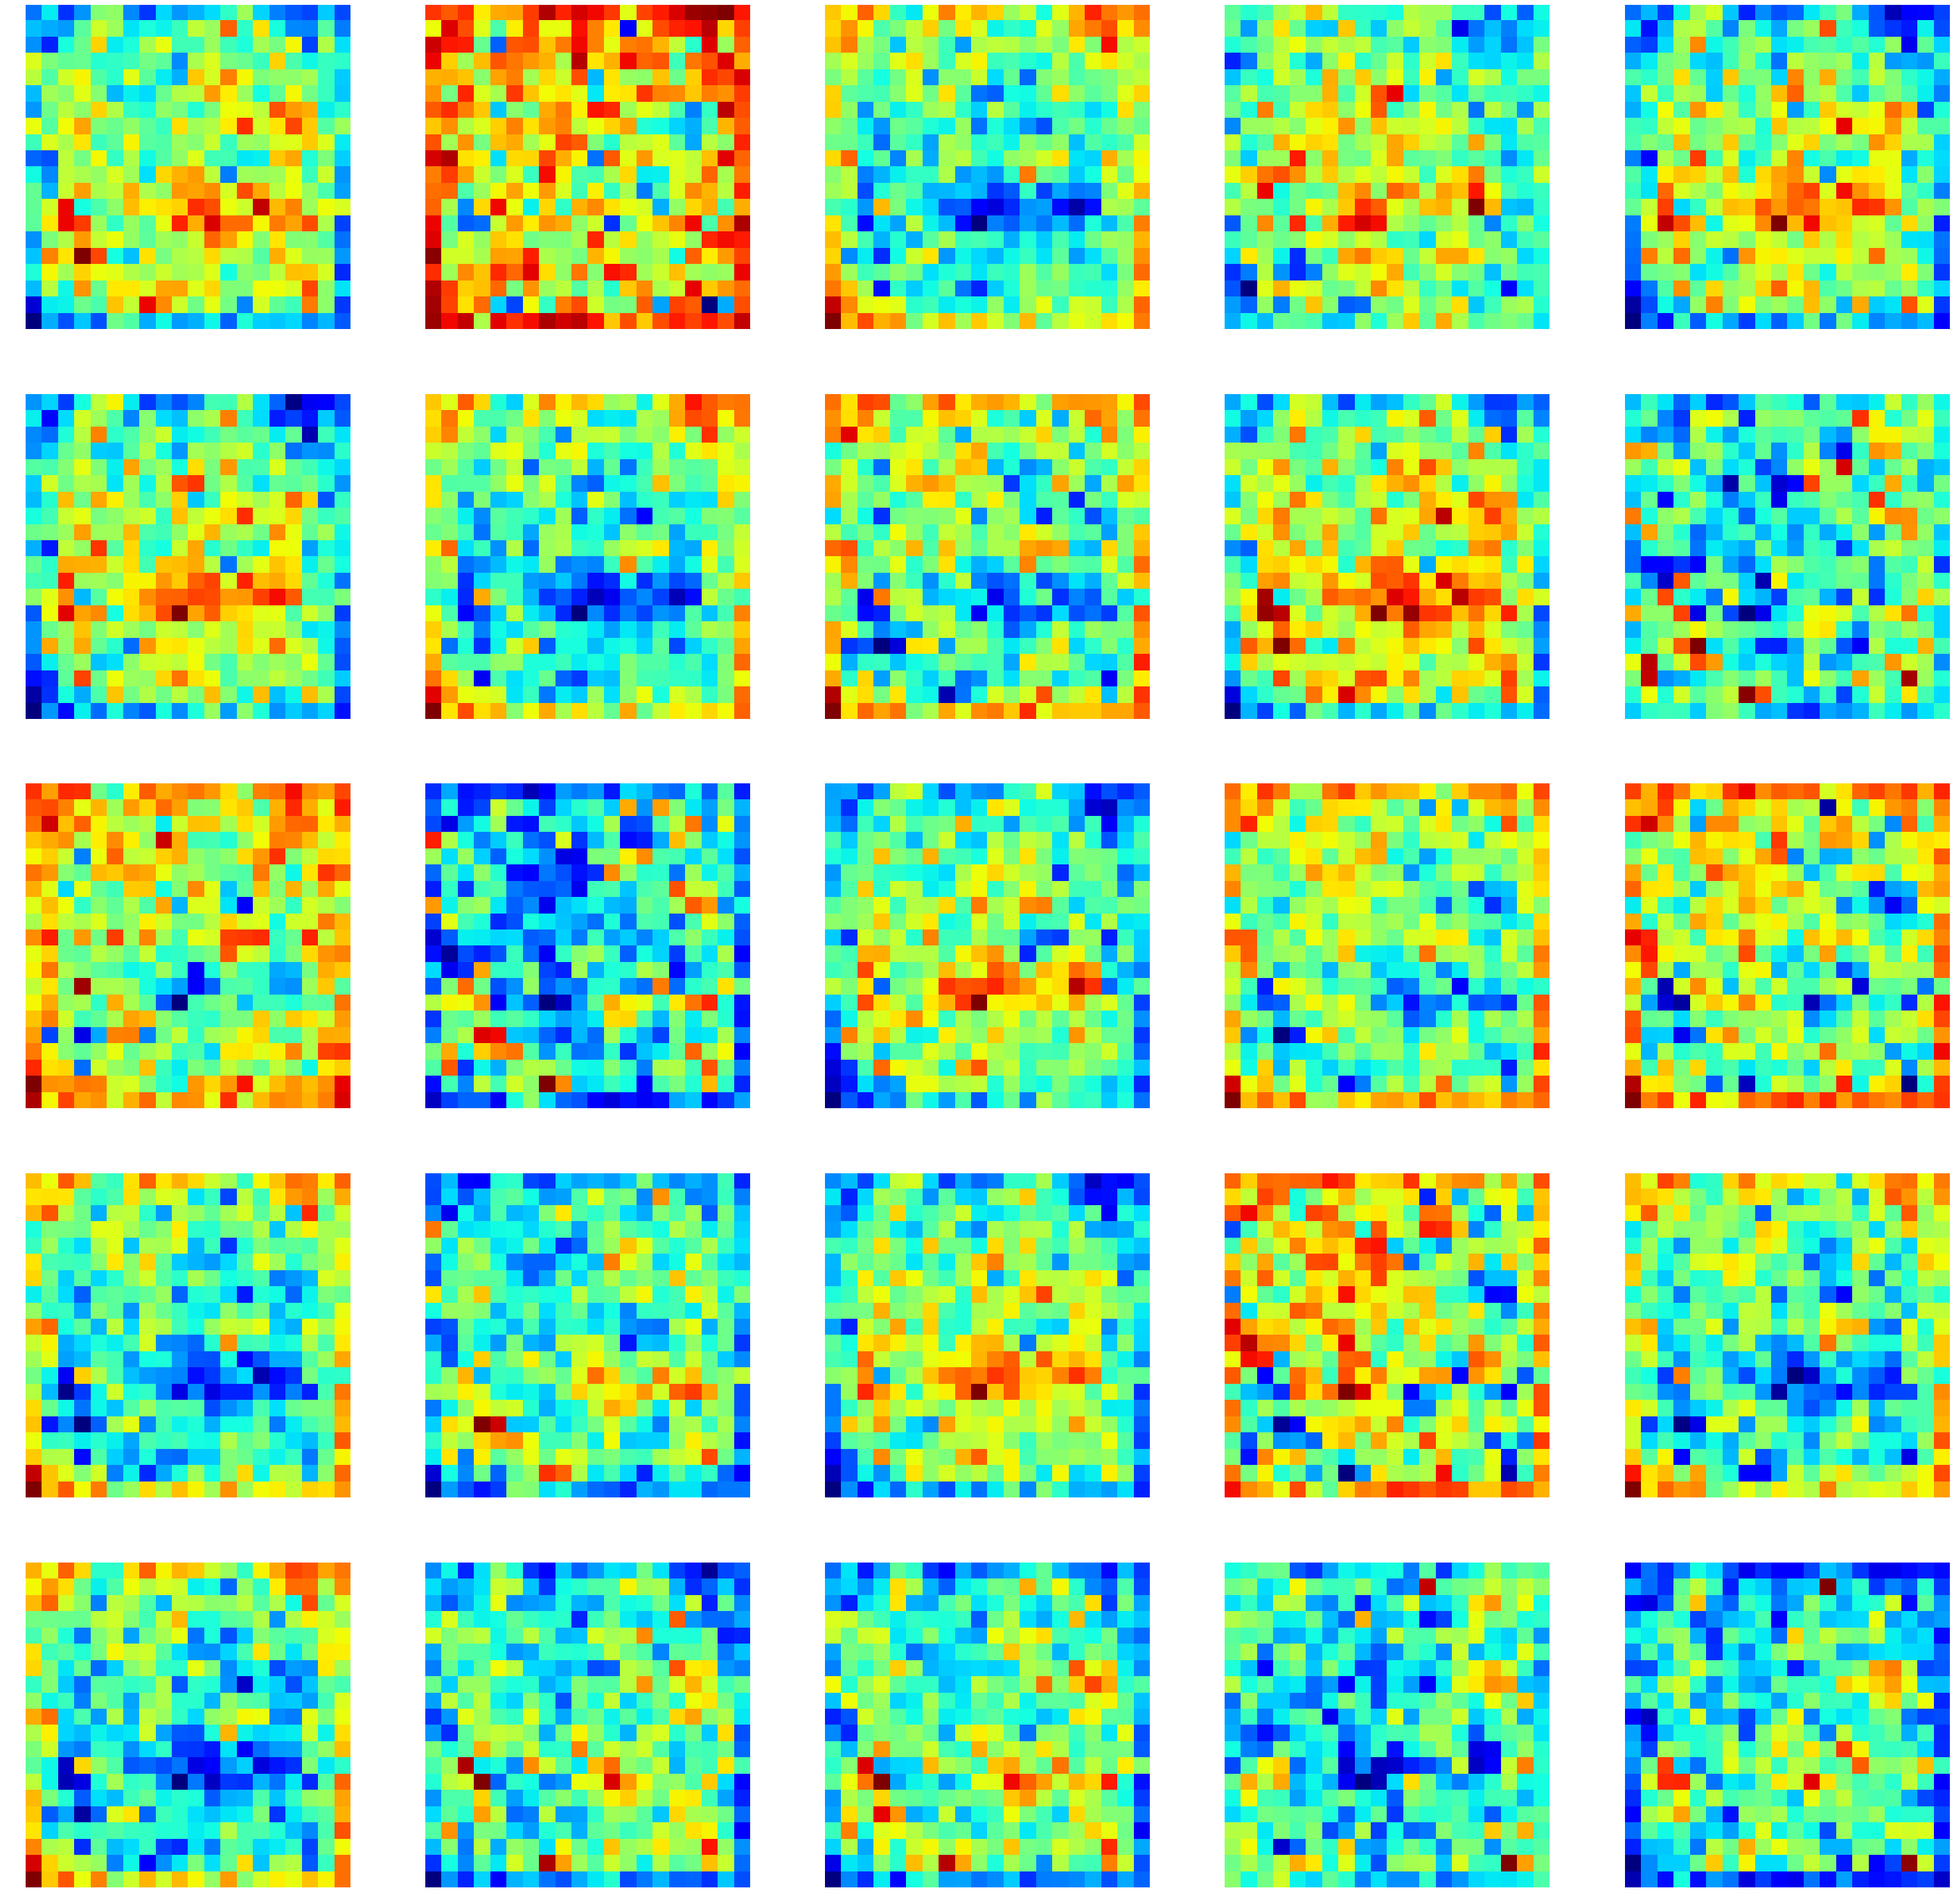

epoch 22, mean loss 7.936033983707428, std loss 0.05168418161420535


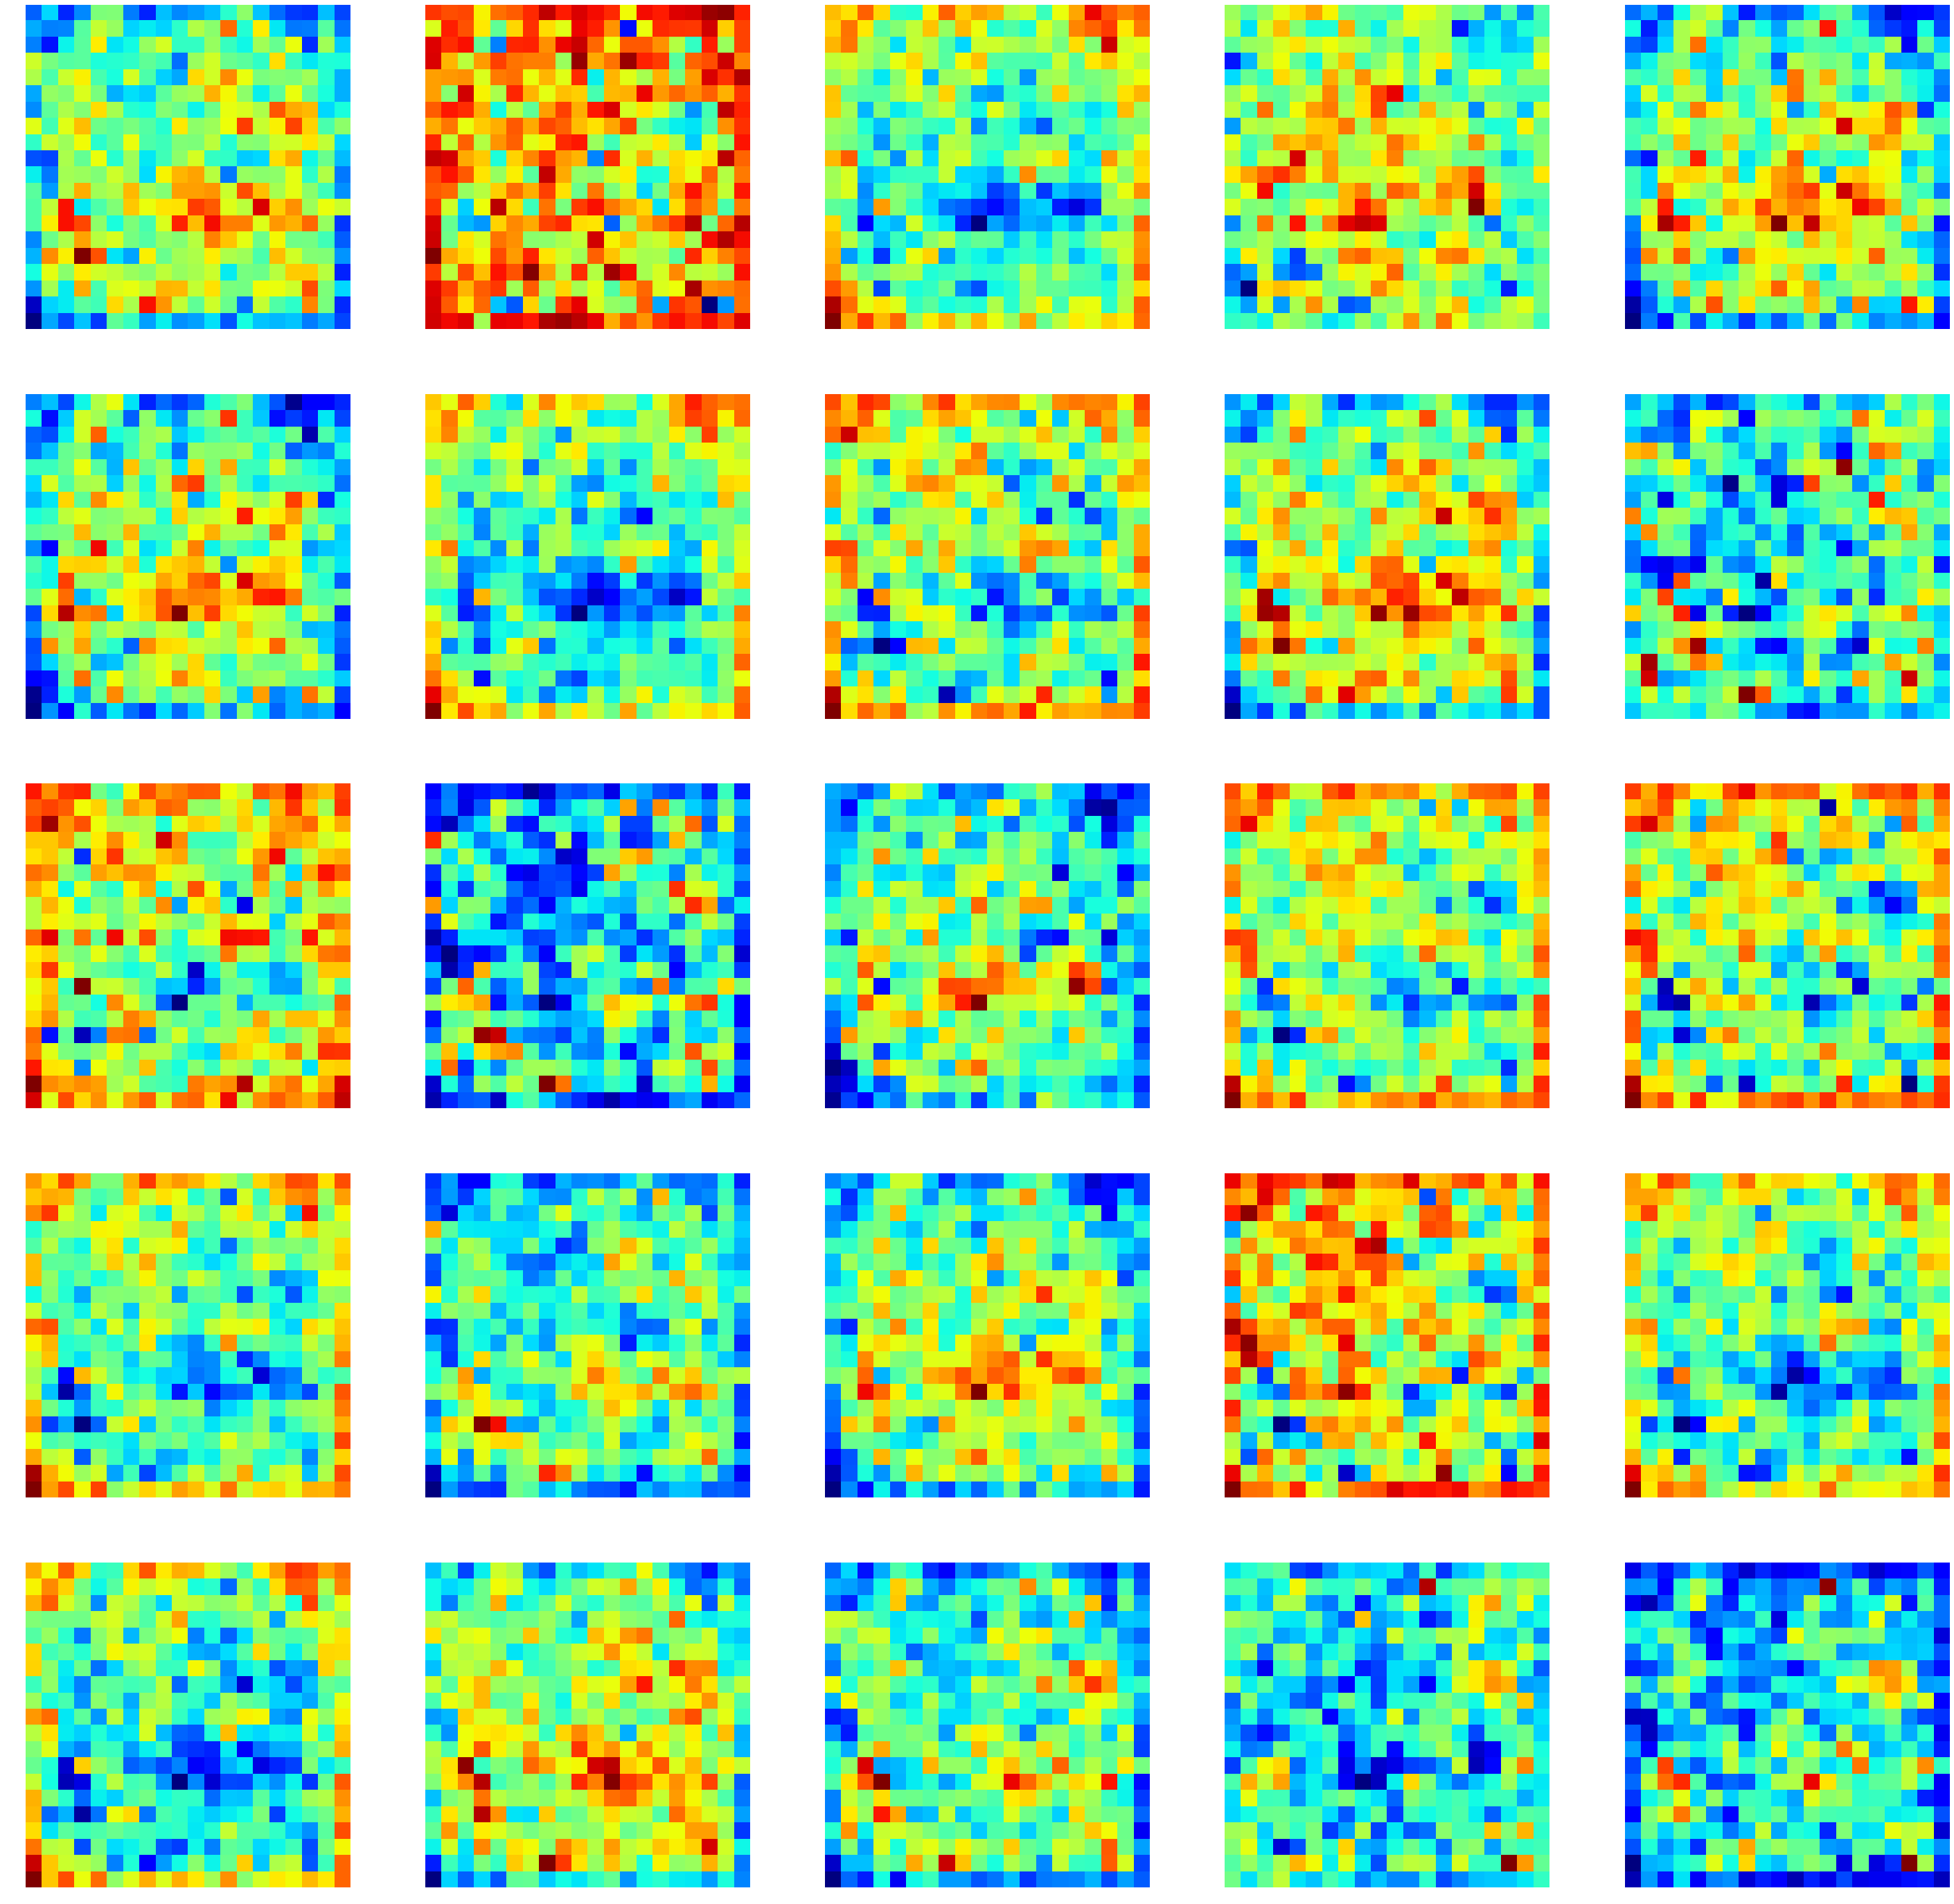

epoch 23, mean loss 7.936898315906524, std loss 0.05193935689086226


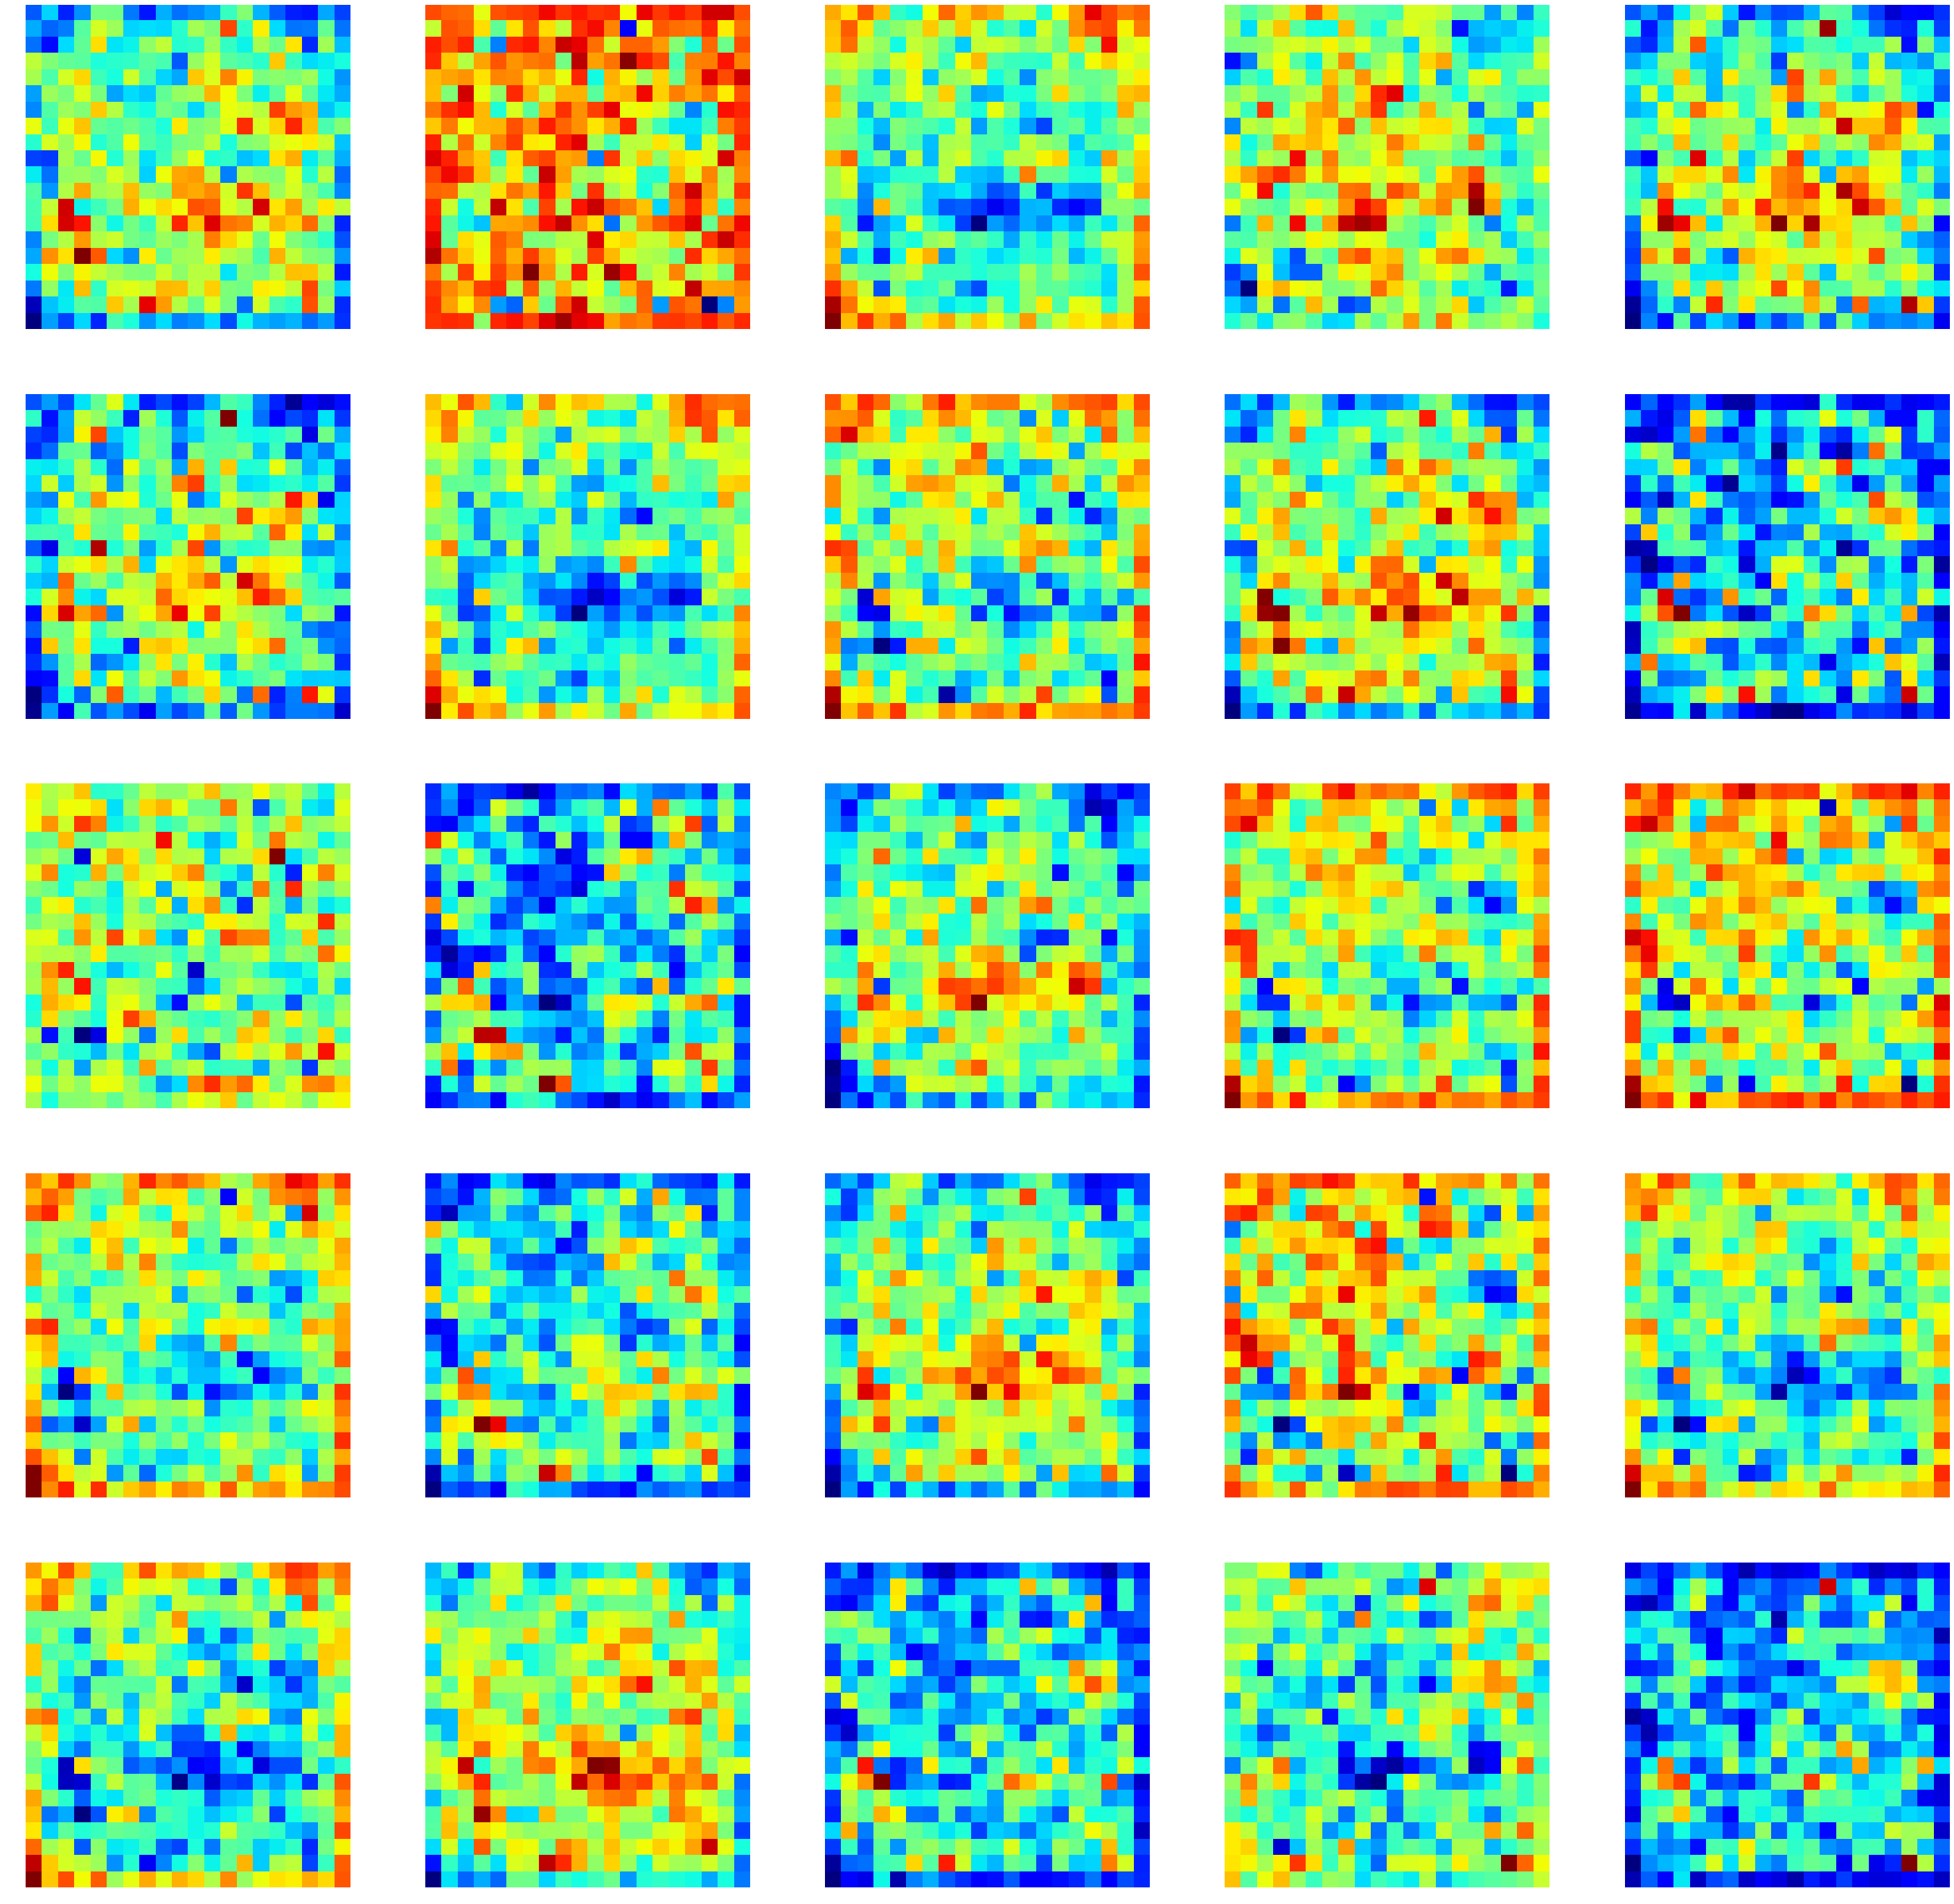

epoch 24, mean loss 7.936453313350677, std loss 0.05264680322125123


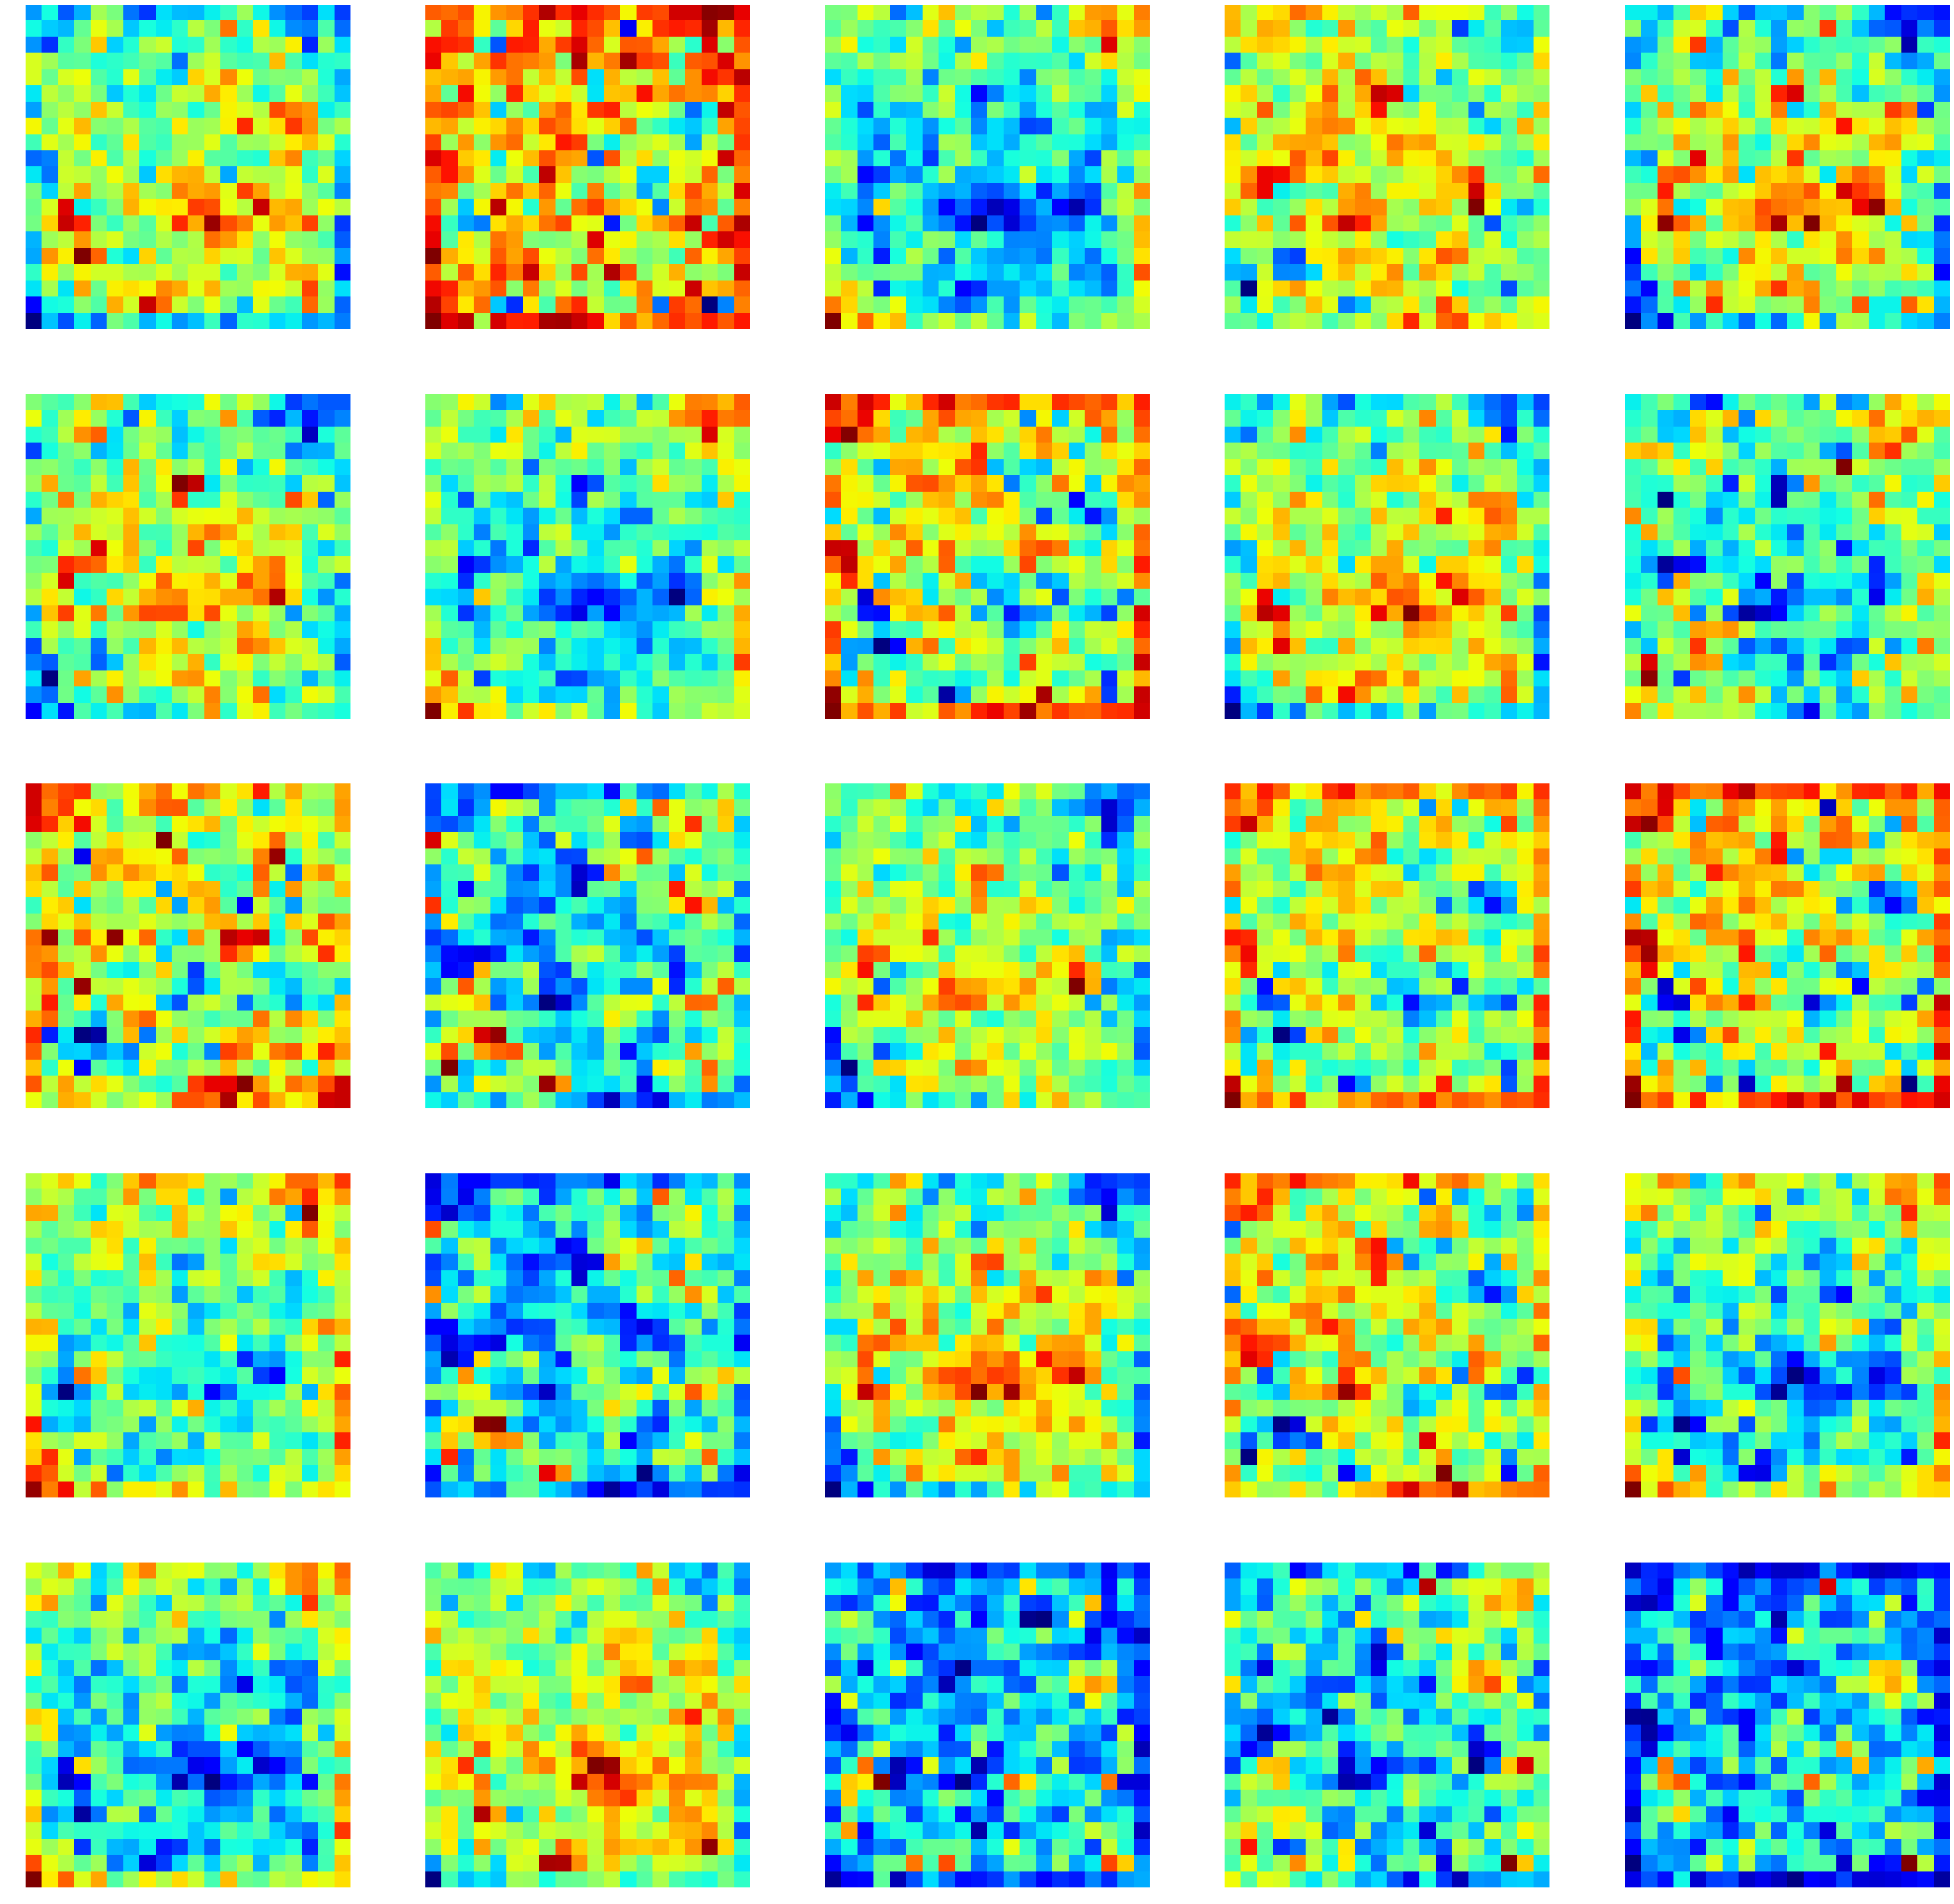

epoch 25, mean loss 7.937359683990478, std loss 0.05186659162935304


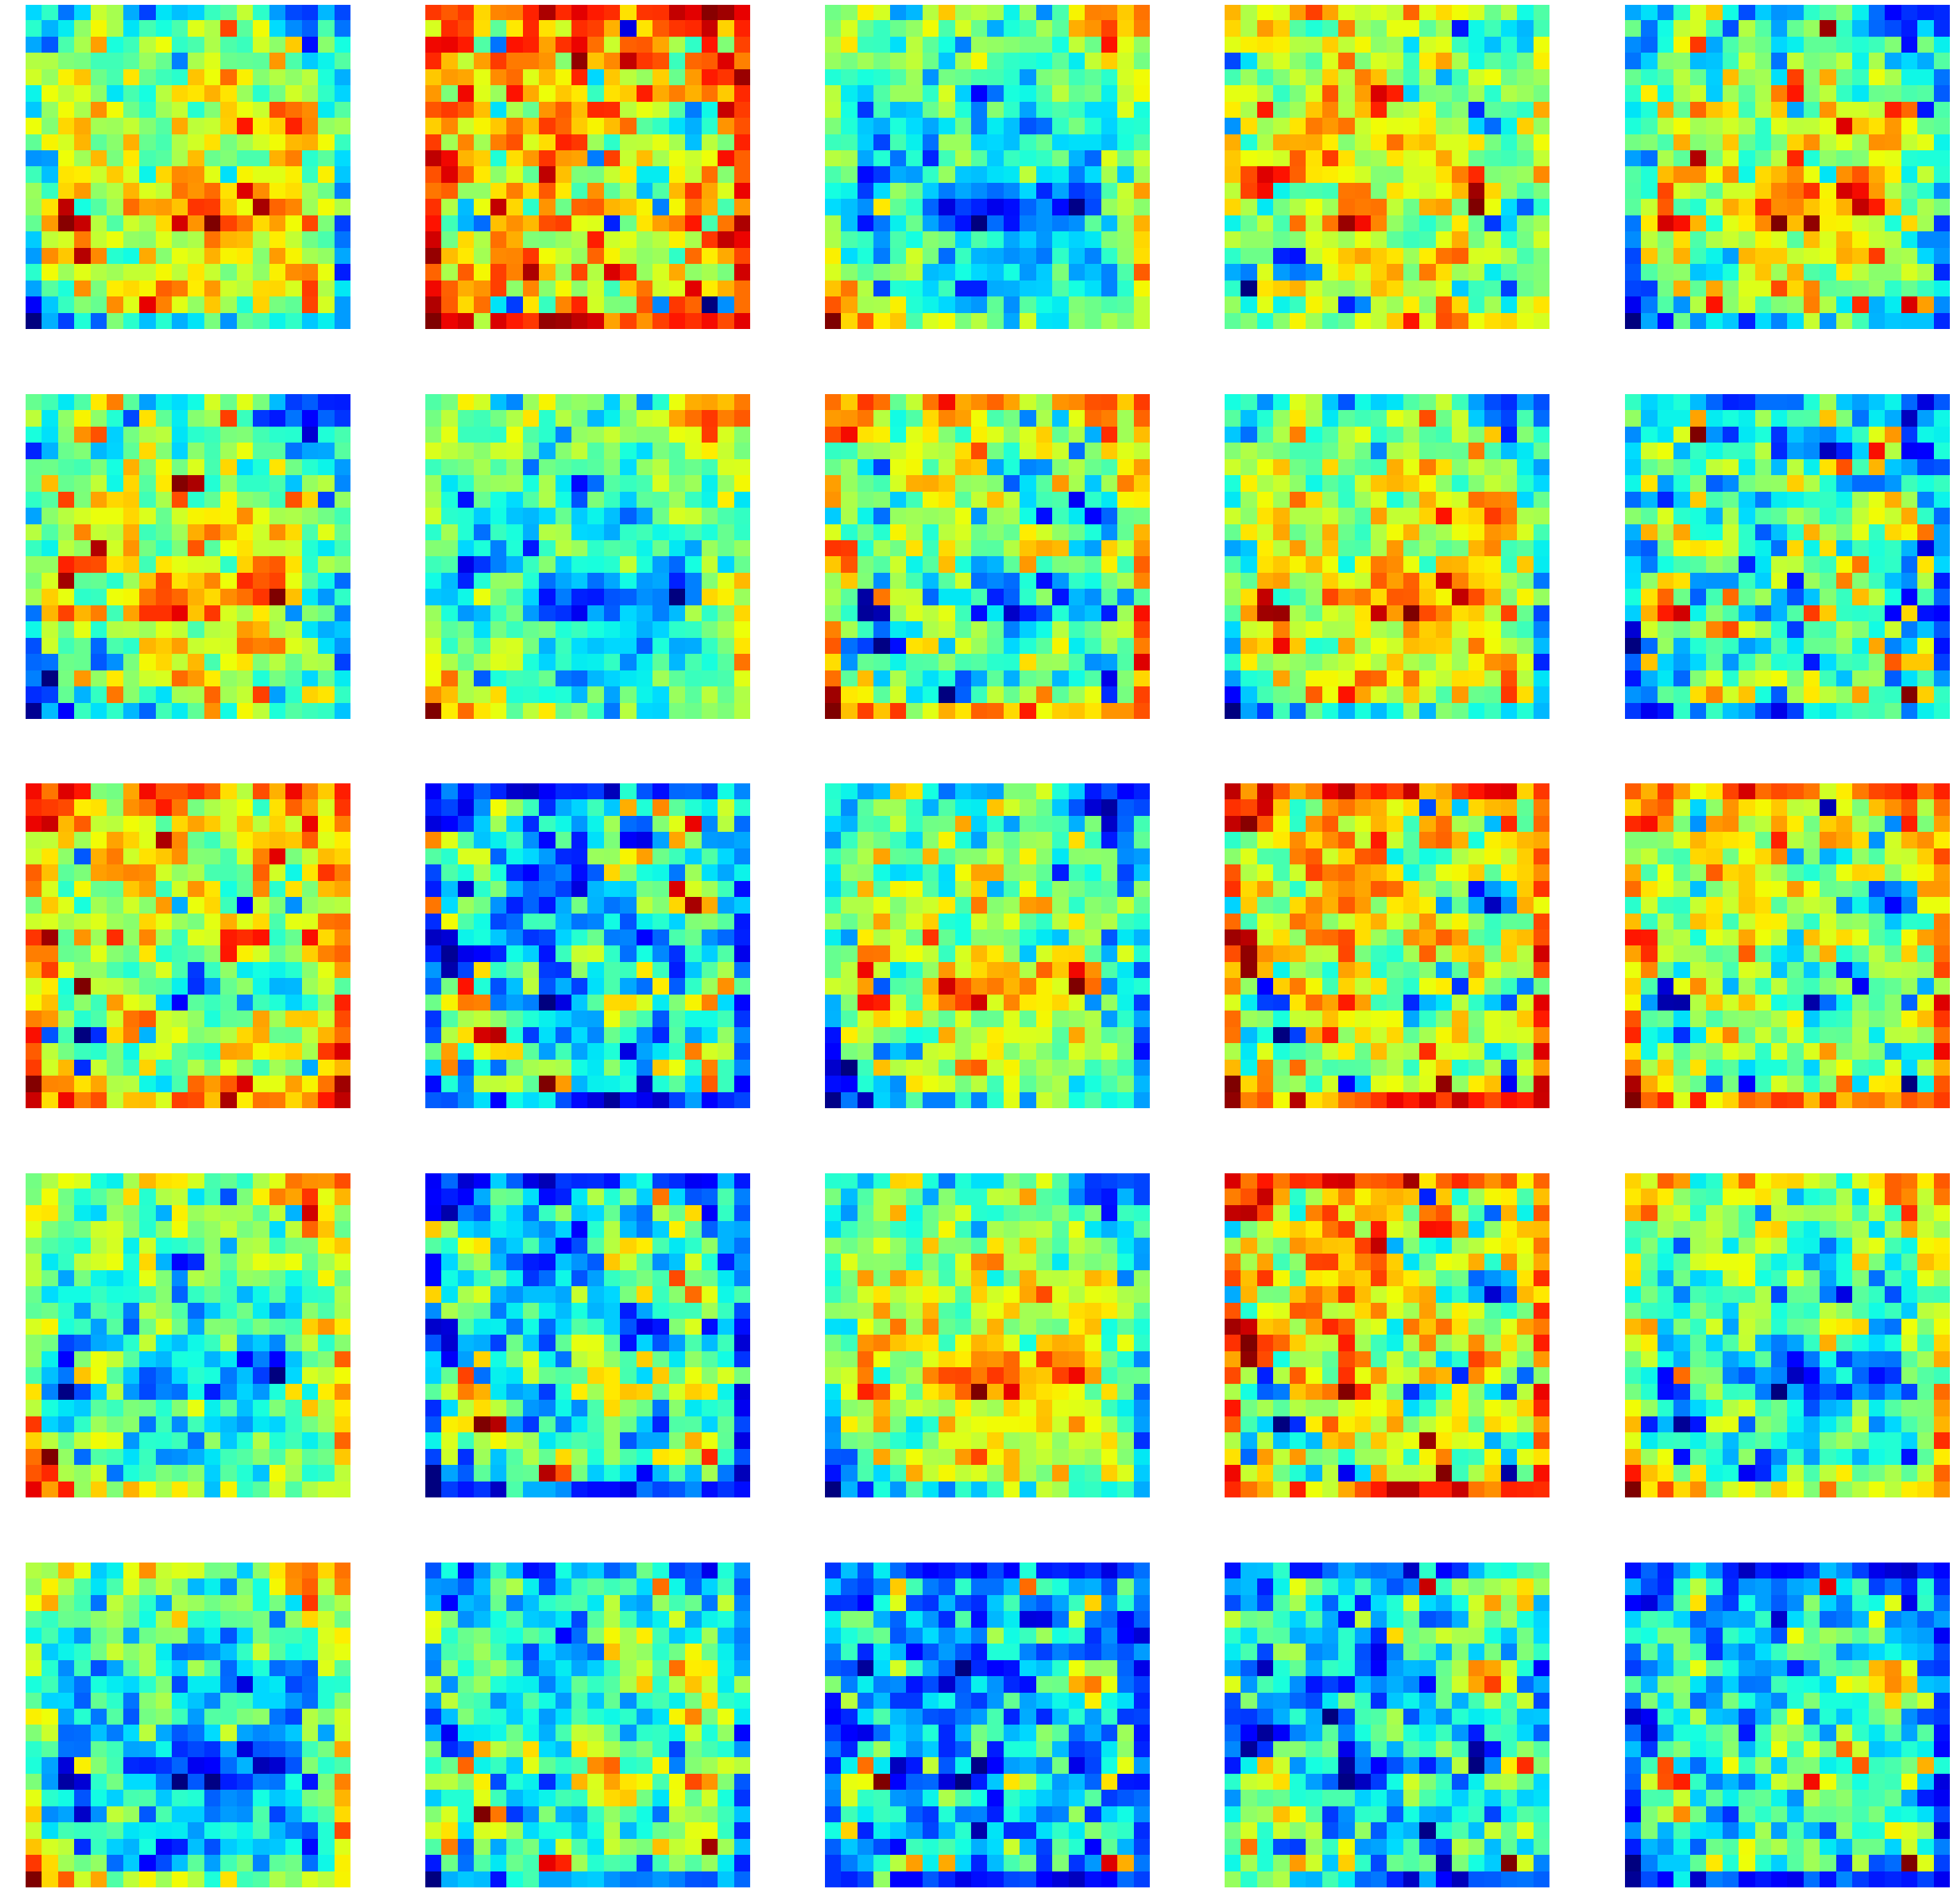

epoch 26, mean loss 7.936760402679443, std loss 0.05192813504358779


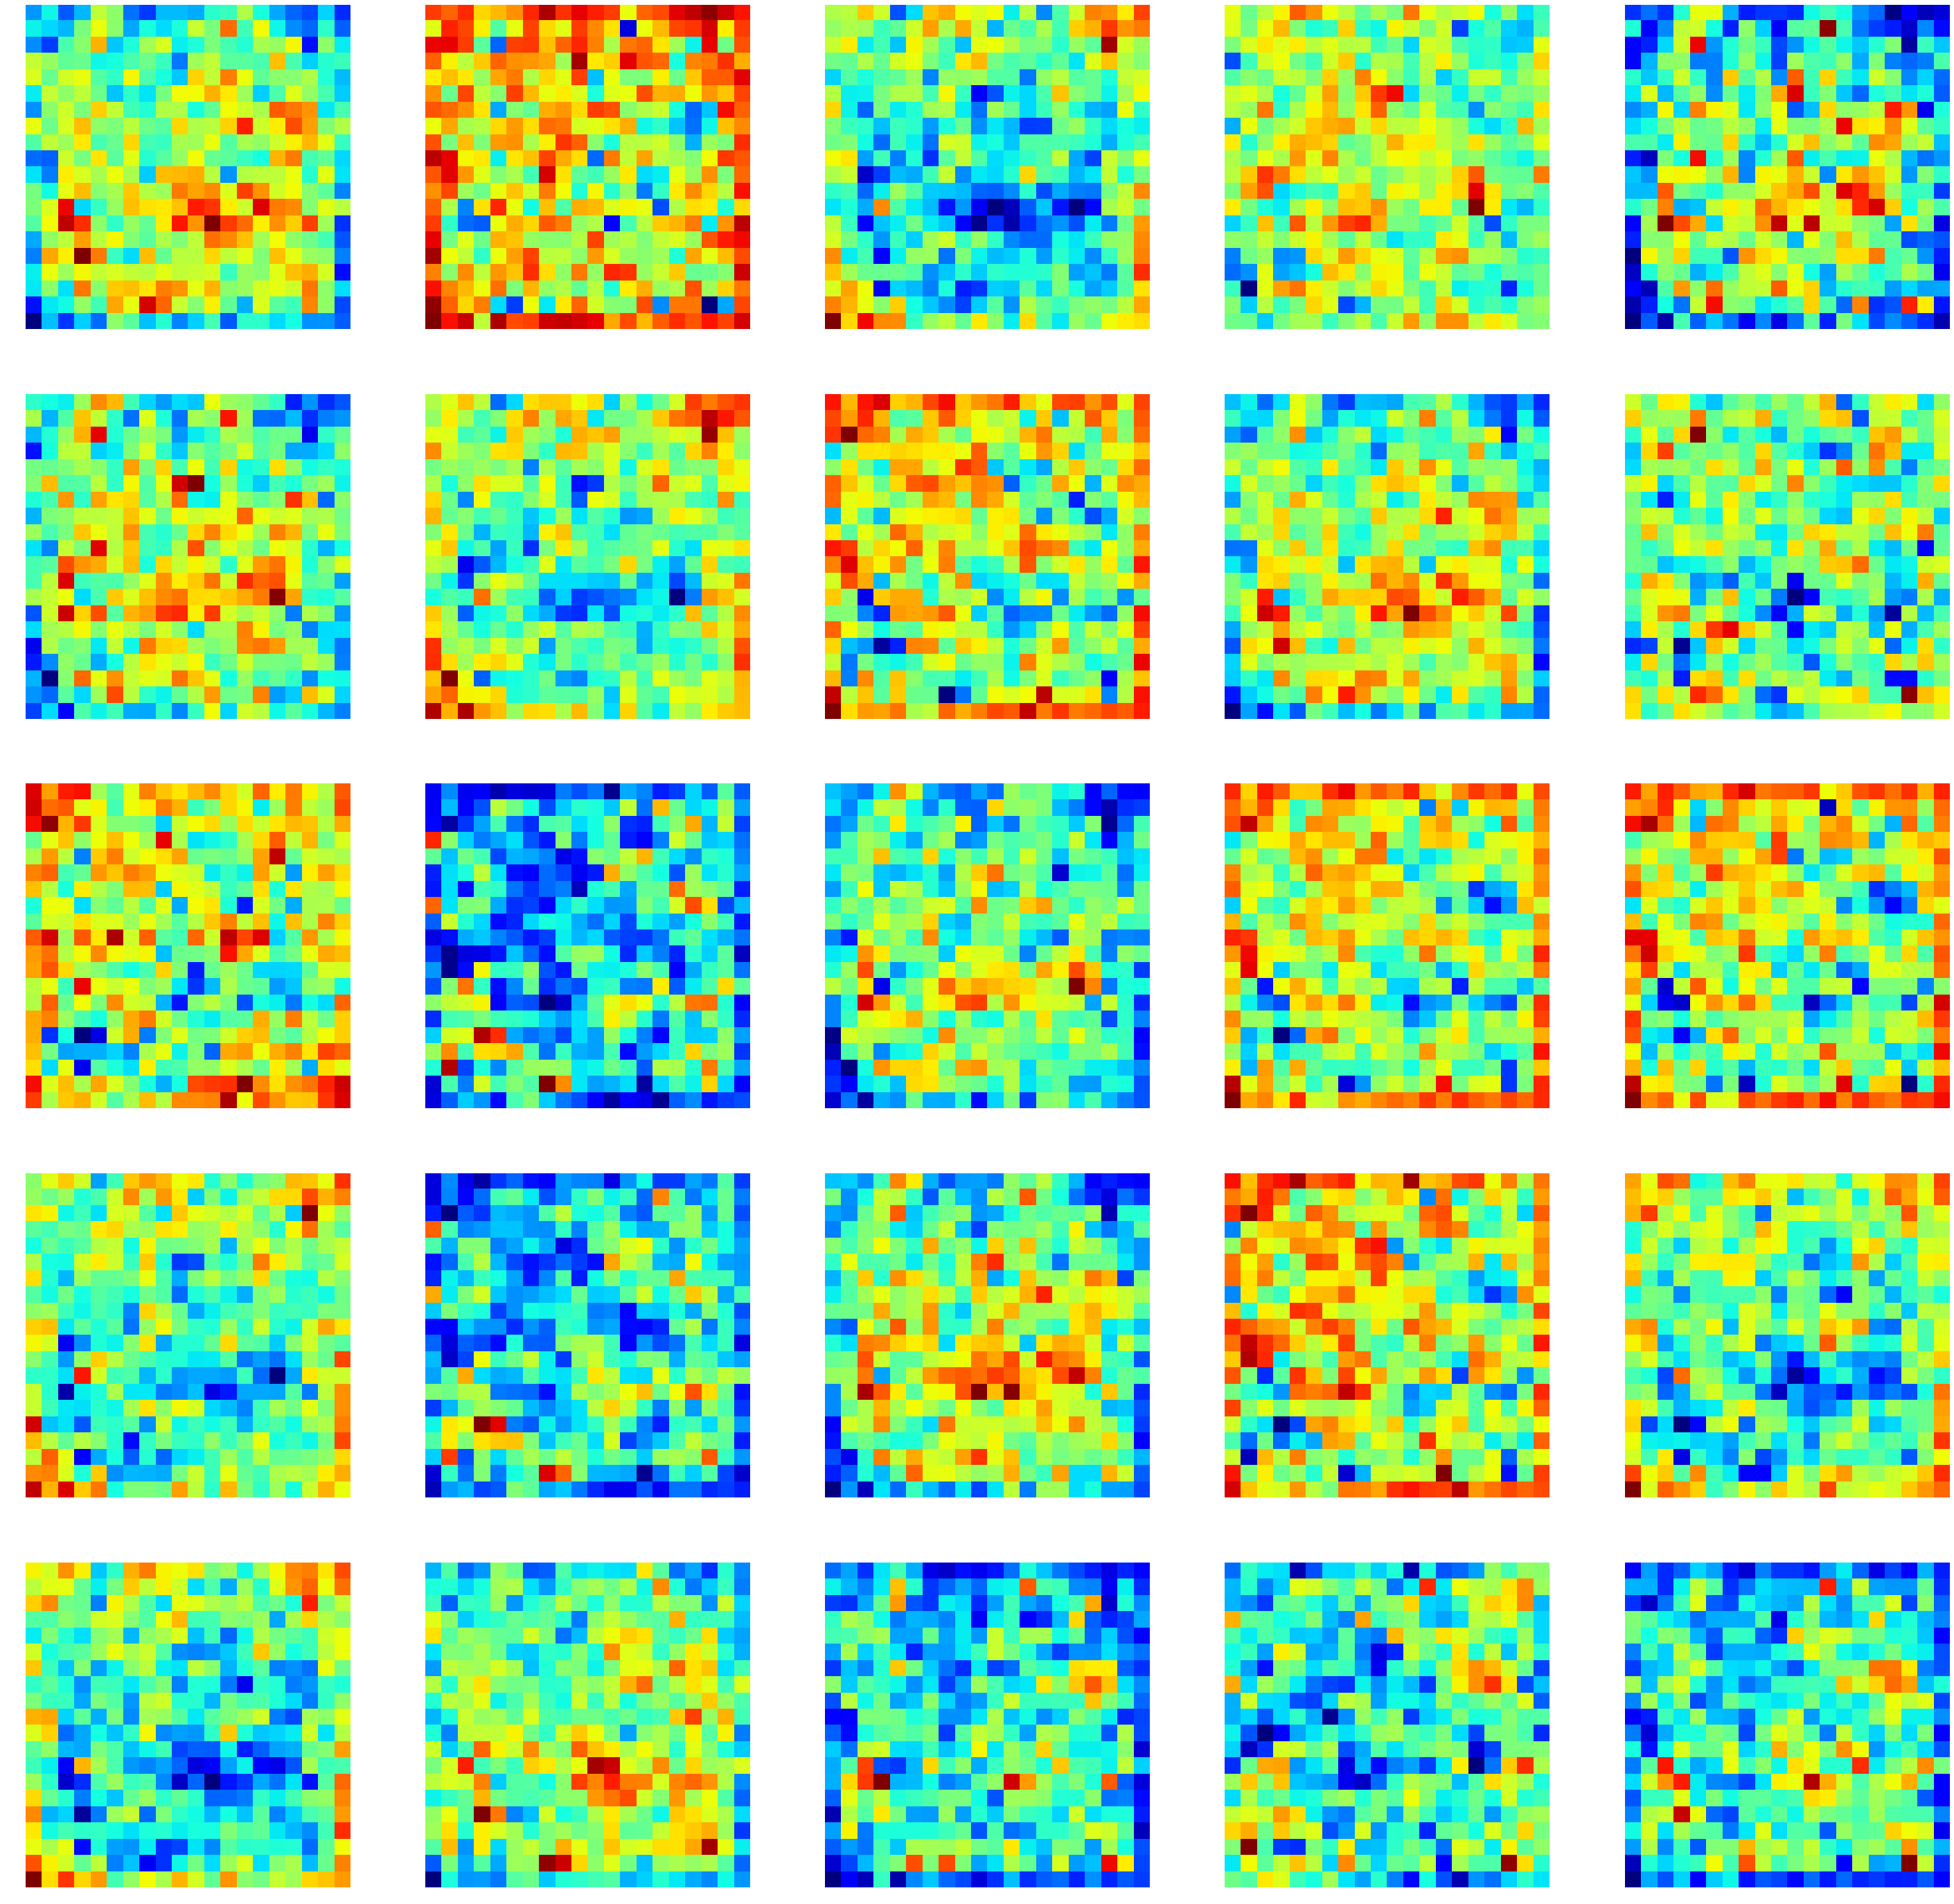

epoch 27, mean loss 7.937128081798553, std loss 0.05189484333358184


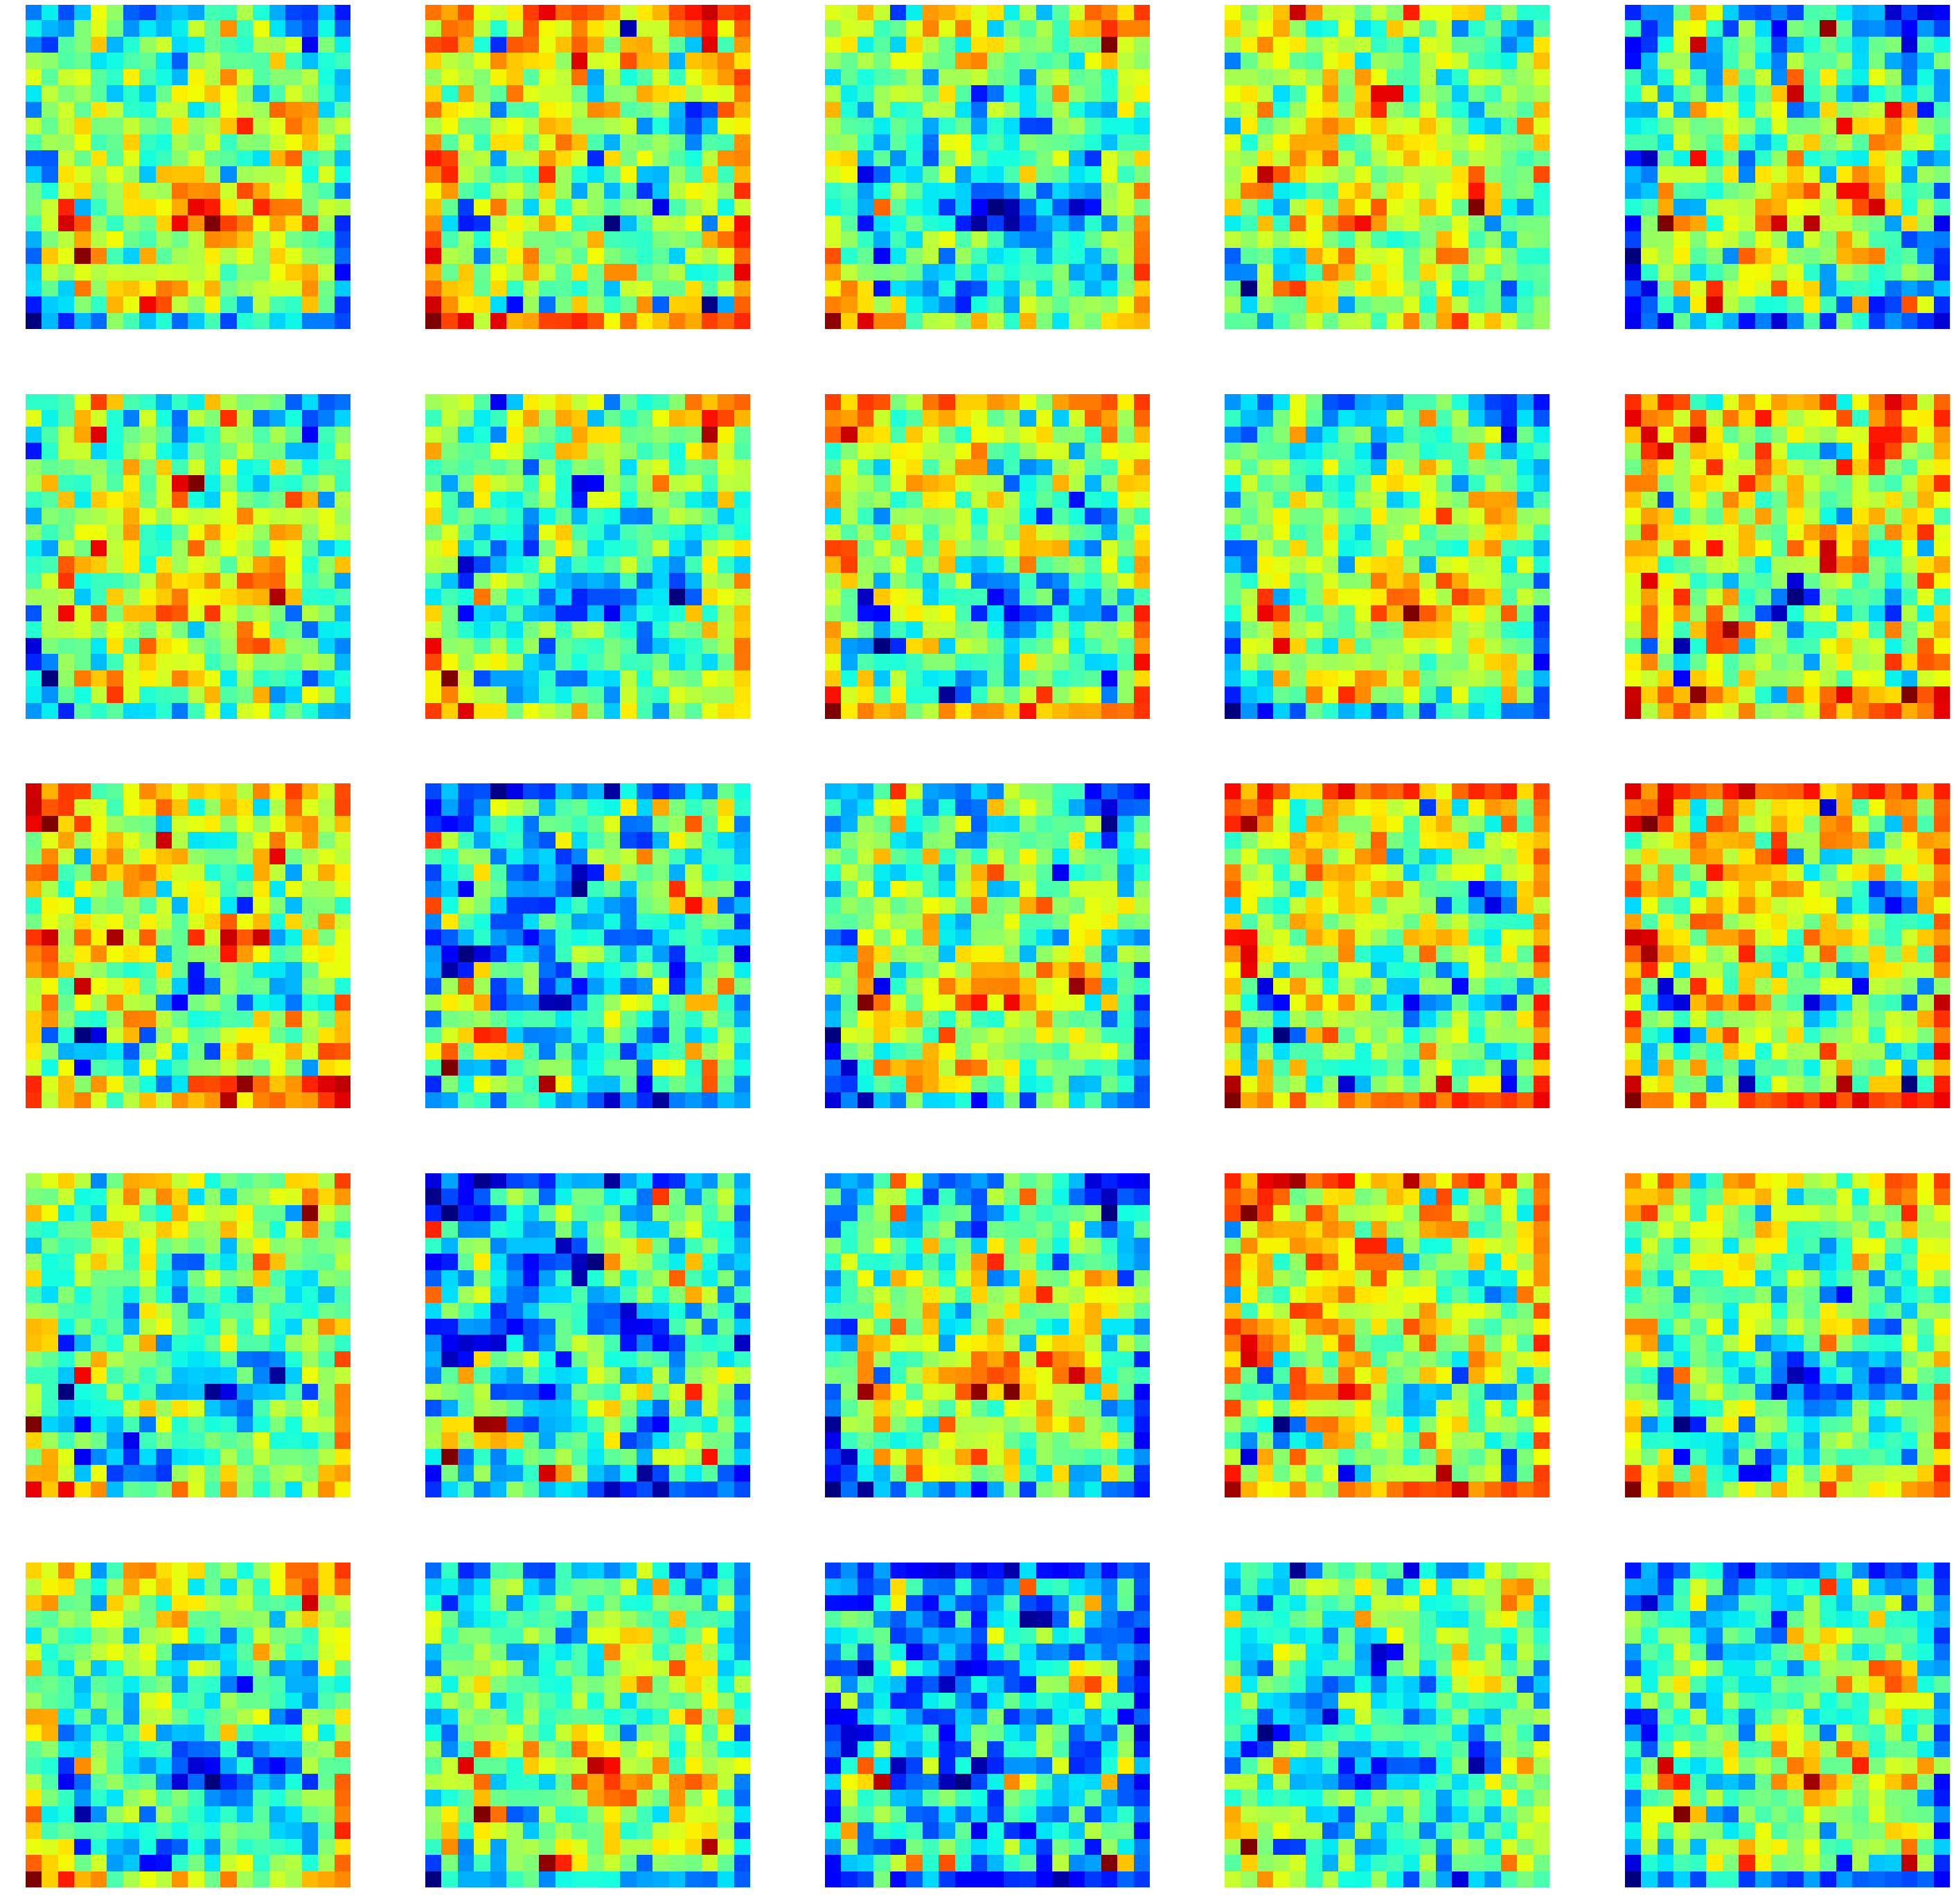

epoch 28, mean loss 7.936994644165039, std loss 0.05206019197227793


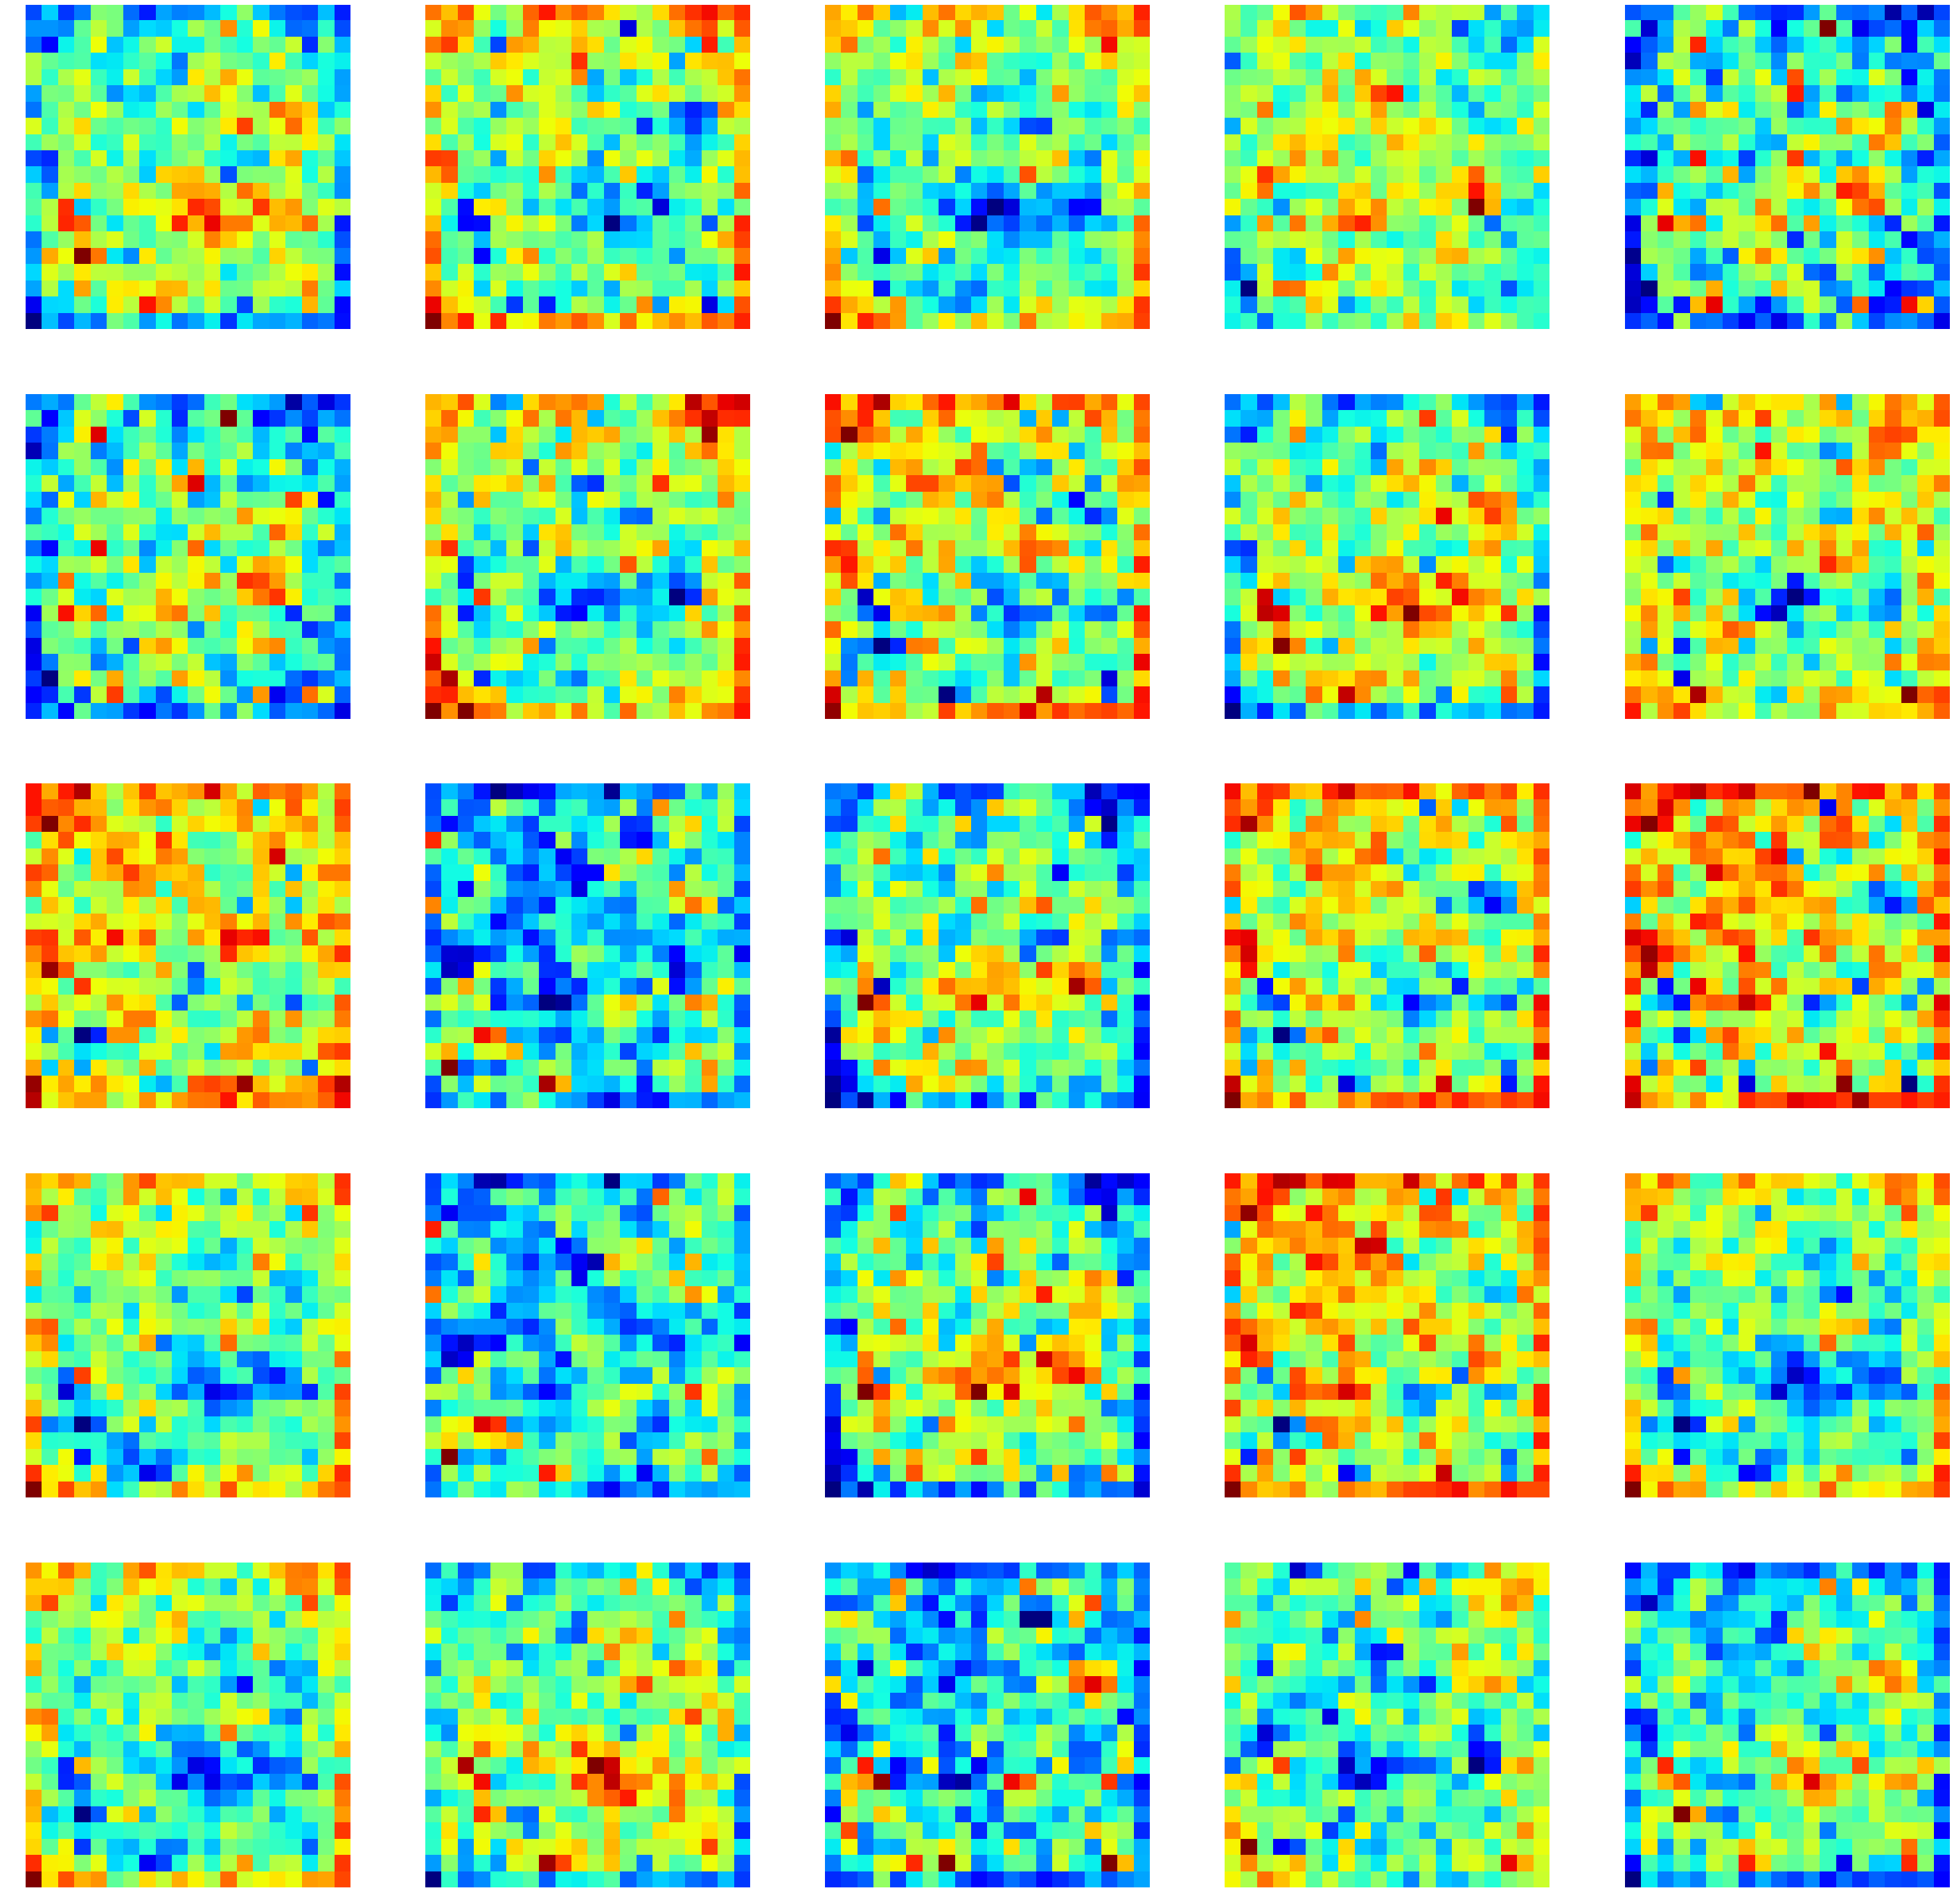

epoch 29, mean loss 7.937439231872559, std loss 0.0520003775884661


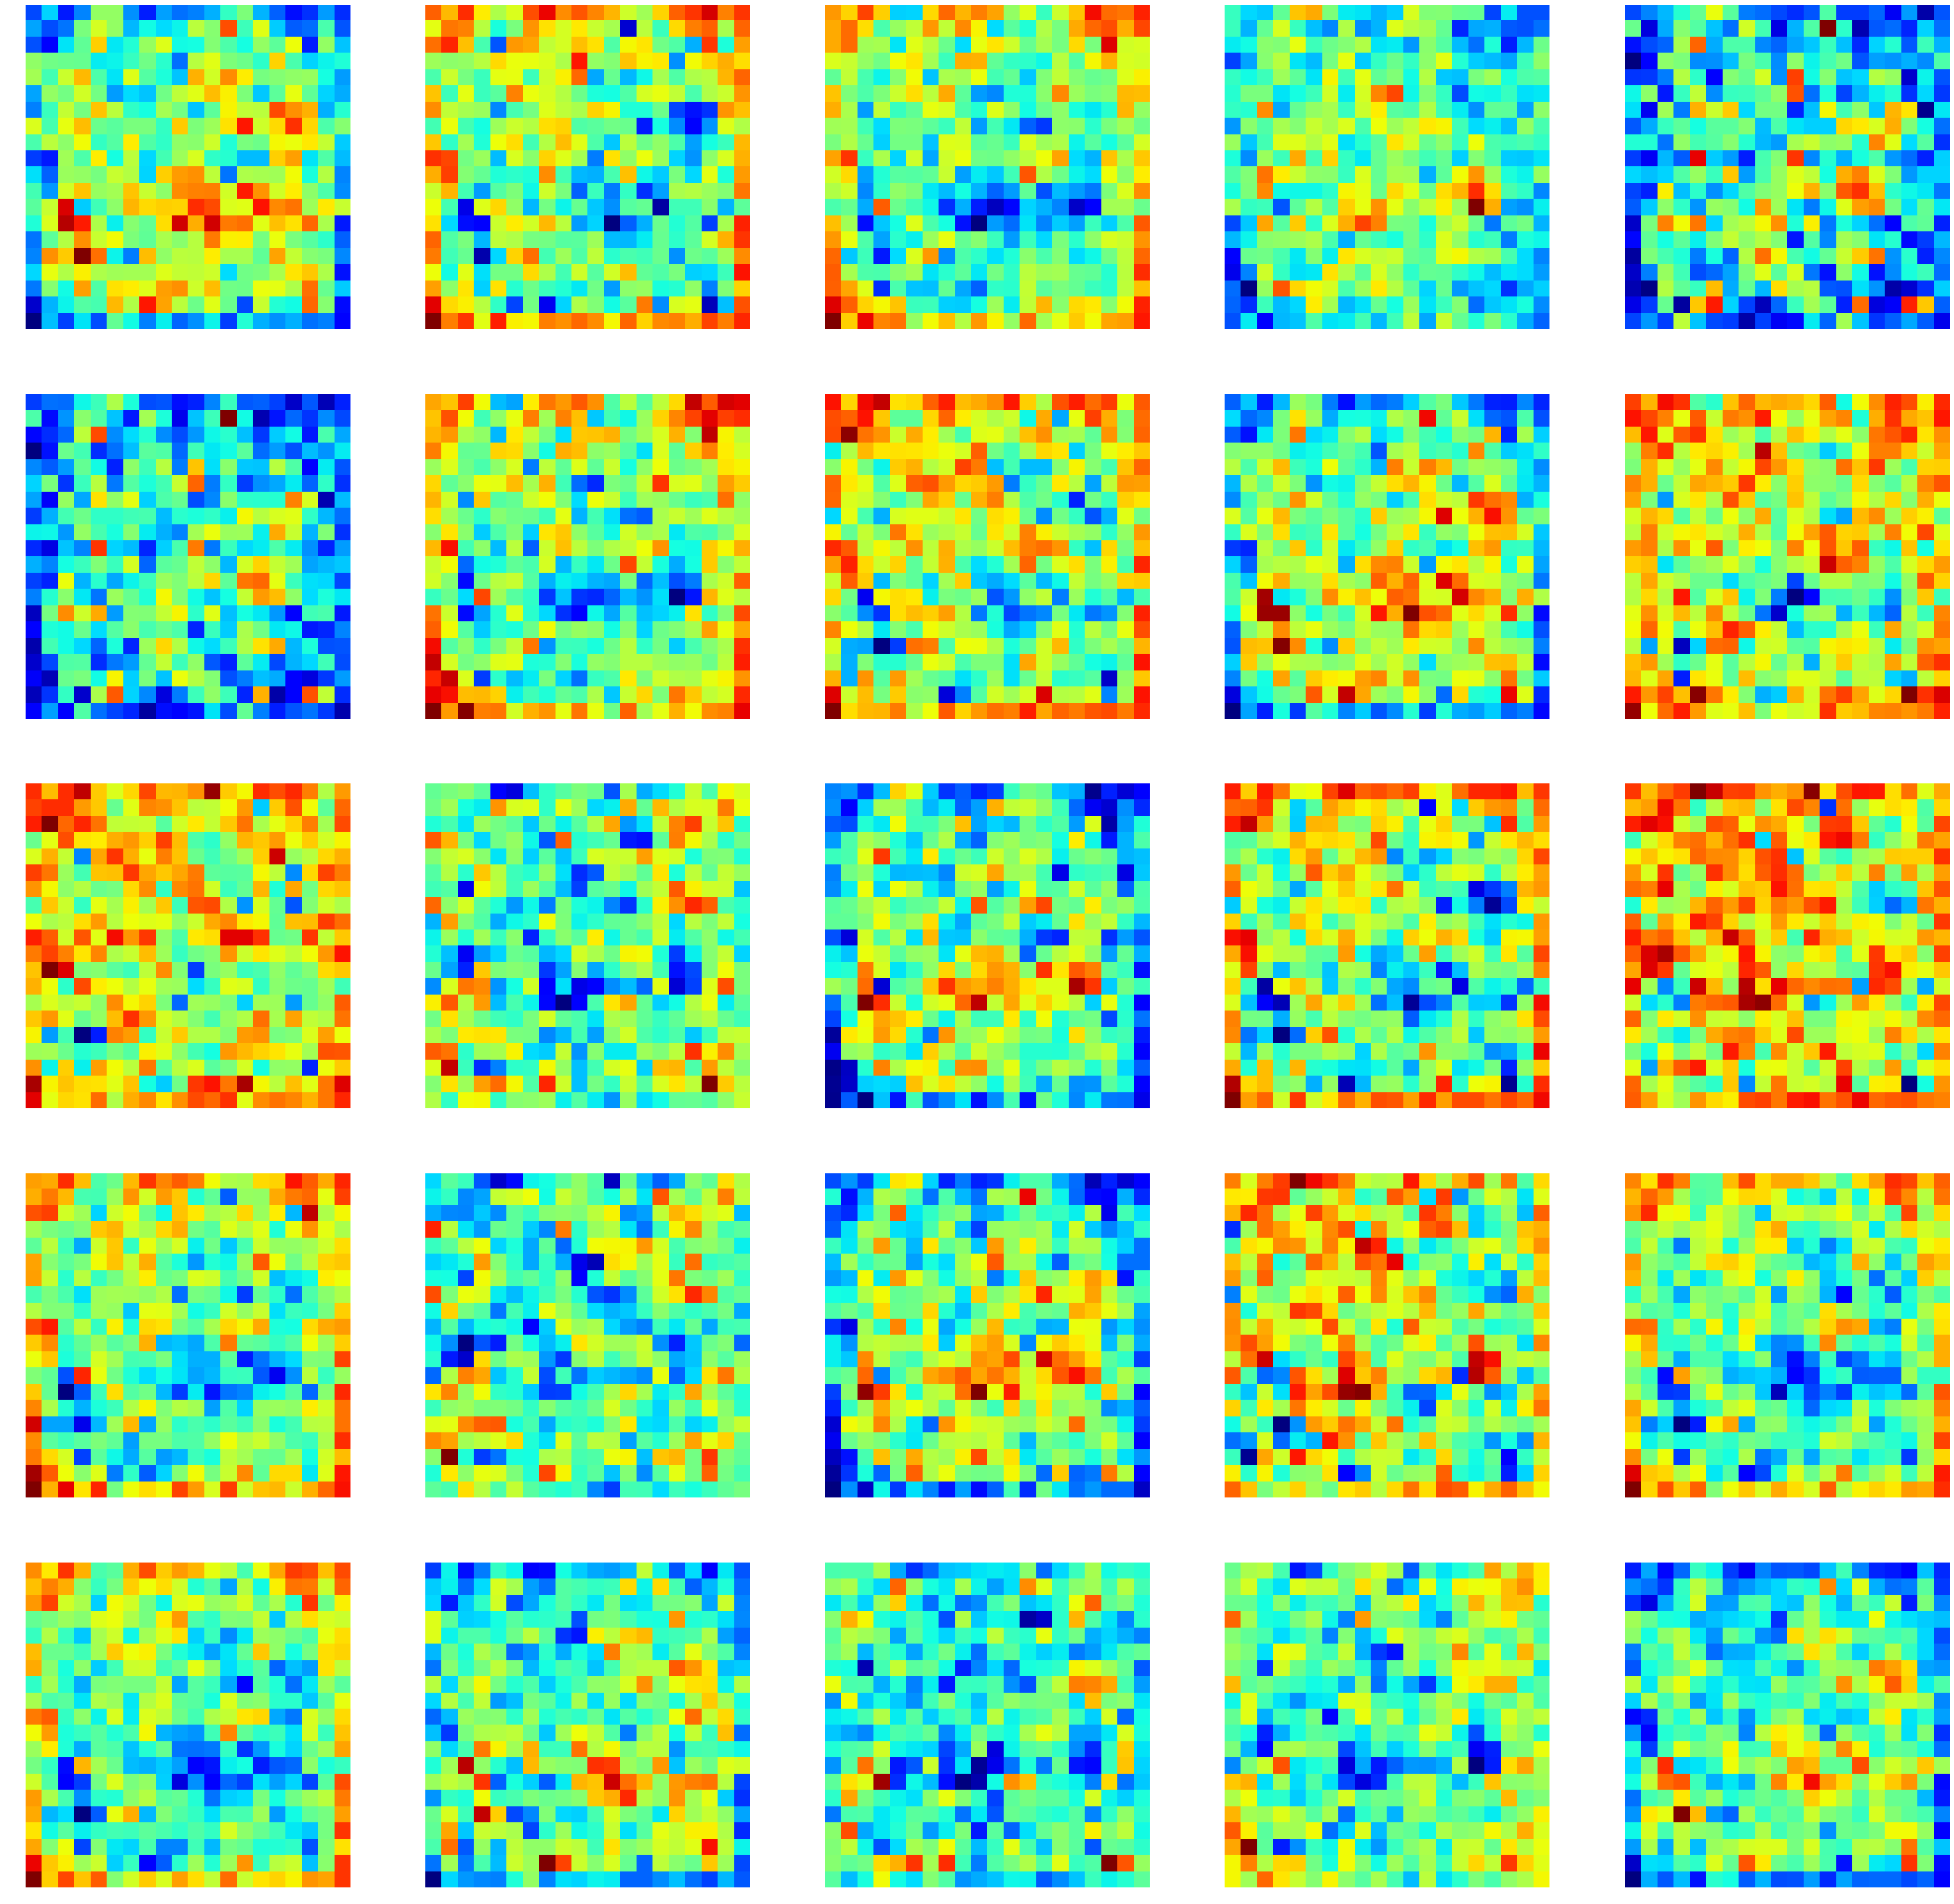

epoch 30, mean loss 7.93667733335495, std loss 0.05213369217390219


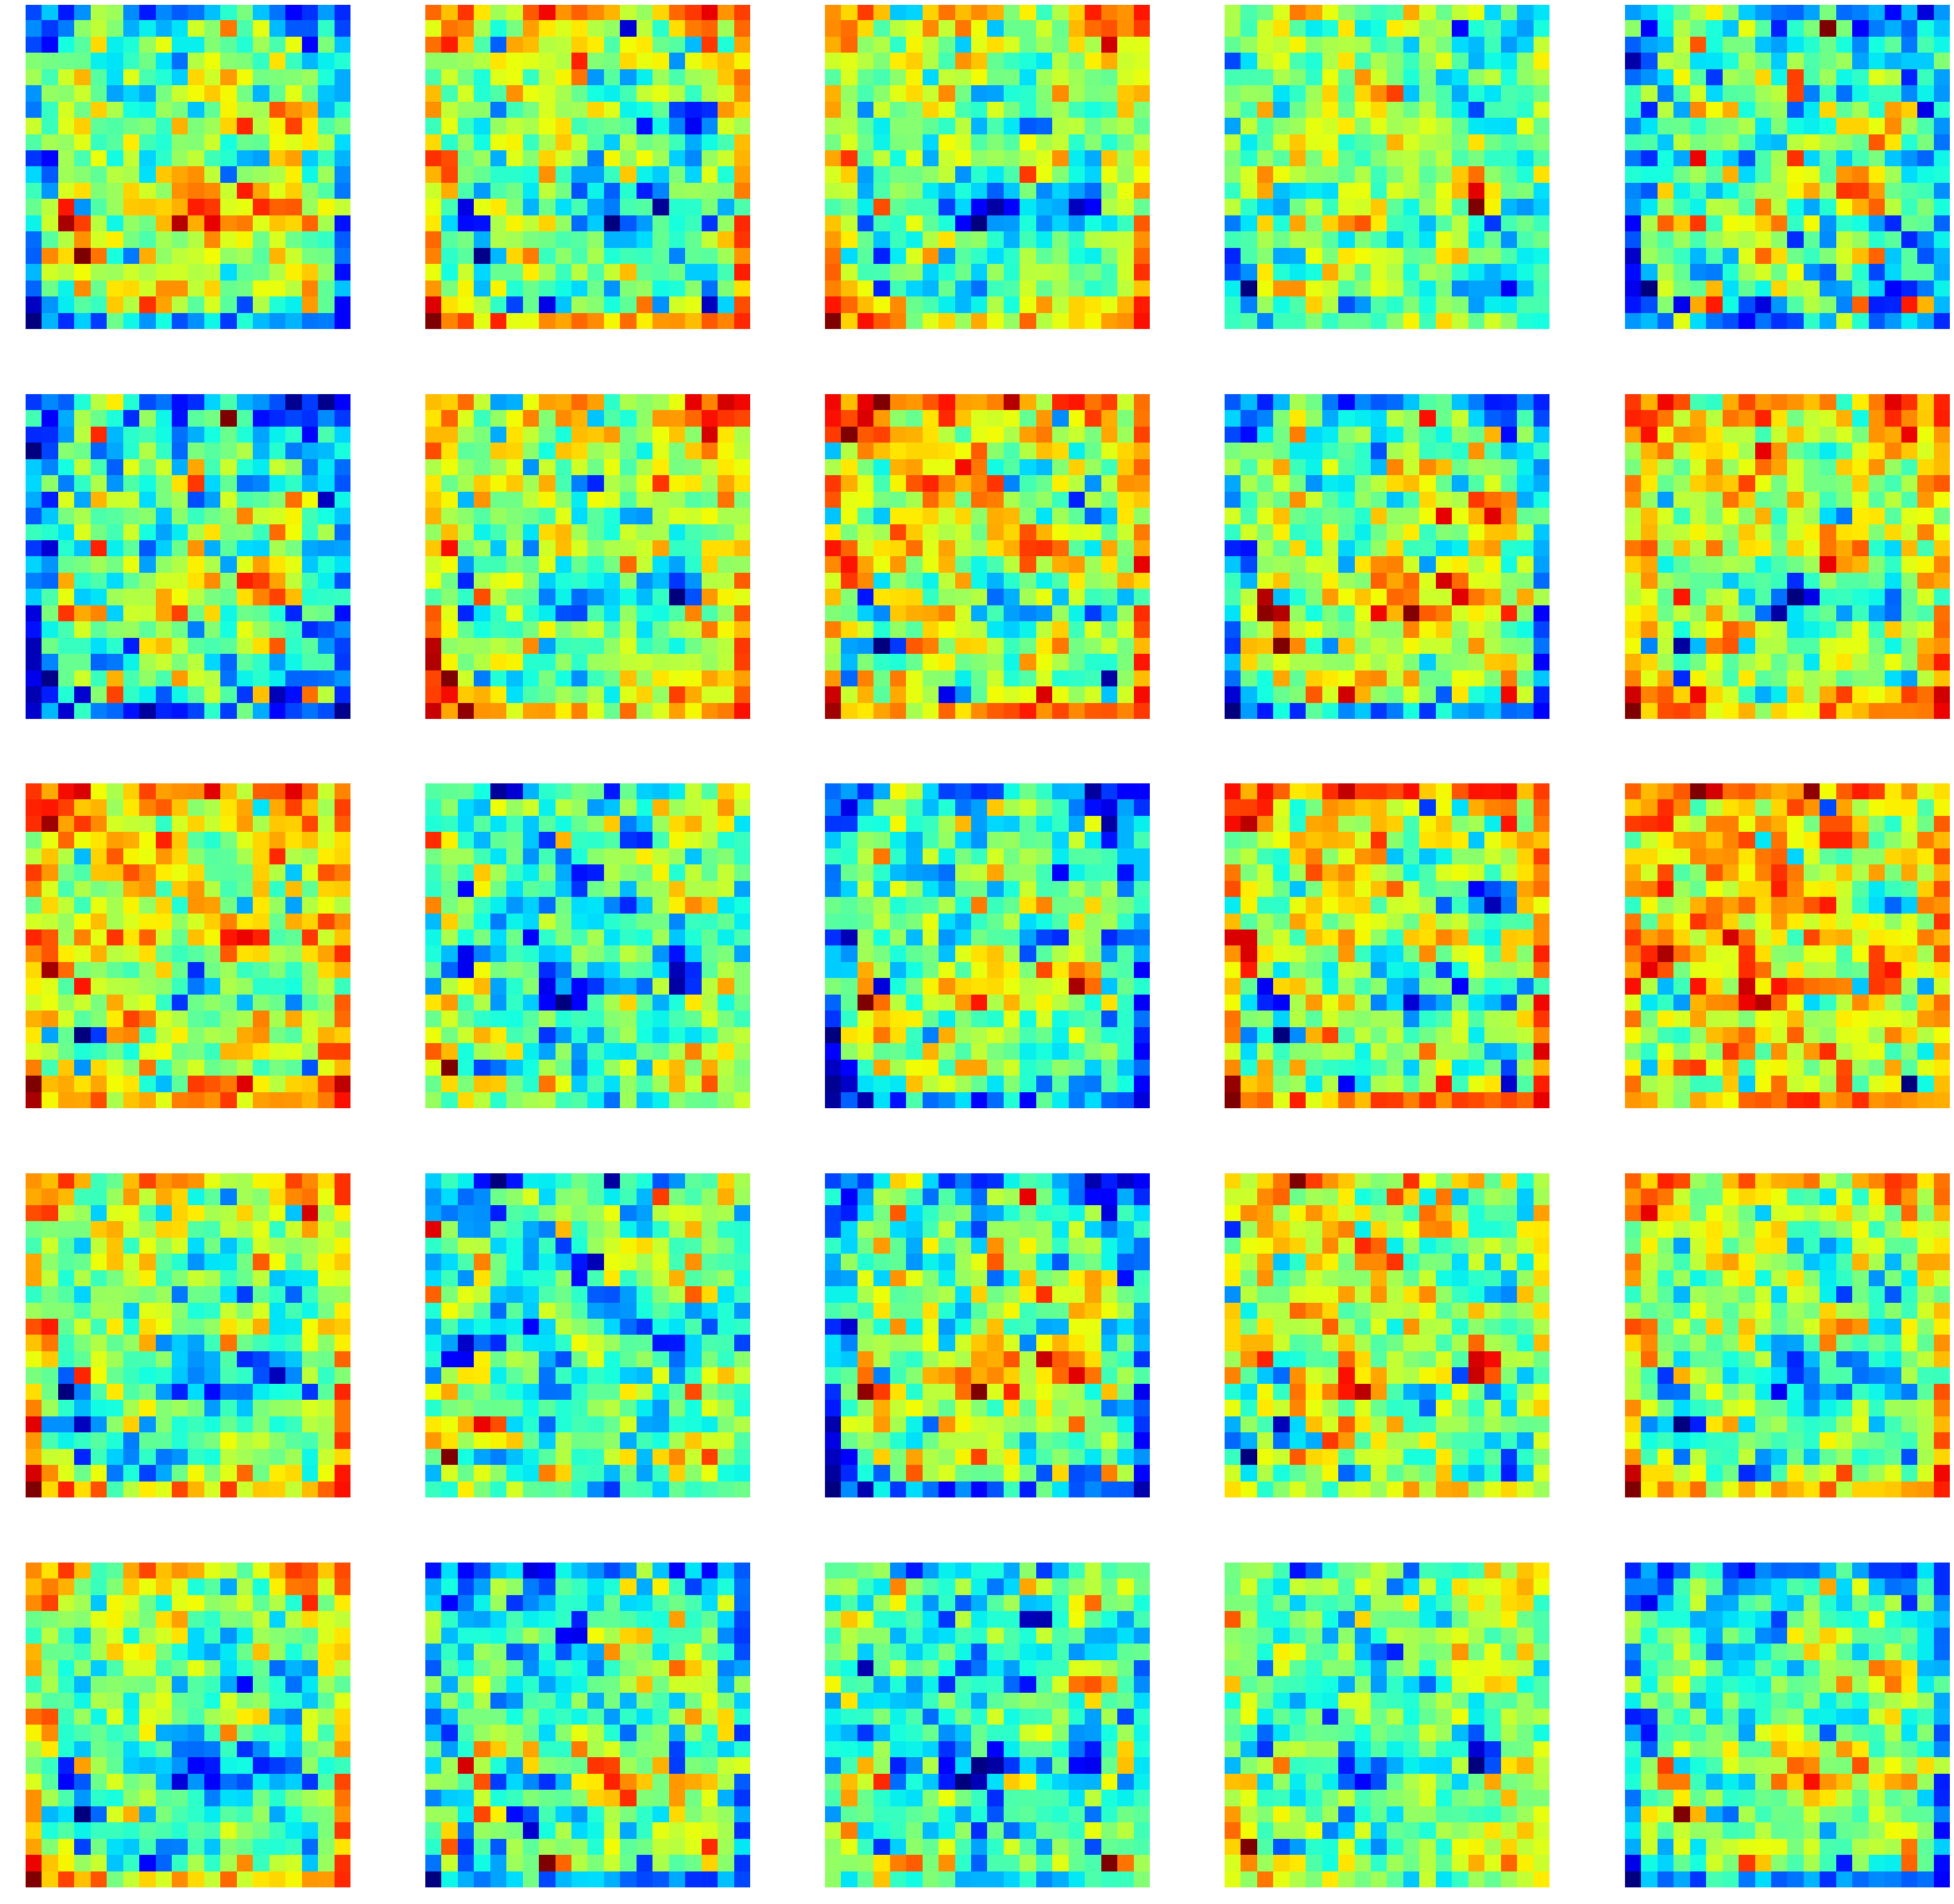

epoch 31, mean loss 7.9370131335258485, std loss 0.05221021661979482


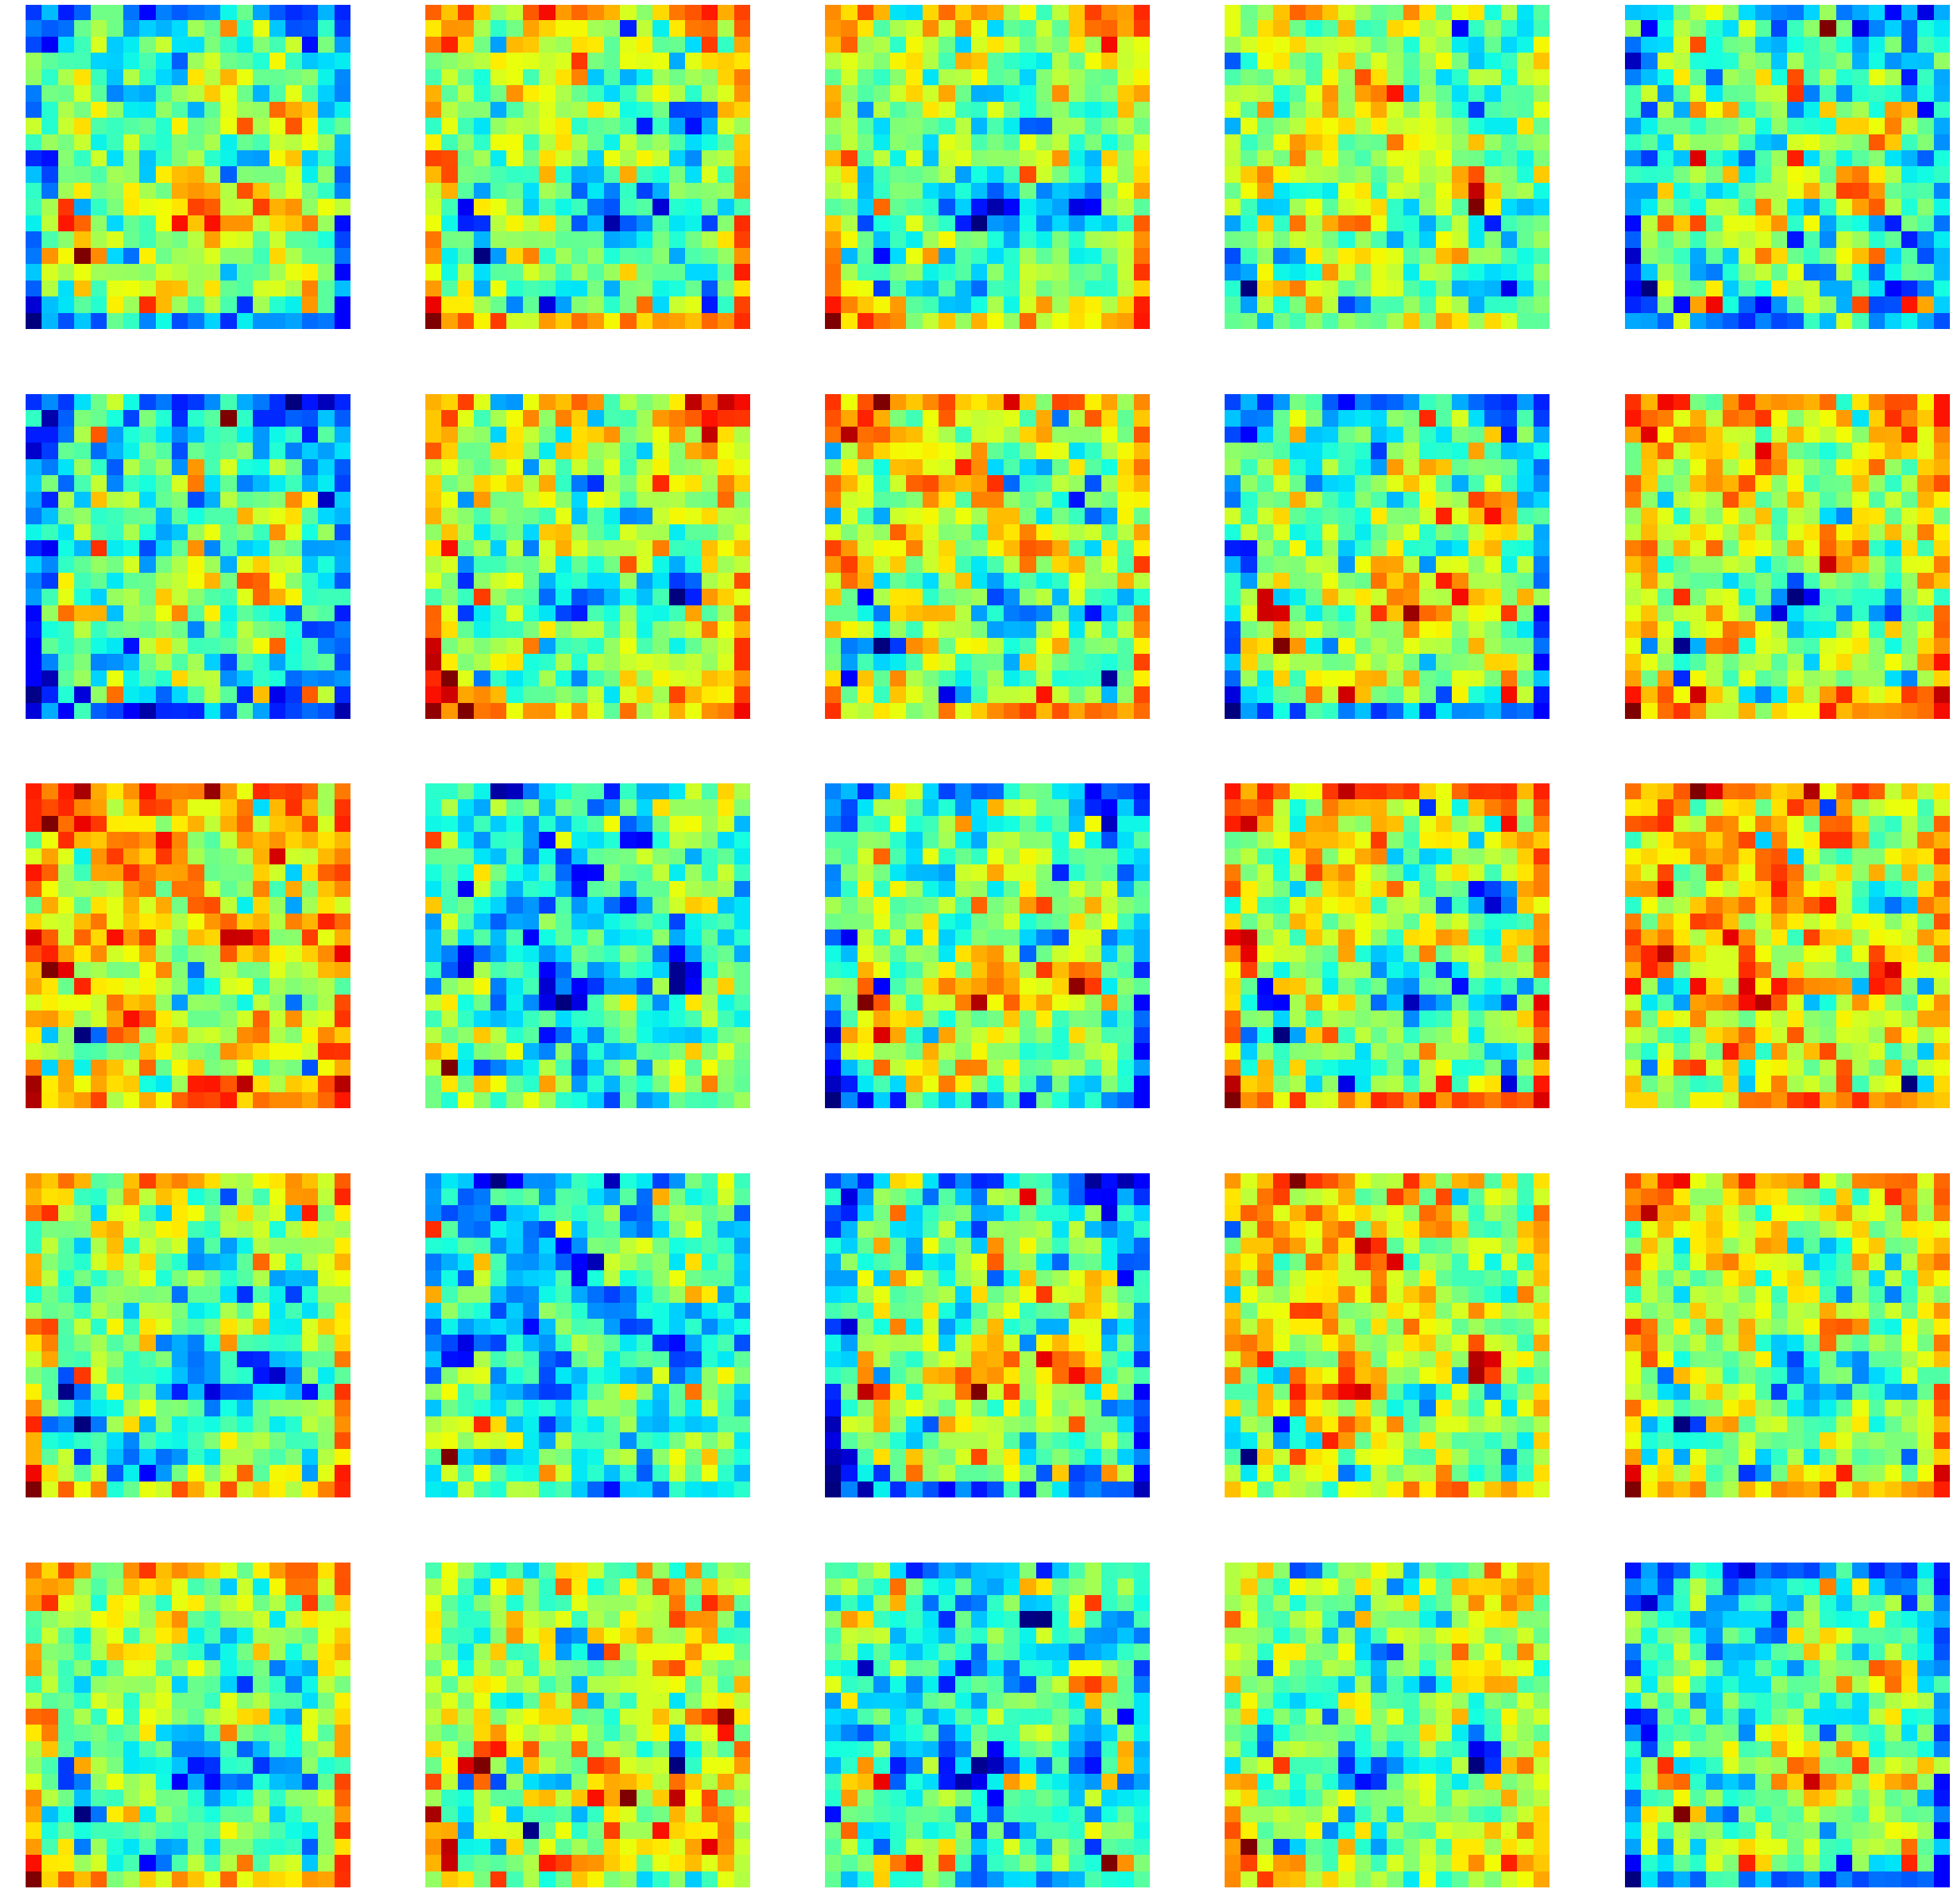

epoch 32, mean loss 7.936117702484131, std loss 0.05260259915603763


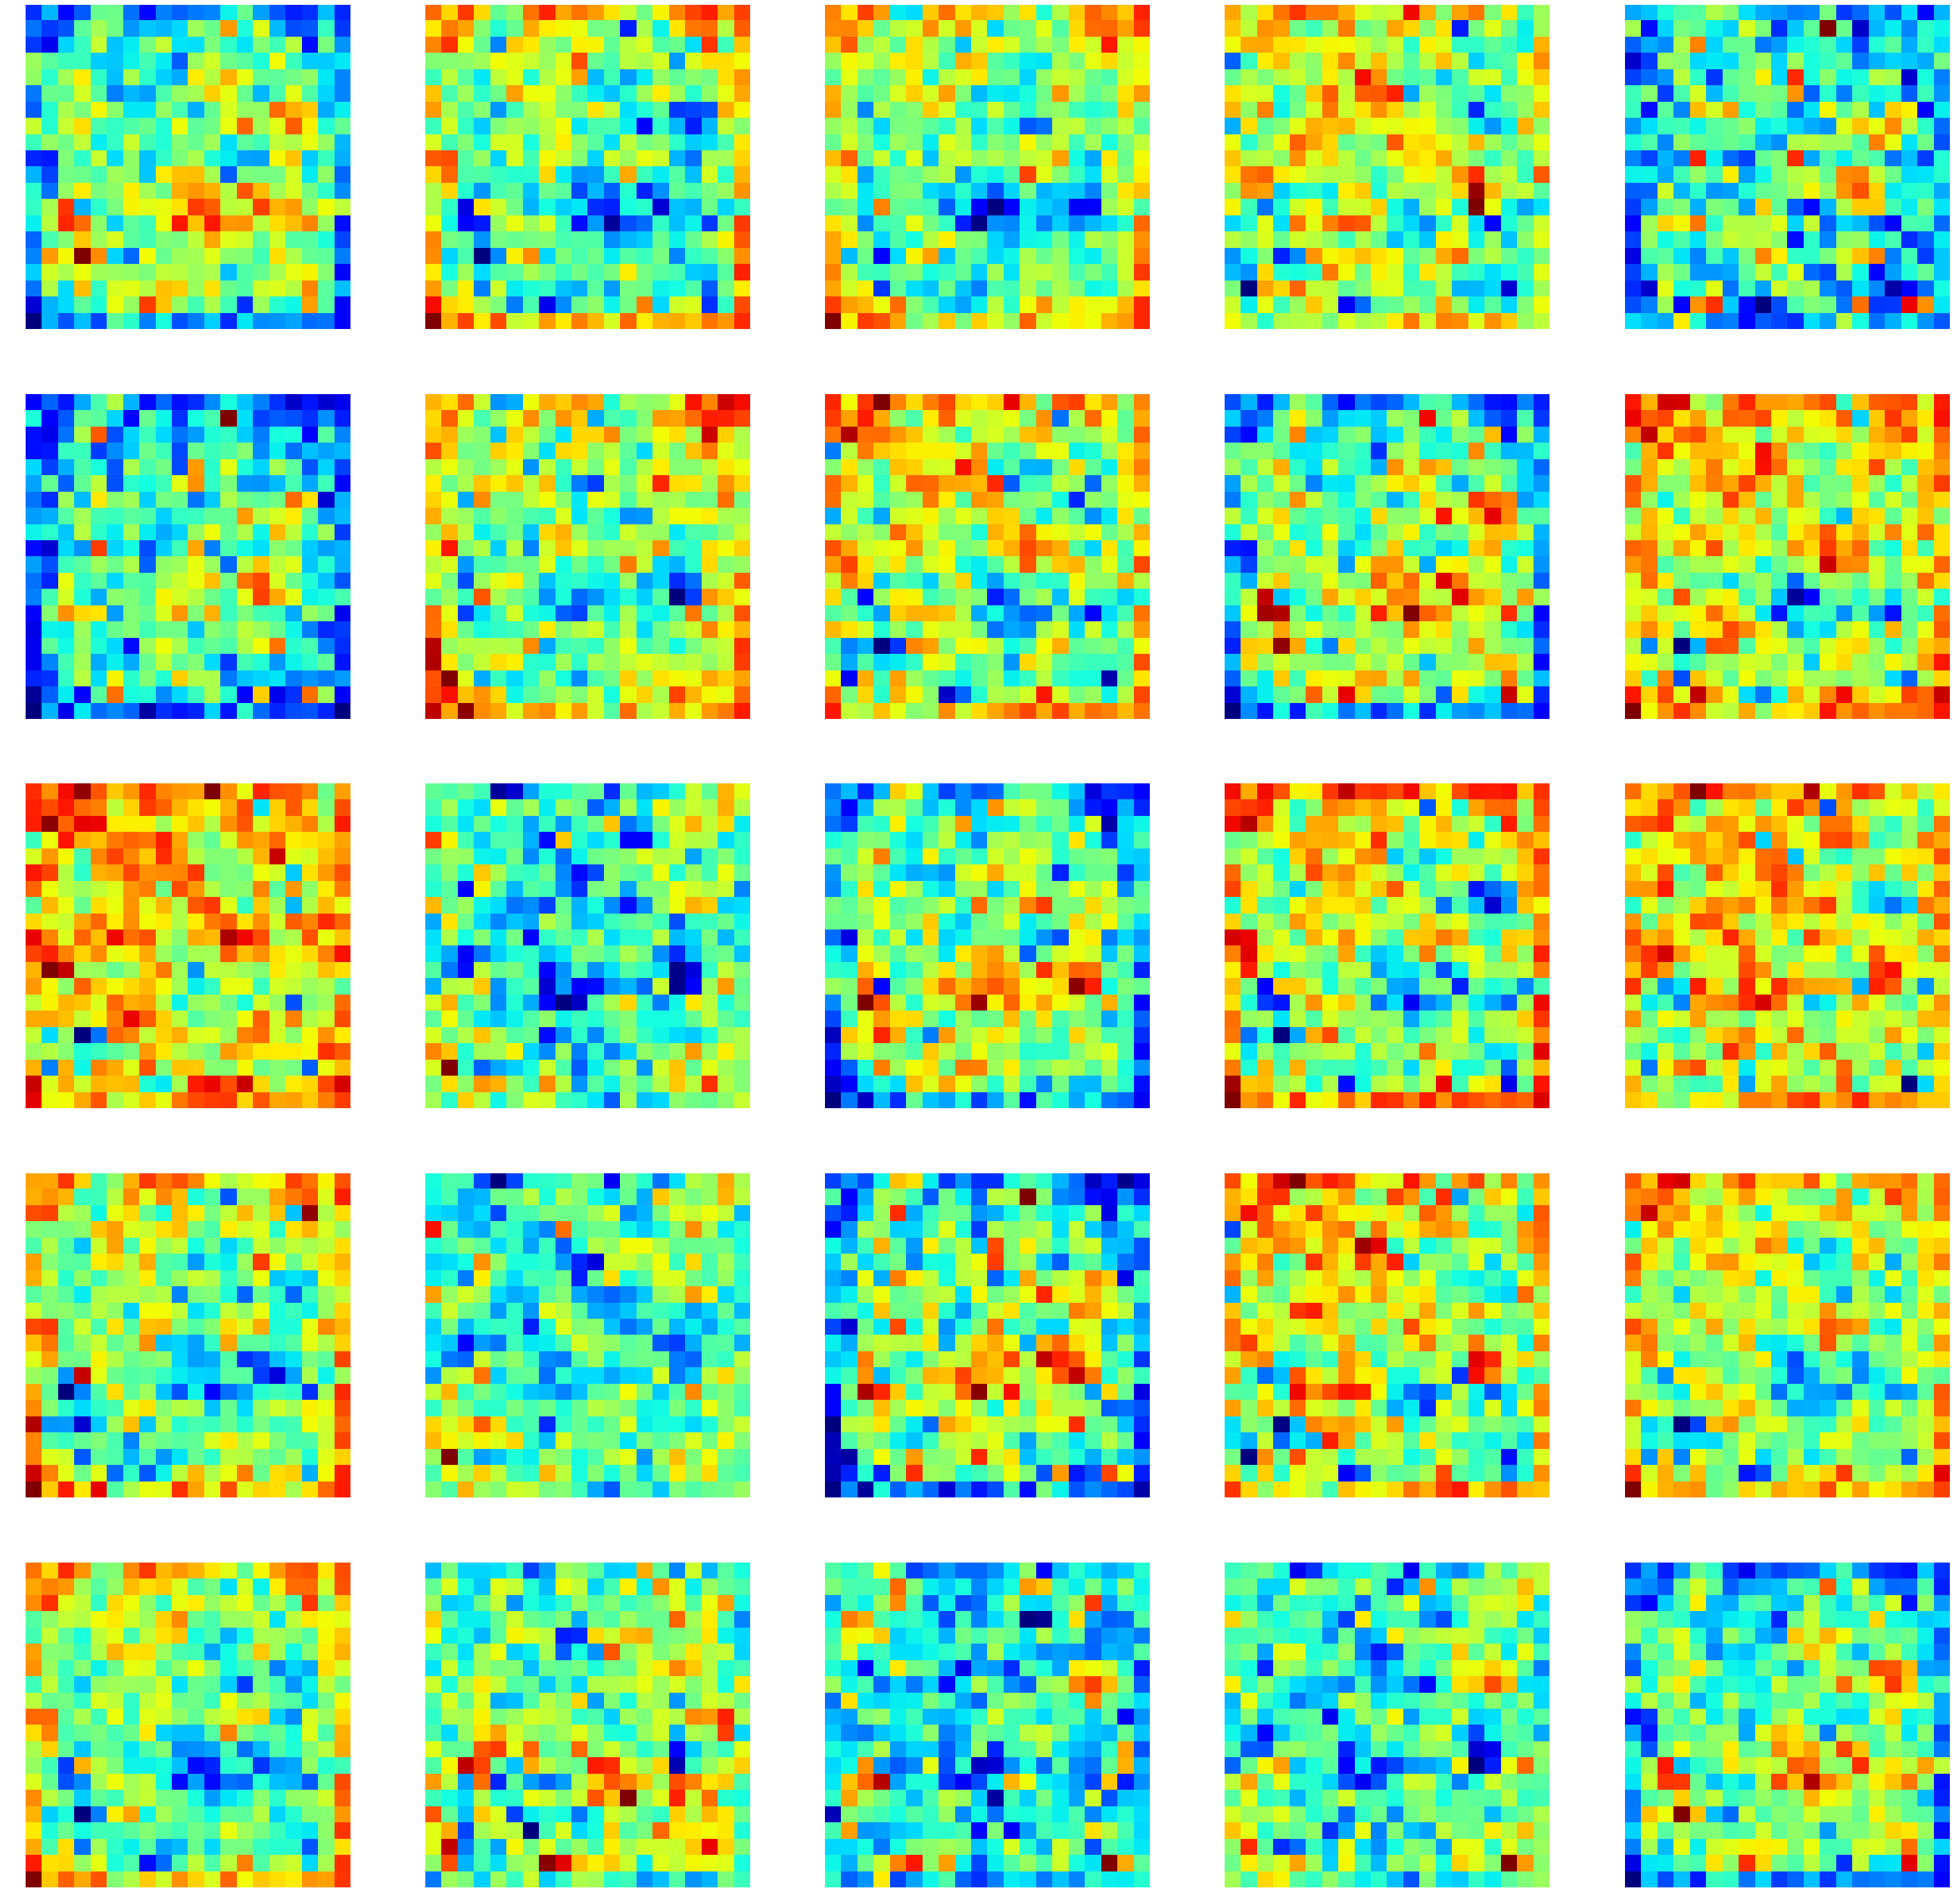

epoch 33, mean loss 7.935903989315033, std loss 0.052444074150455655


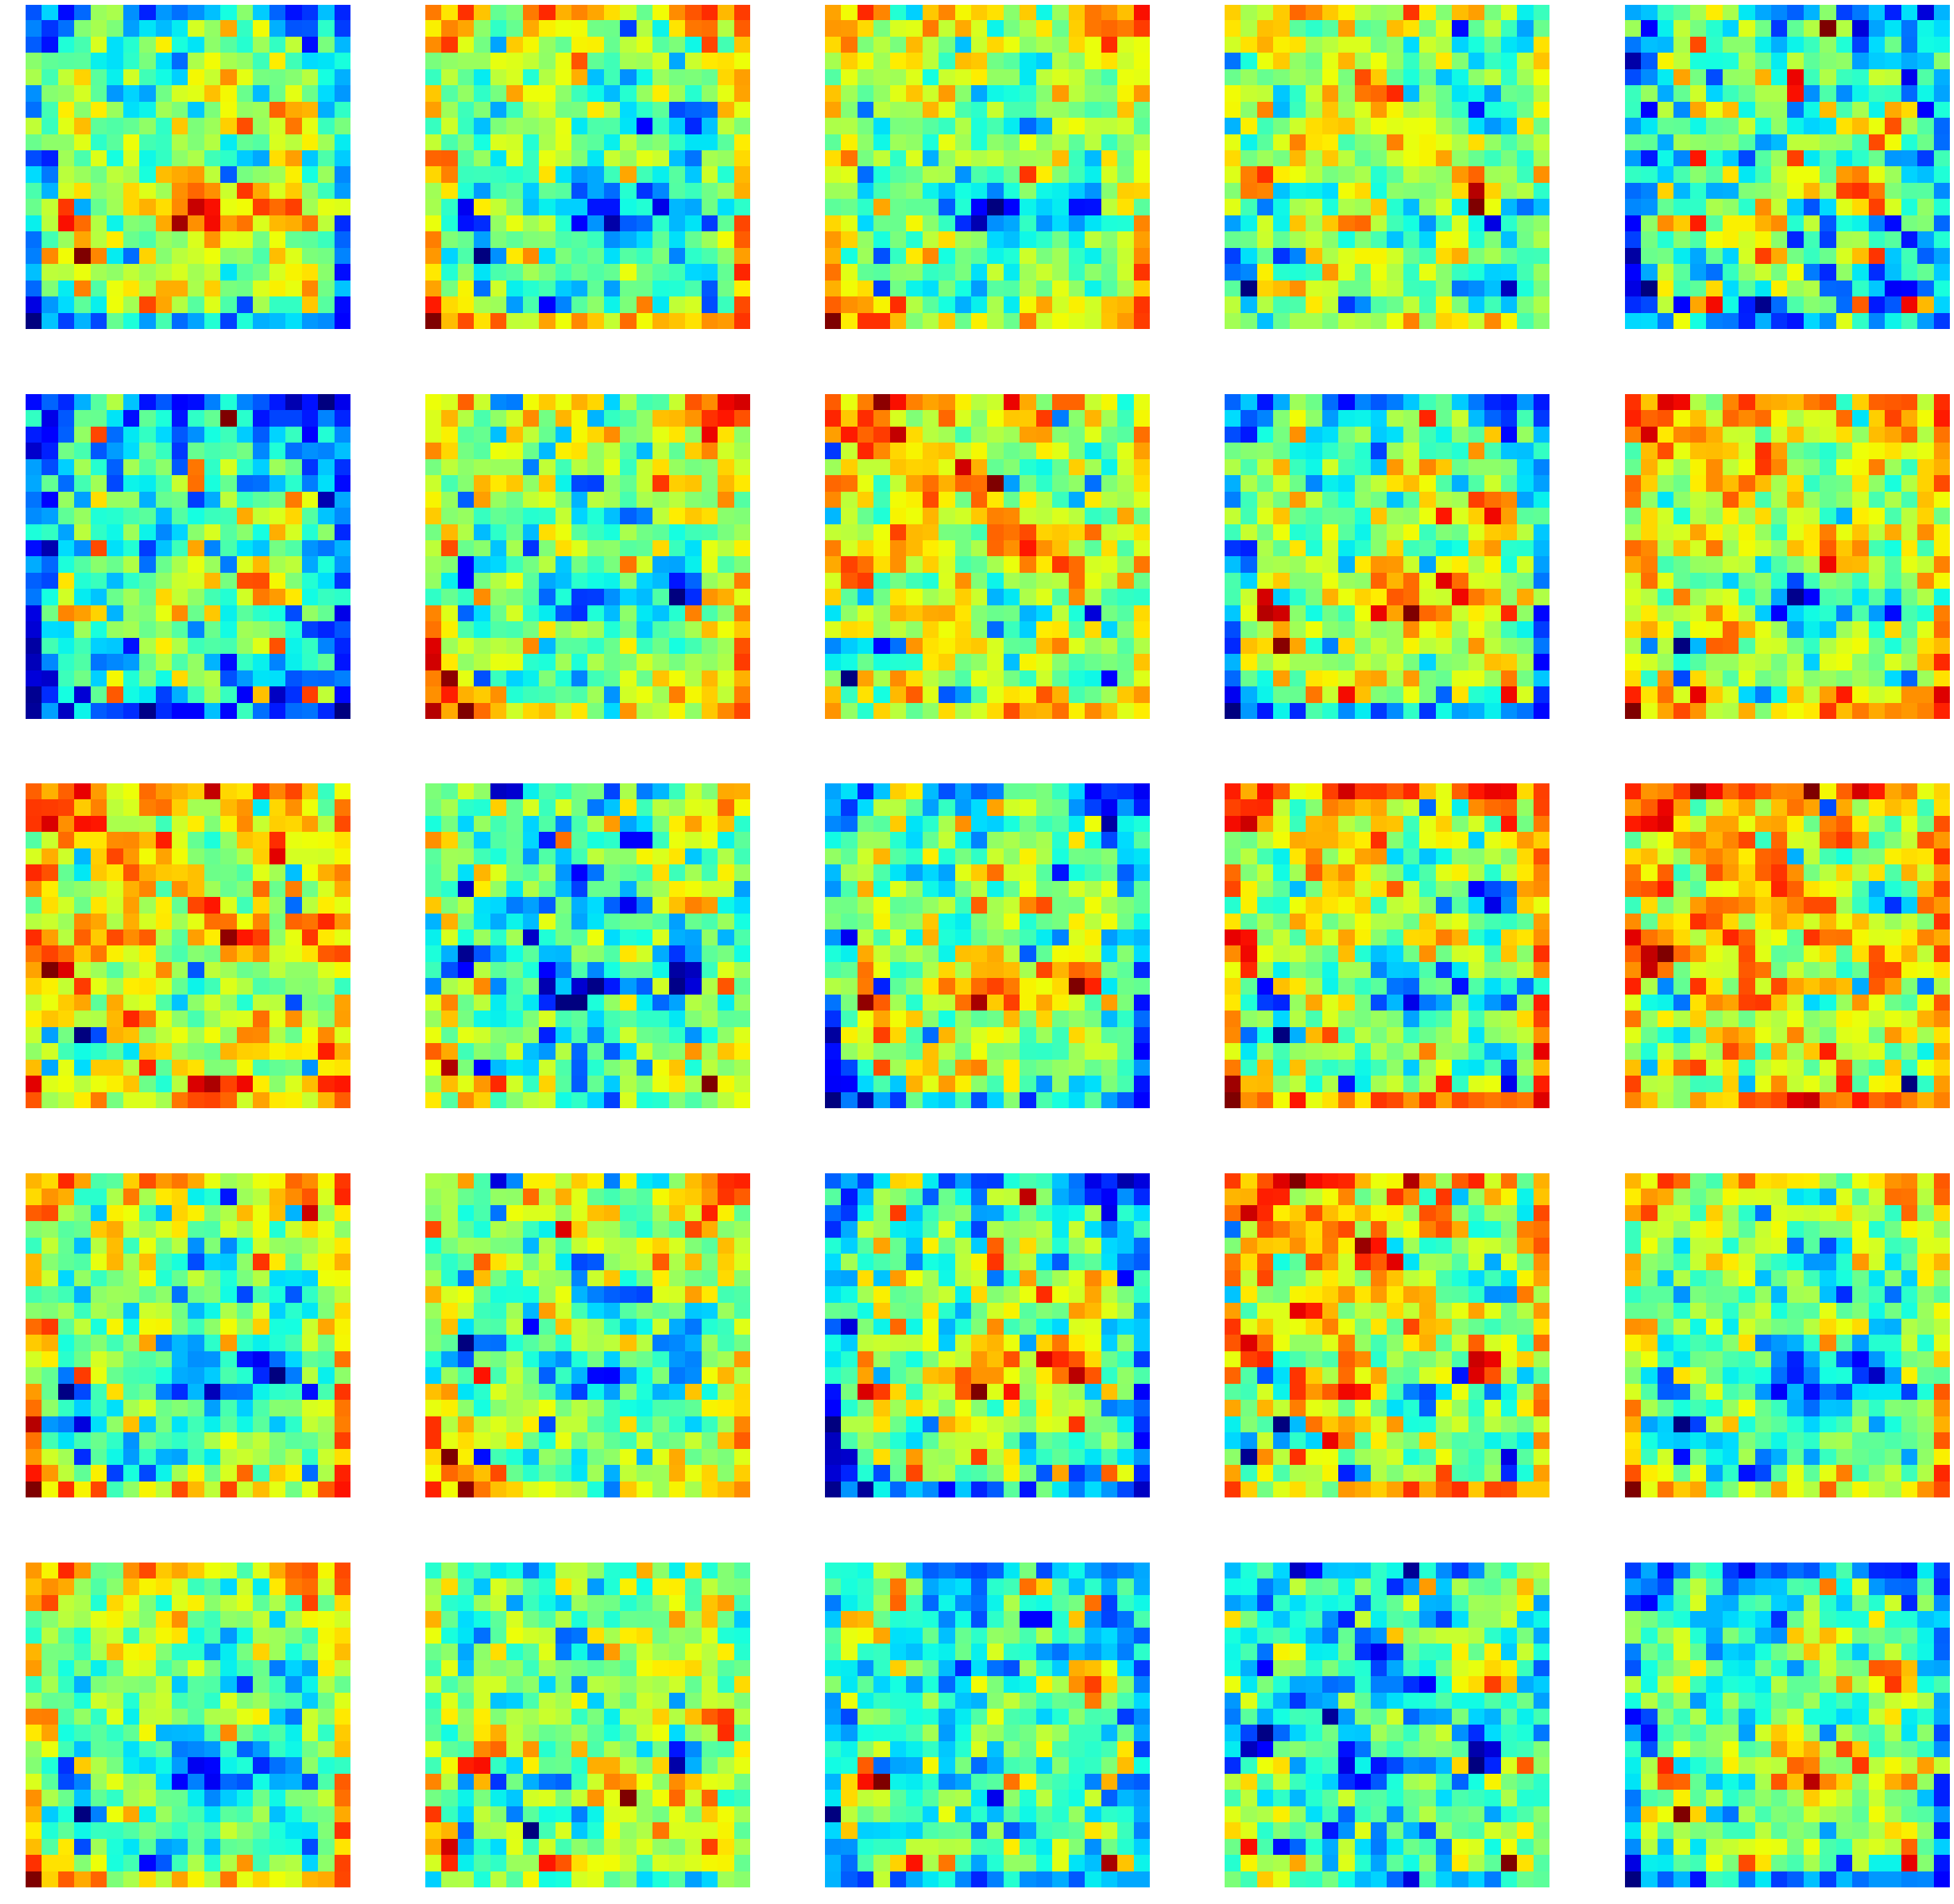

epoch 34, mean loss 7.935973603725433, std loss 0.052753925406398866


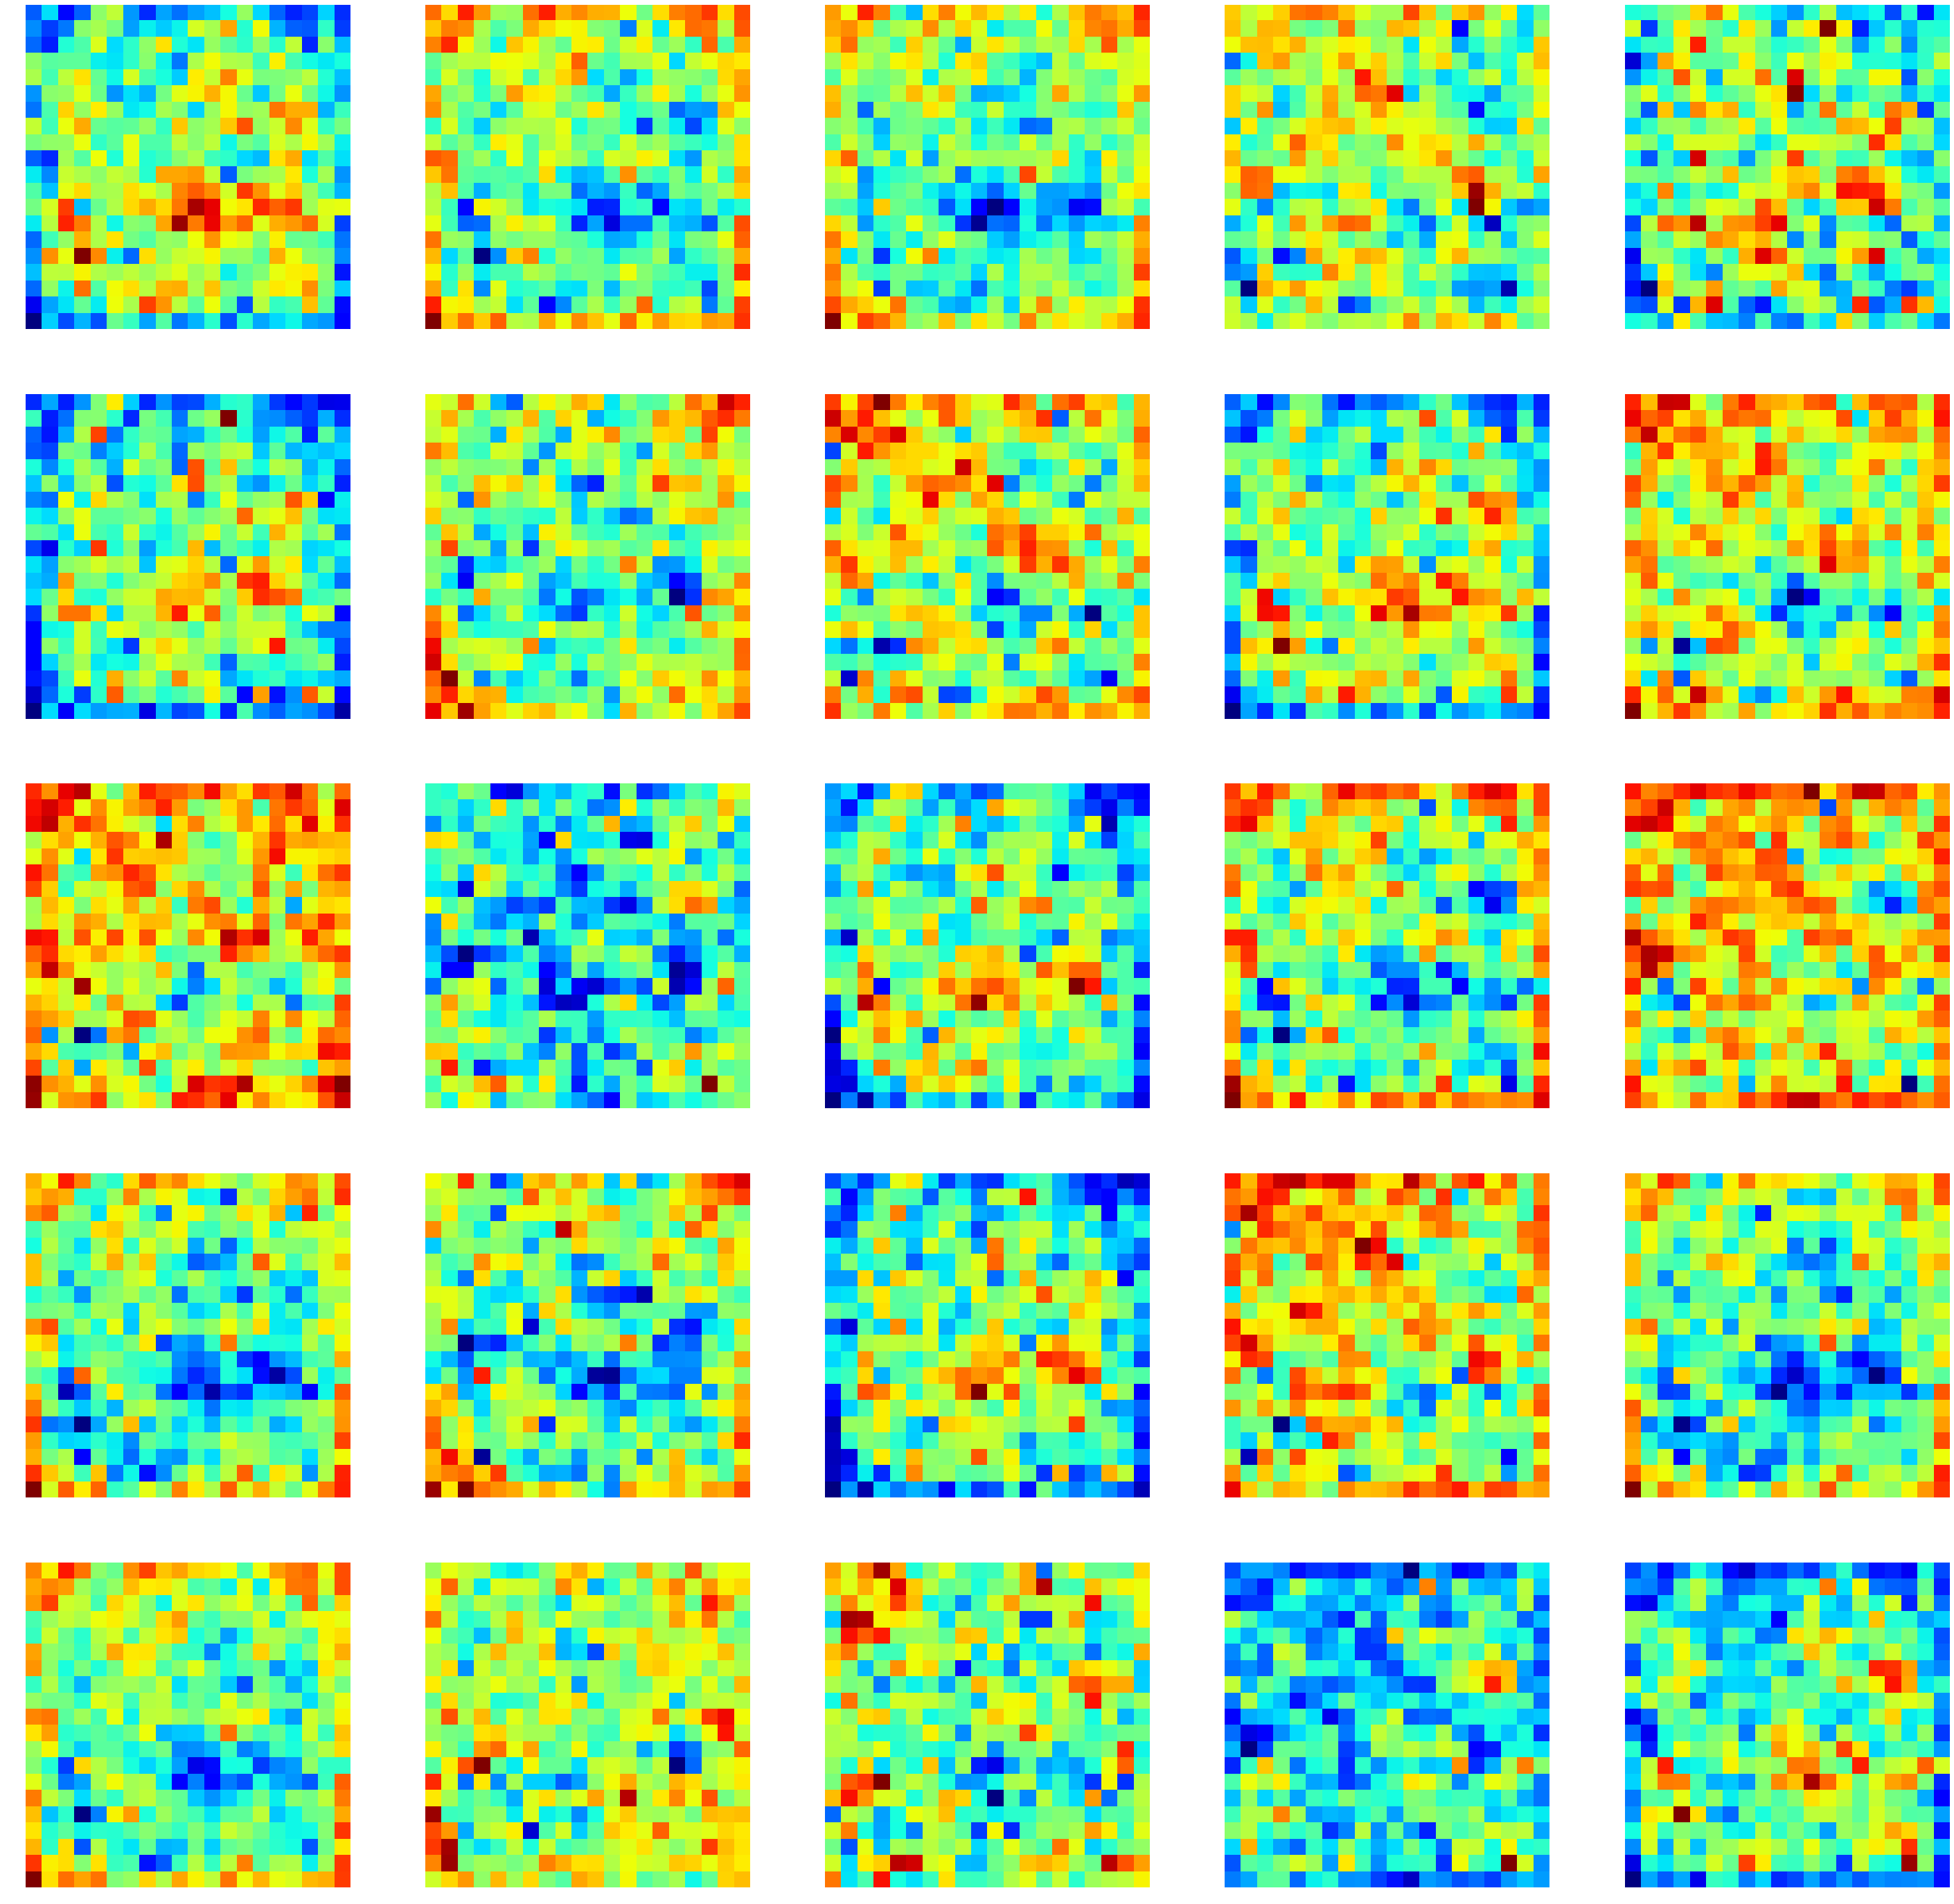

epoch 35, mean loss 7.935499012470245, std loss 0.05342735966869609


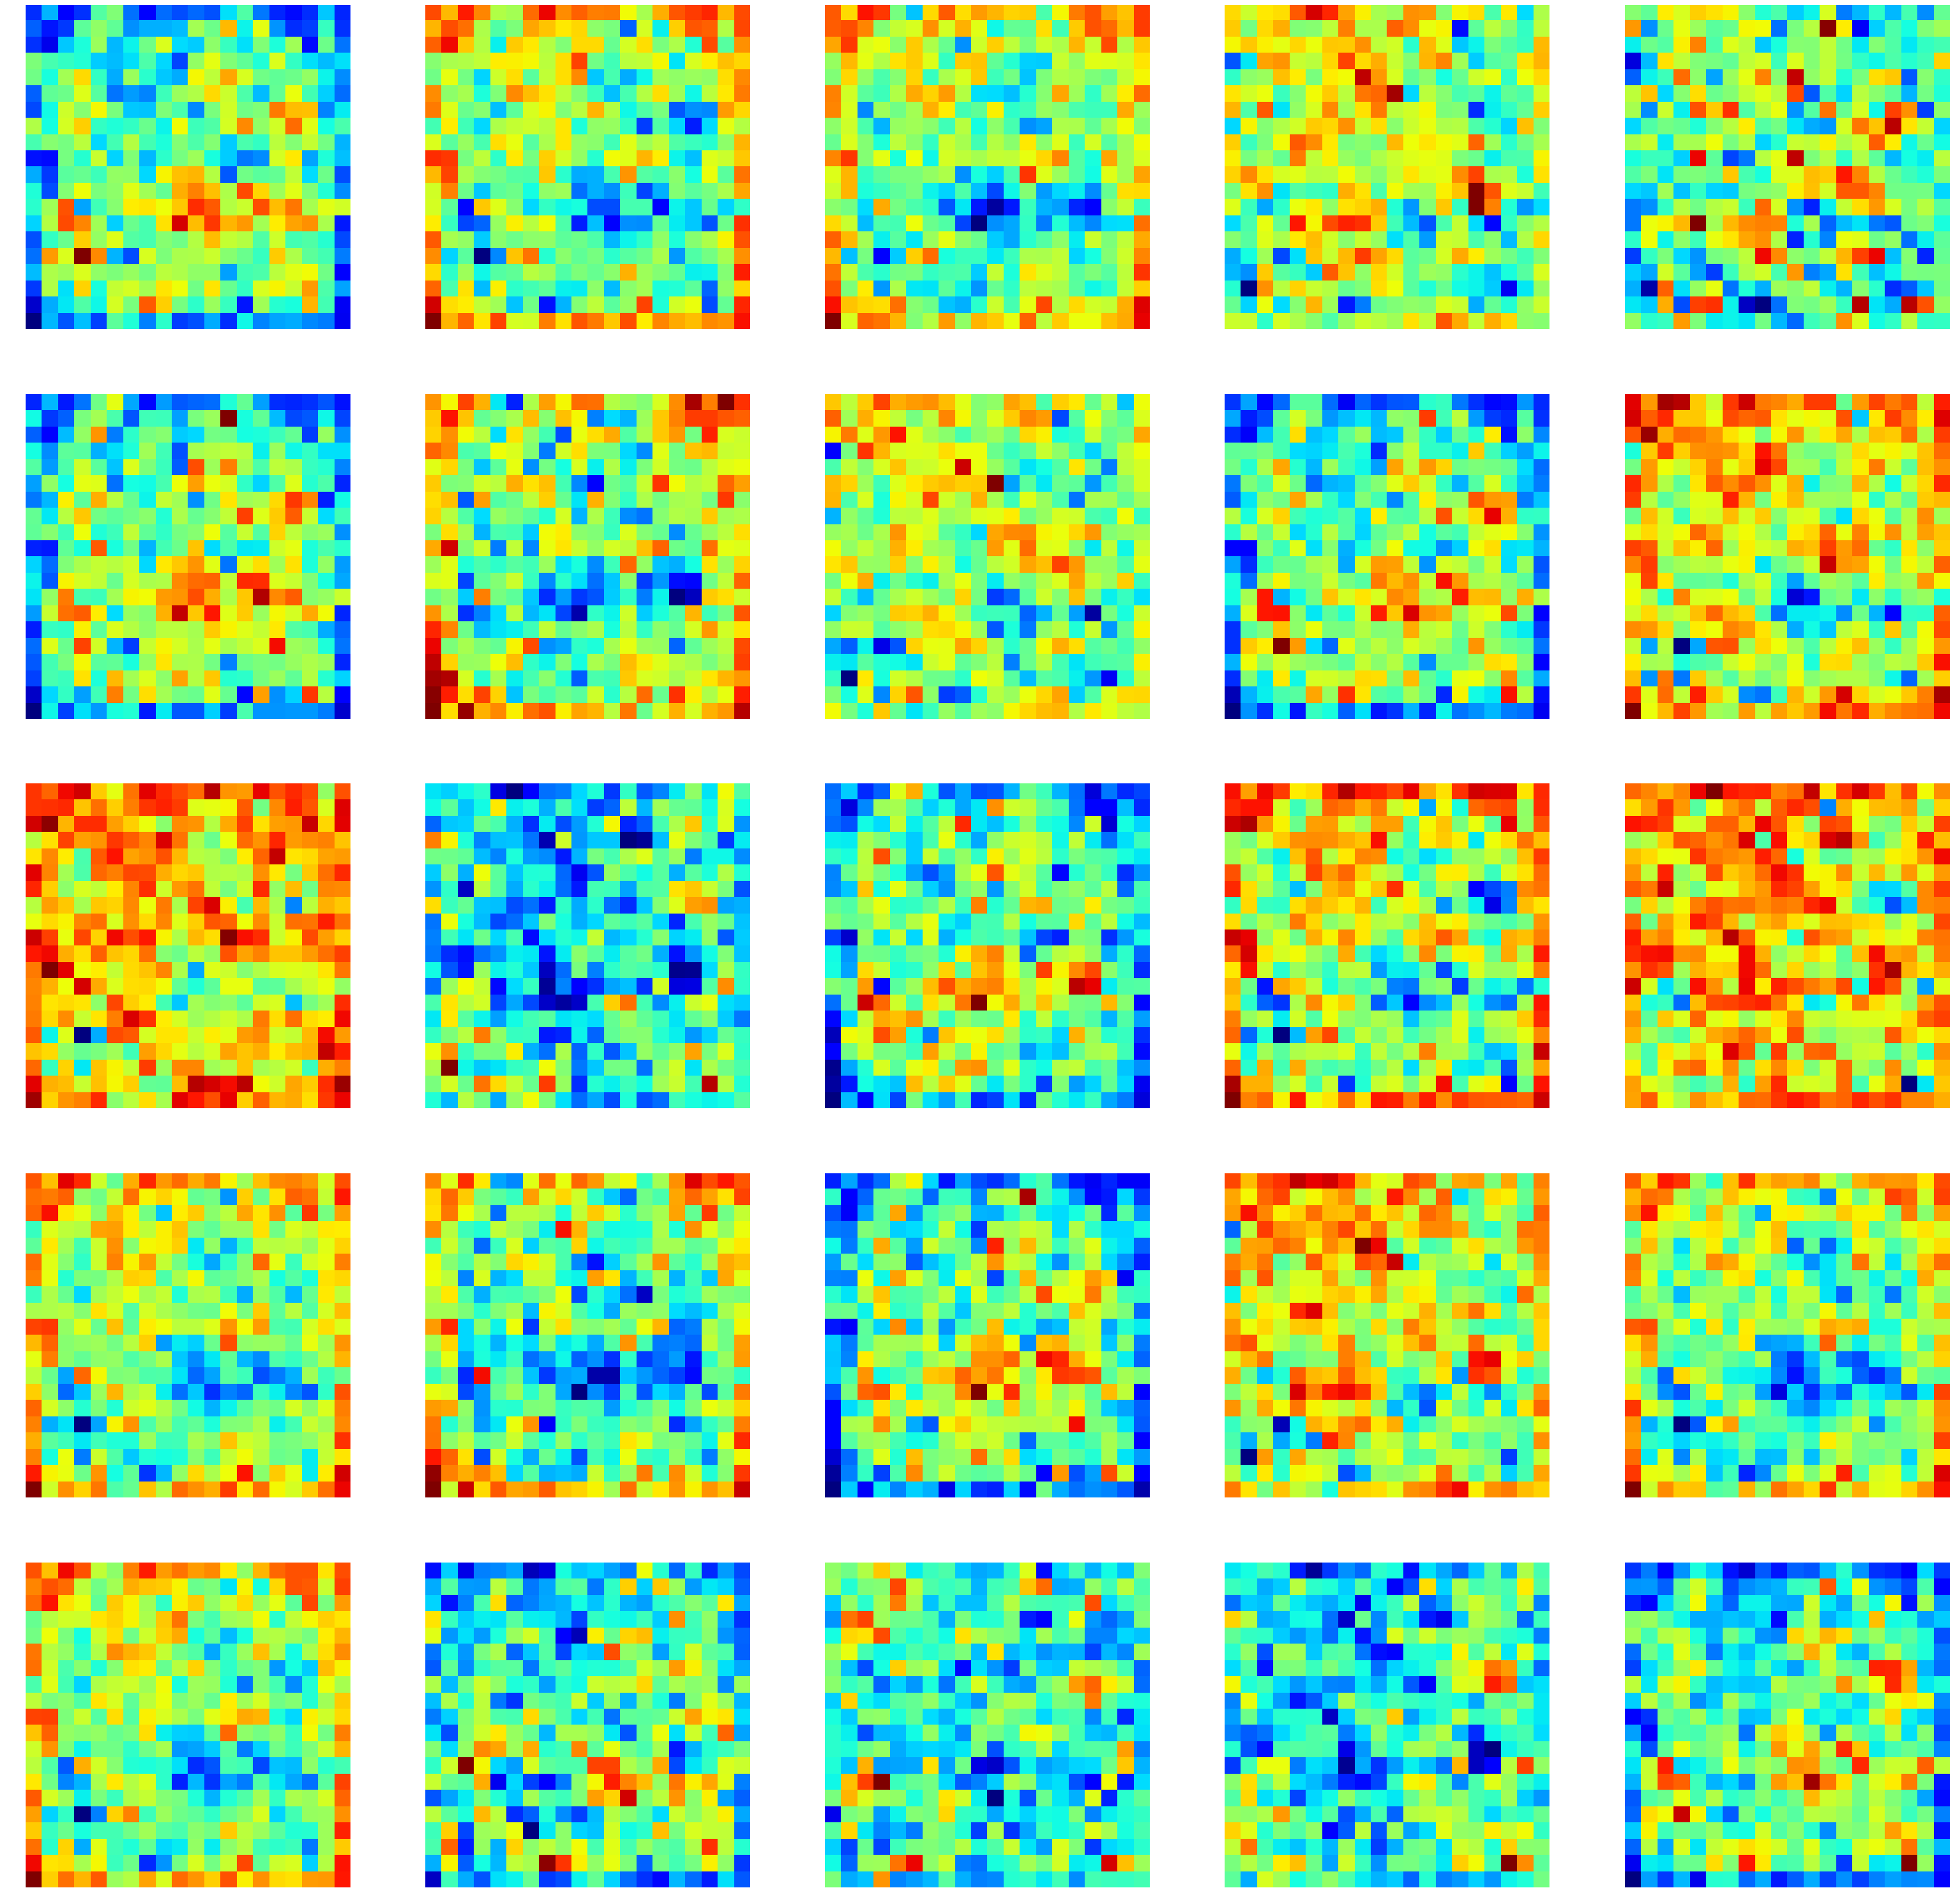

epoch 36, mean loss 7.934737222671509, std loss 0.05358762134948589


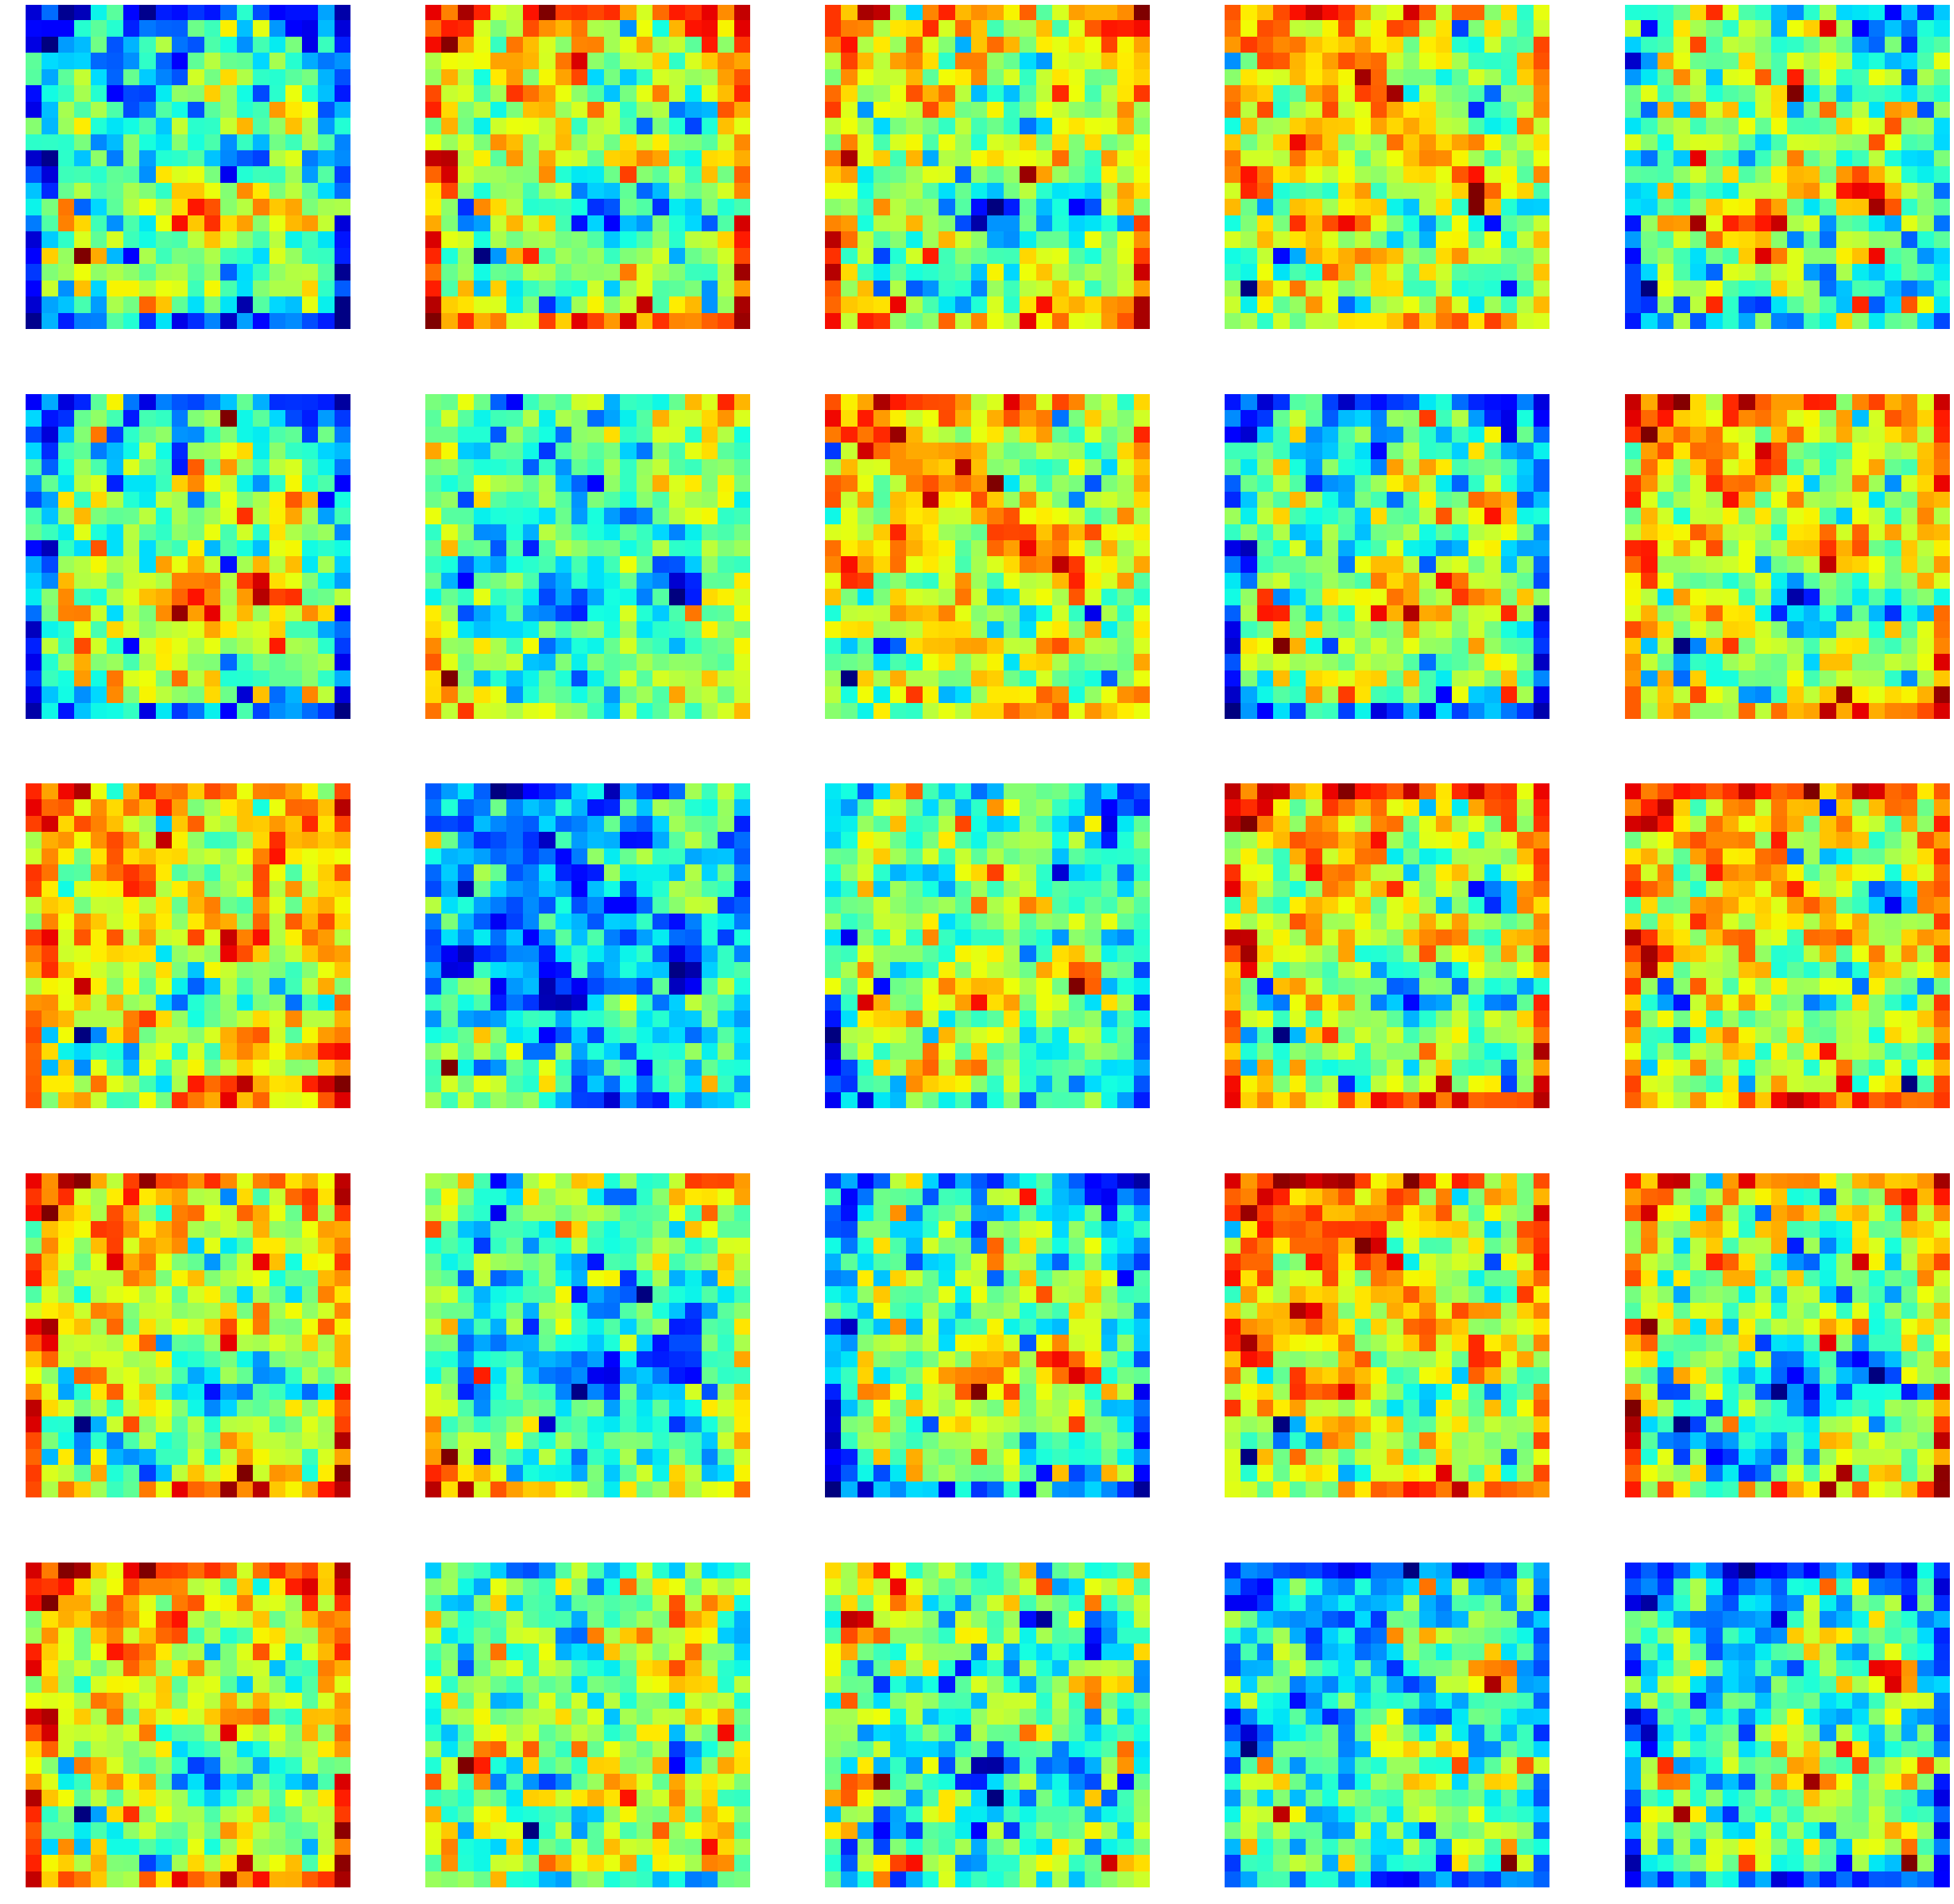

epoch 37, mean loss 7.93461311340332, std loss 0.053106743545353836


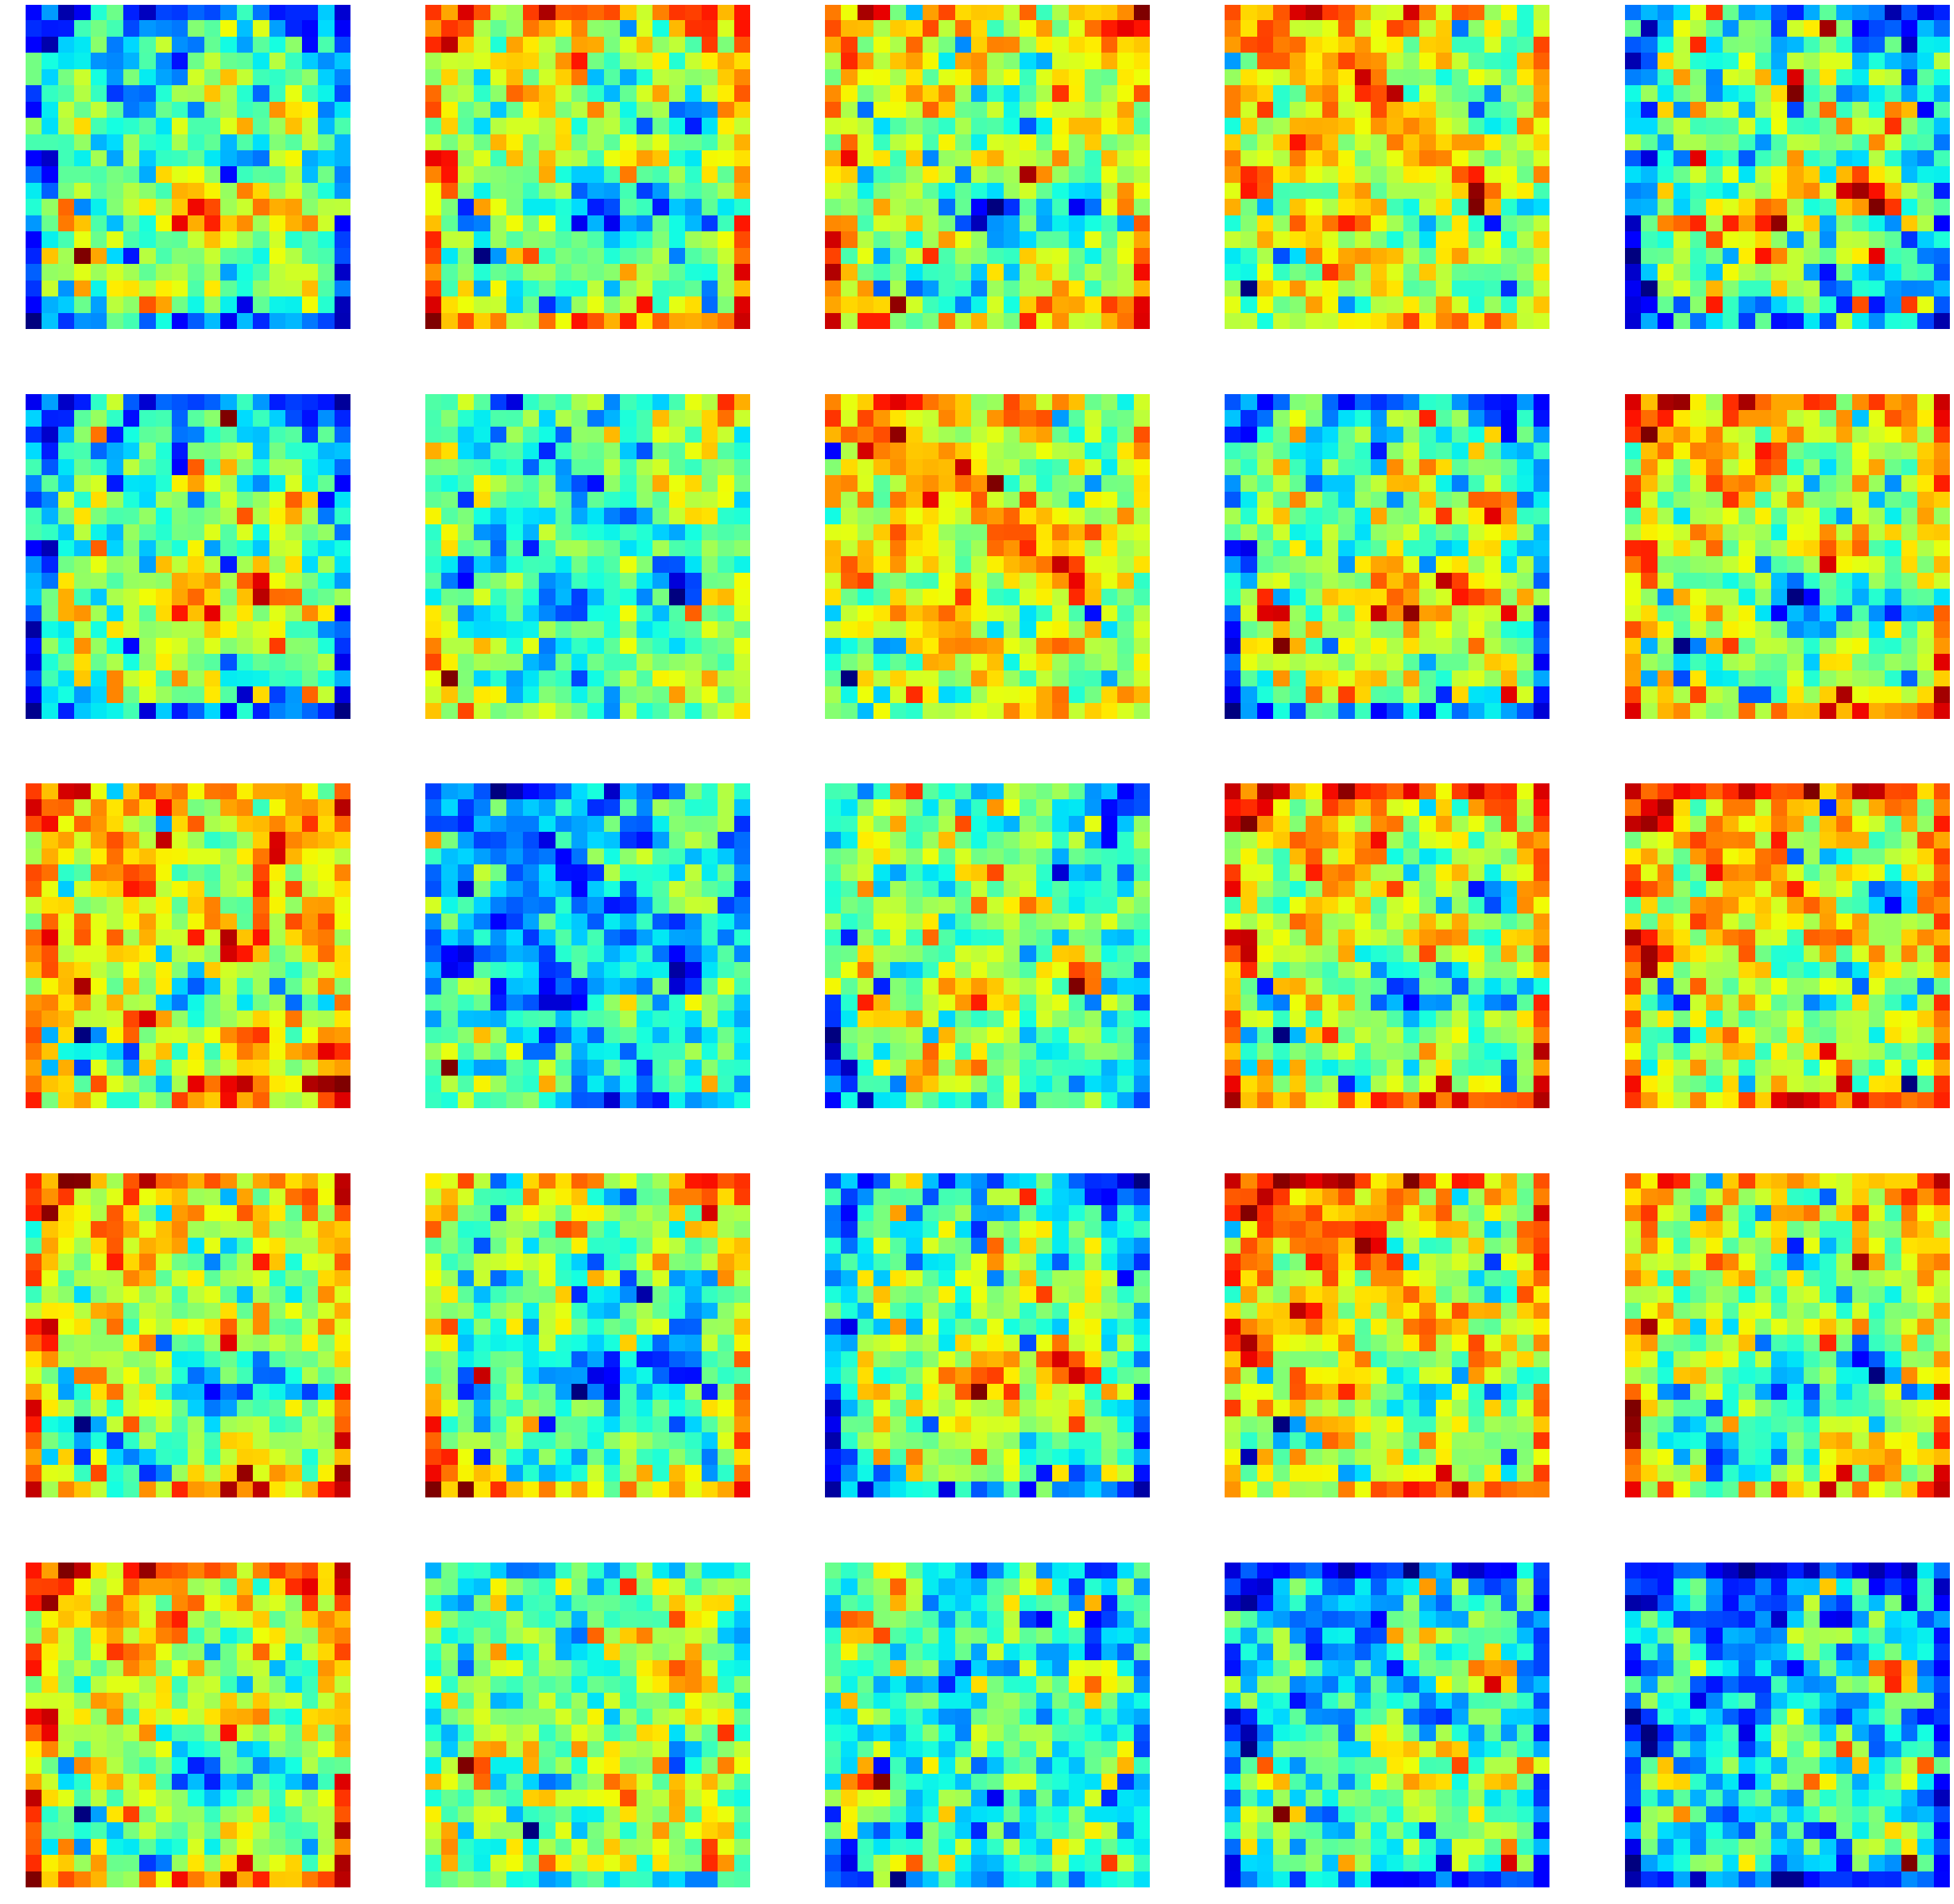

epoch 38, mean loss 7.934032959938049, std loss 0.05280004336648902


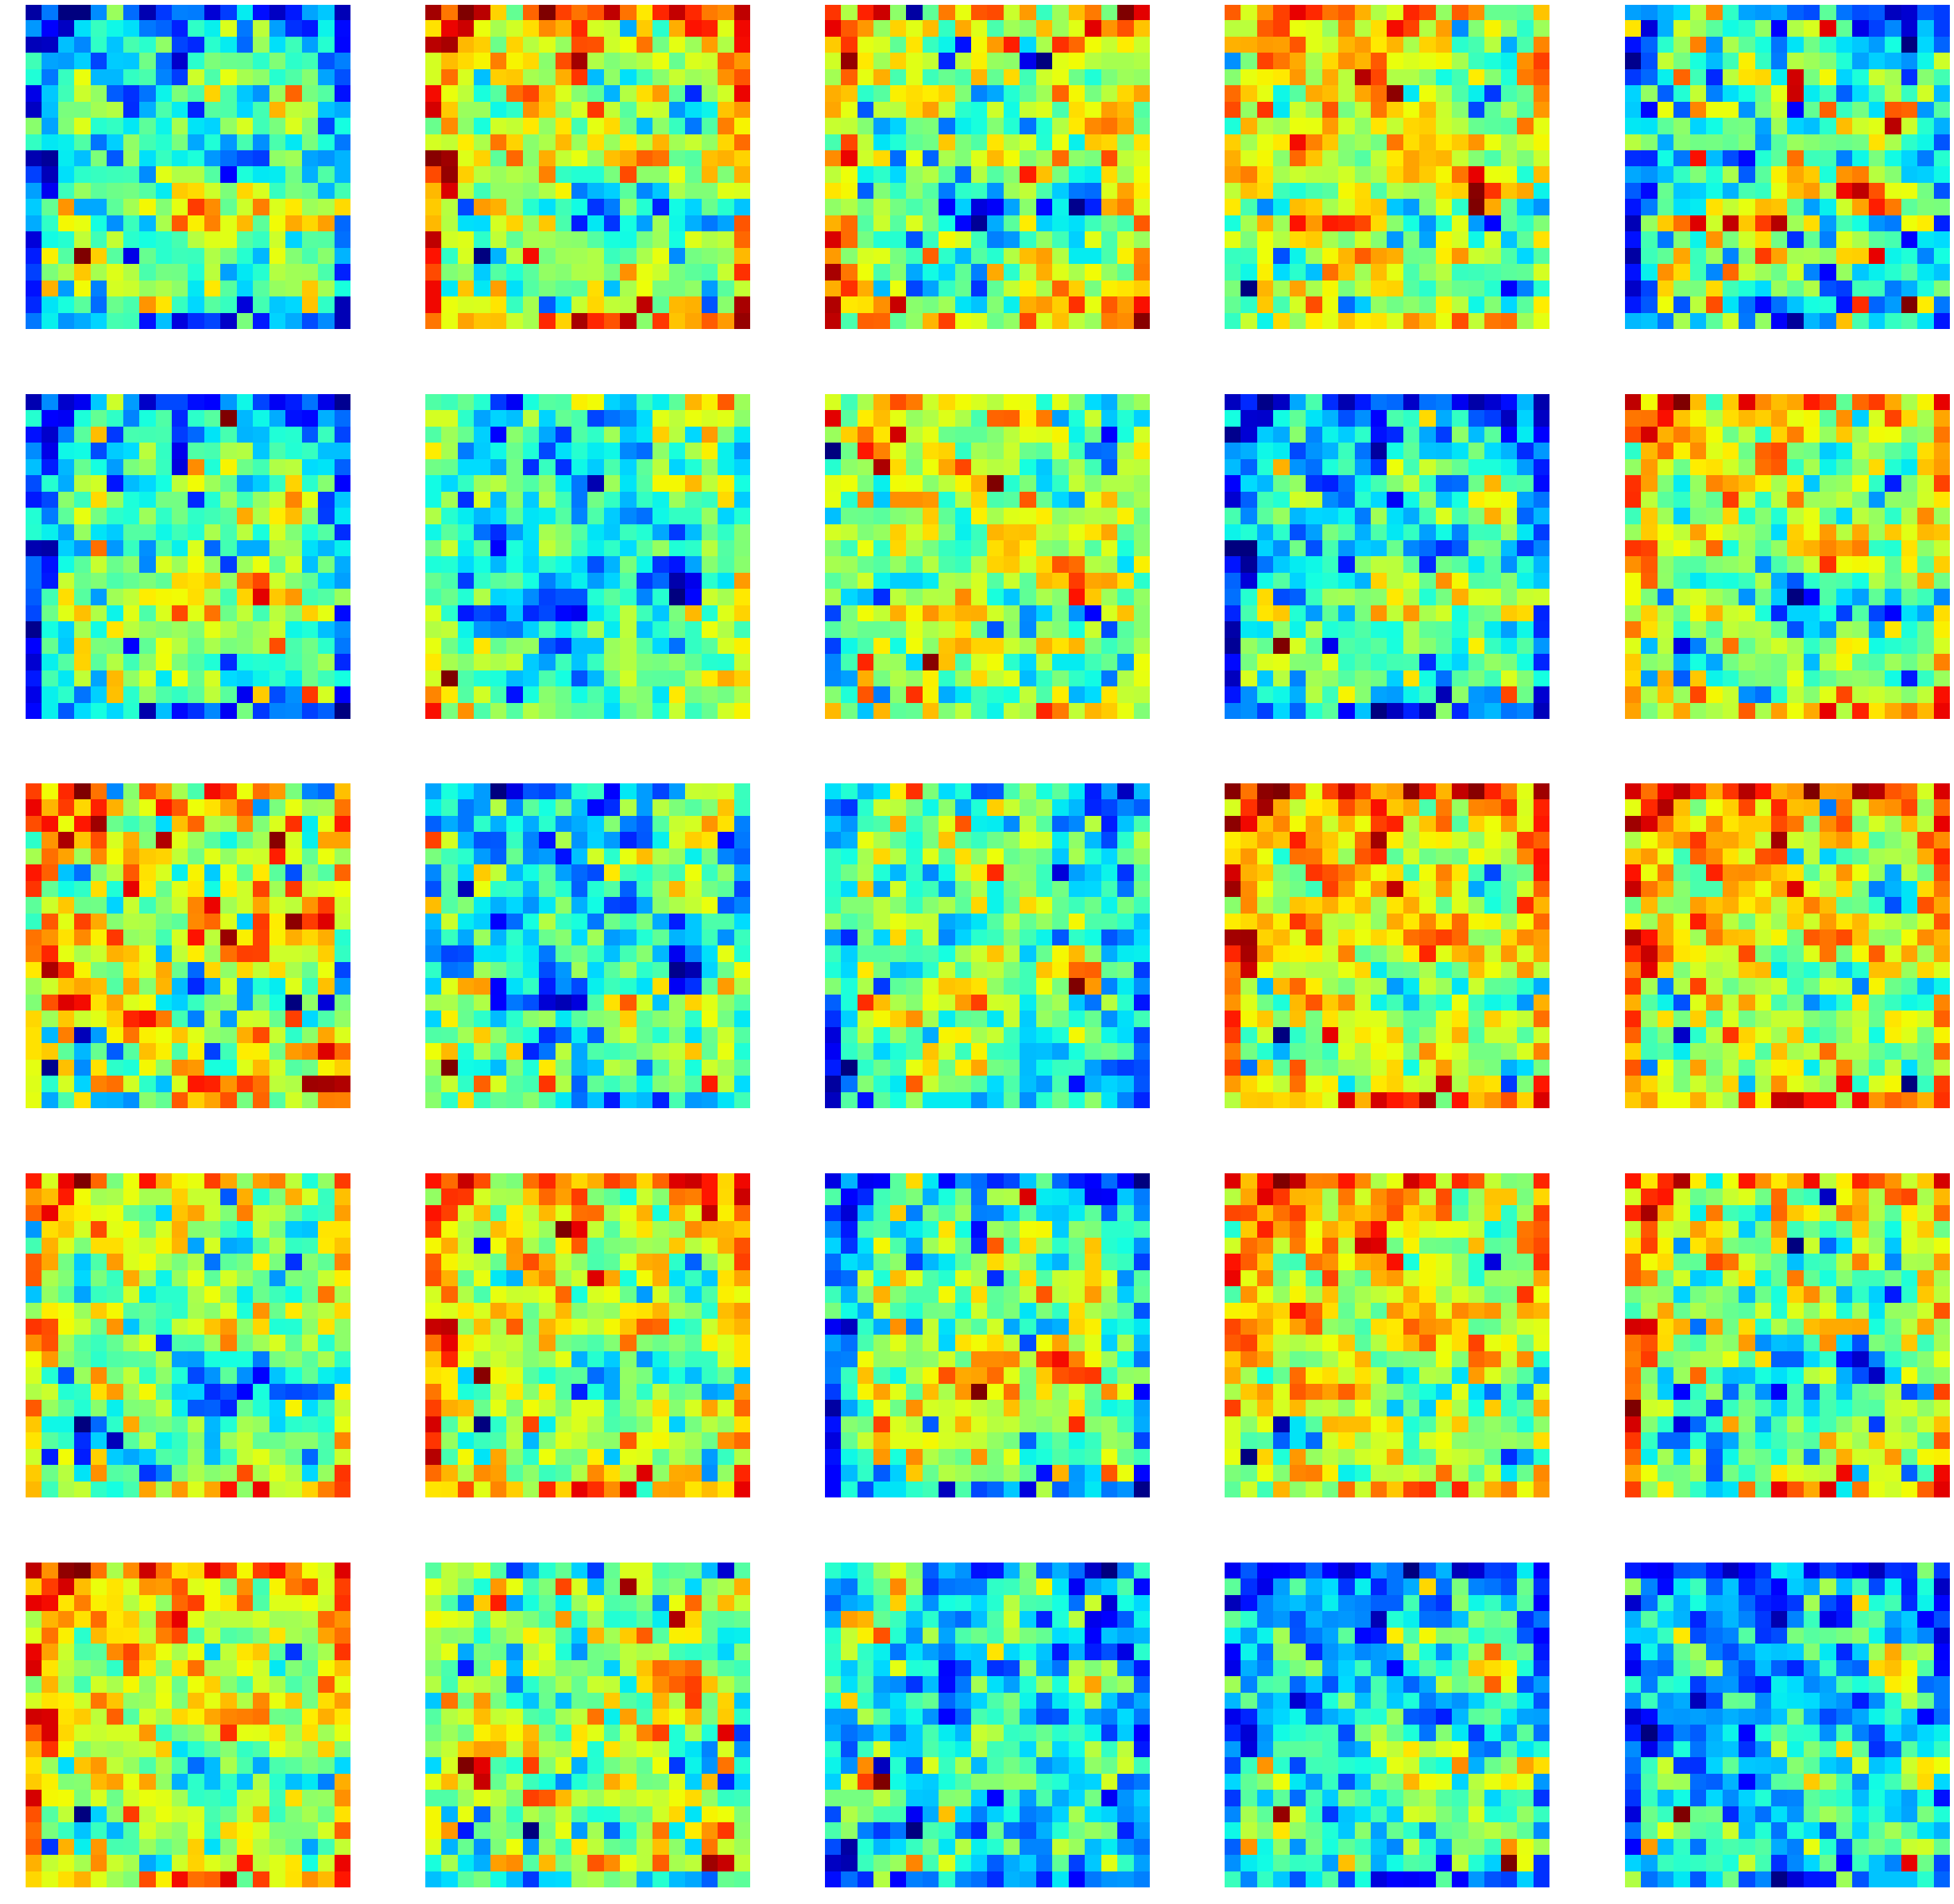

epoch 39, mean loss 7.933941270828247, std loss 0.052808035186735915


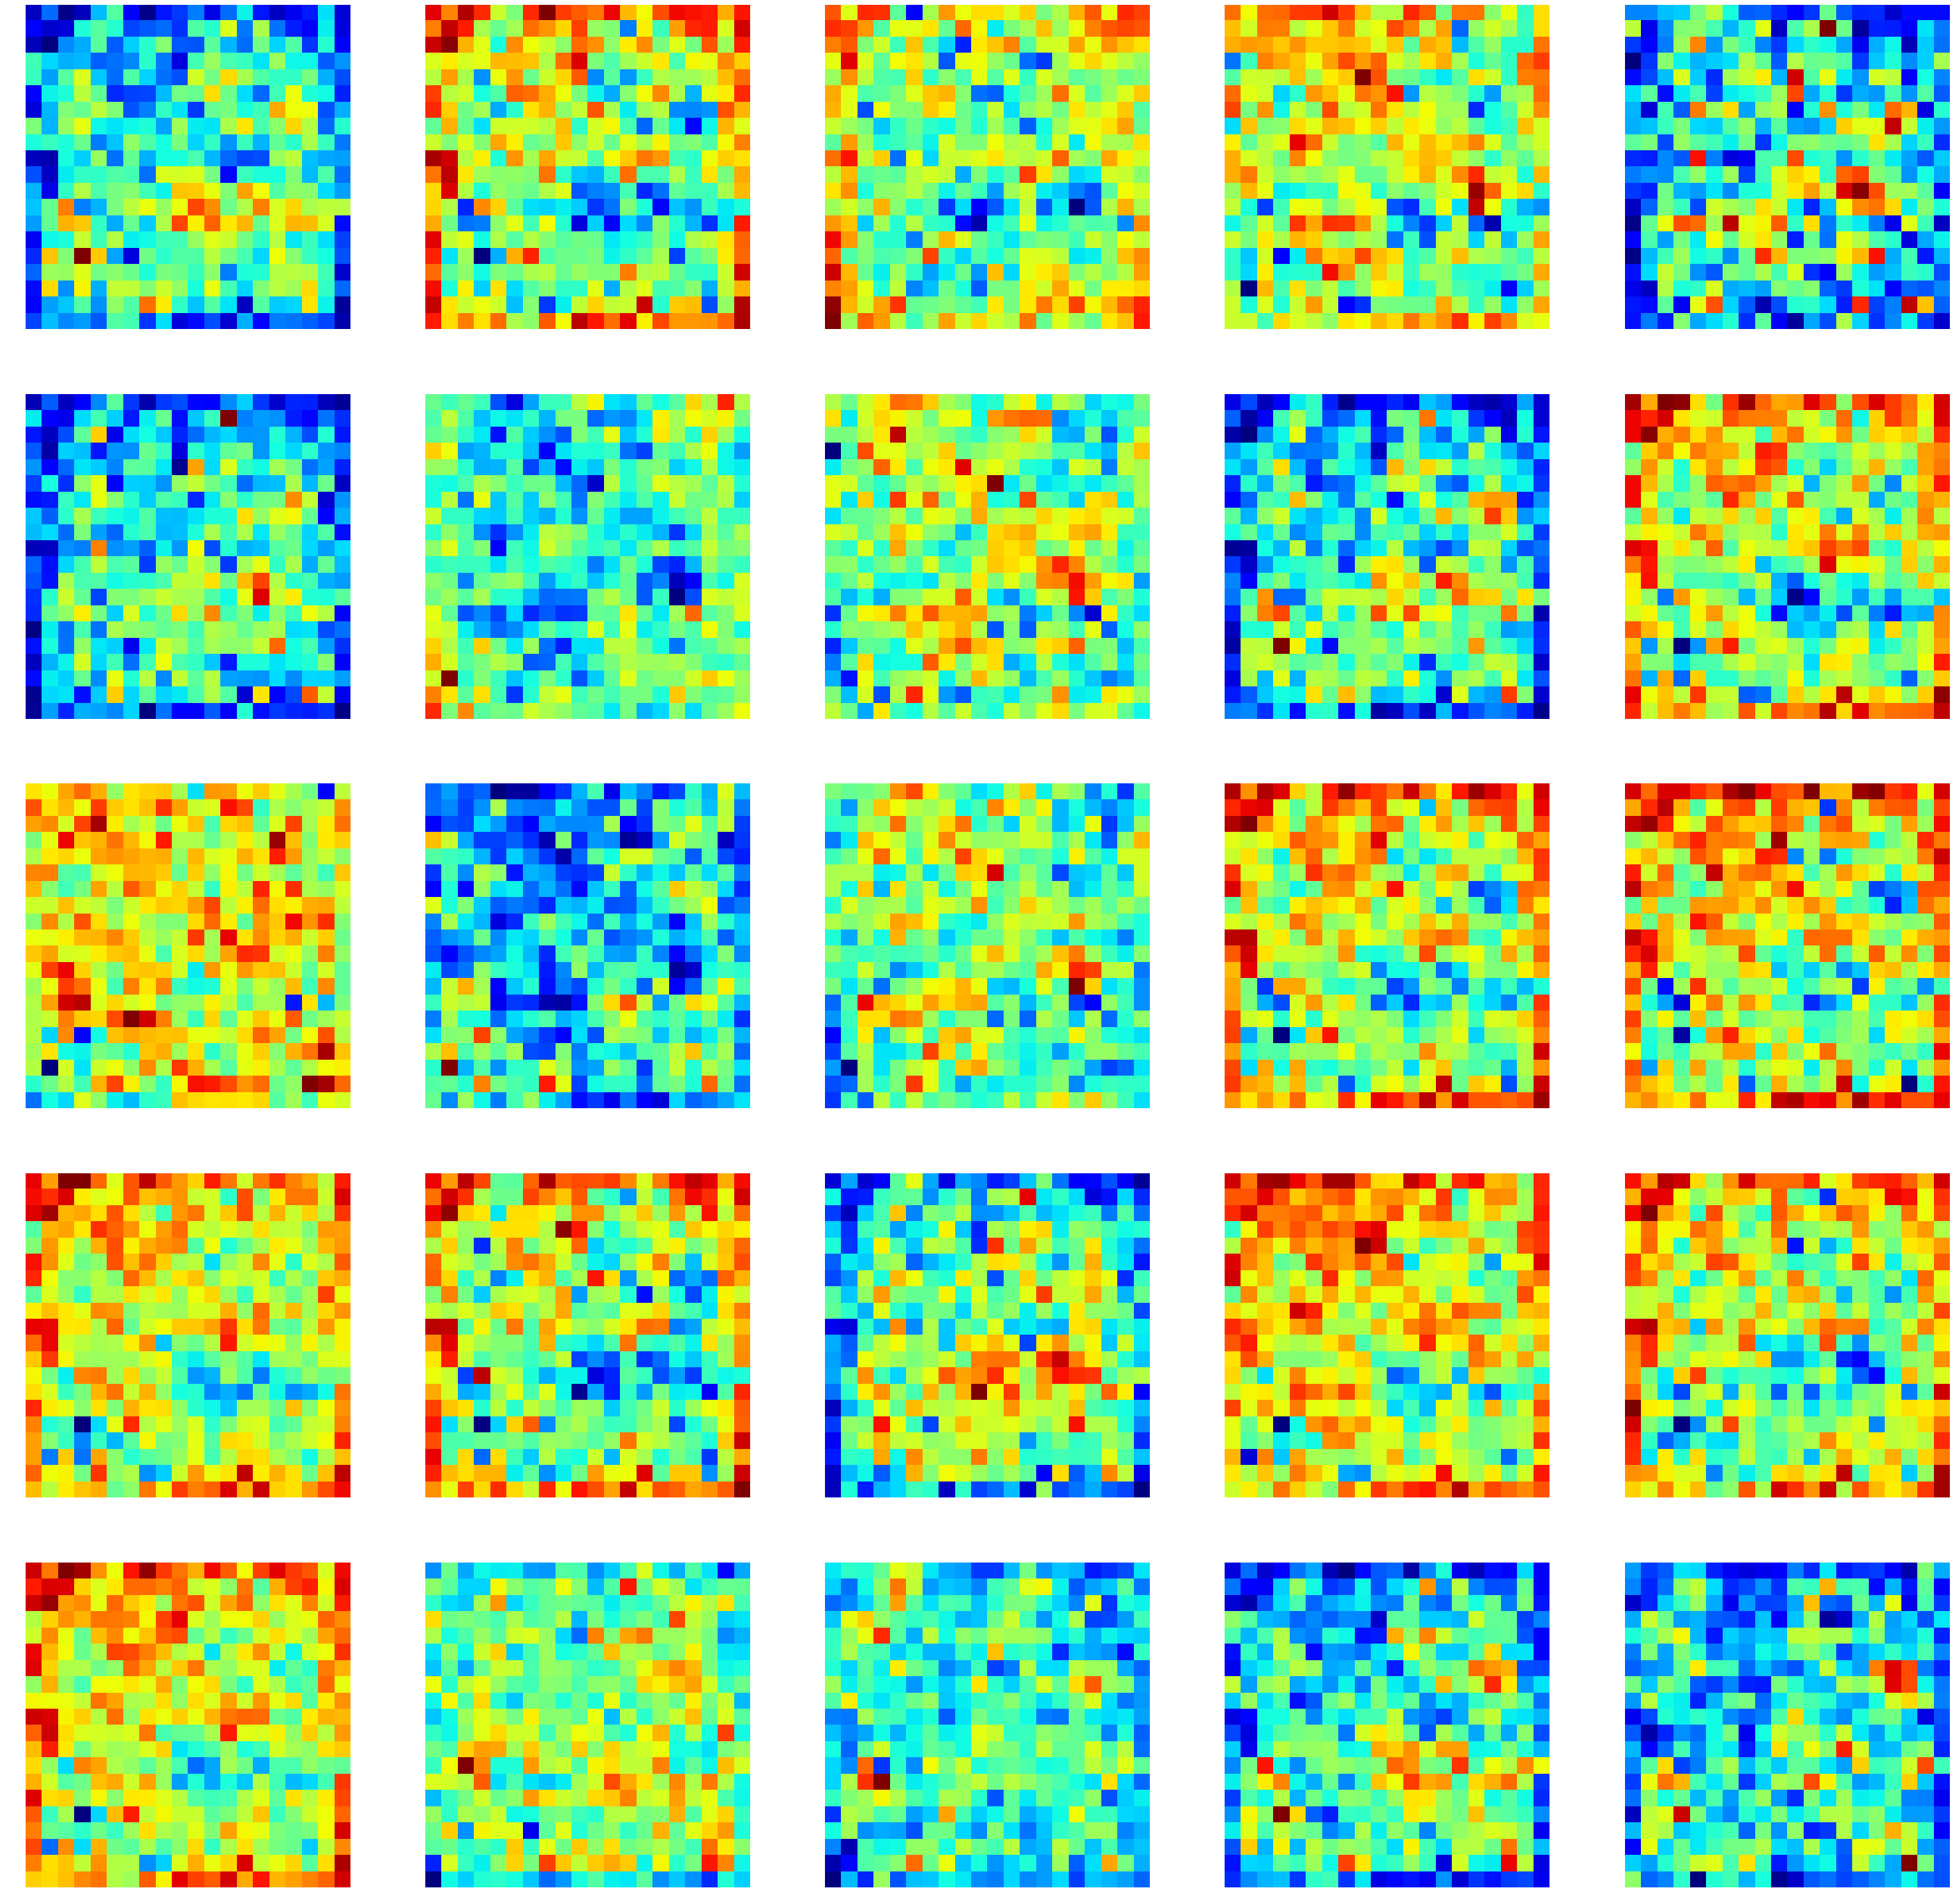

epoch 40, mean loss 7.93365842628479, std loss 0.05279962248120859


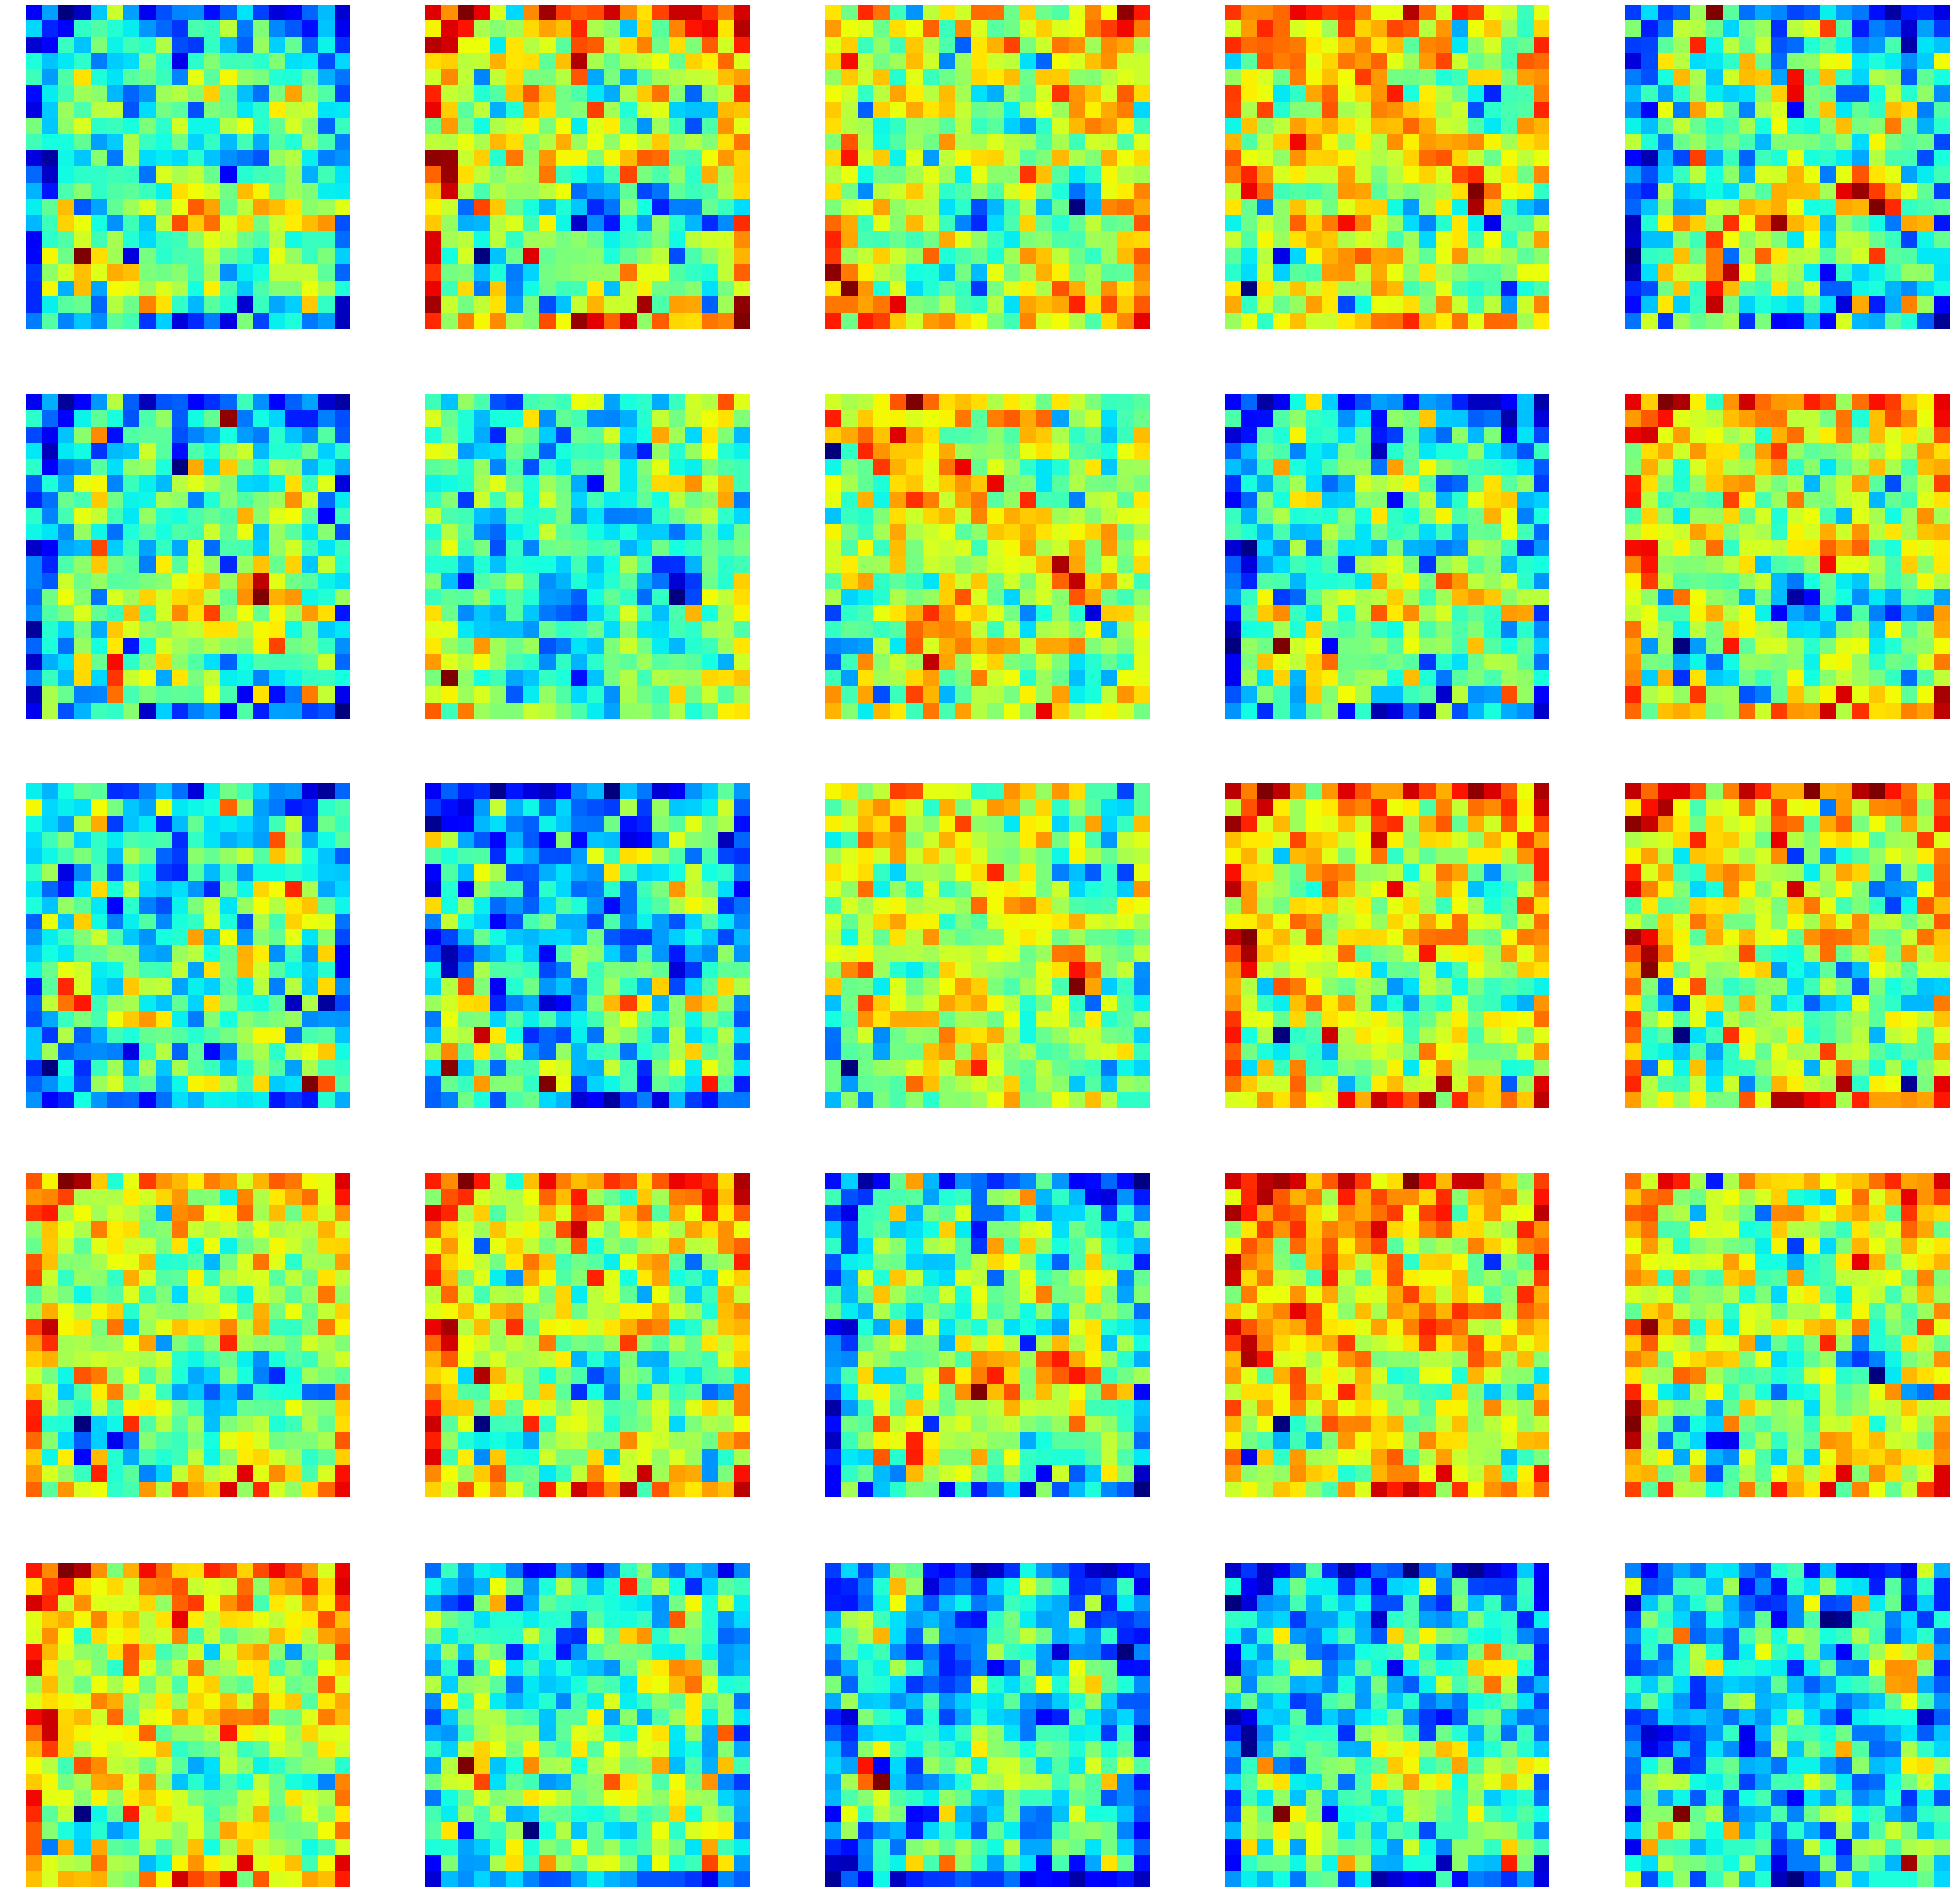

epoch 41, mean loss 7.9334416899681095, std loss 0.05283179374033289


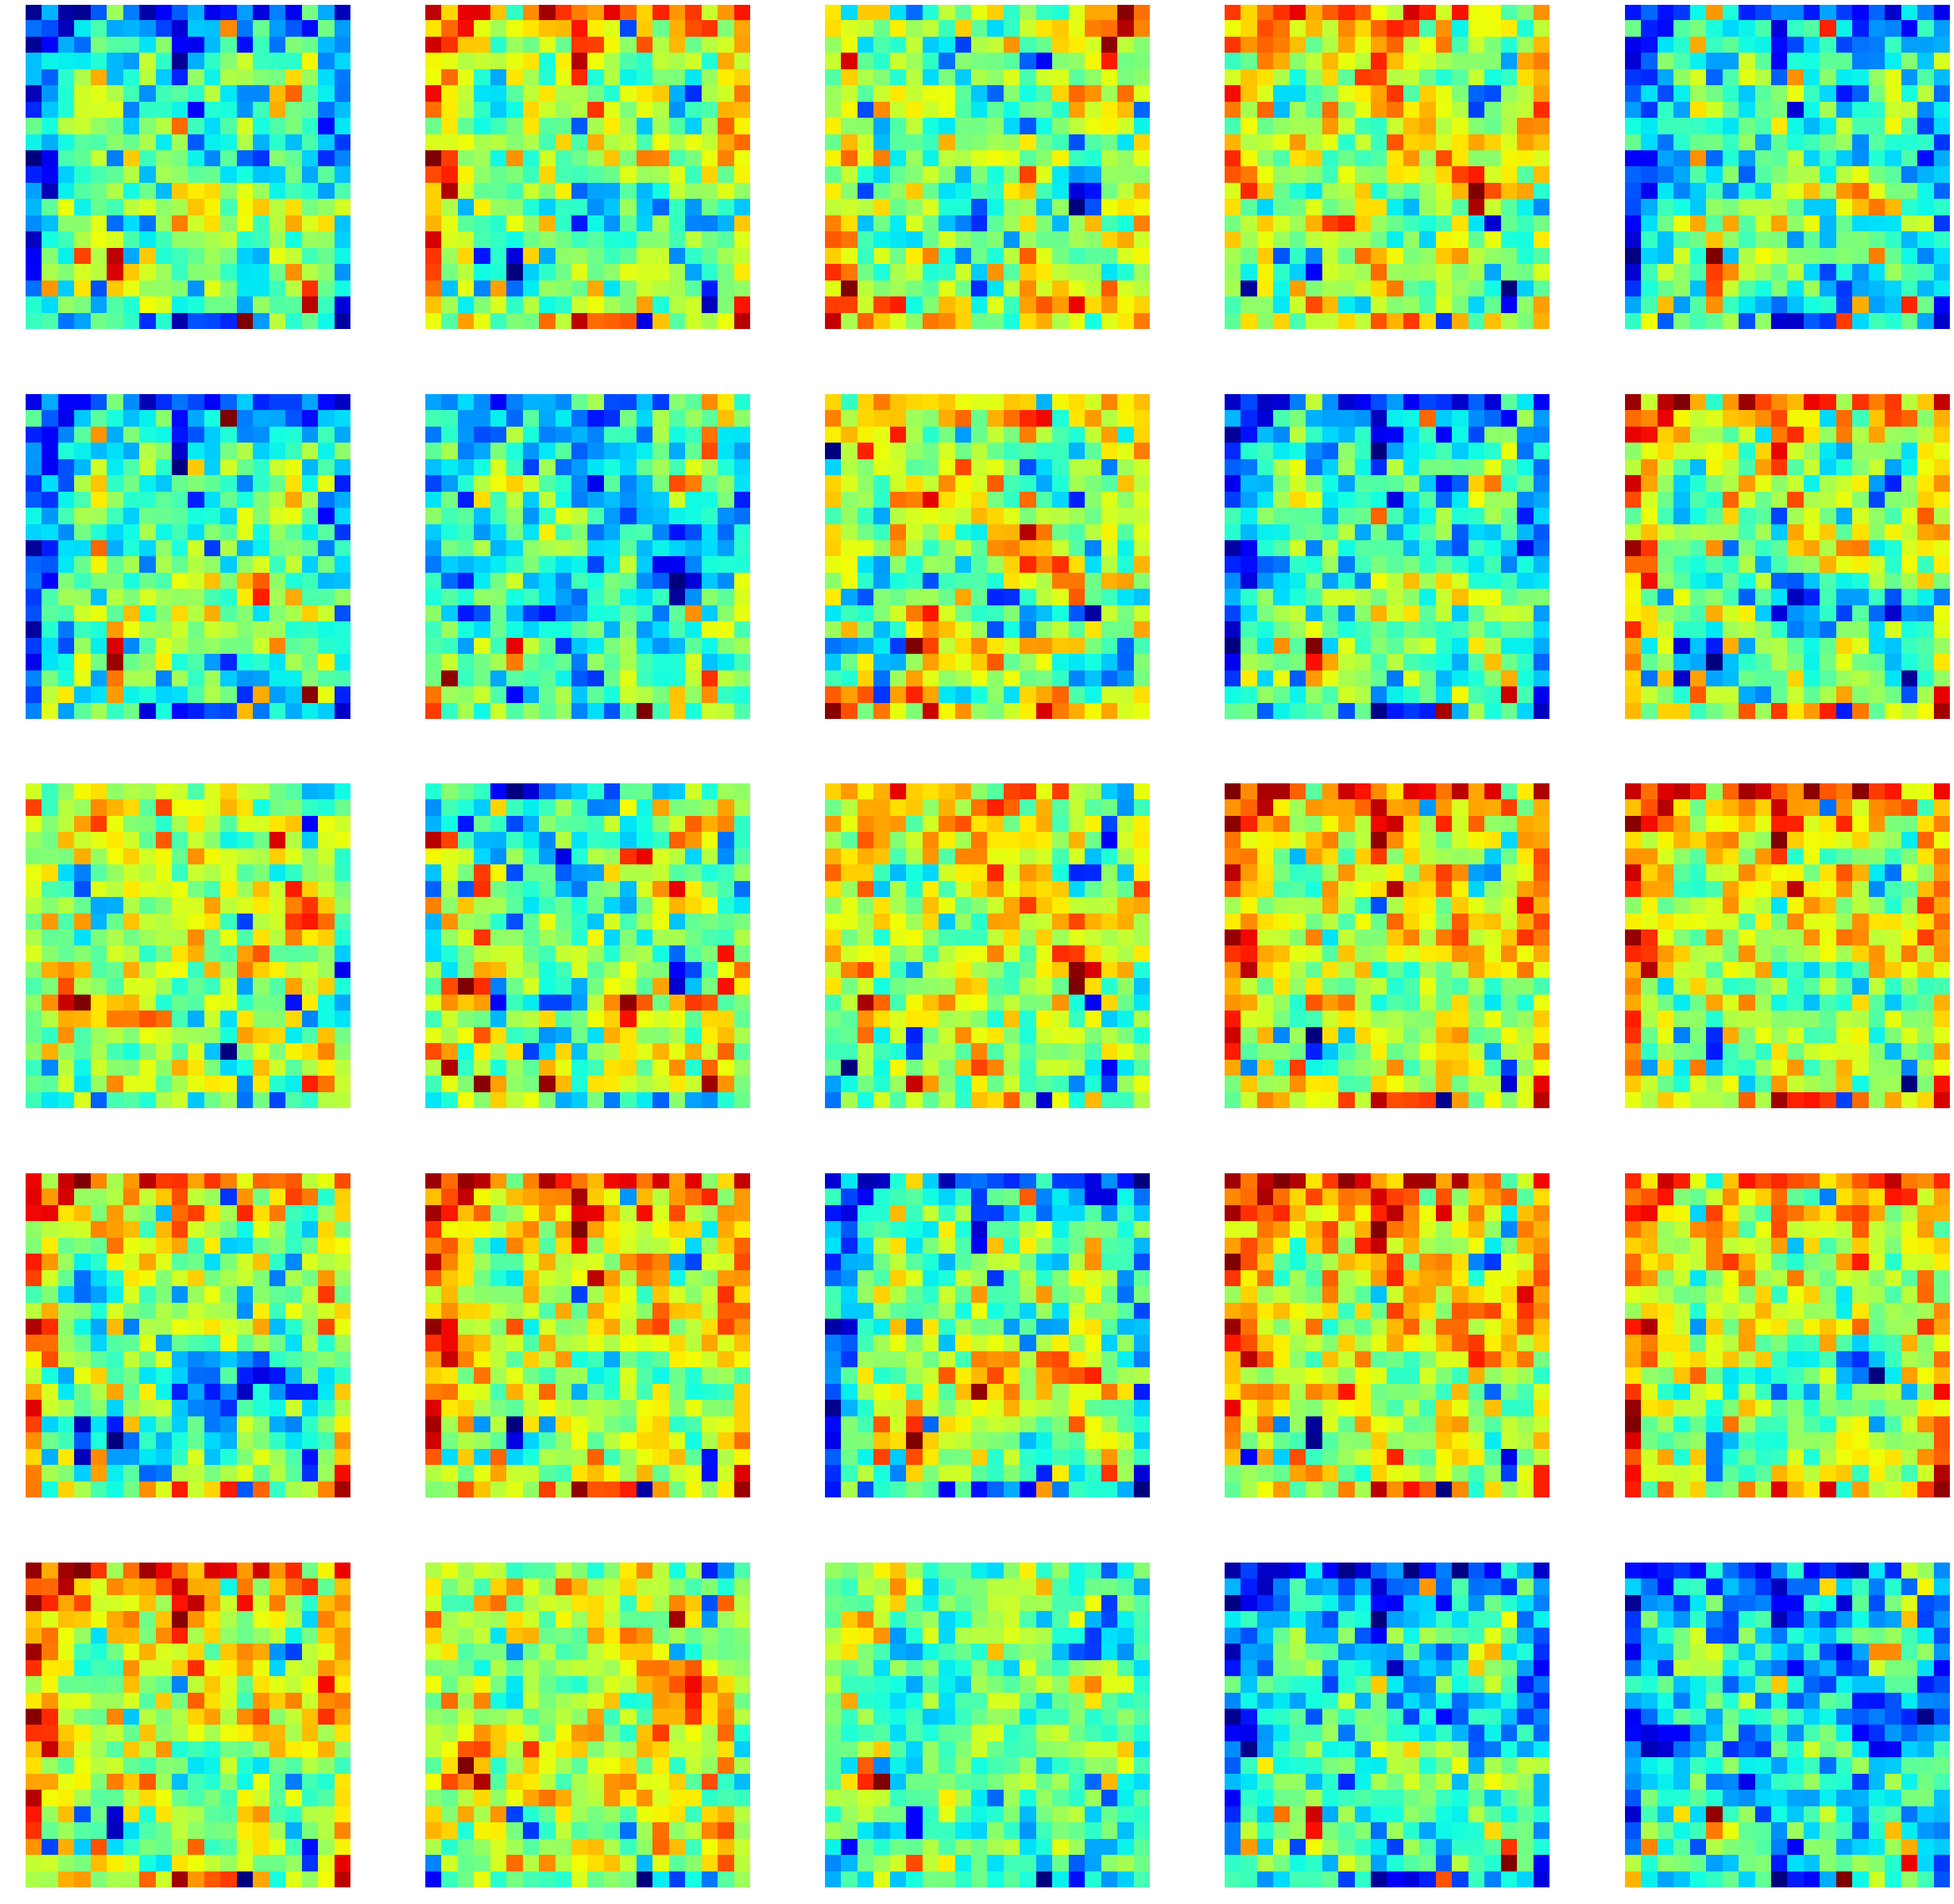

epoch 42, mean loss 7.933217373371124, std loss 0.05328063702612931


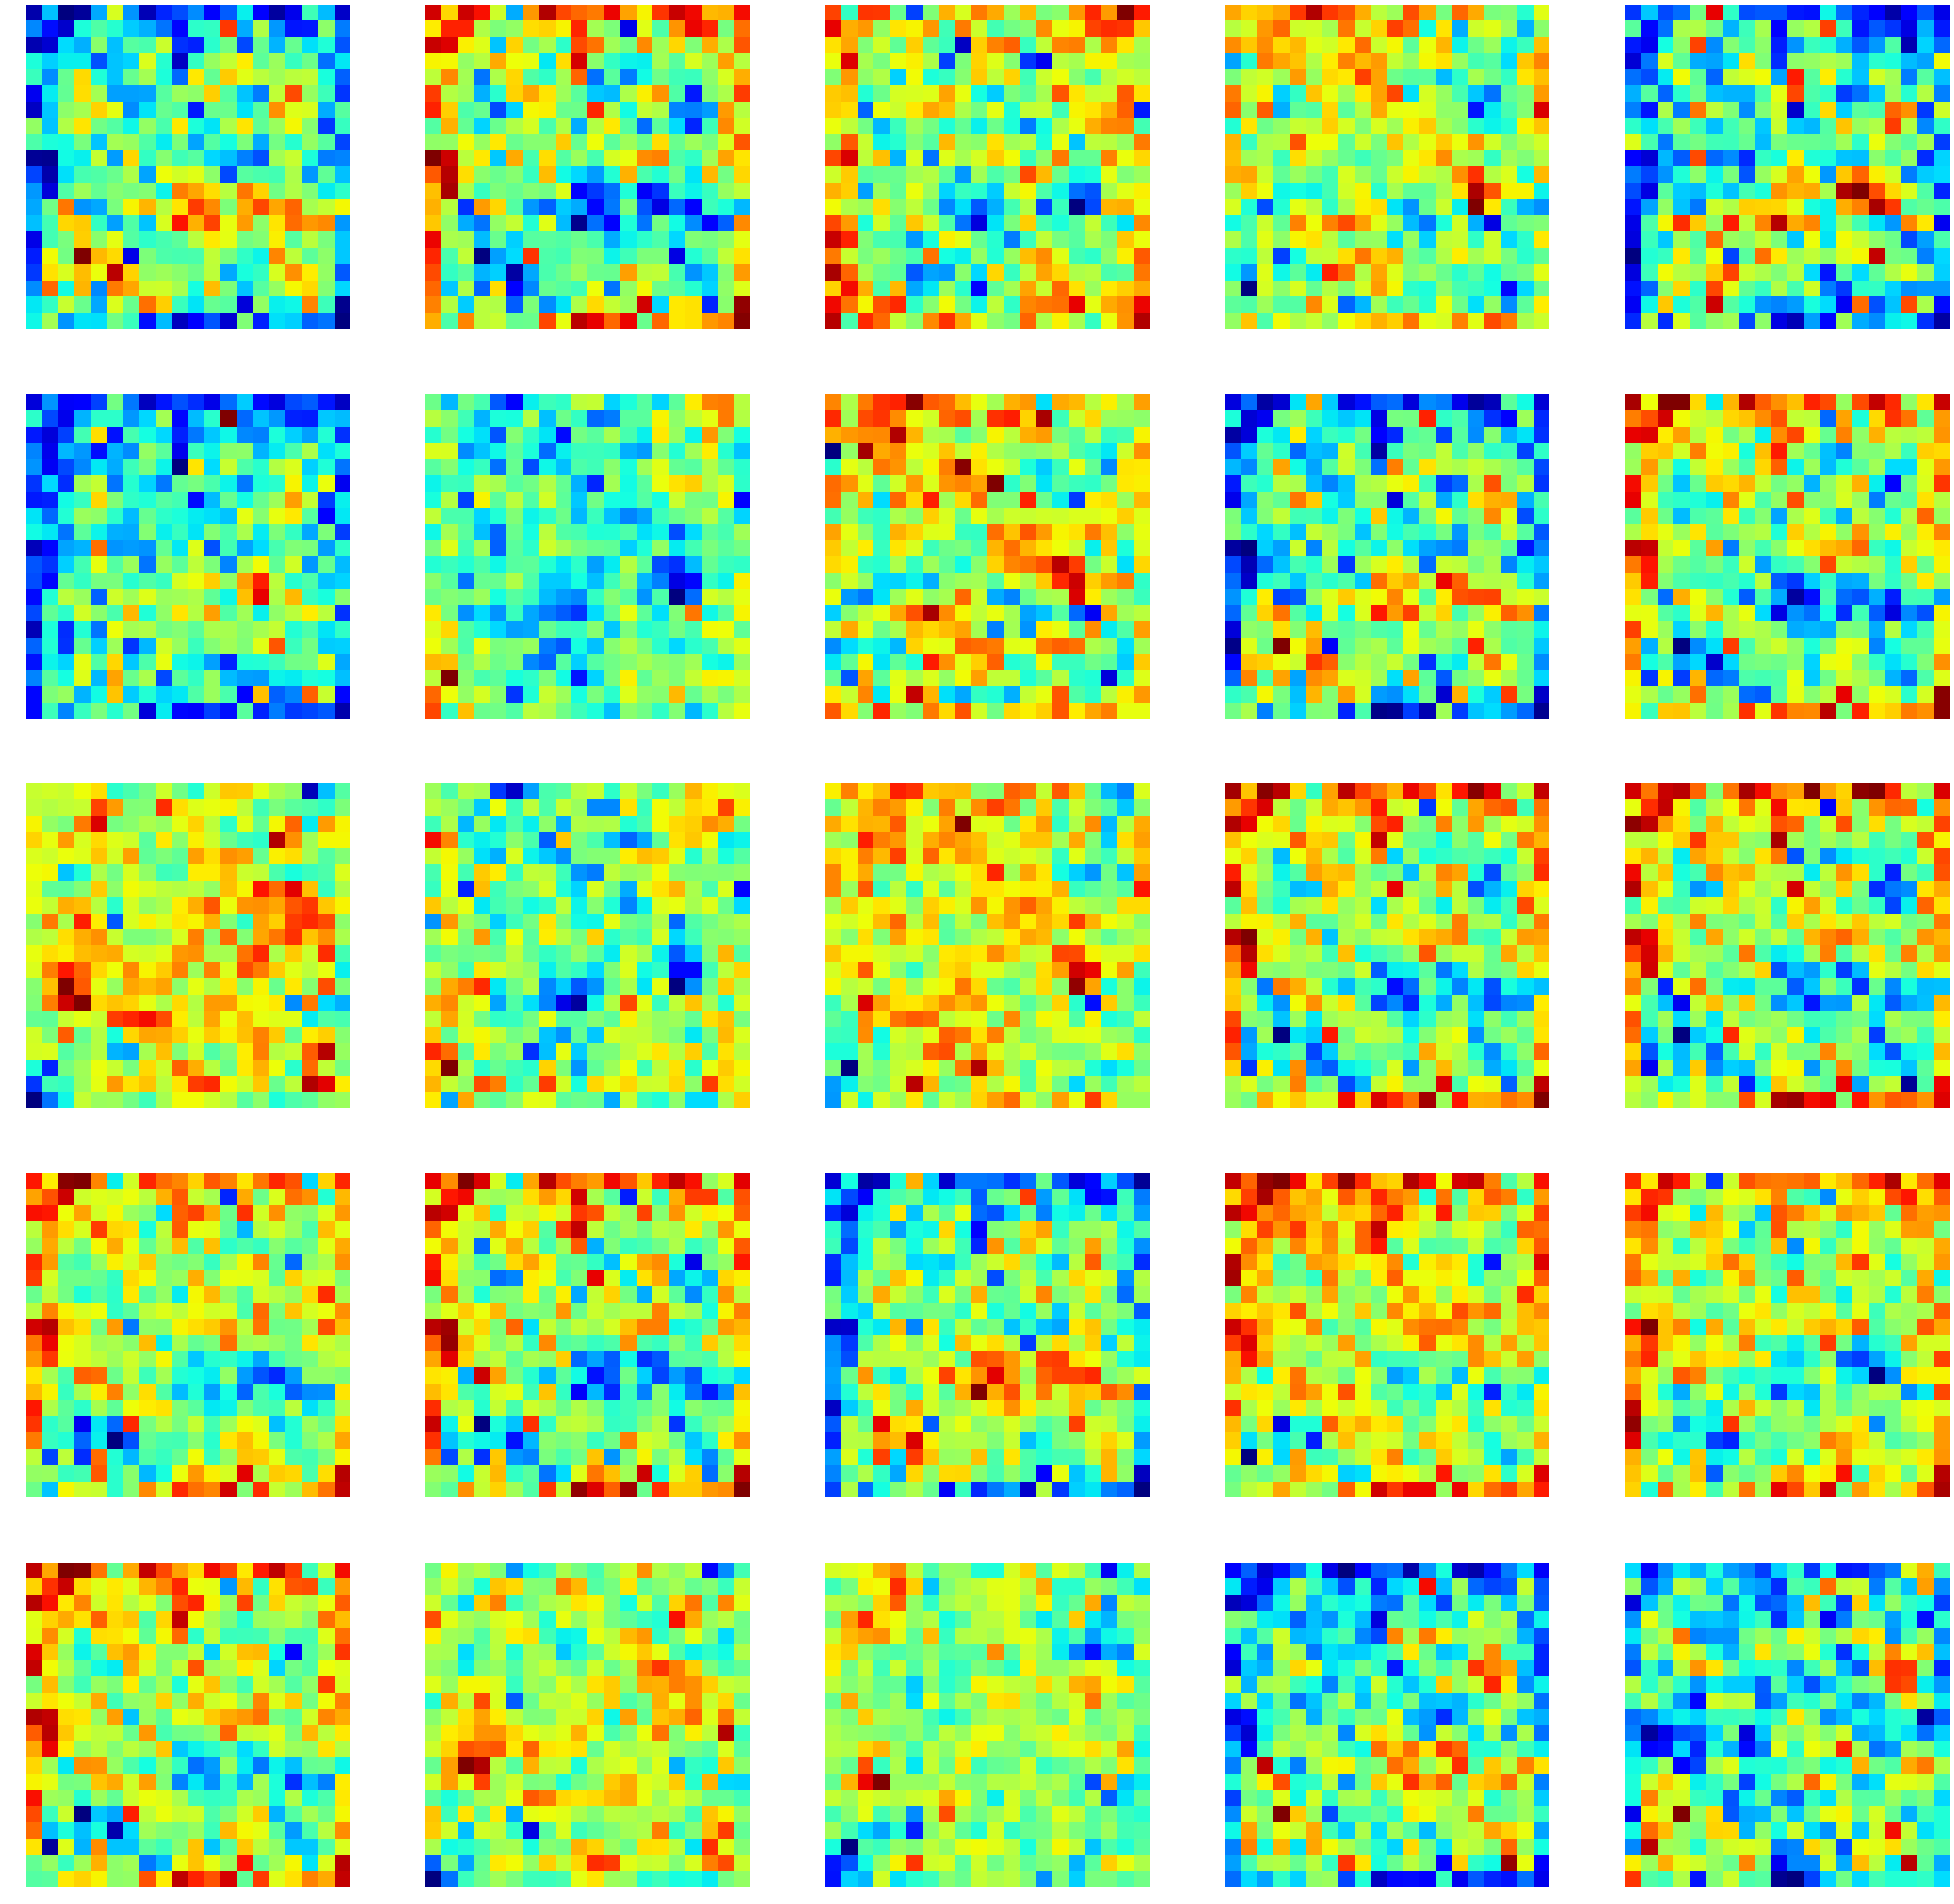

epoch 43, mean loss 7.932985671520234, std loss 0.053212116545130424


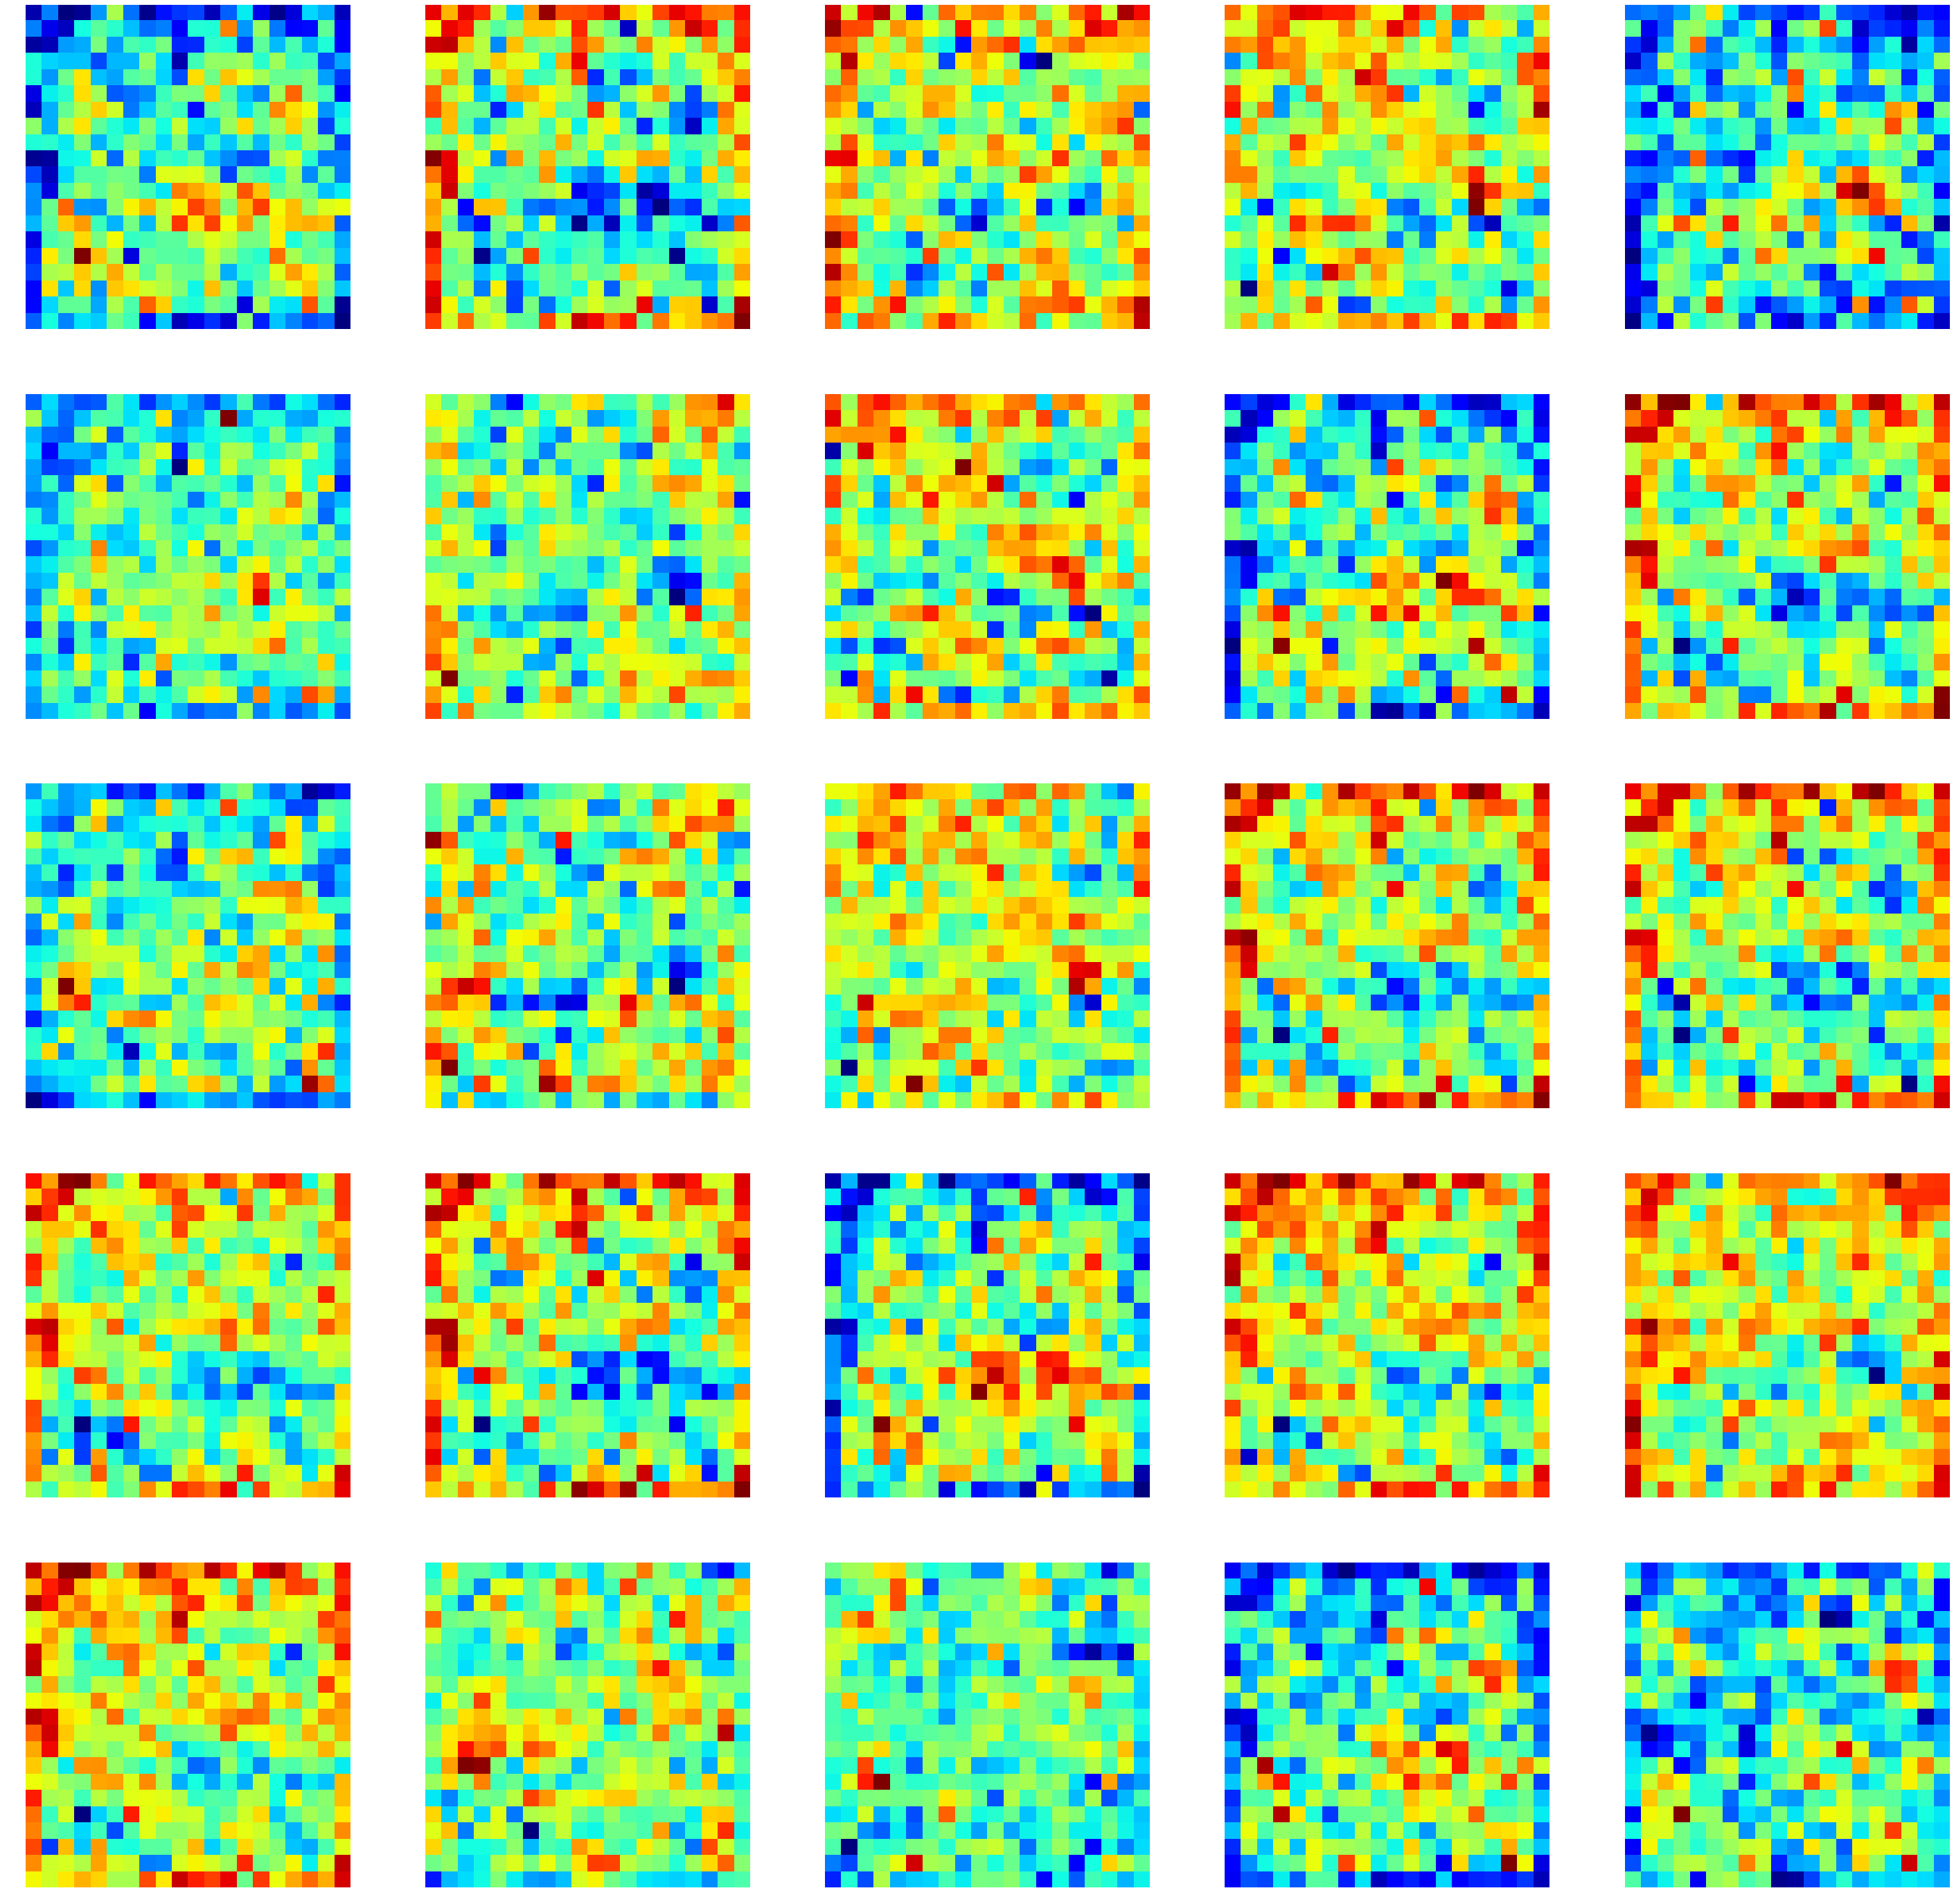

epoch 44, mean loss 7.932879583835602, std loss 0.05292018771588714


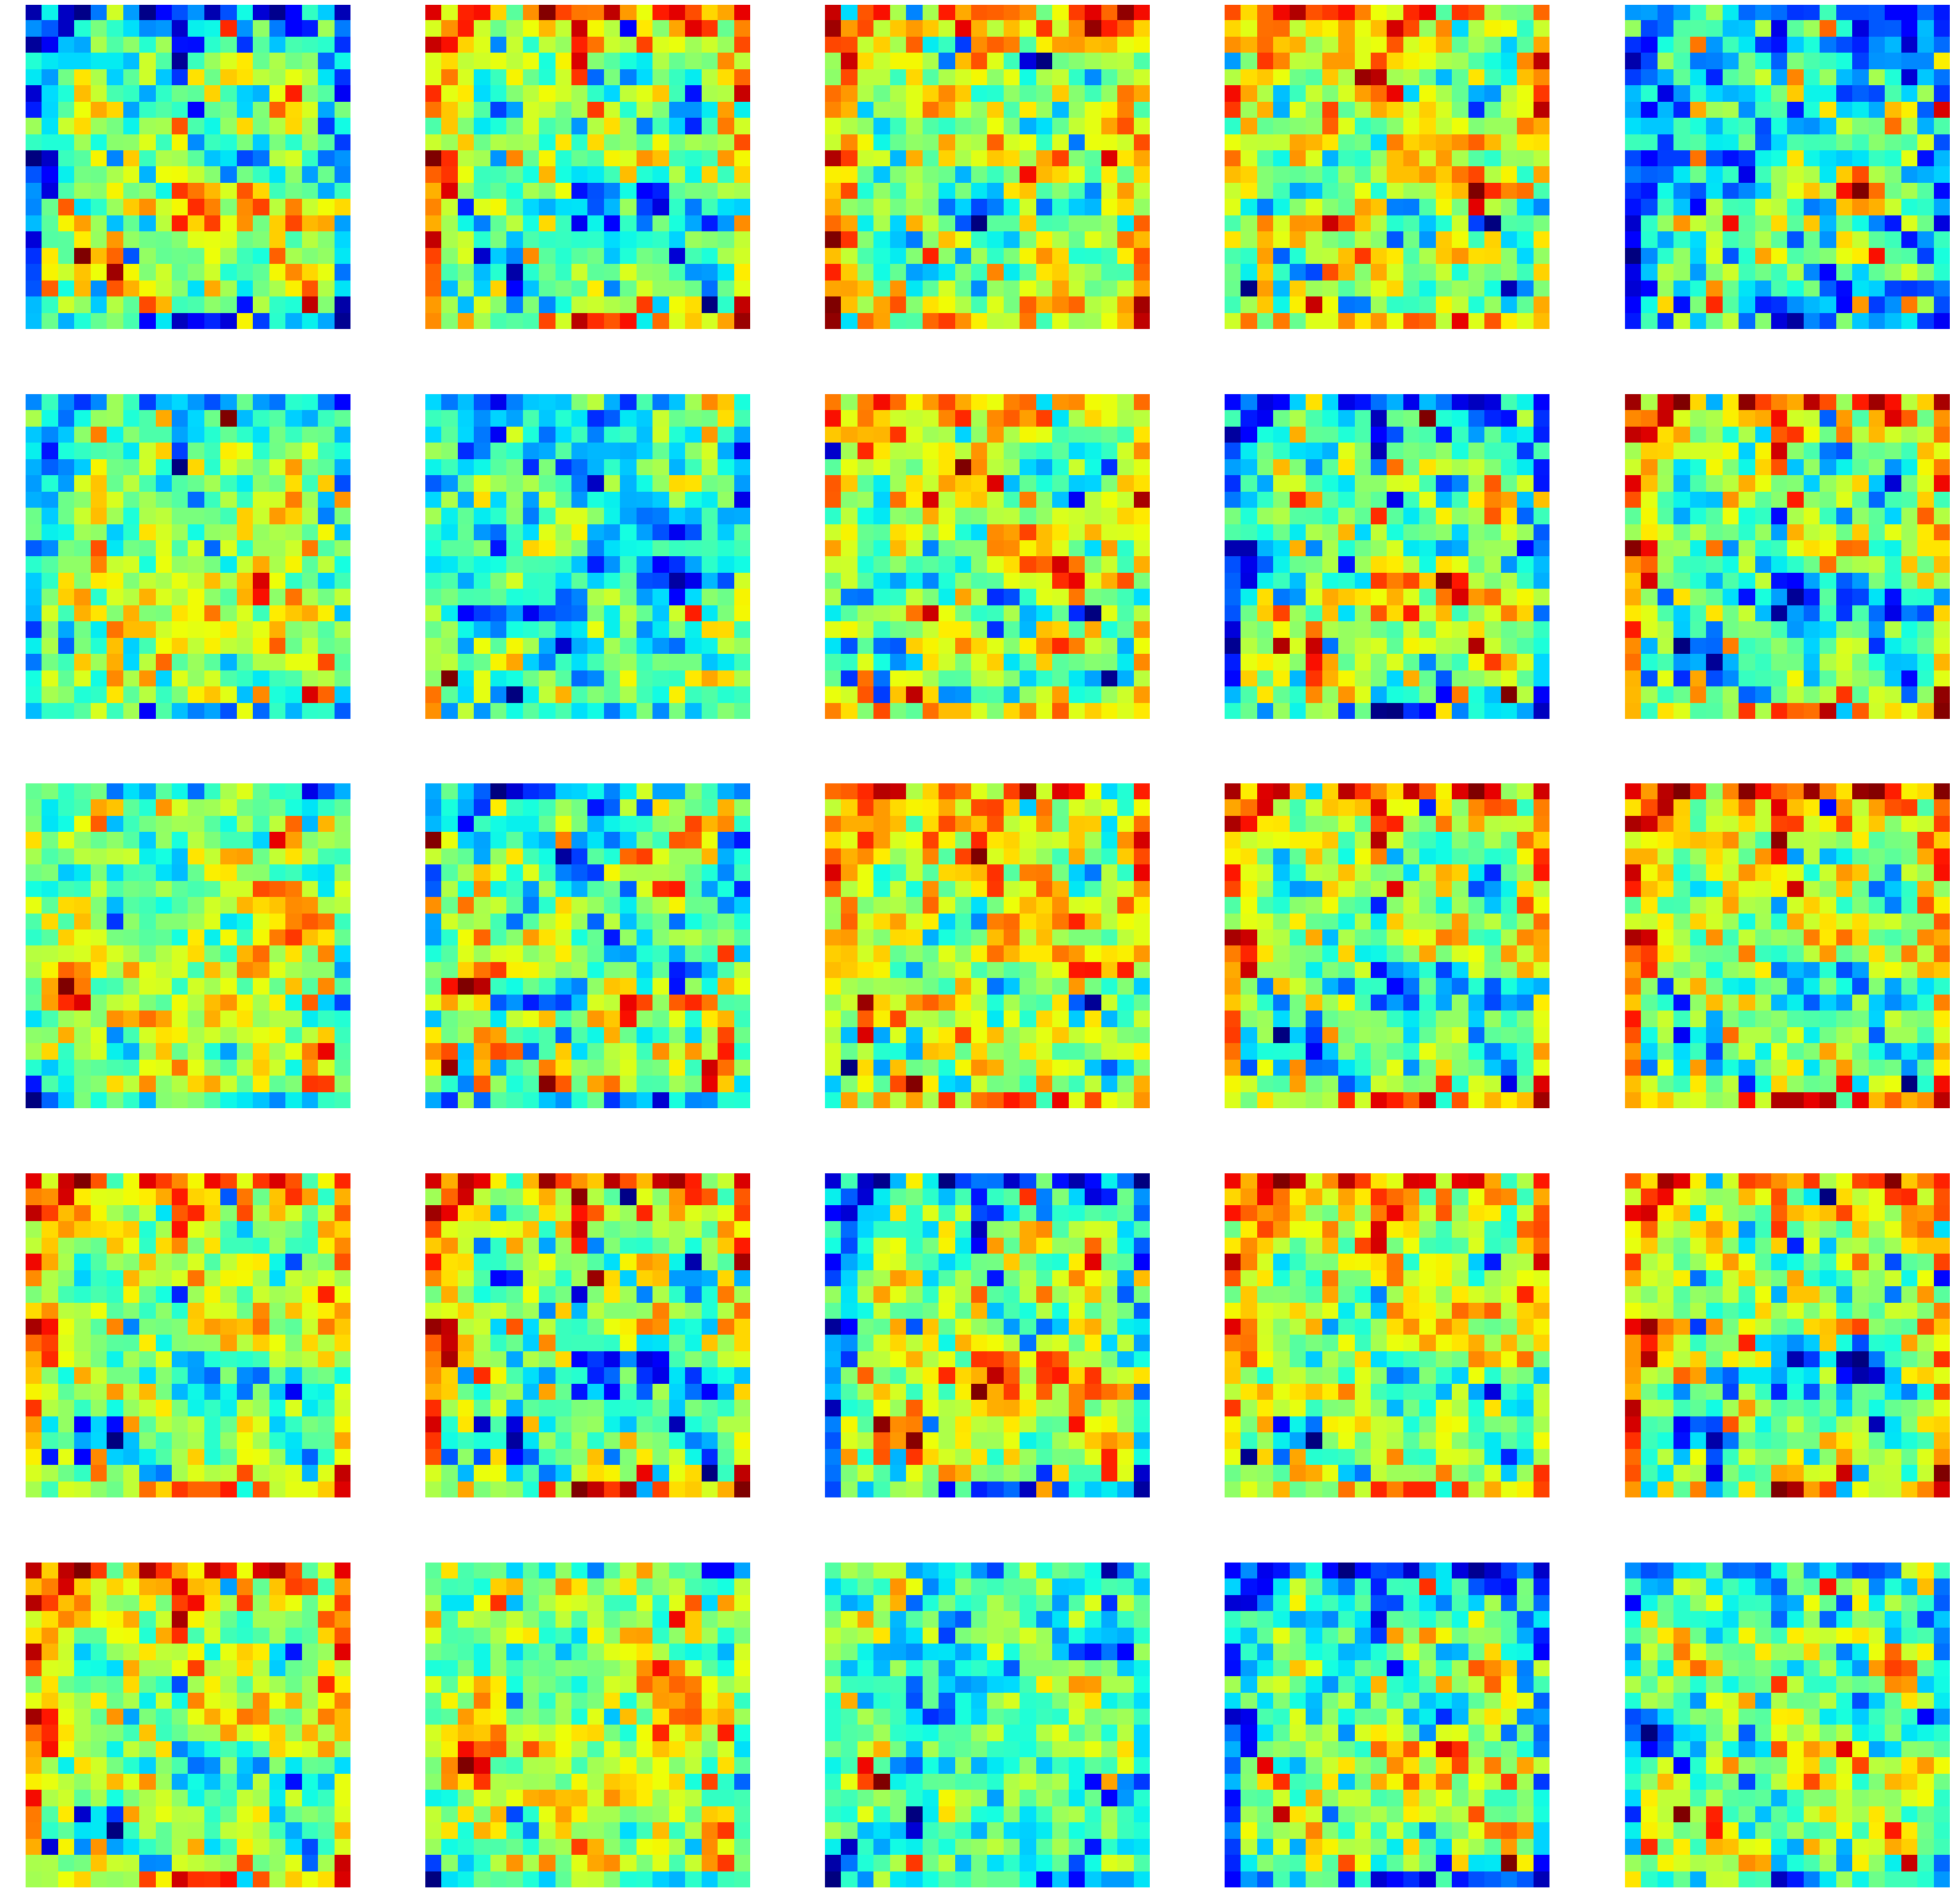

epoch 45, mean loss 7.93360580778122, std loss 0.05294395160503787


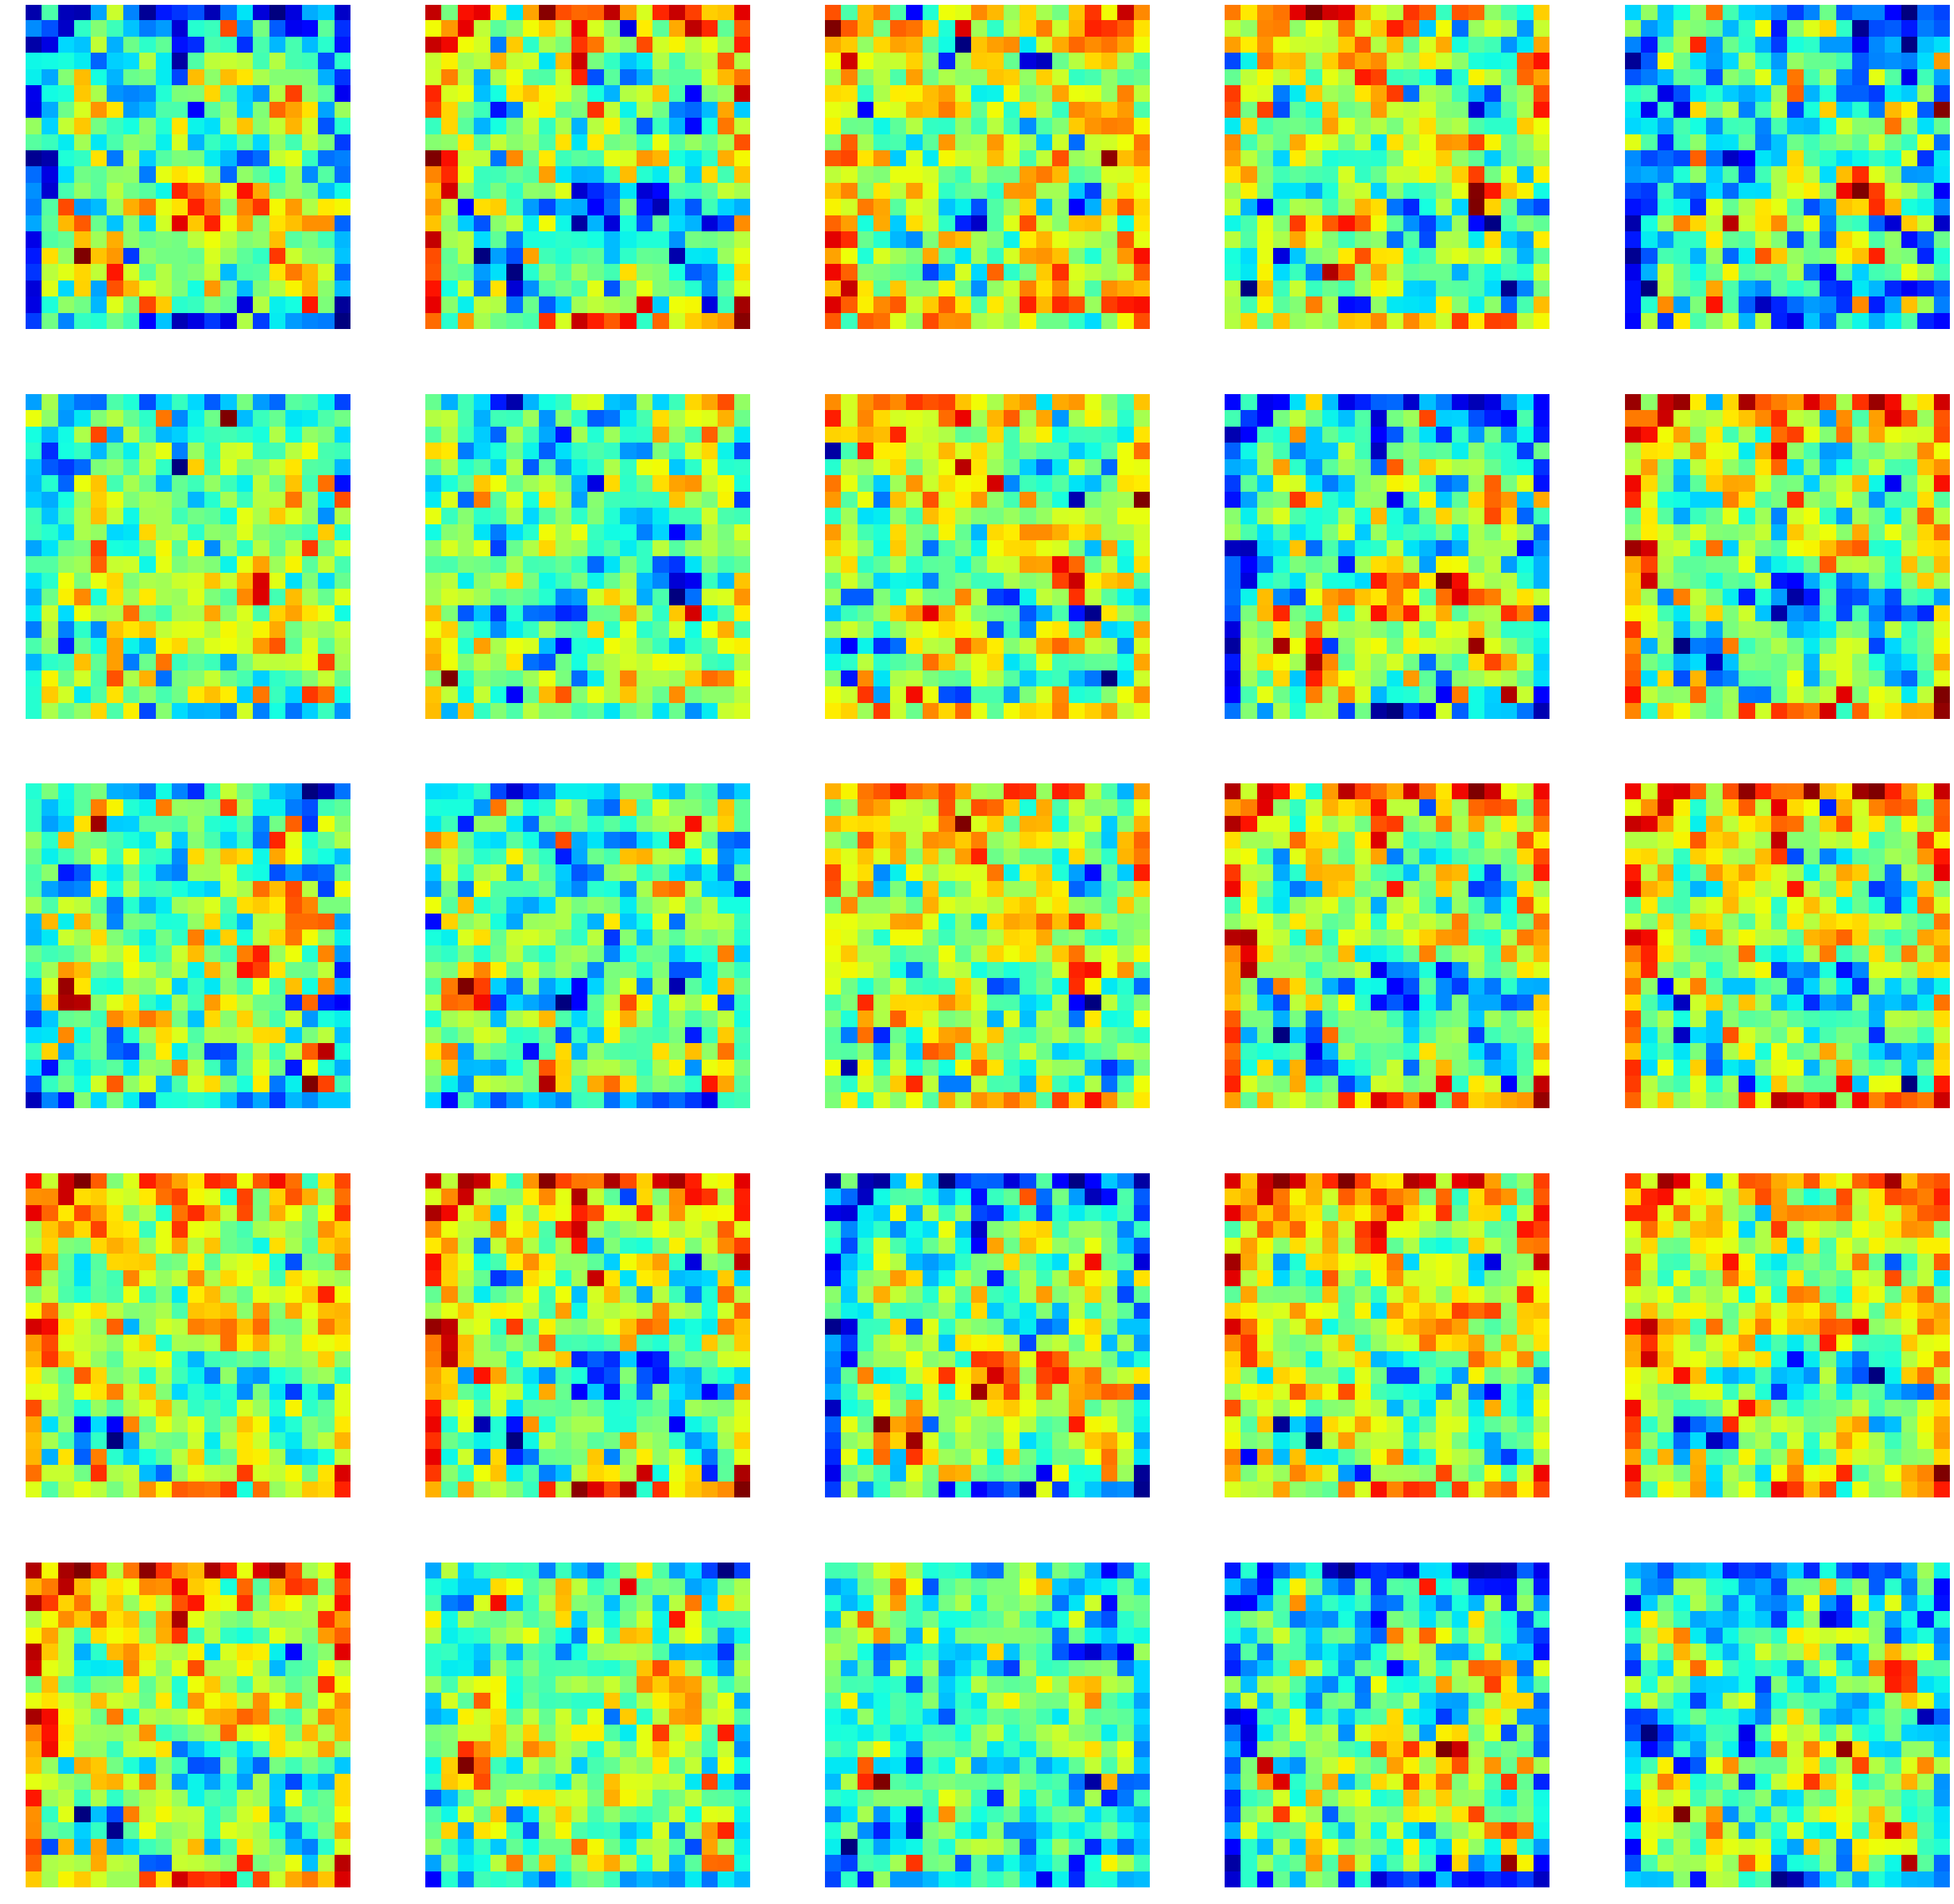

epoch 46, mean loss 7.933211668014526, std loss 0.05269267684282531


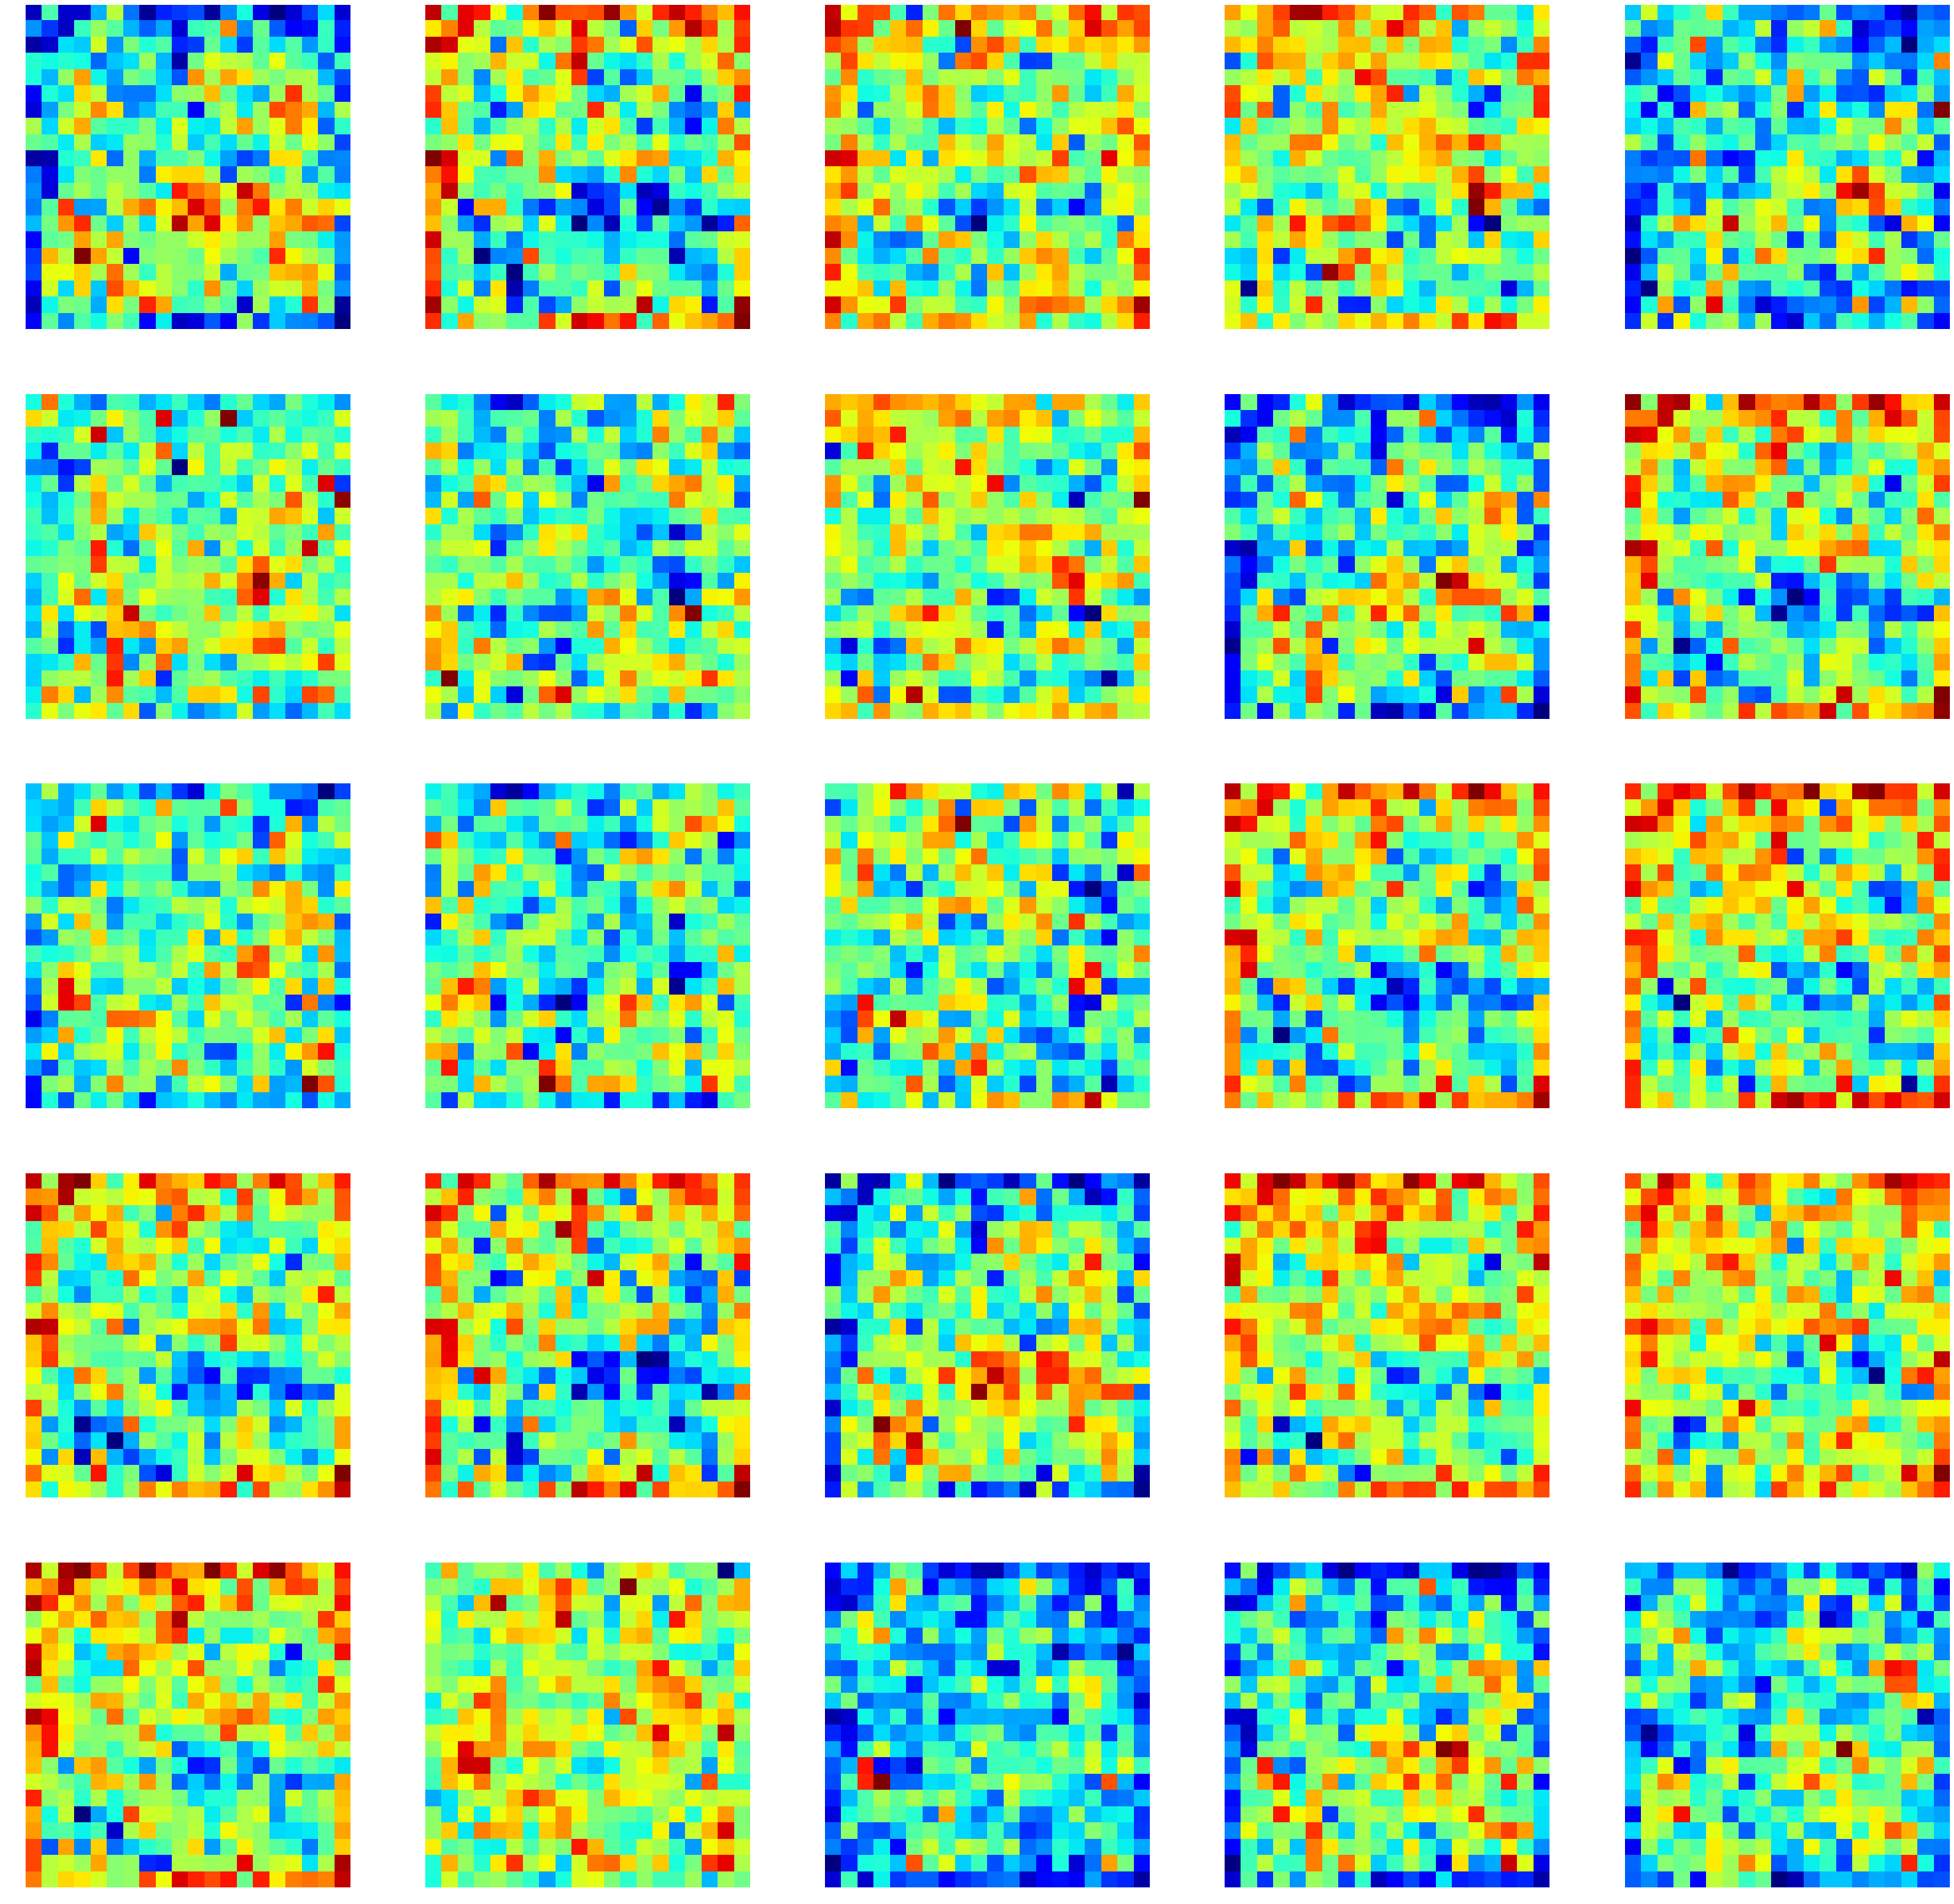

epoch 47, mean loss 7.93366491317749, std loss 0.053247321860016086


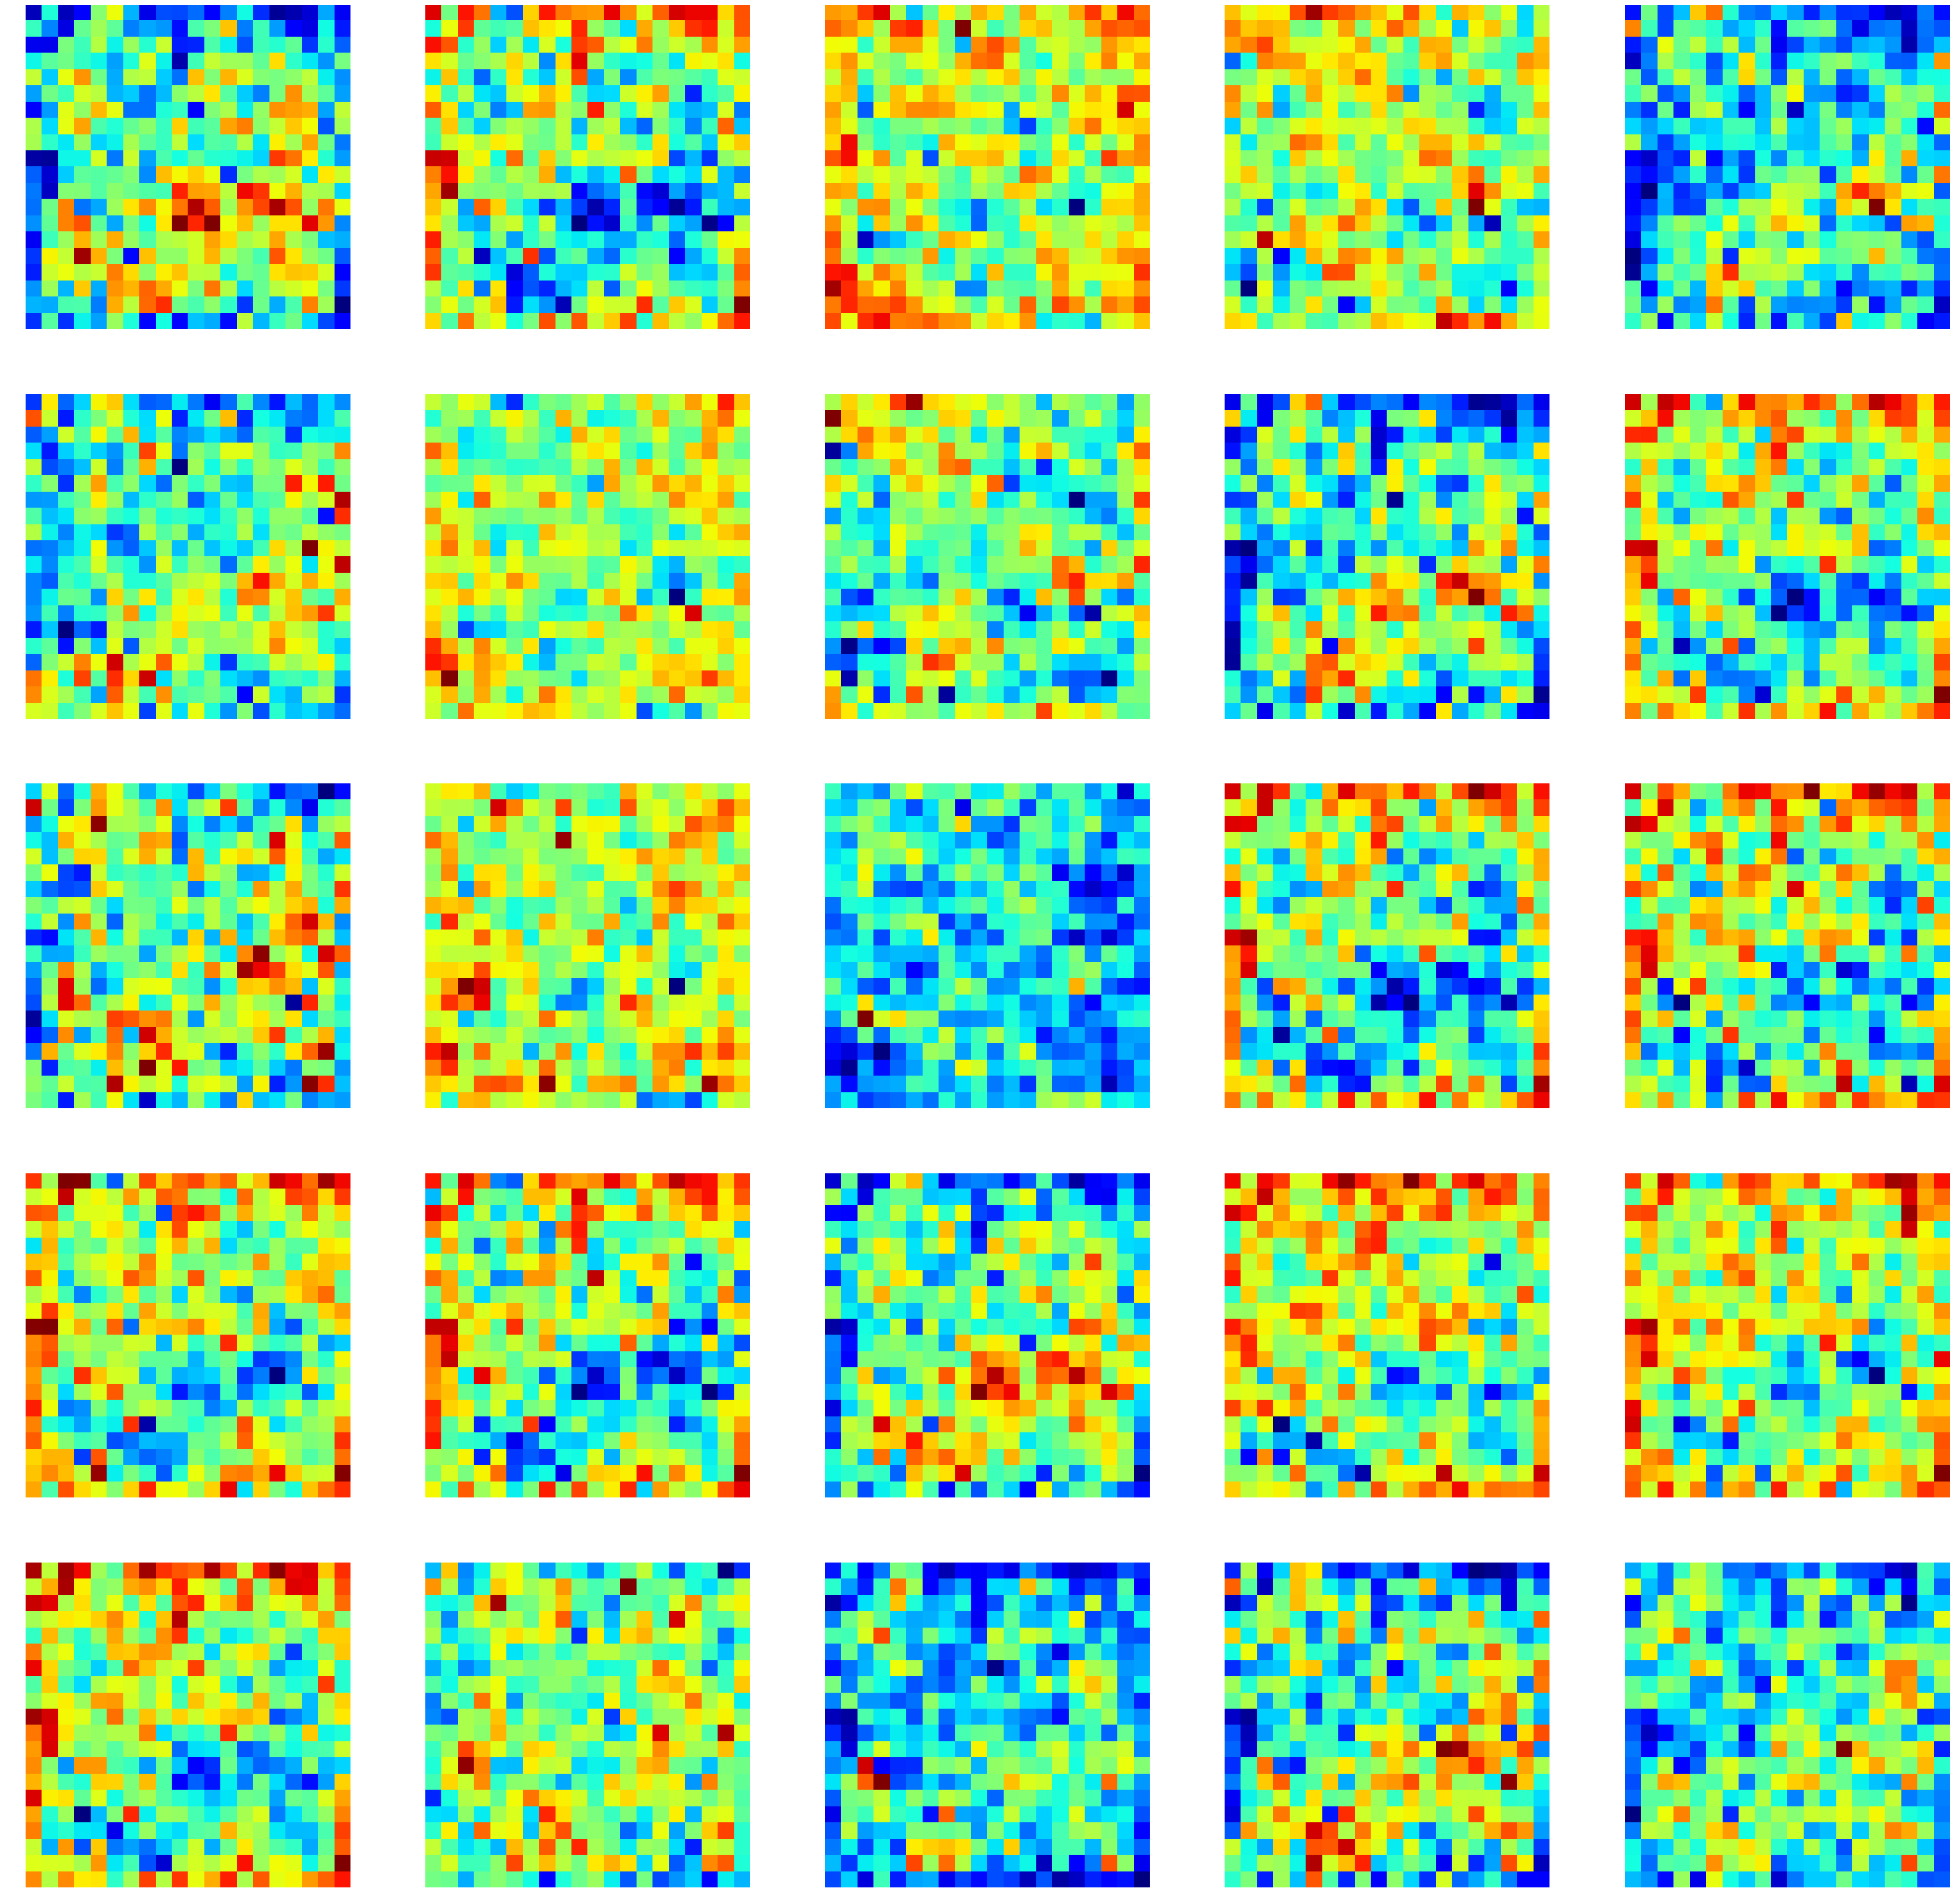

epoch 48, mean loss 7.933099980831146, std loss 0.052864291607238975


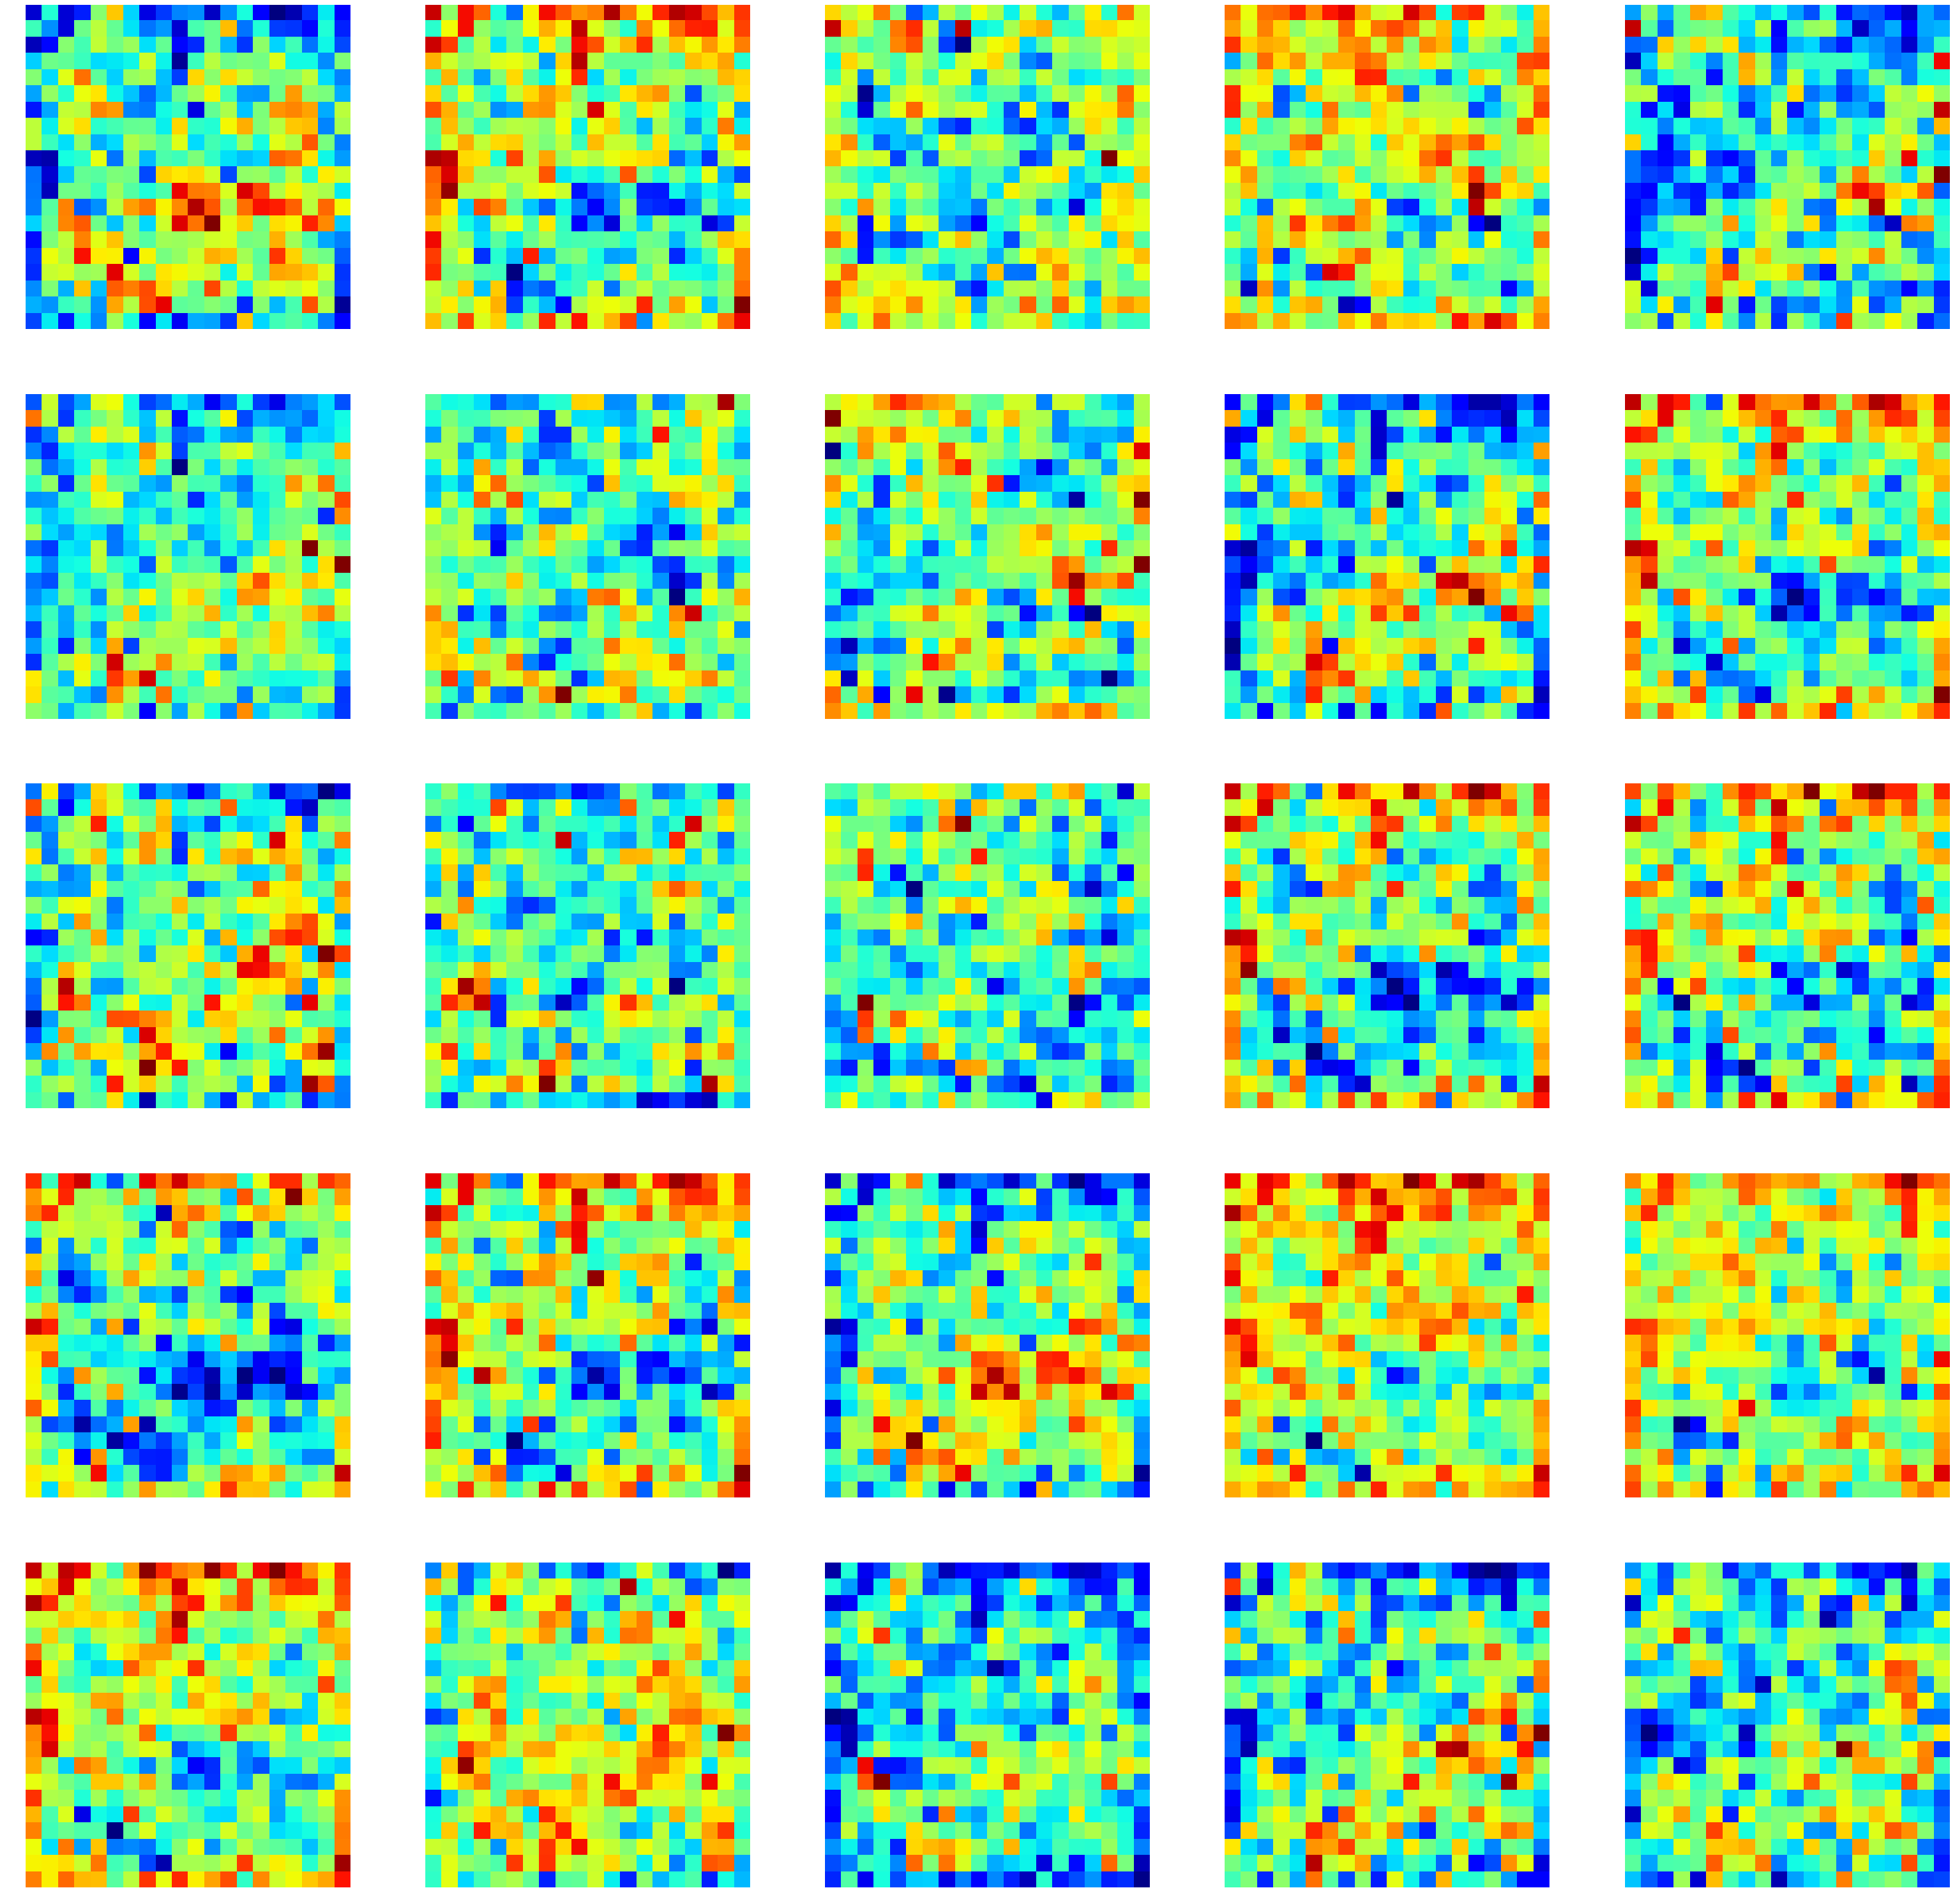

epoch 49, mean loss 7.932845067024231, std loss 0.052697065639887526


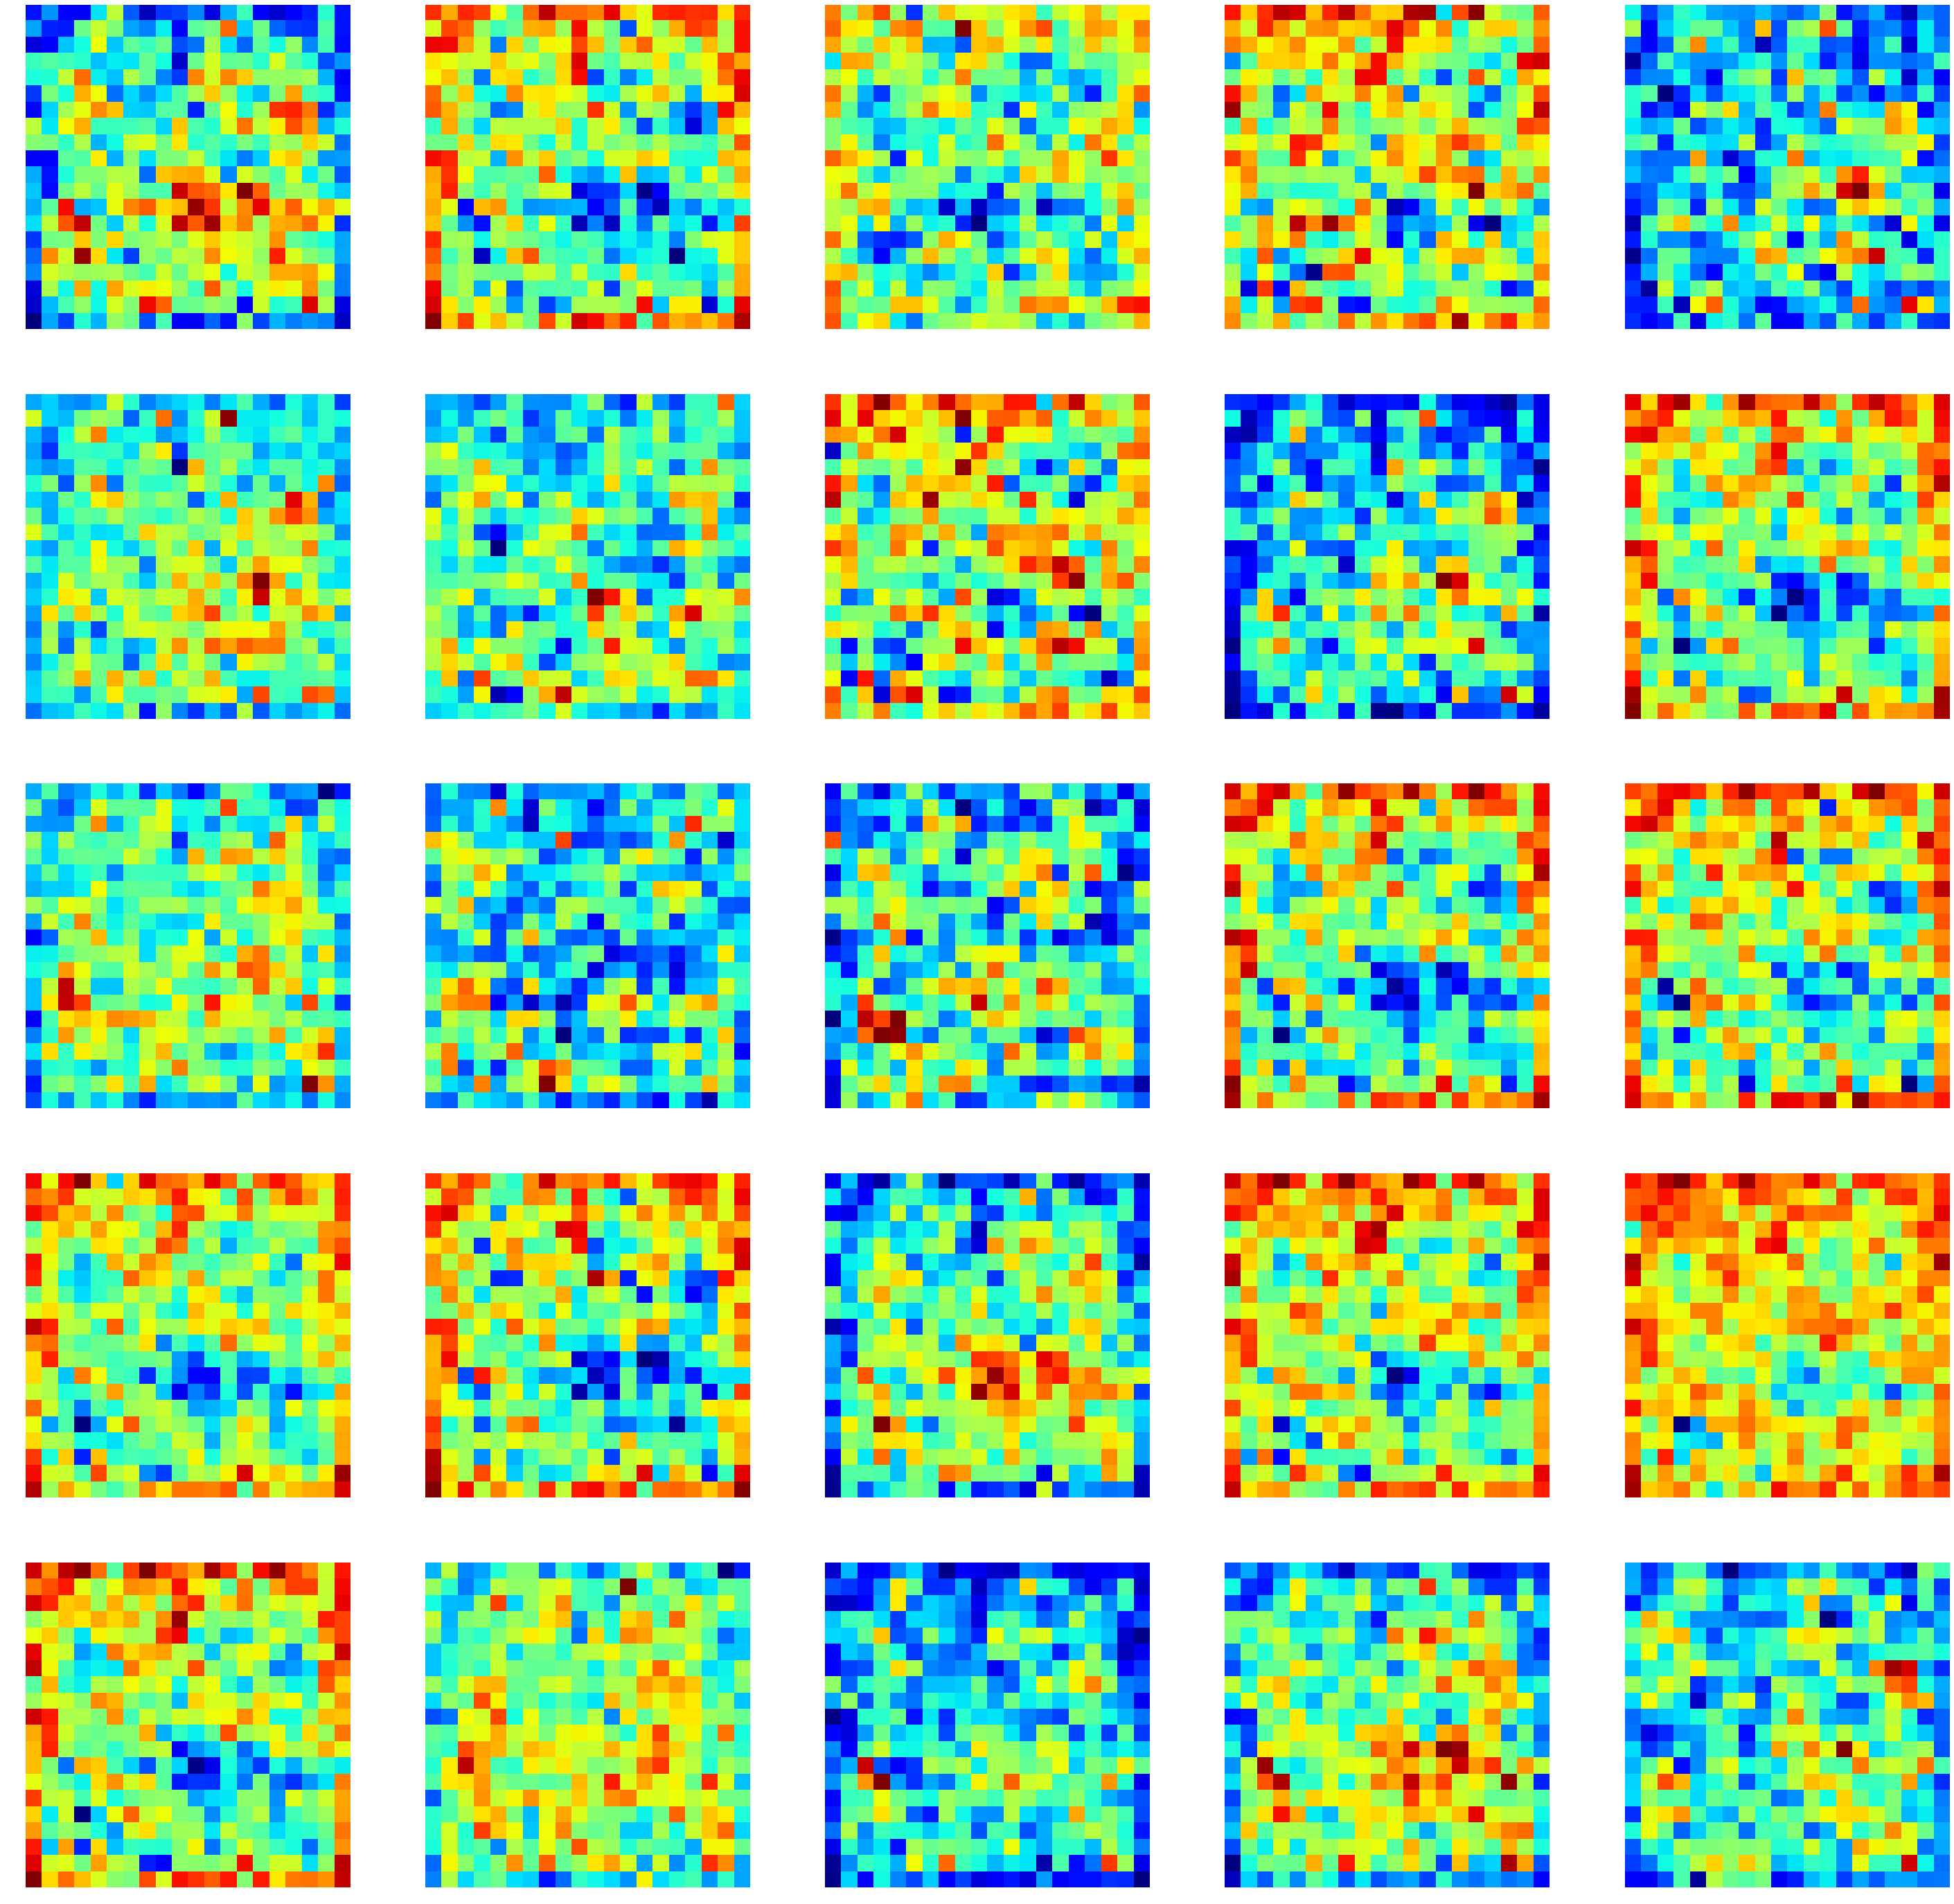

epoch 50, mean loss 7.933696077346802, std loss 0.05262601953356243


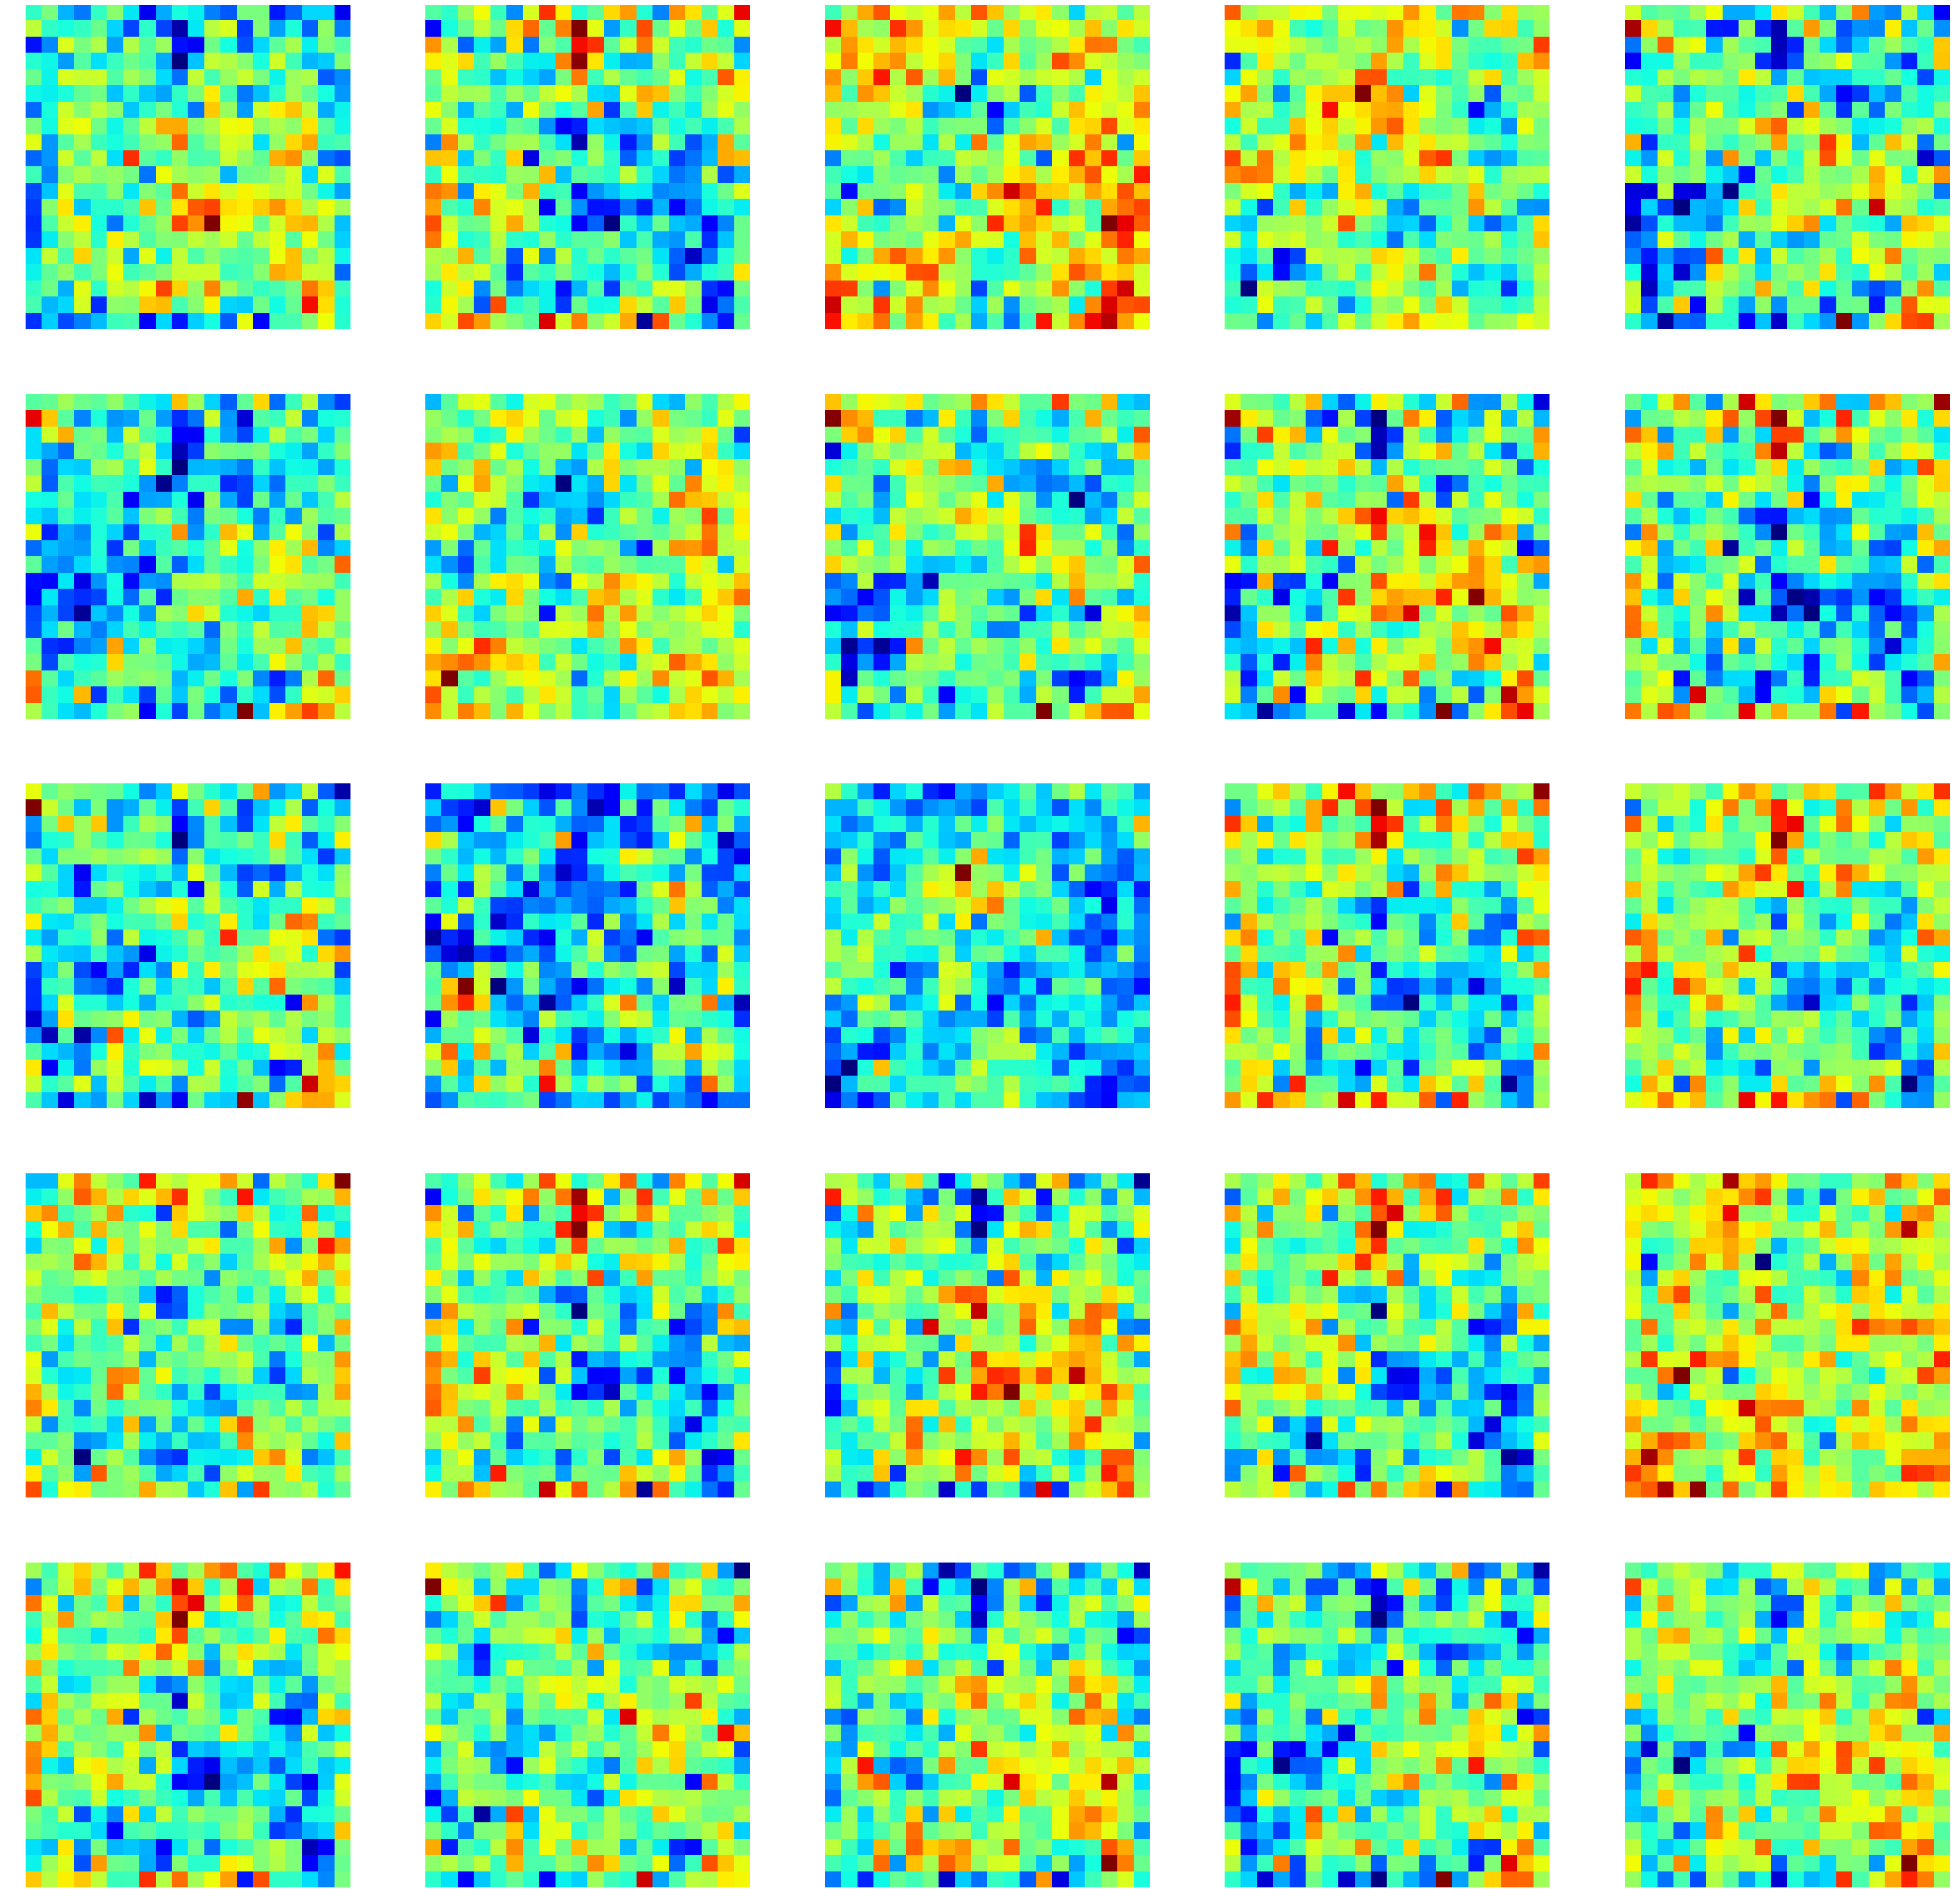

epoch 51, mean loss 7.933006566524505, std loss 0.052863446639124734


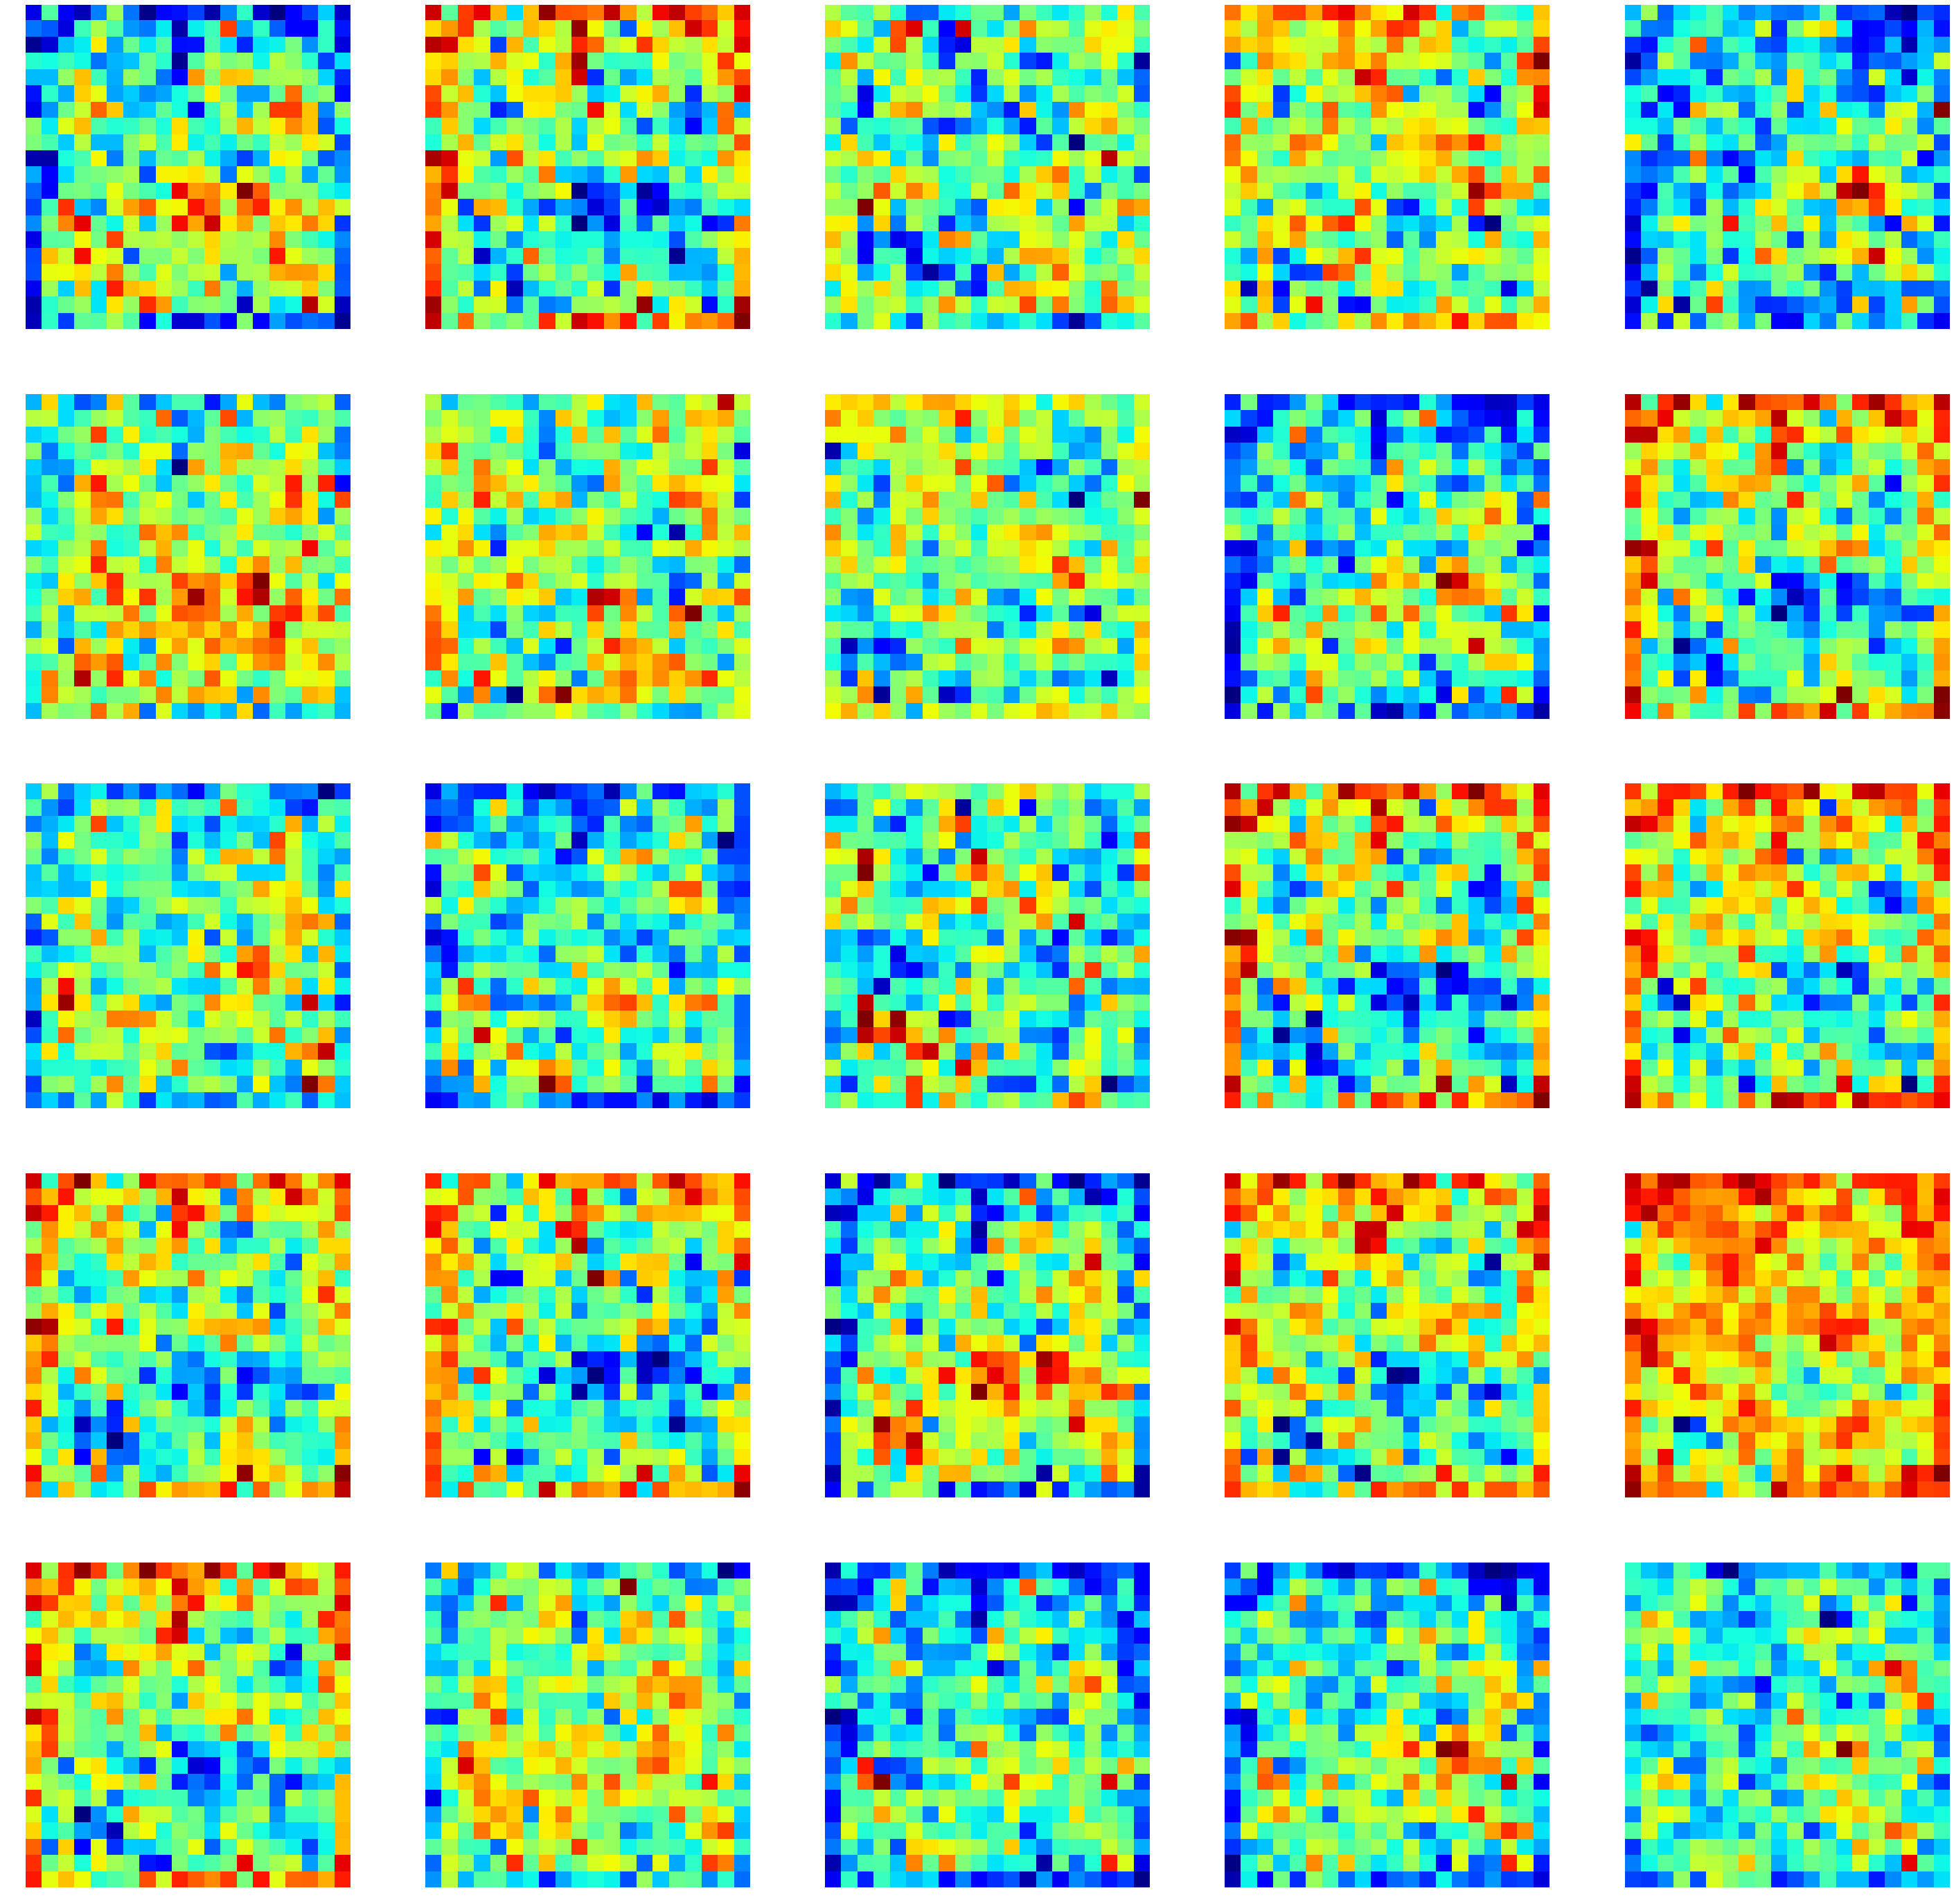

epoch 52, mean loss 7.933205396175384, std loss 0.05257948063634216


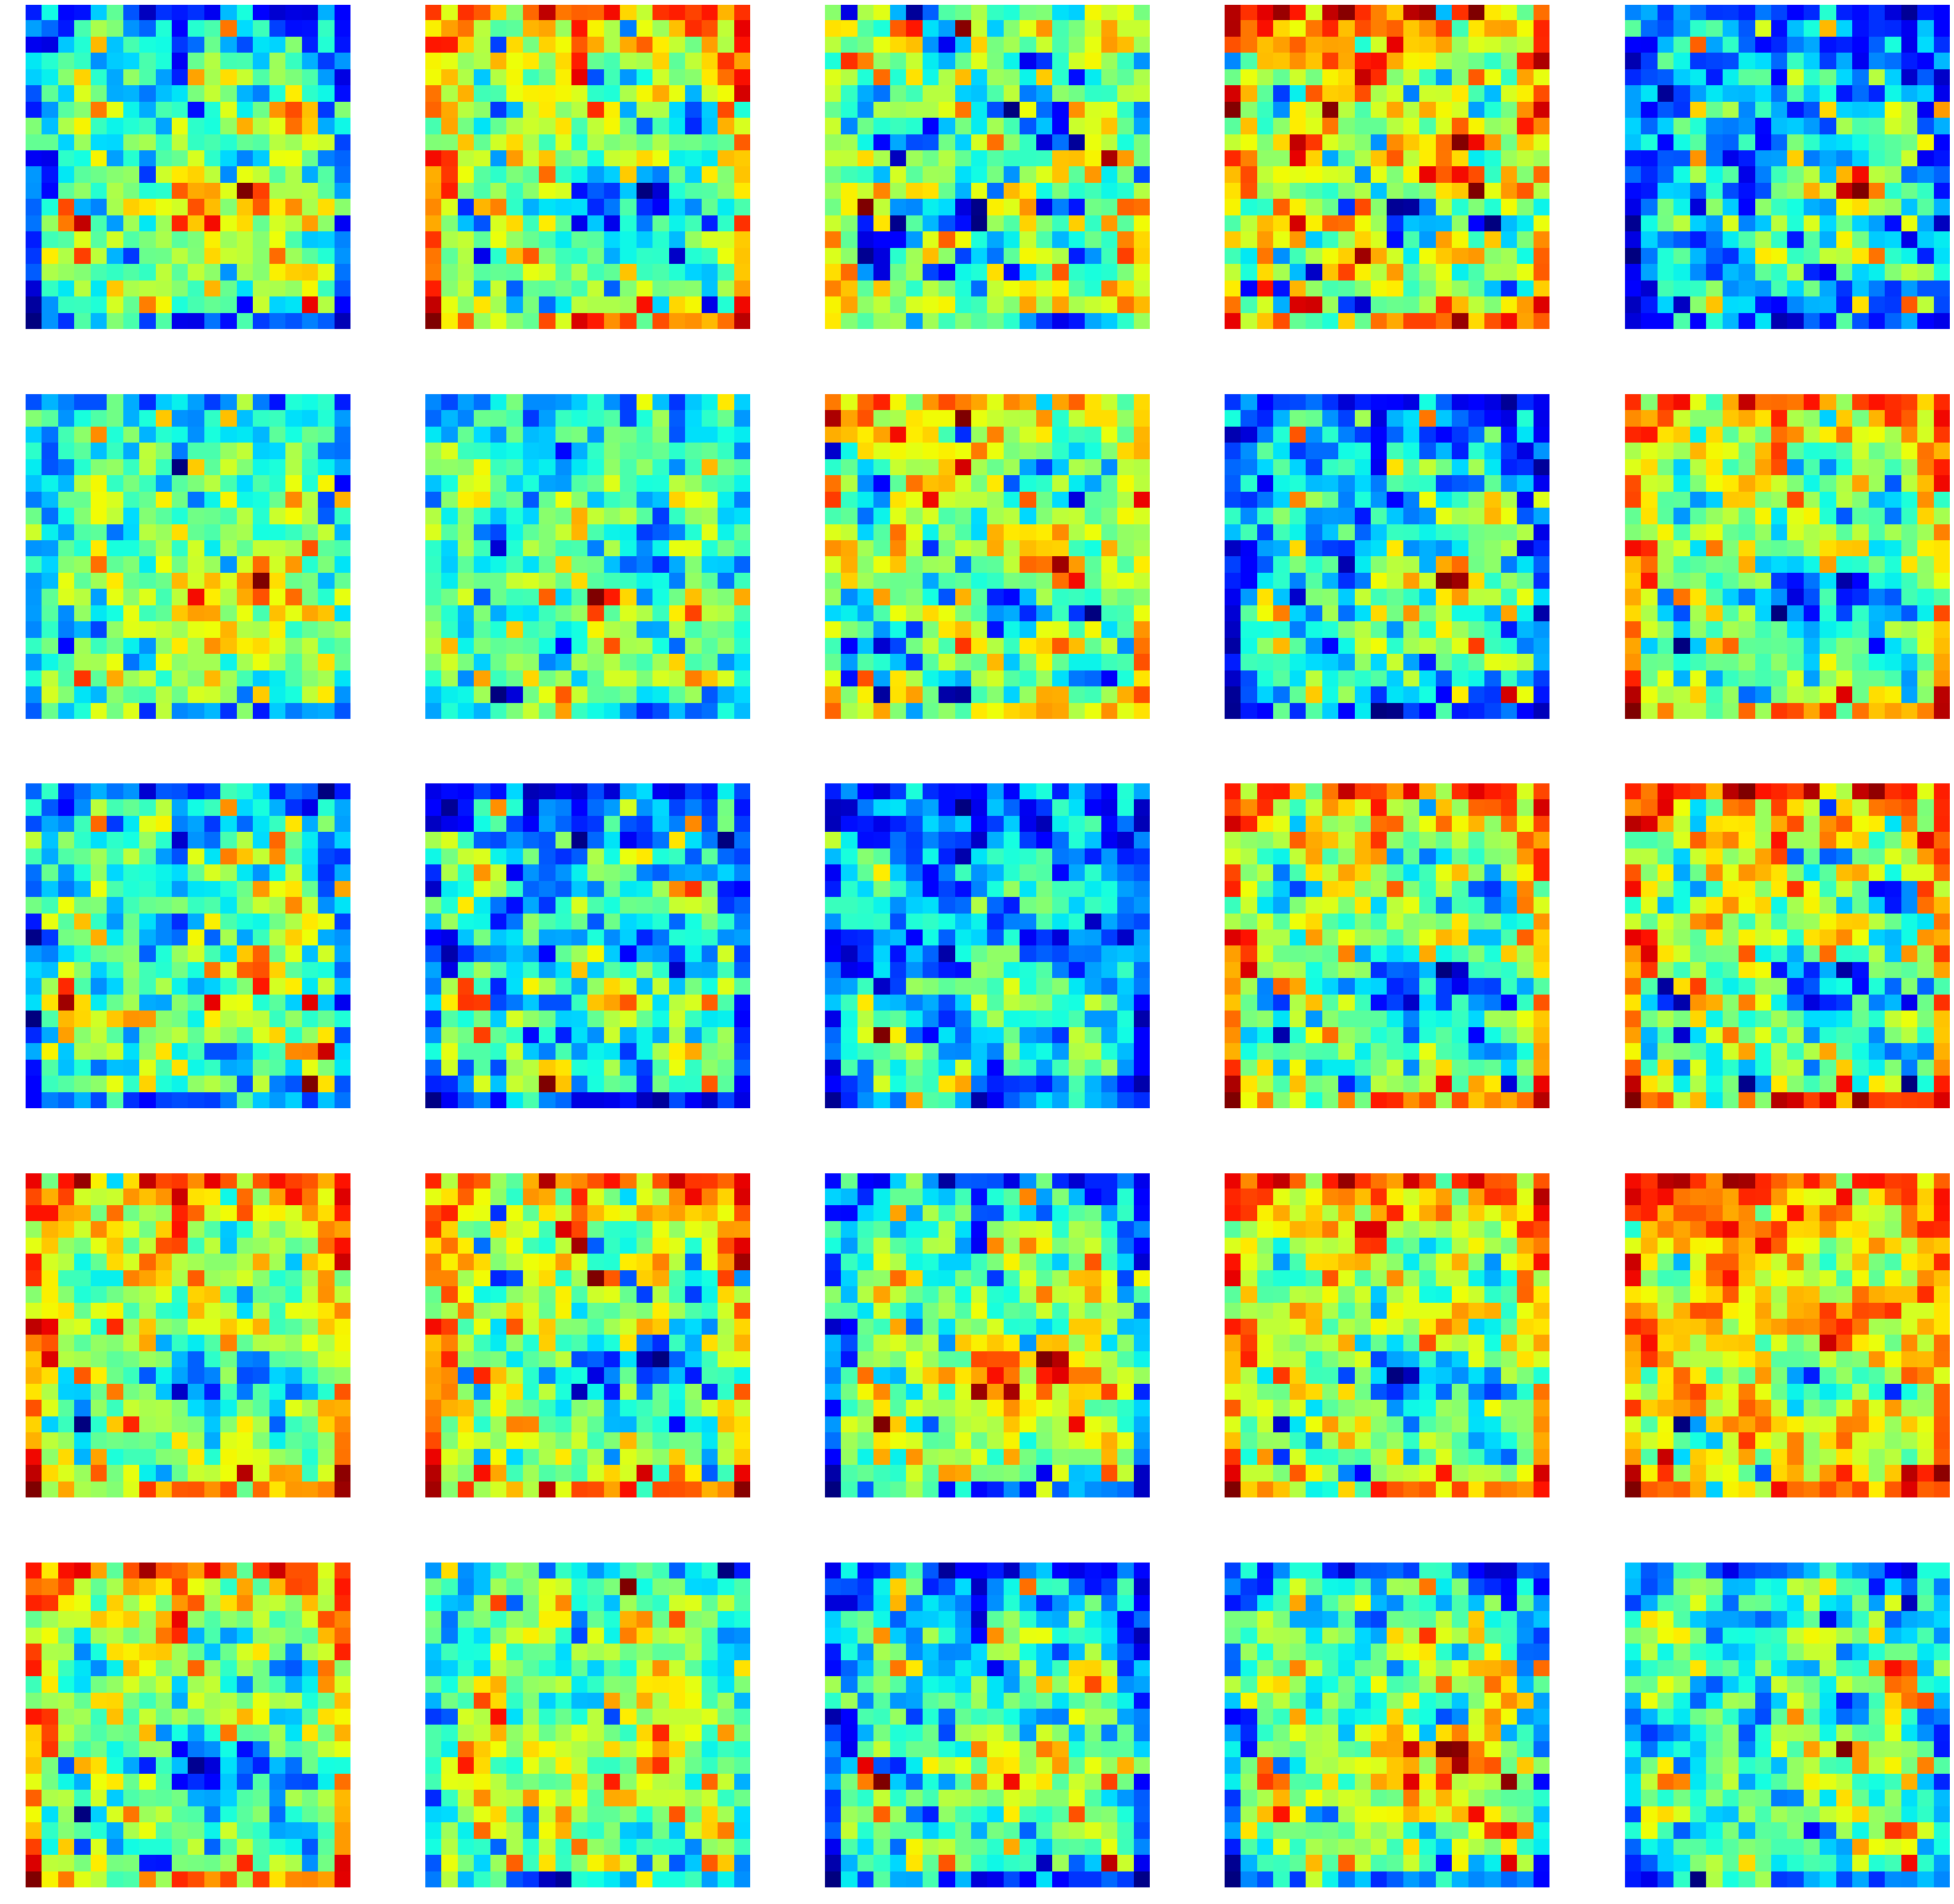

epoch 53, mean loss 7.932995232582092, std loss 0.05258772533229718


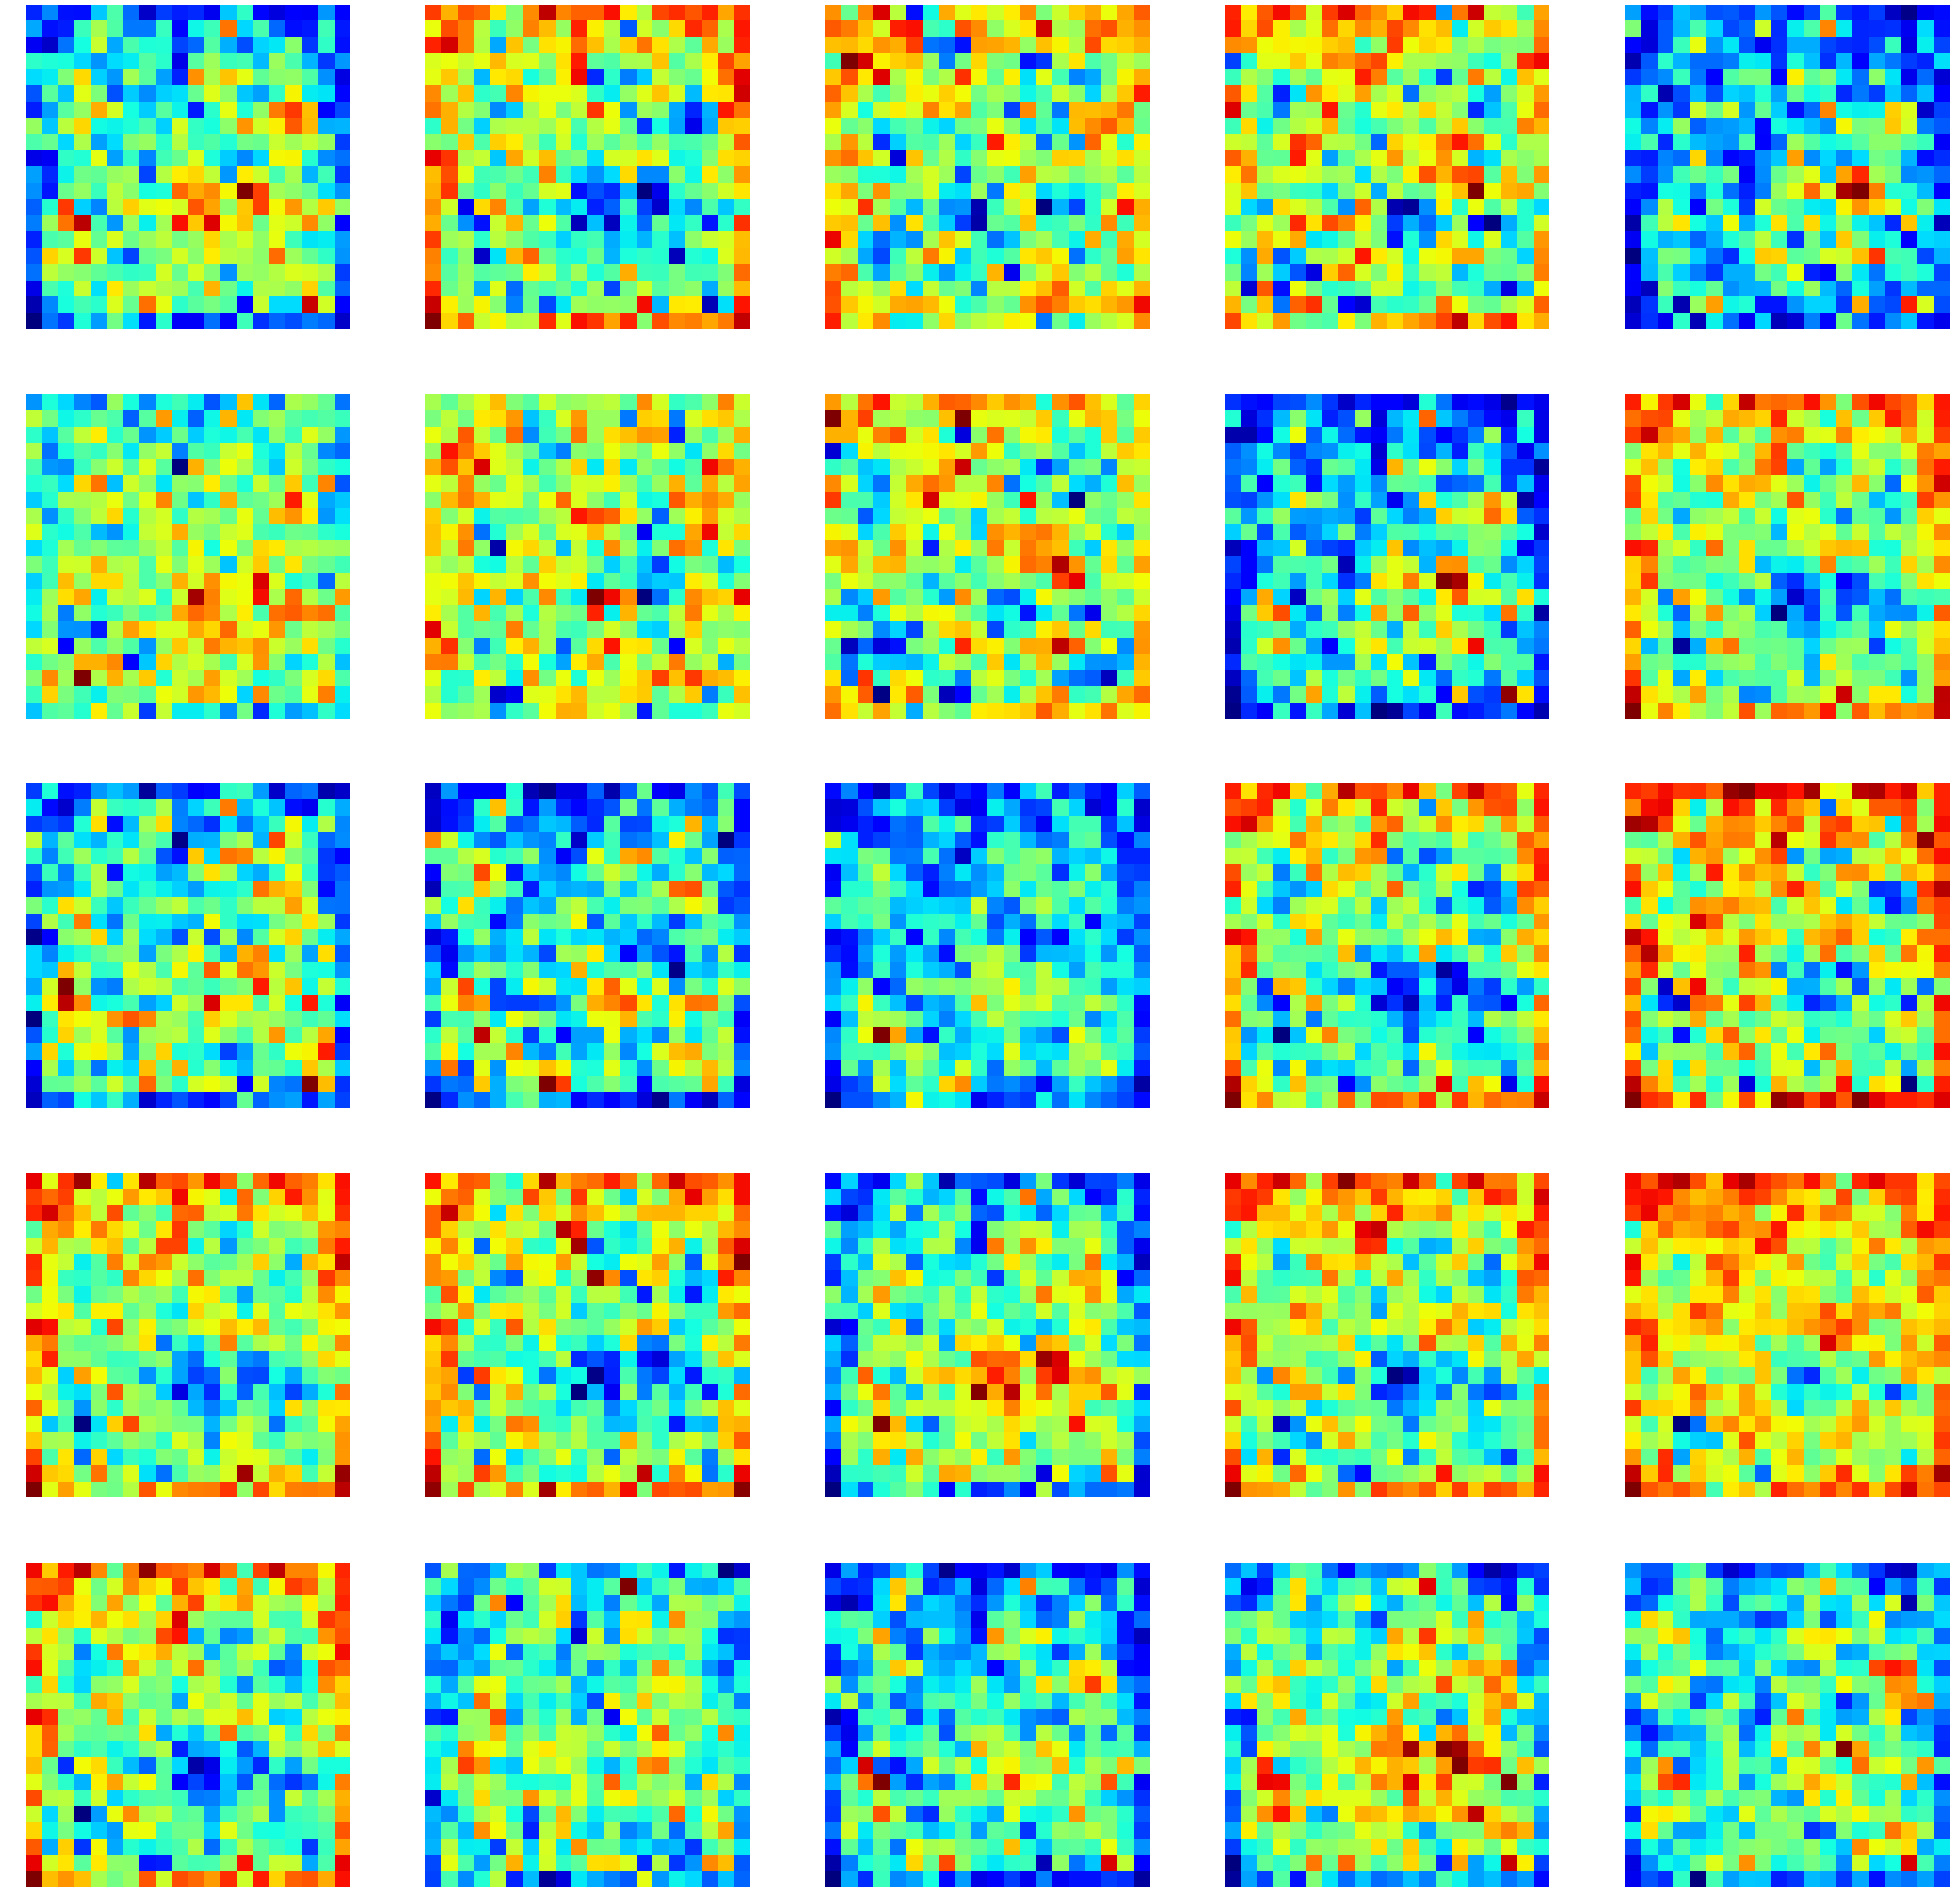

epoch 54, mean loss 7.932911577701568, std loss 0.052500208291823995


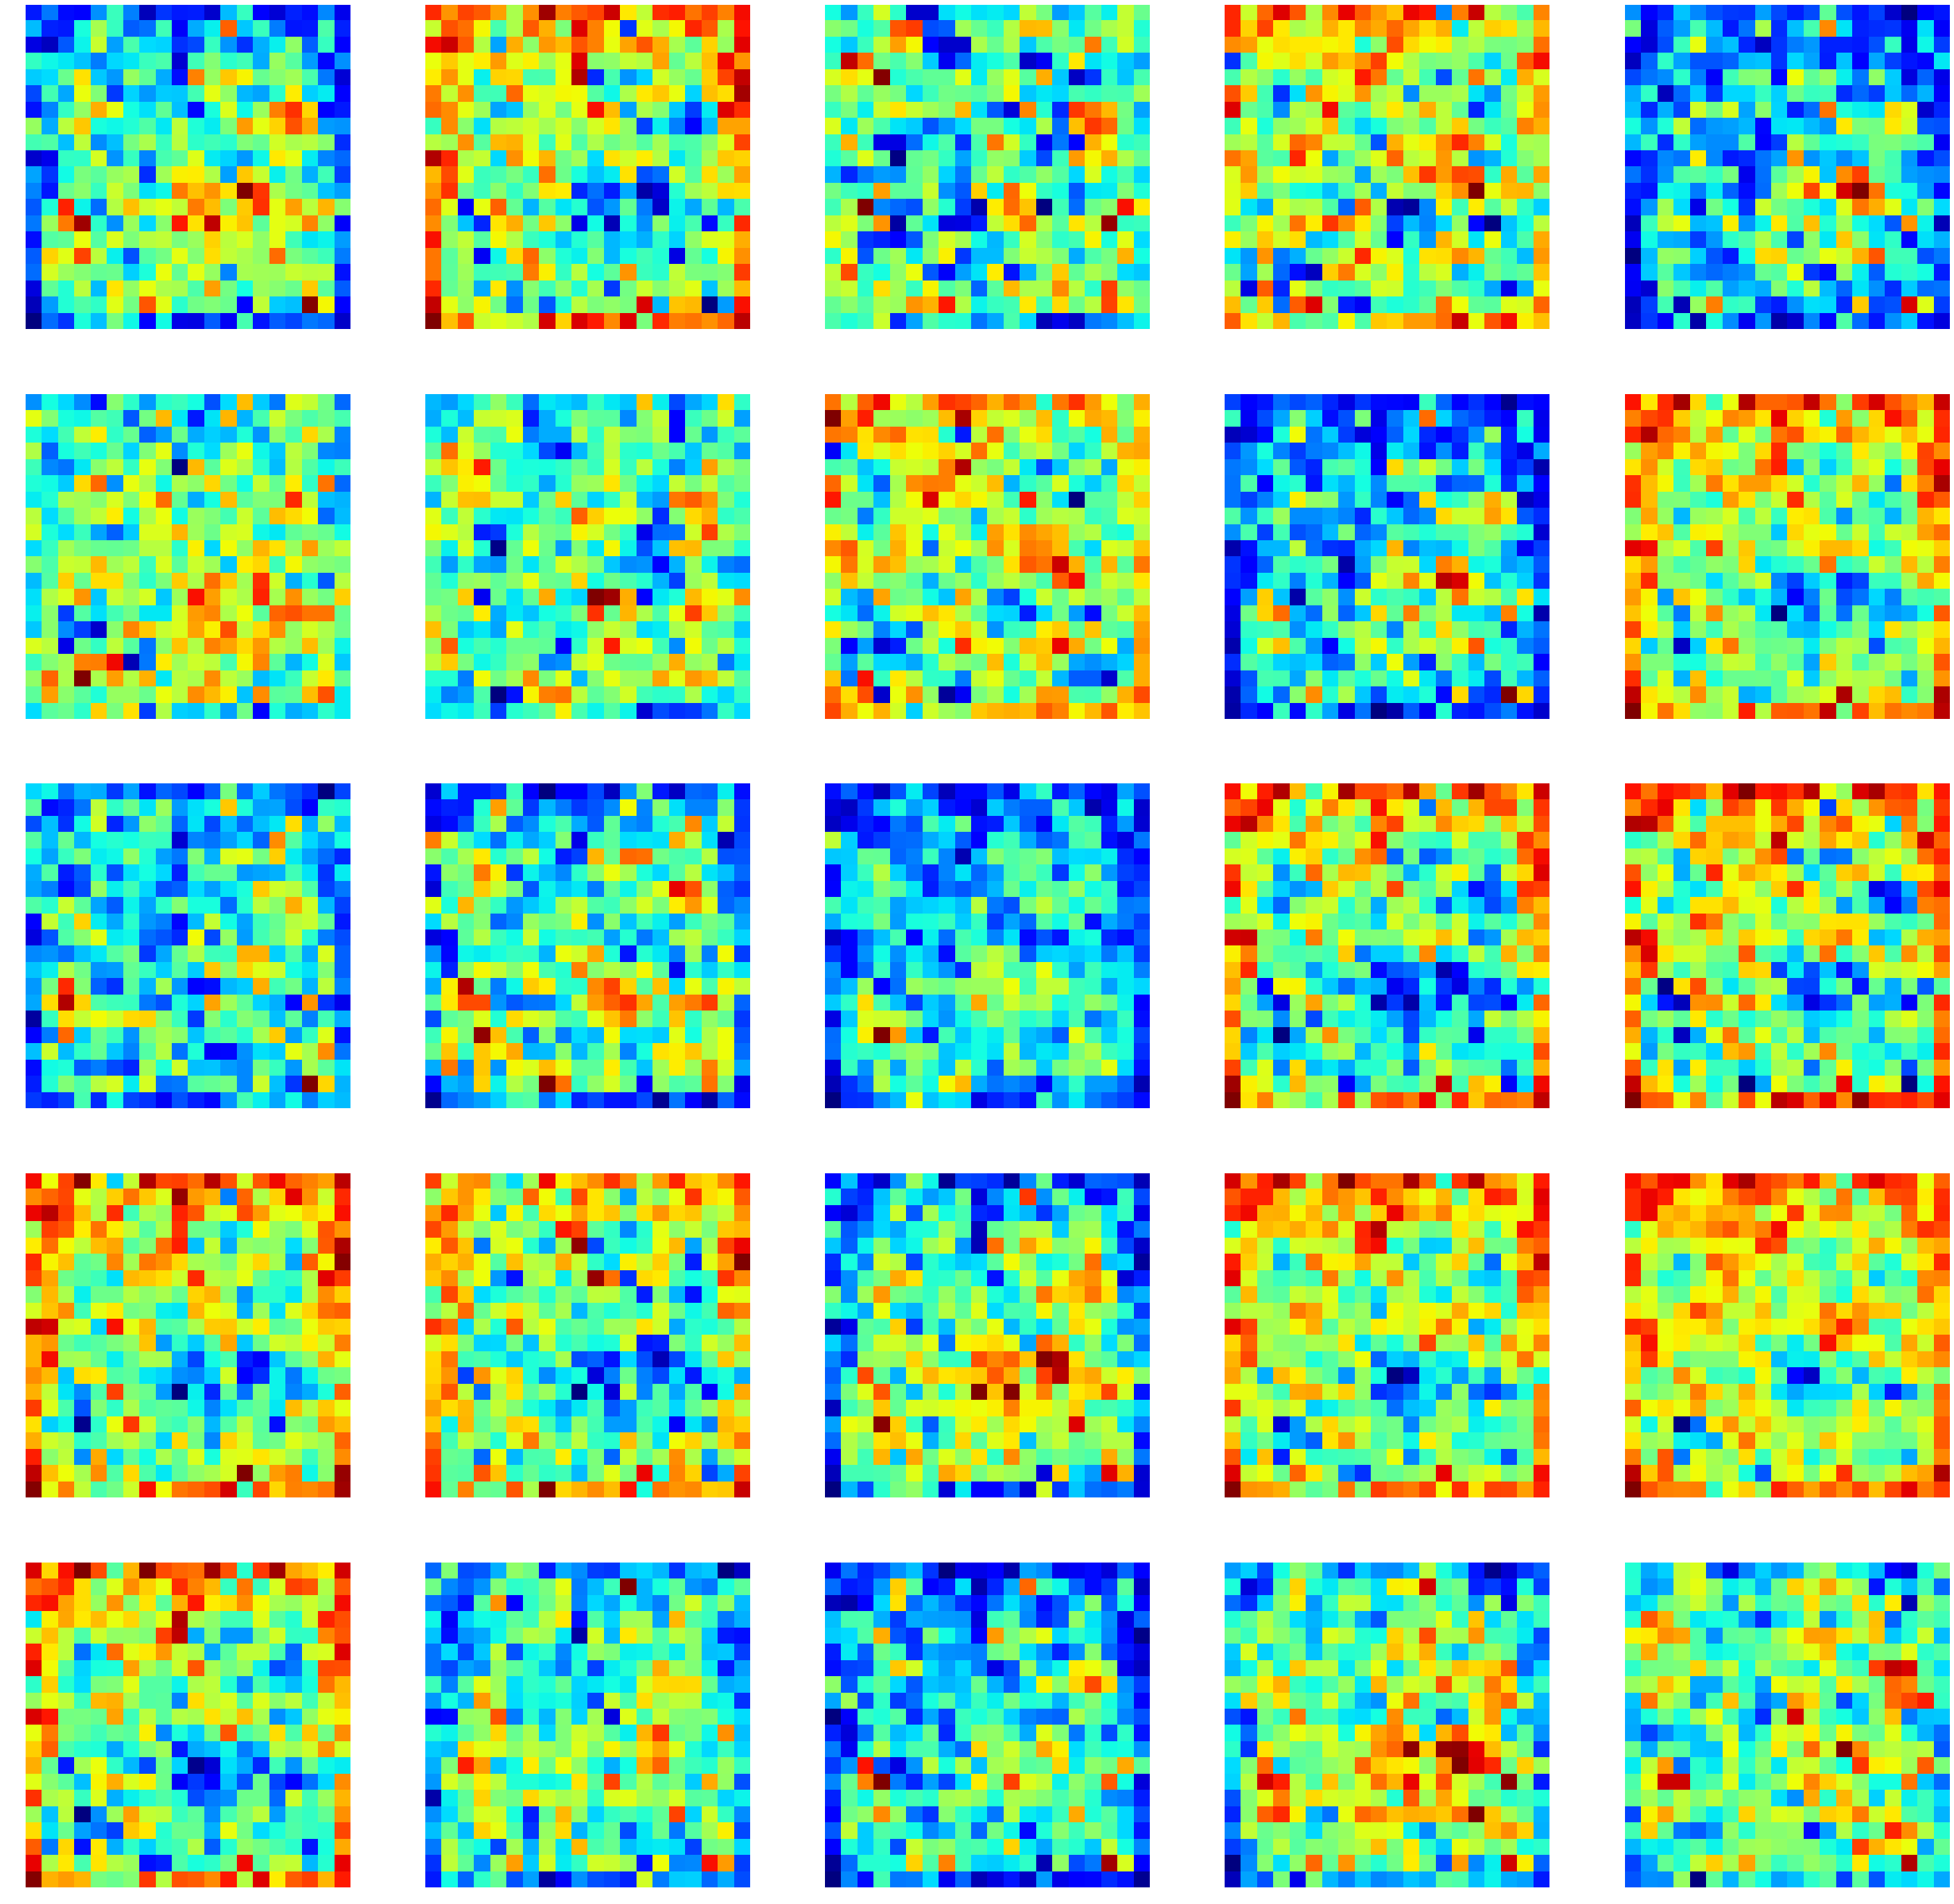

epoch 55, mean loss 7.933027530670166, std loss 0.05245073136940448


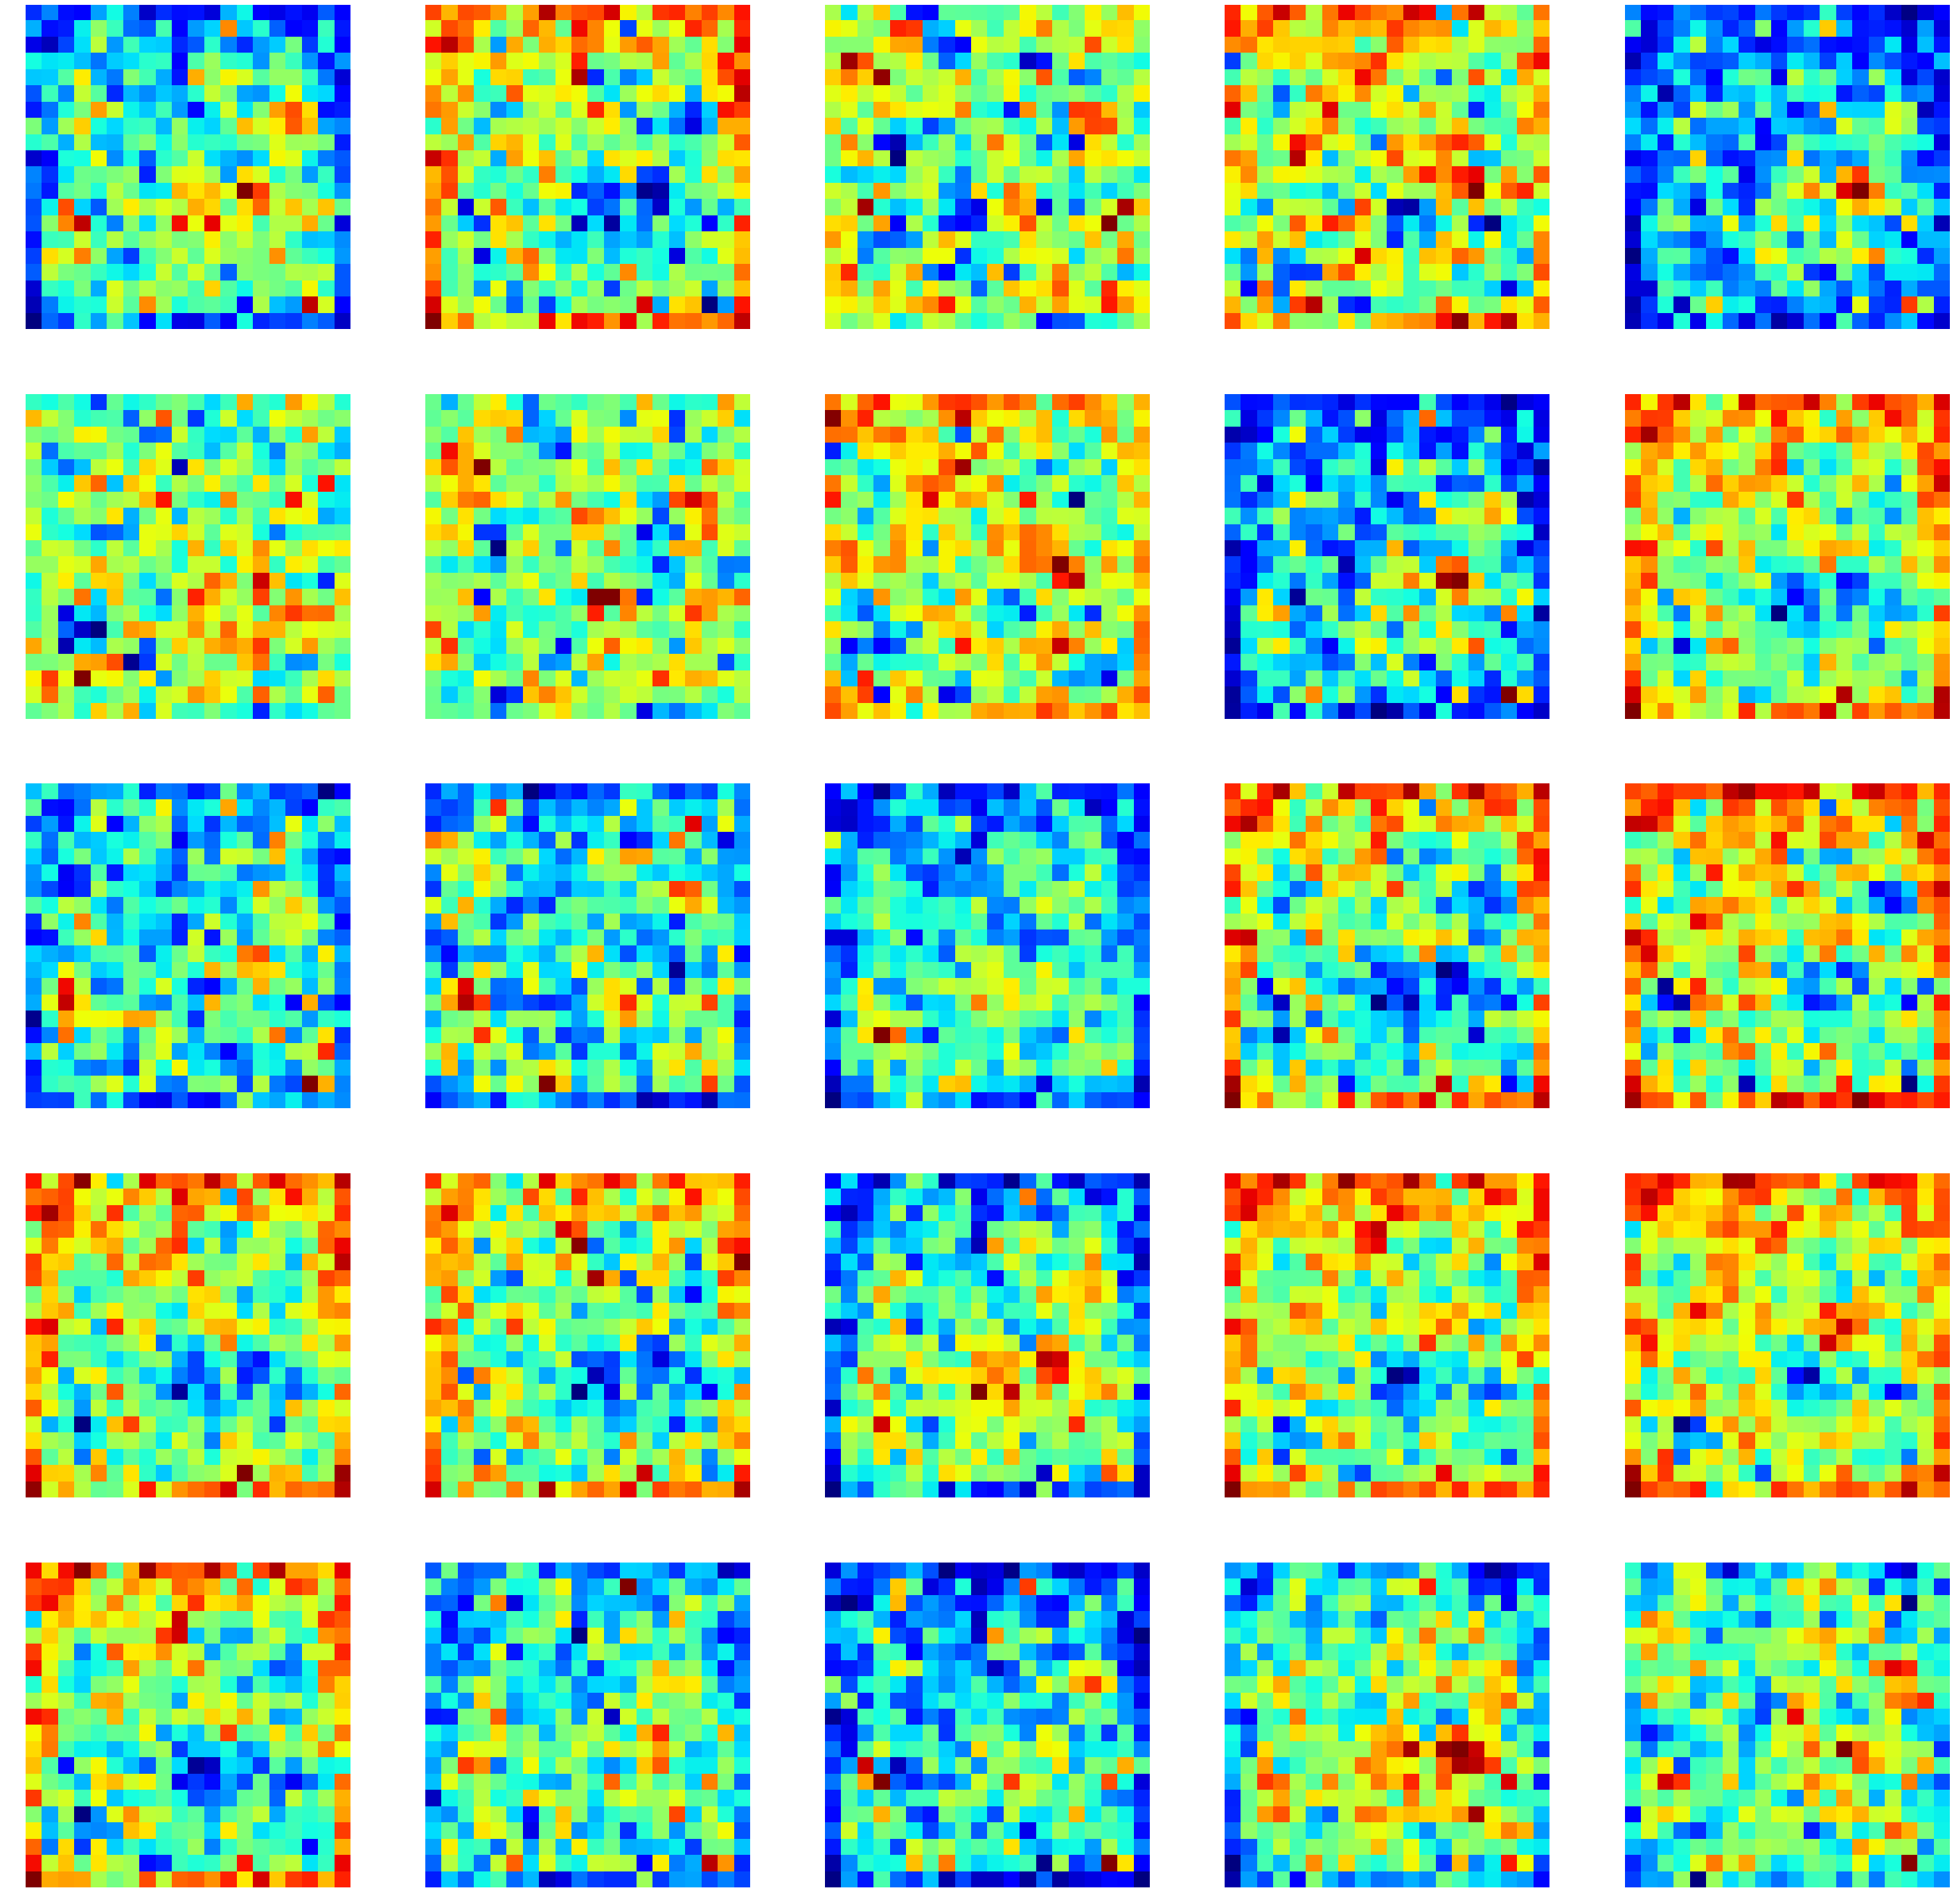

epoch 56, mean loss 7.933506454467773, std loss 0.05243048296992998


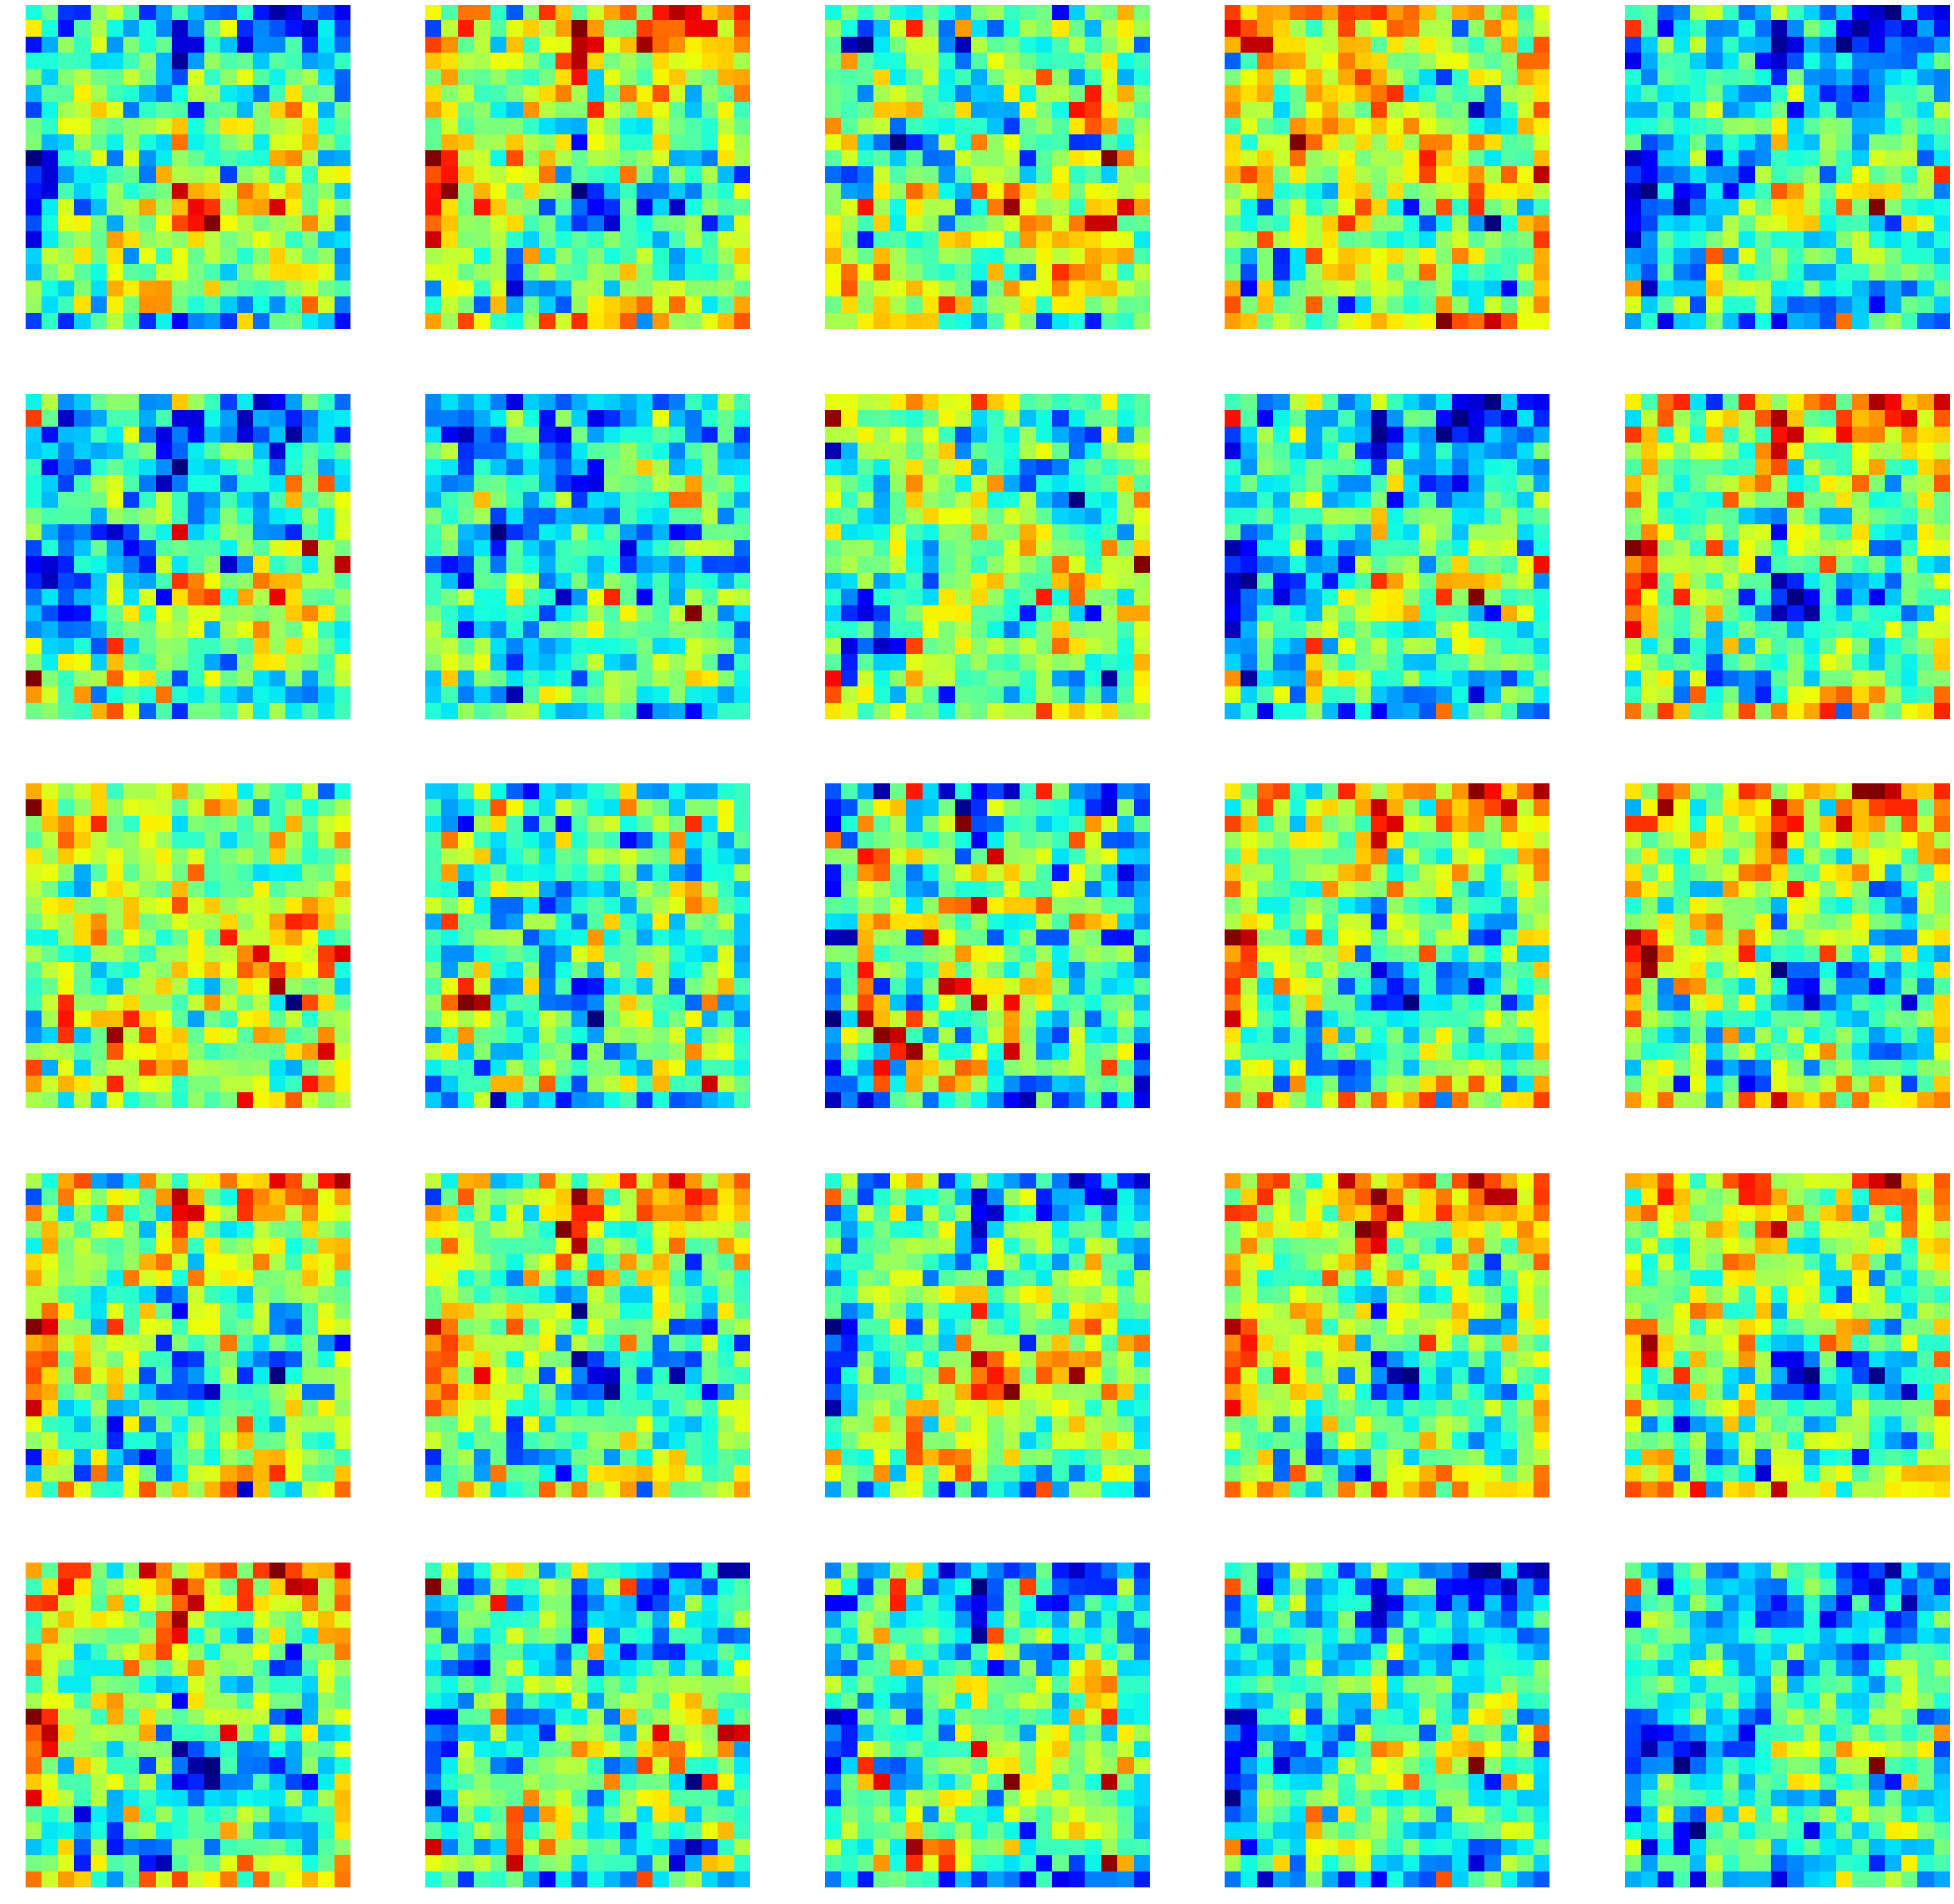

epoch 57, mean loss 7.933880547523499, std loss 0.052383725734198645


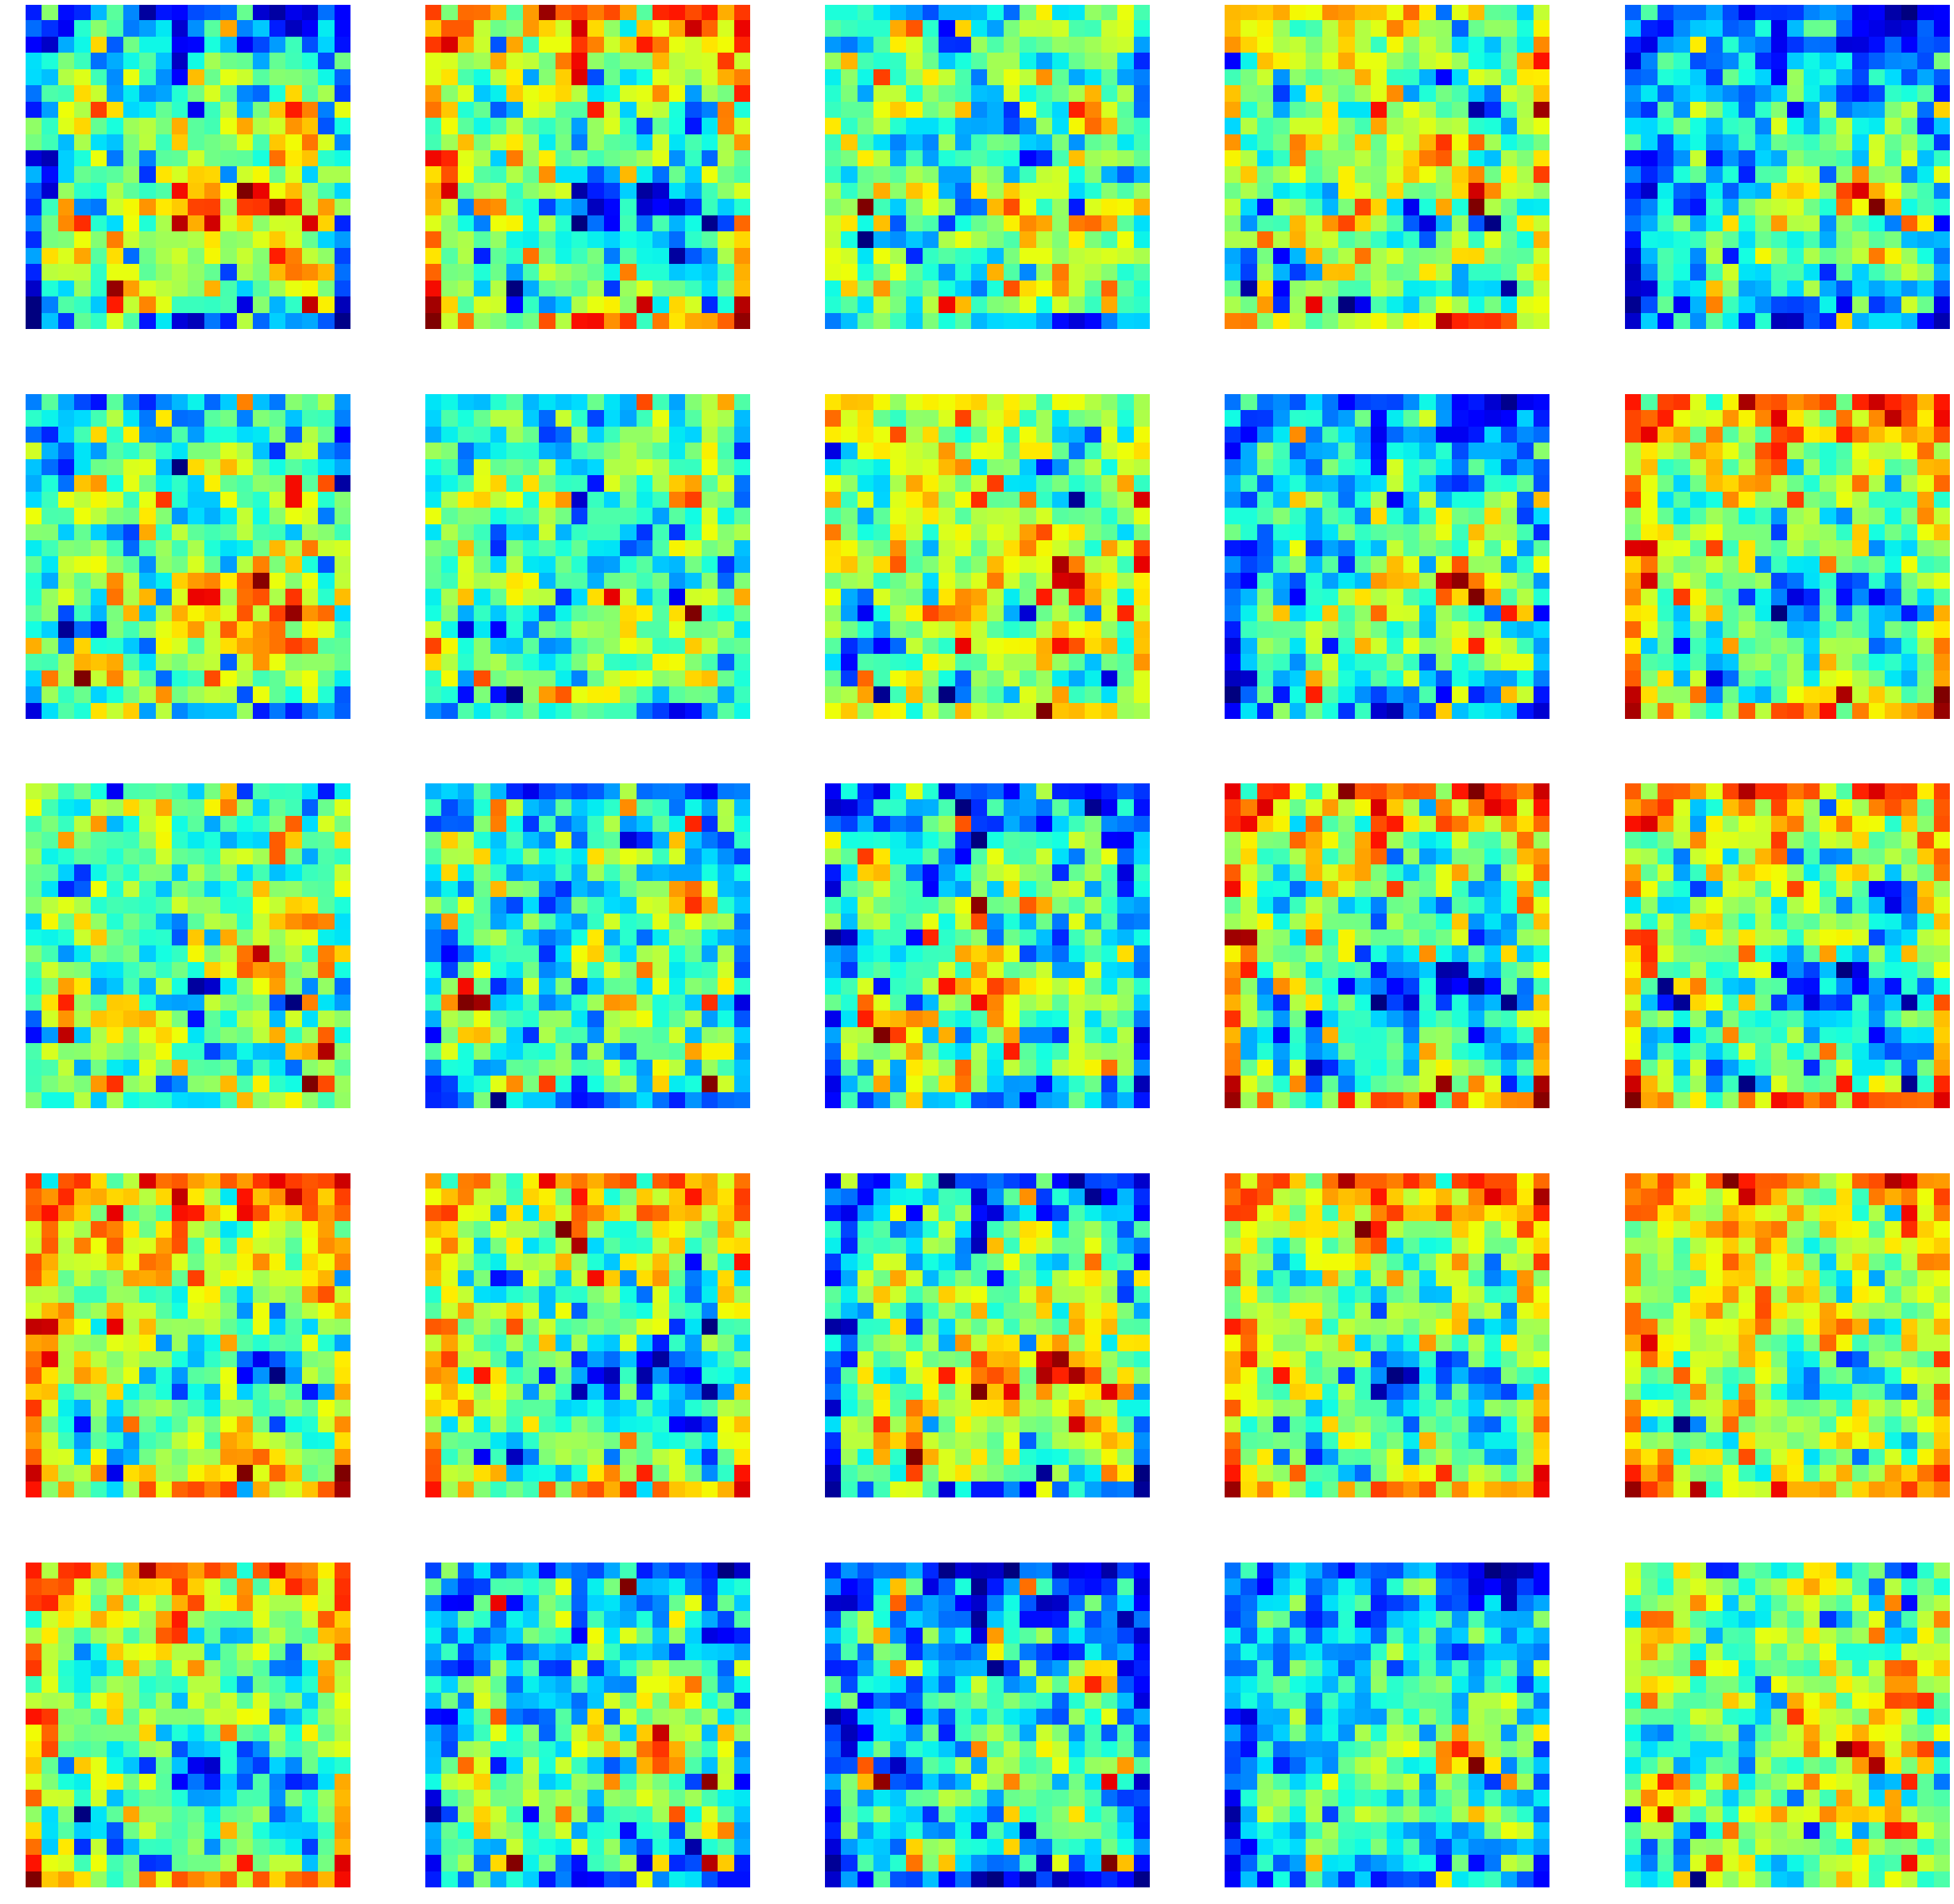

epoch 58, mean loss 7.933072513580322, std loss 0.052540629339486444


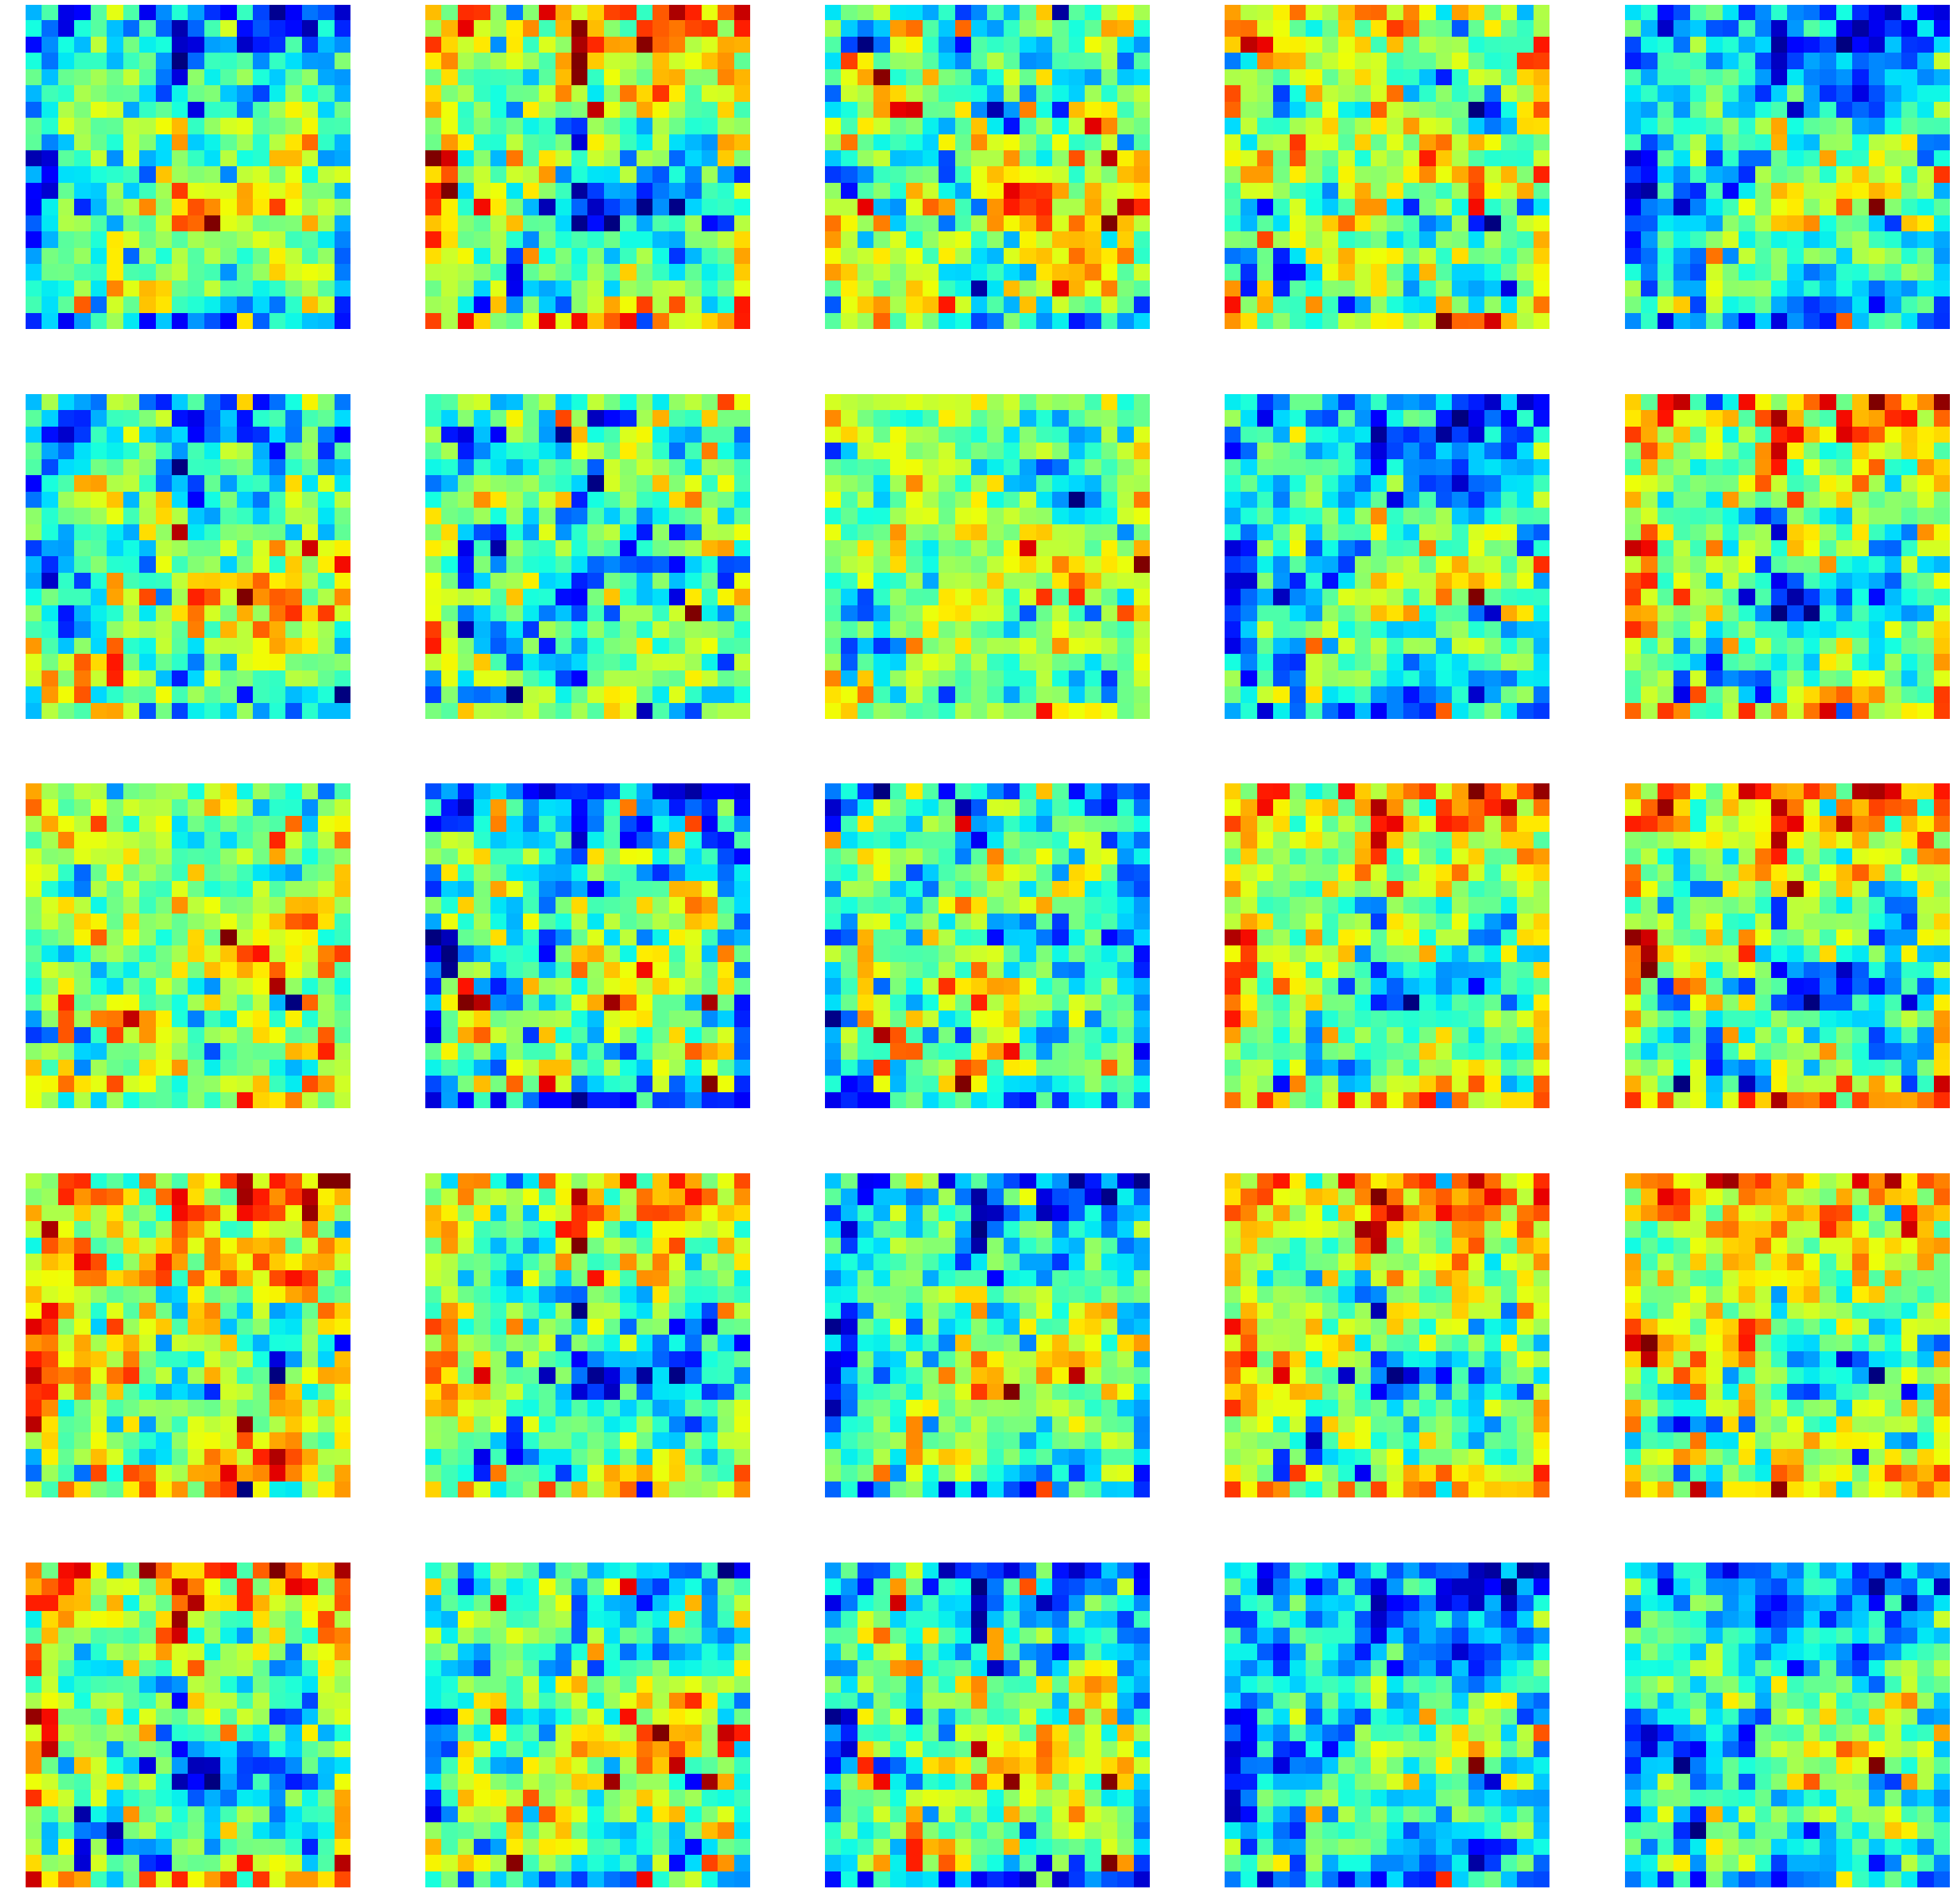

epoch 59, mean loss 7.932772930145264, std loss 0.05315121923448155


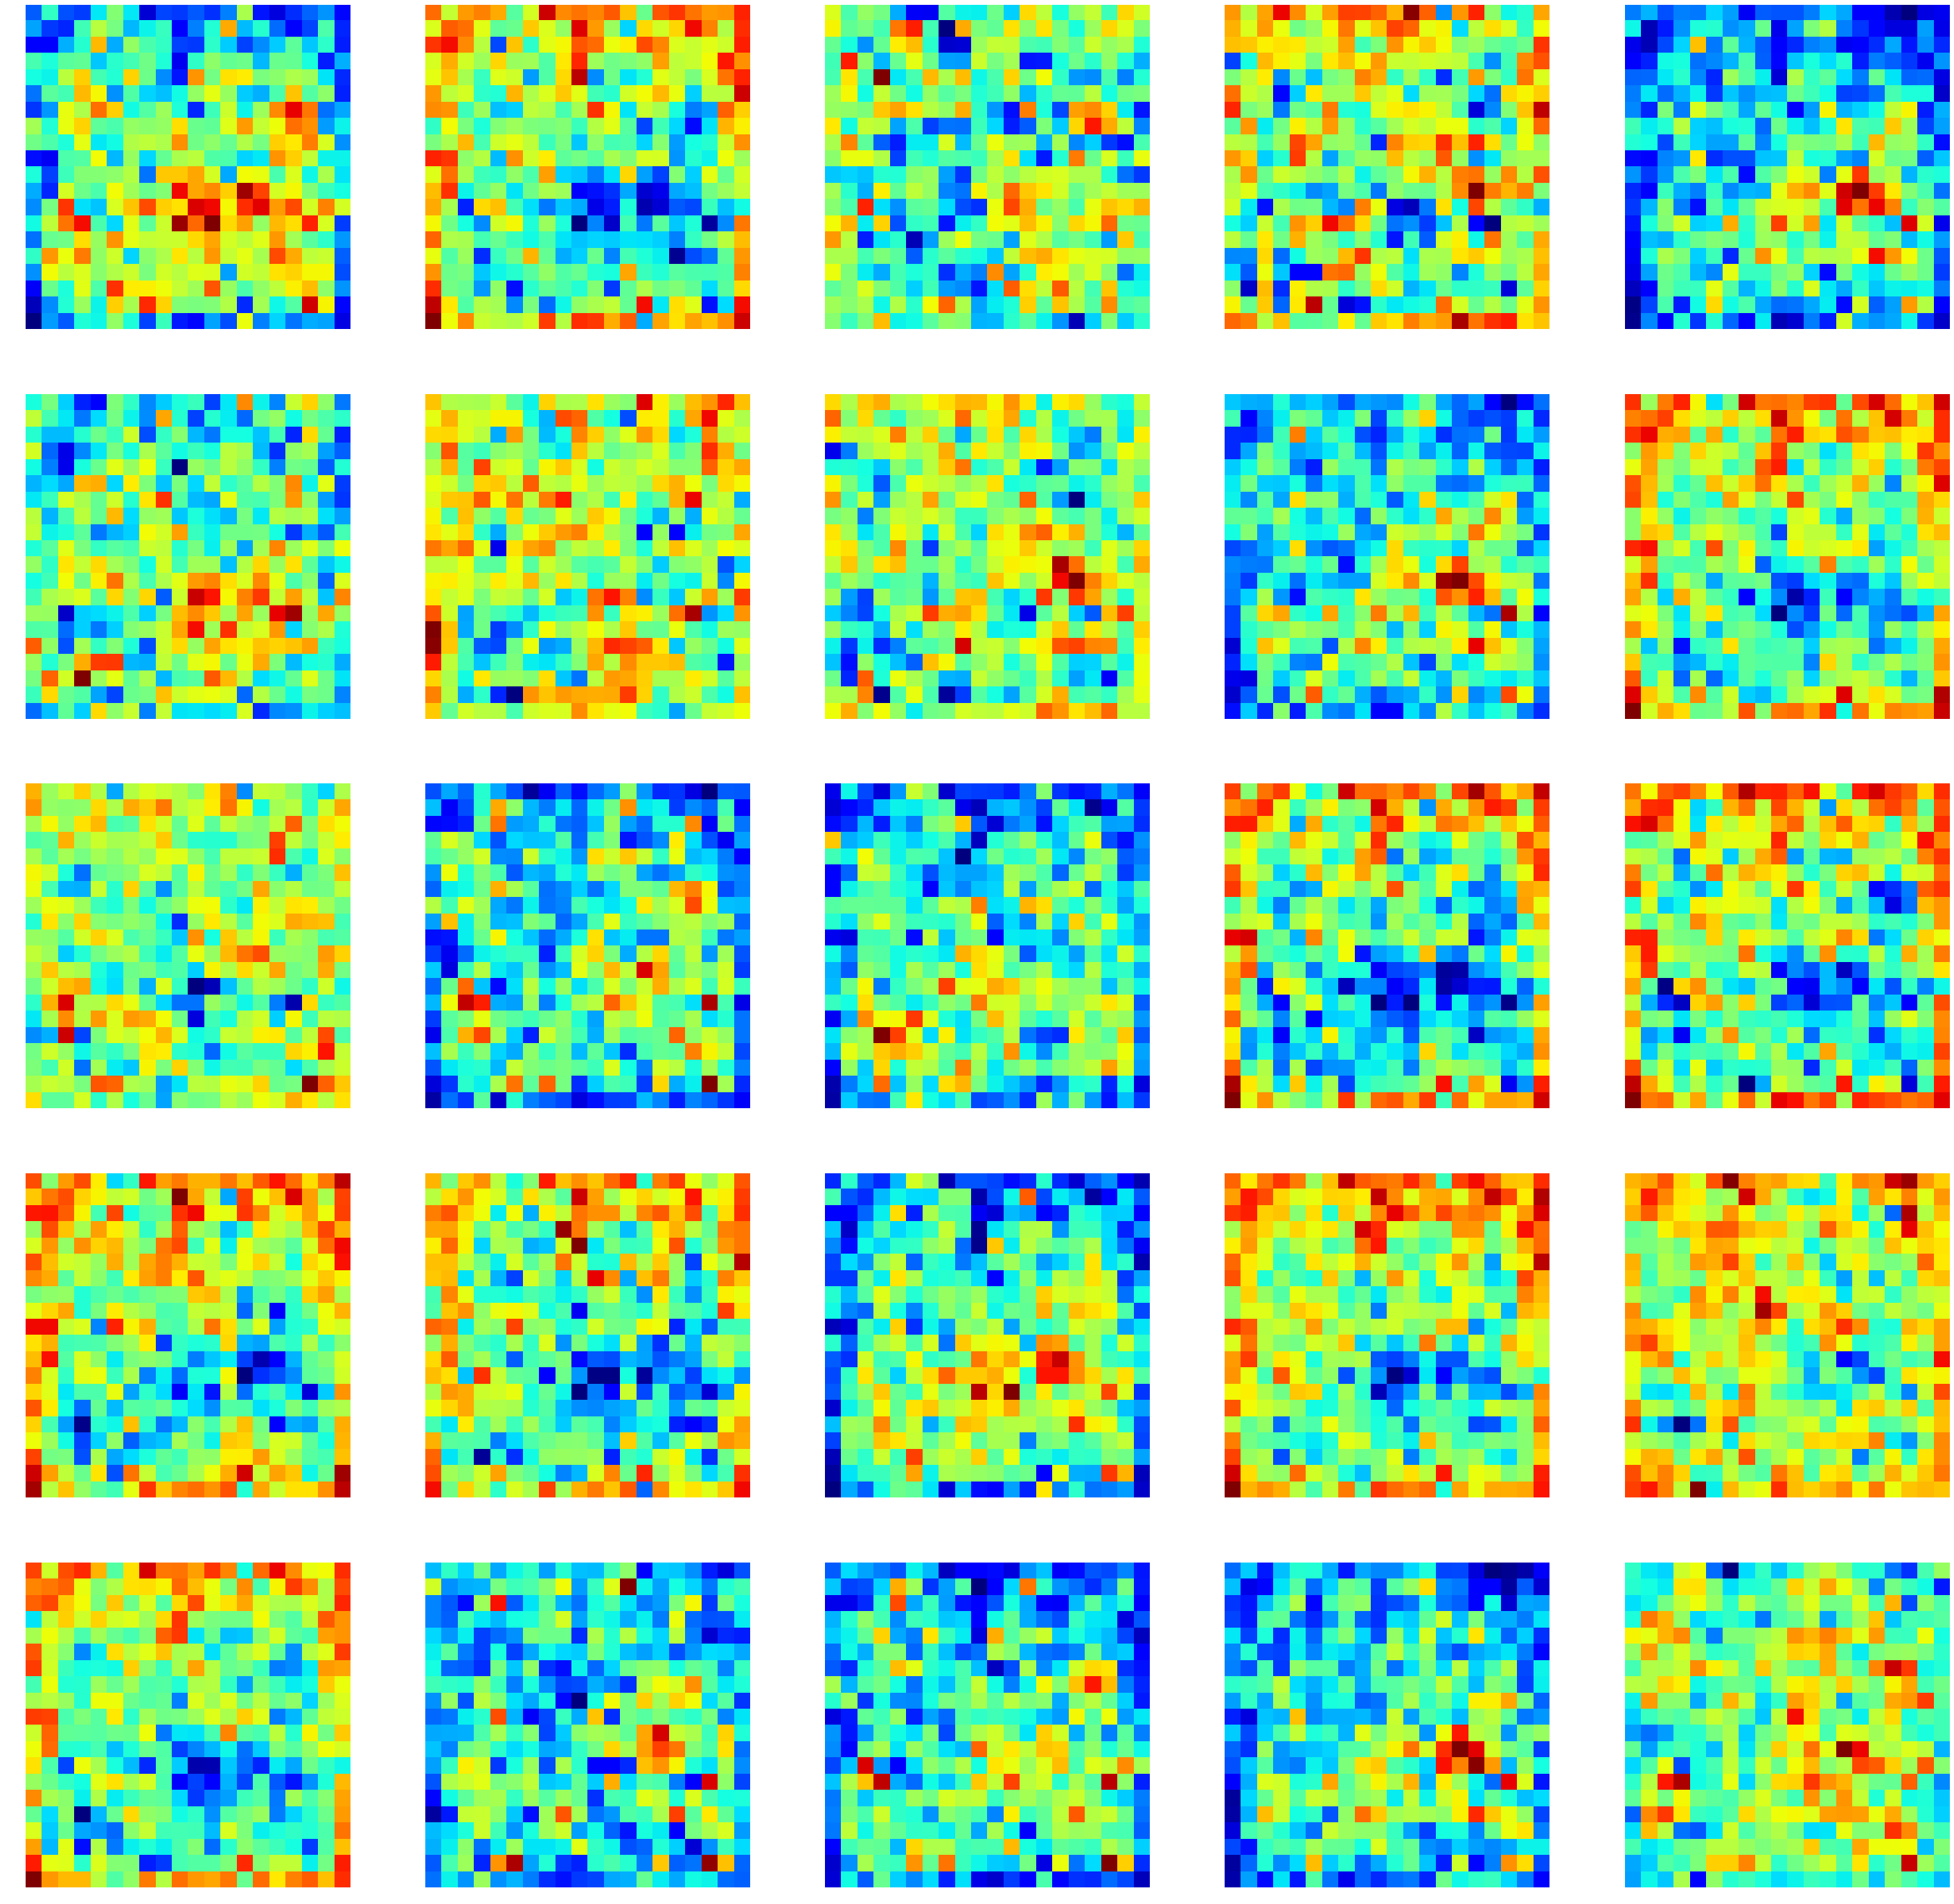

epoch 60, mean loss 7.932724578857422, std loss 0.05287013855884014


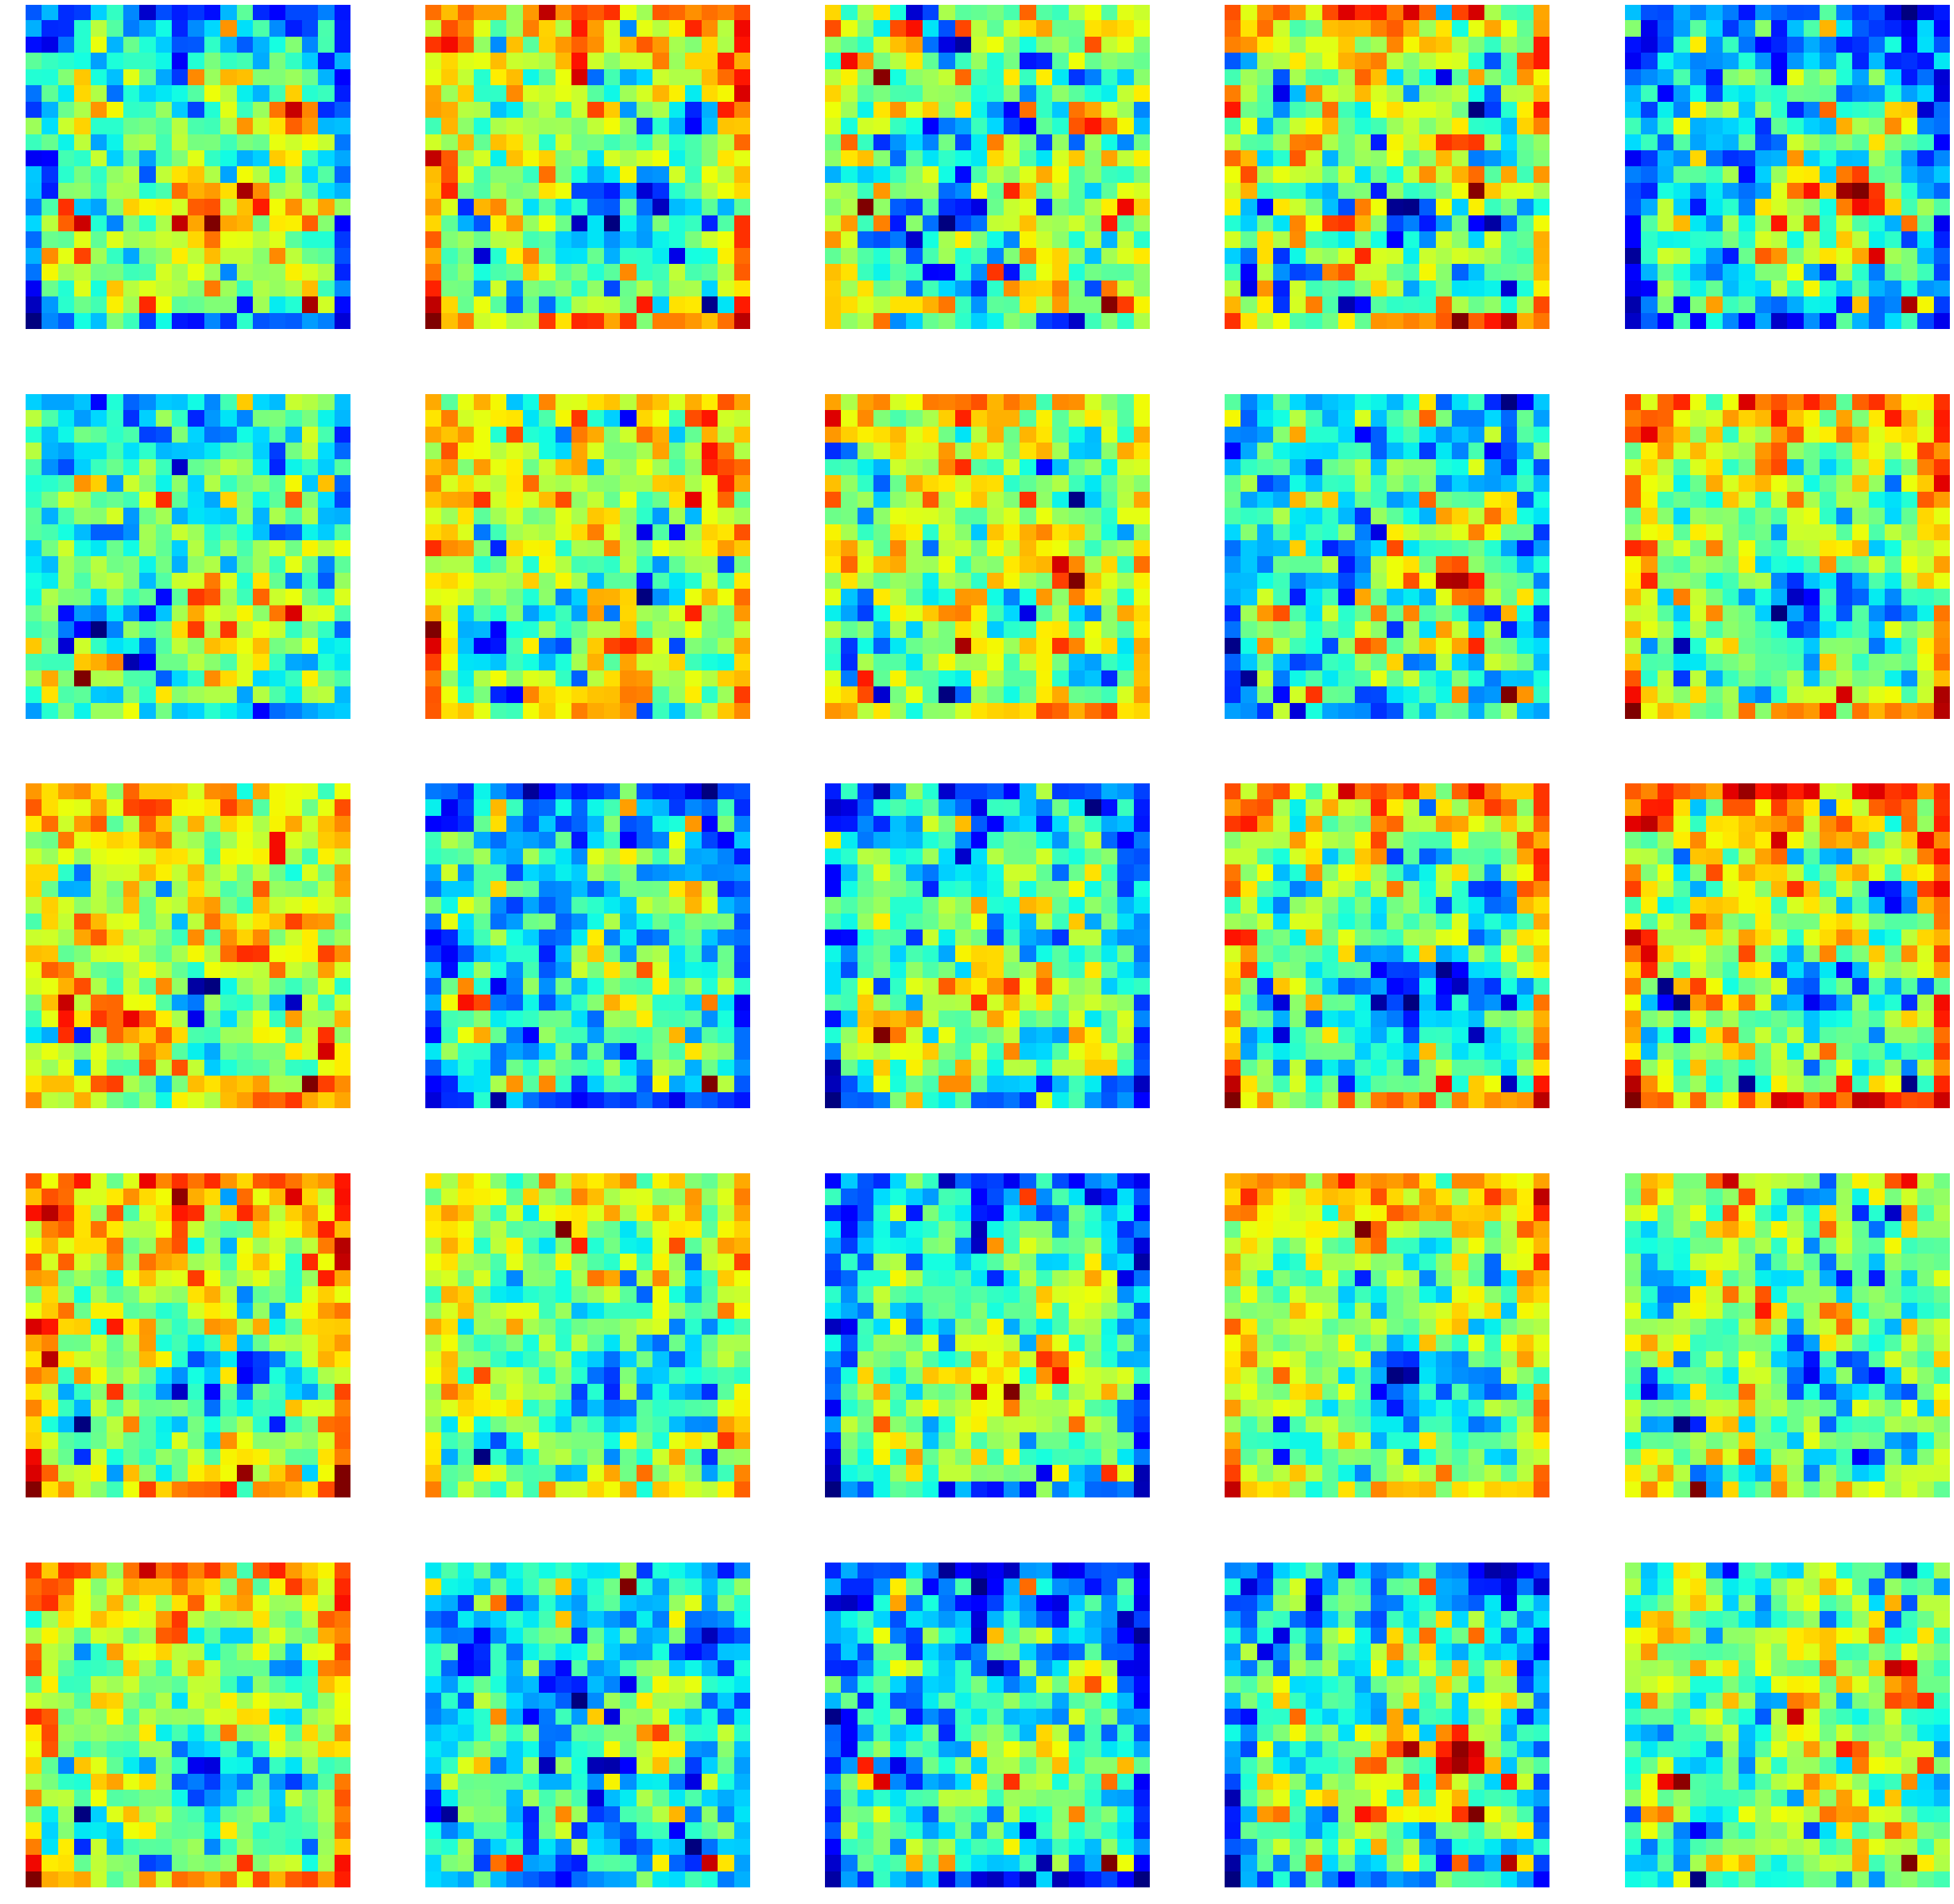

epoch 61, mean loss 7.93305901813507, std loss 0.05318830478095829


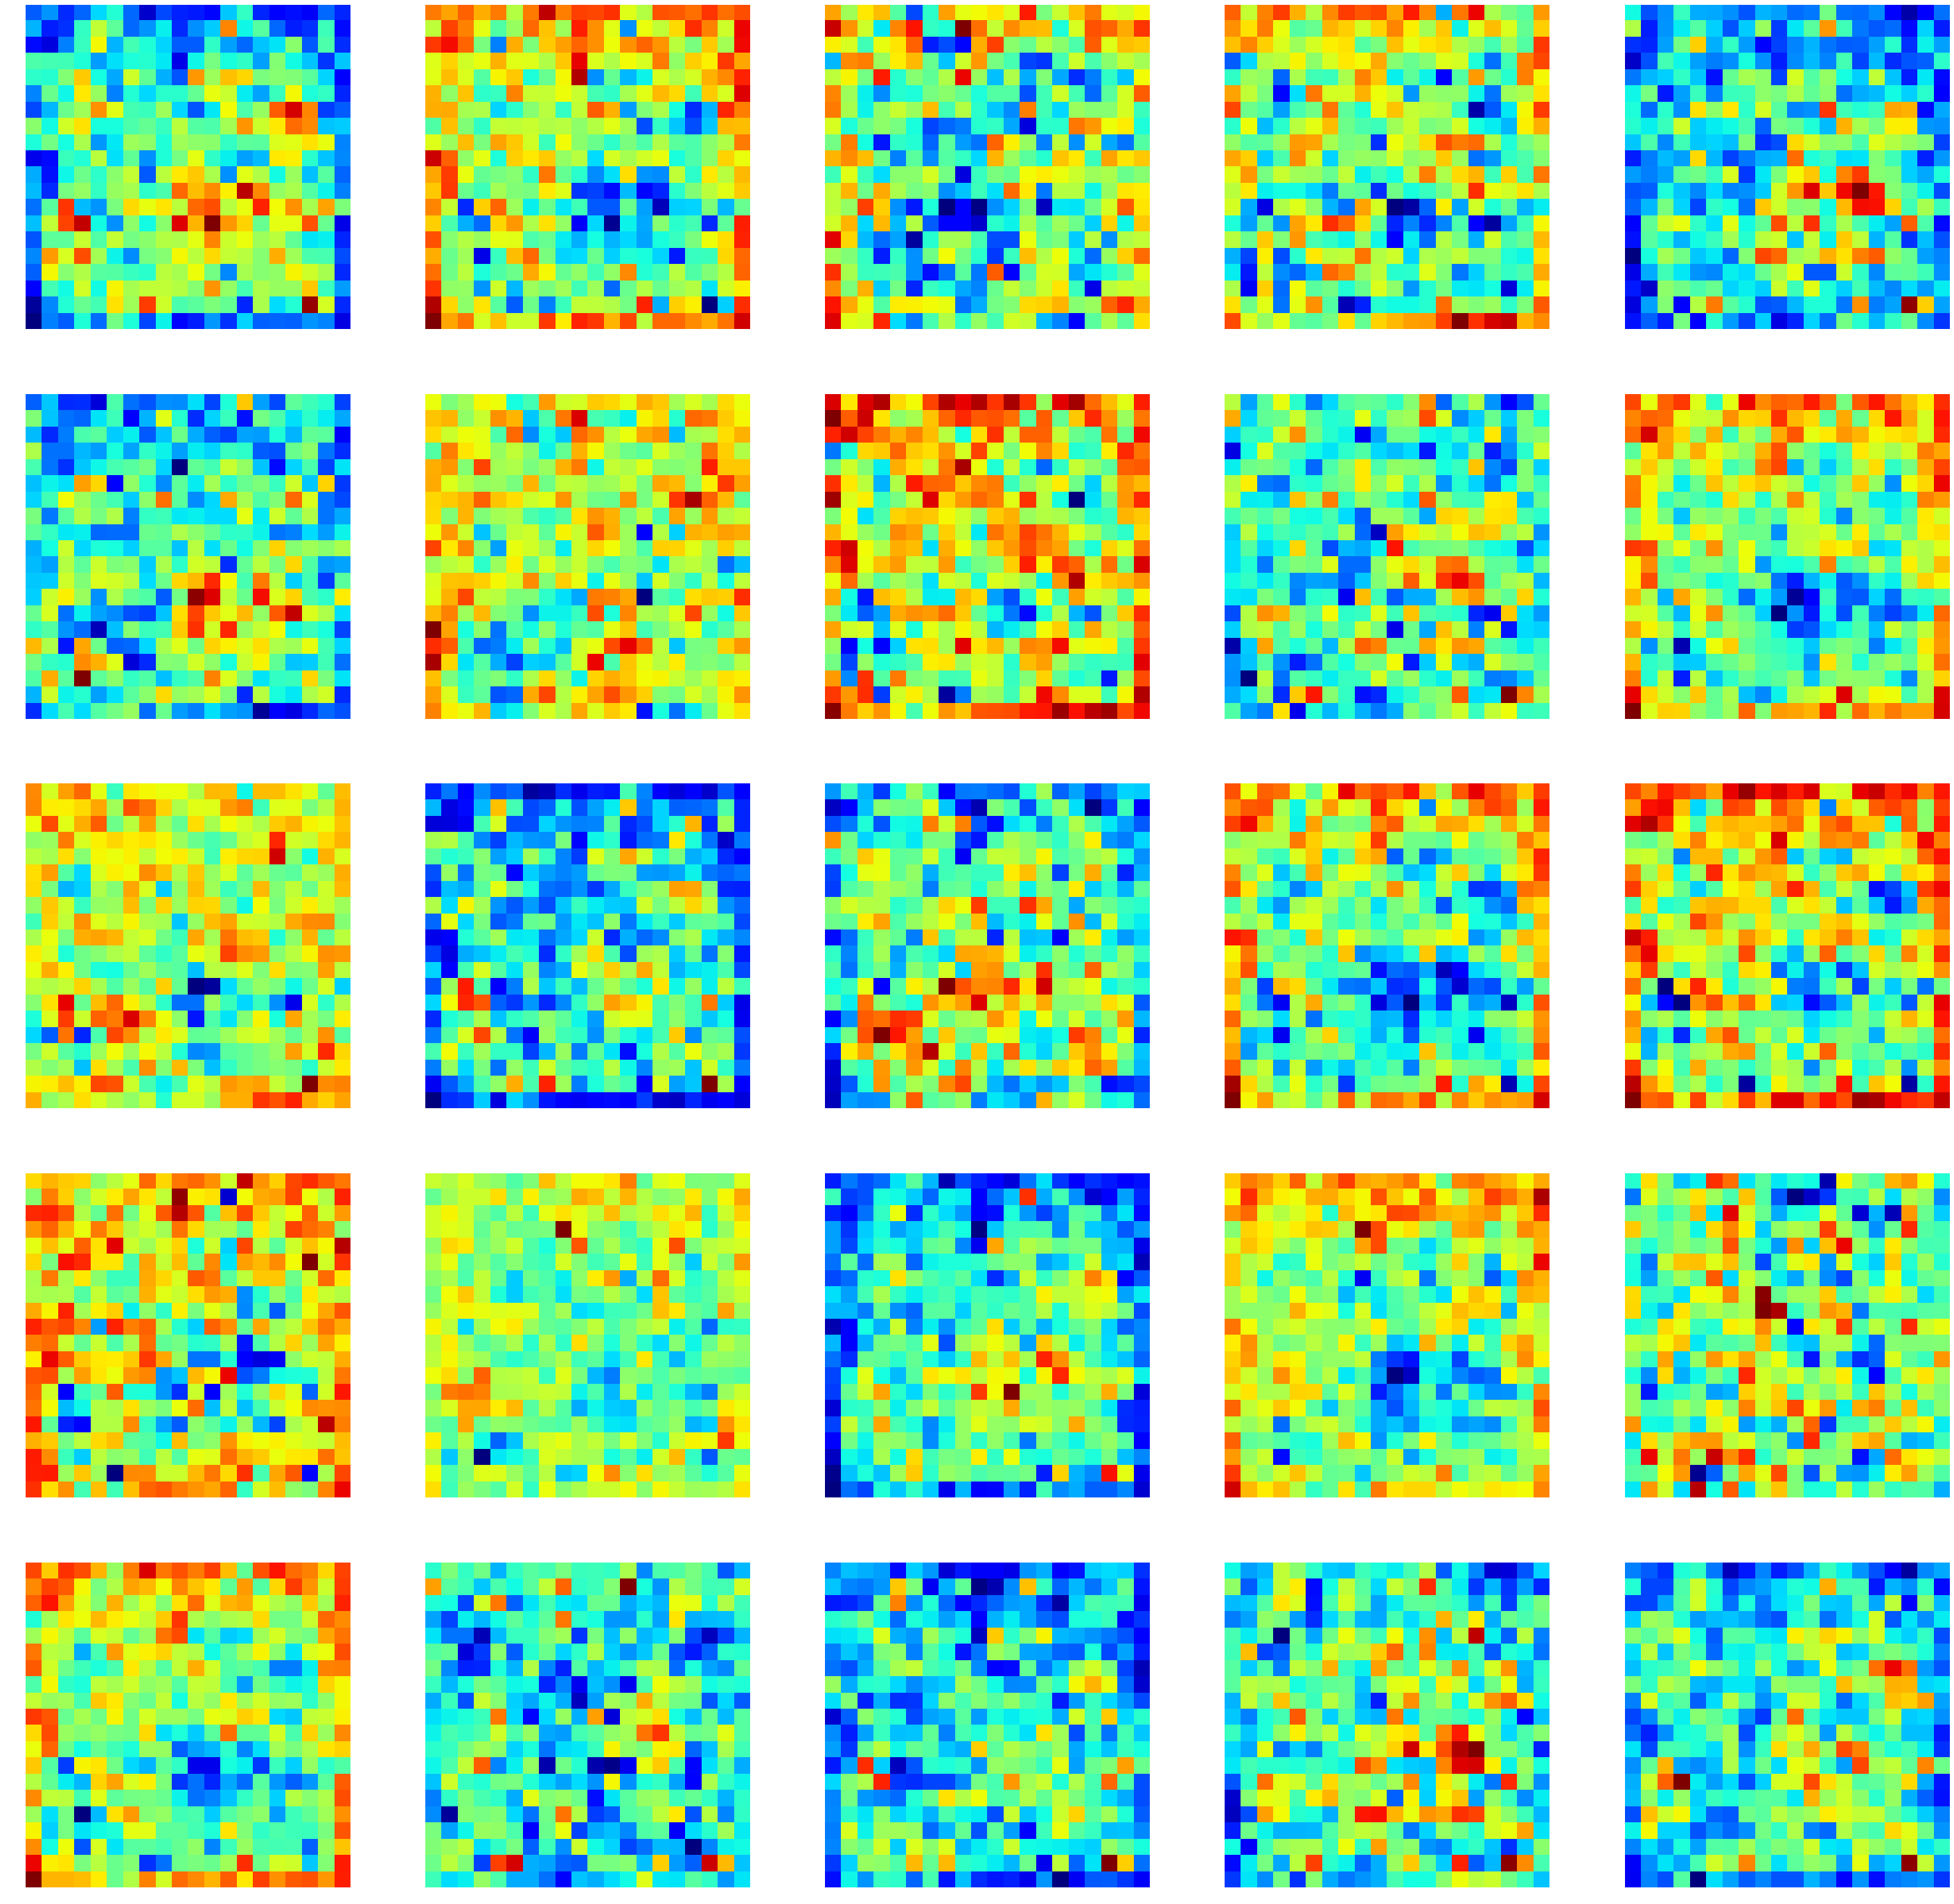

epoch 62, mean loss 7.932980858802796, std loss 0.05307657592695936


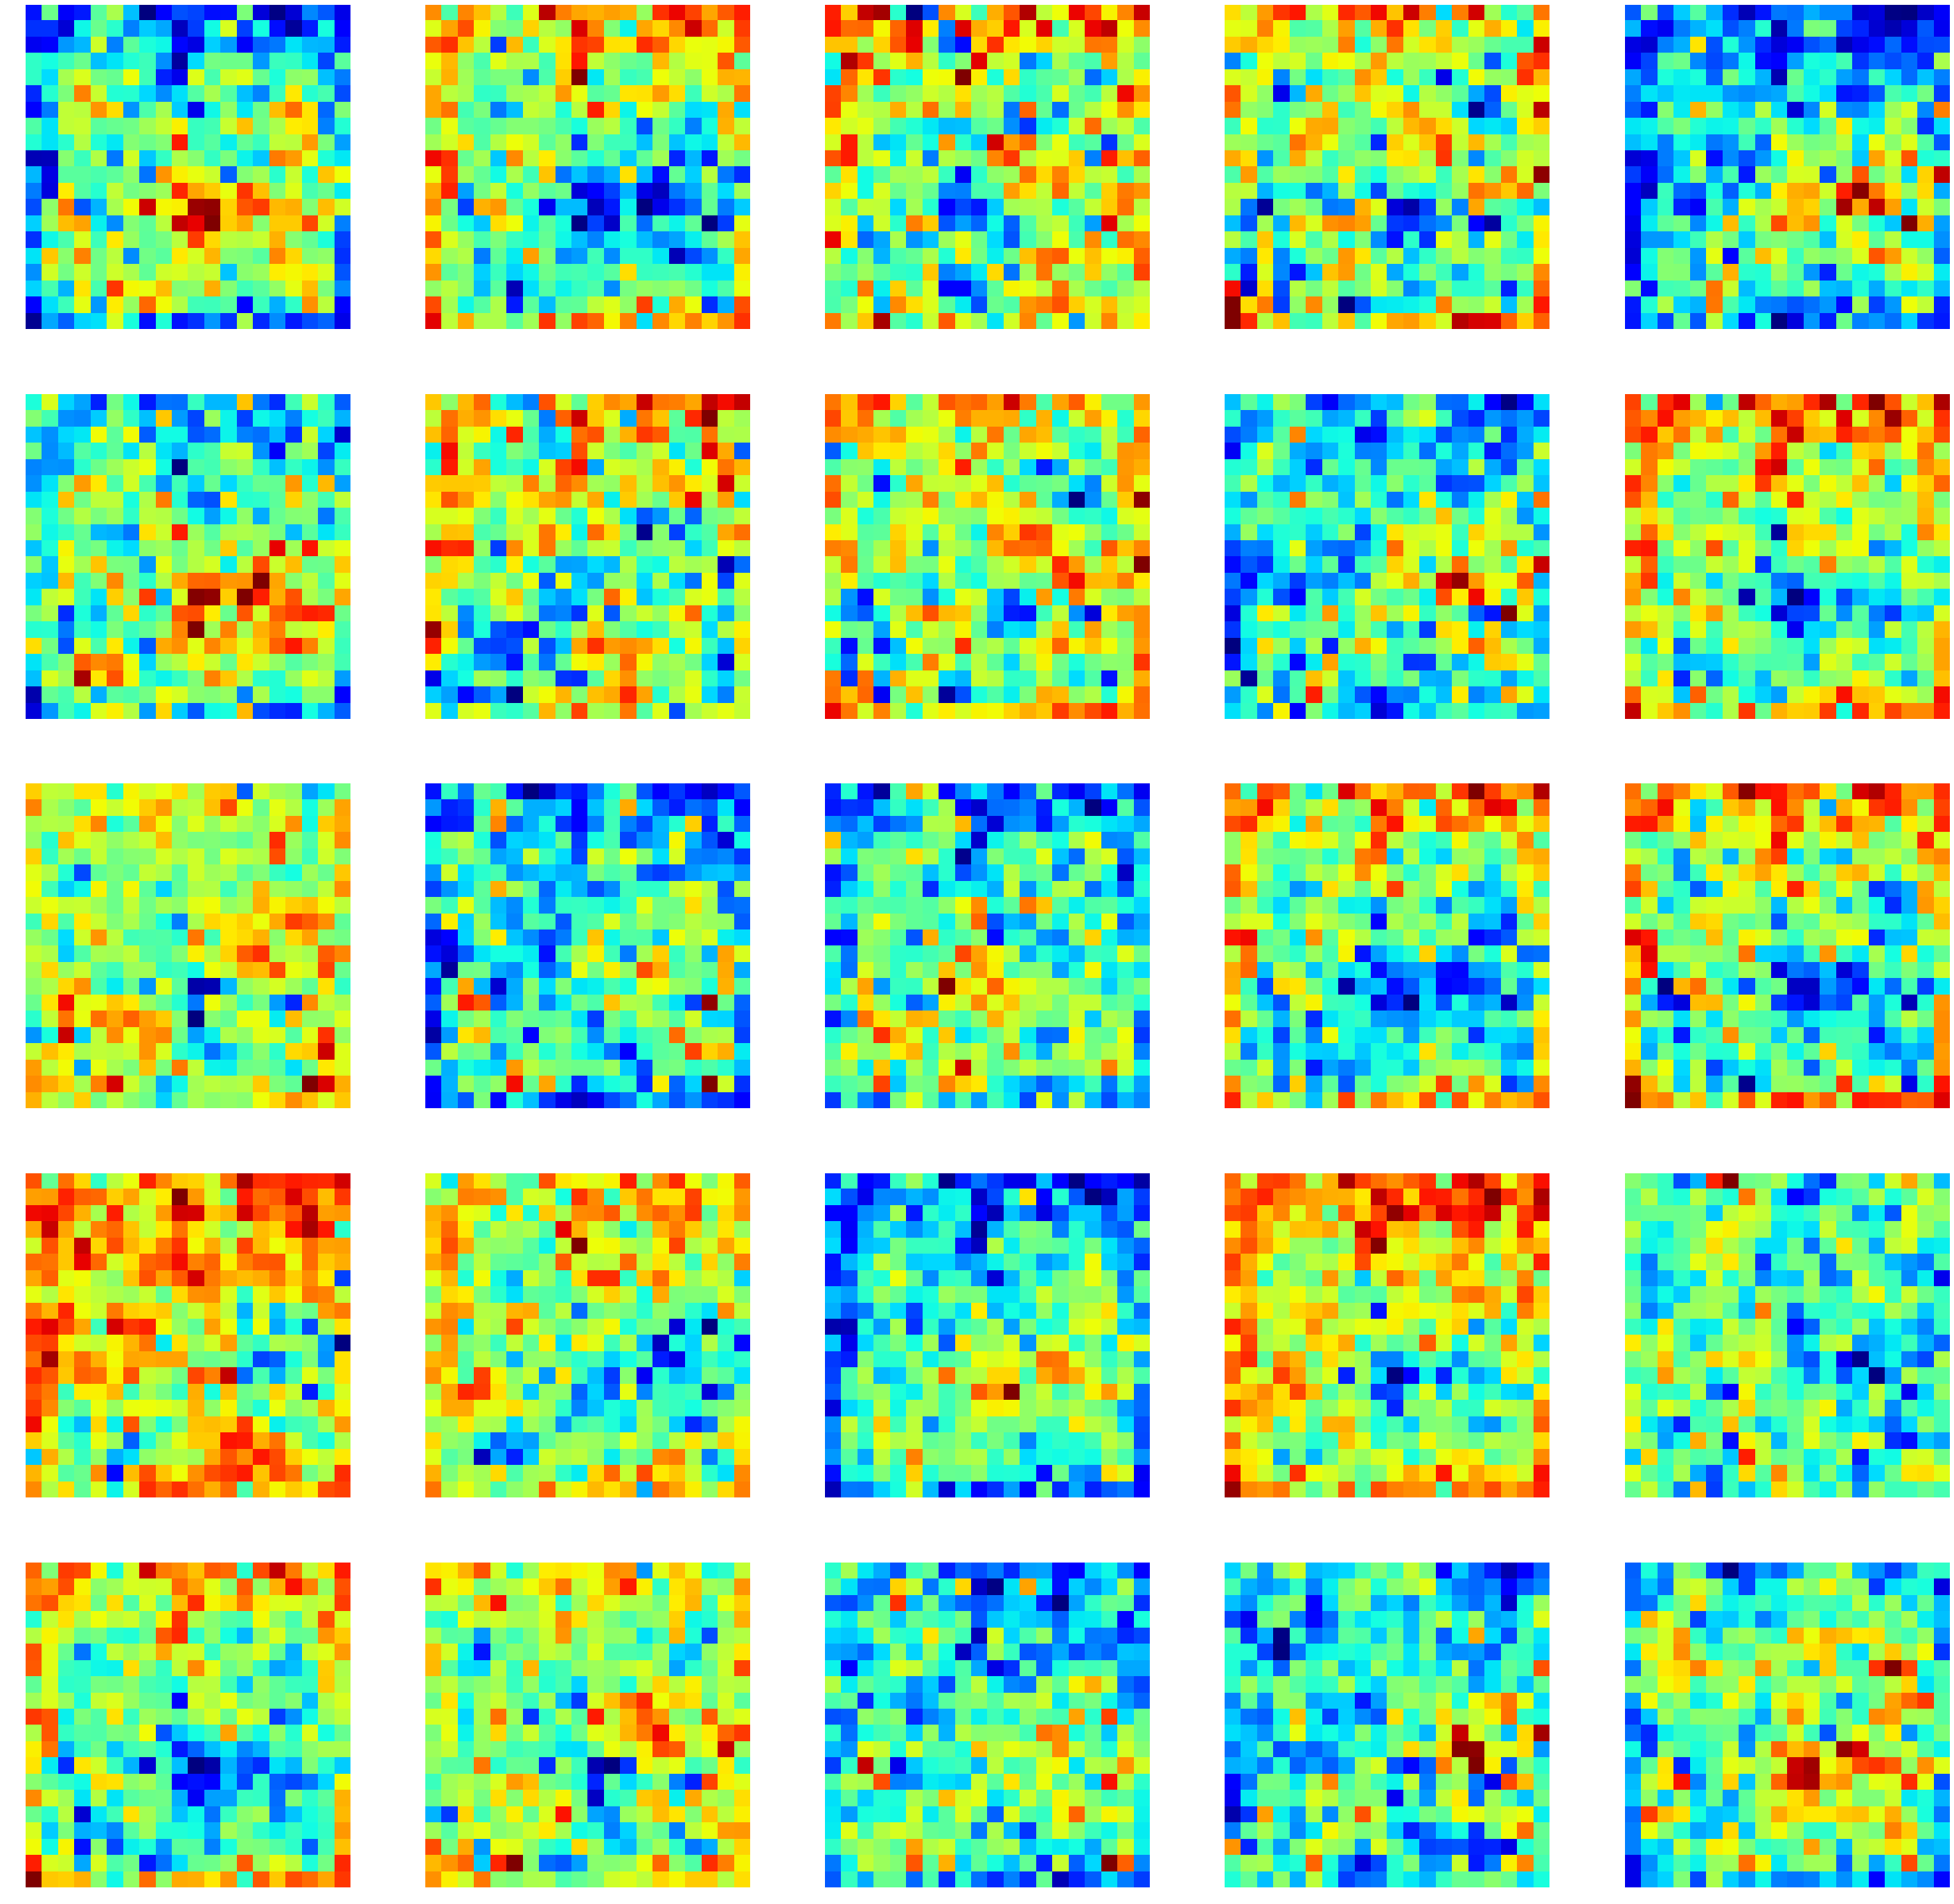

epoch 63, mean loss 7.932952077388763, std loss 0.052842412580430875


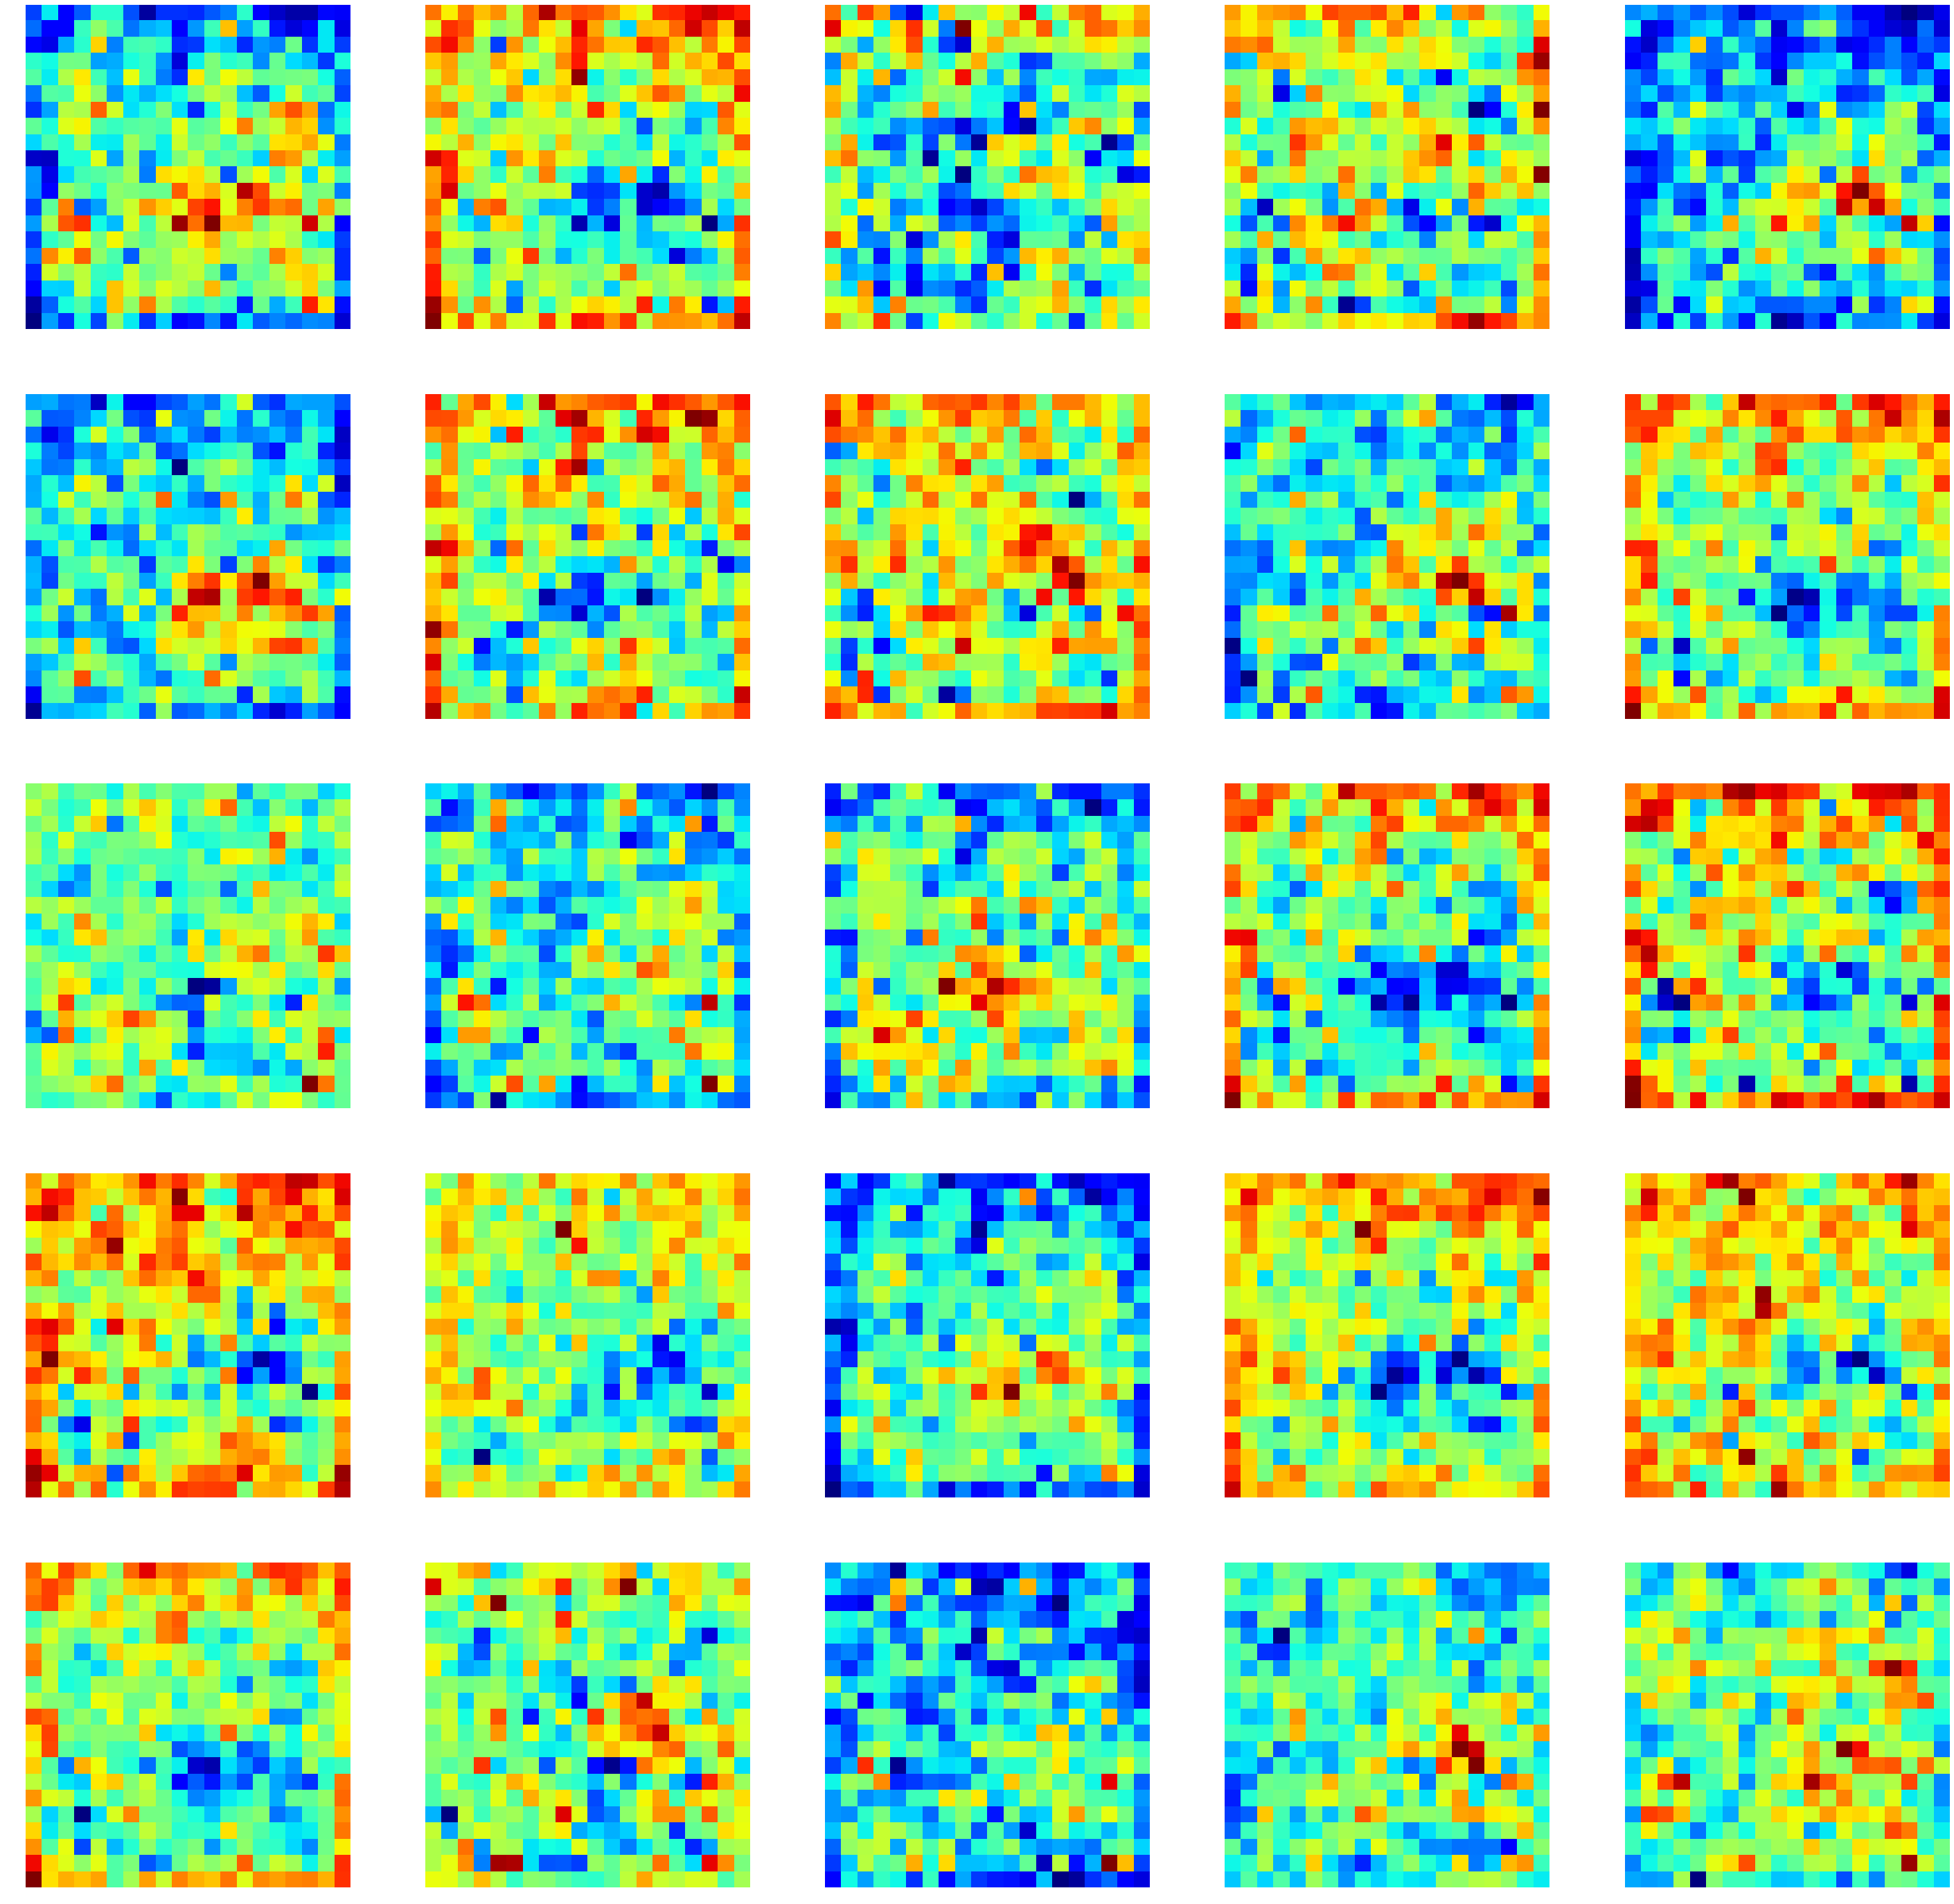

epoch 64, mean loss 7.932959535598755, std loss 0.05311116224712328


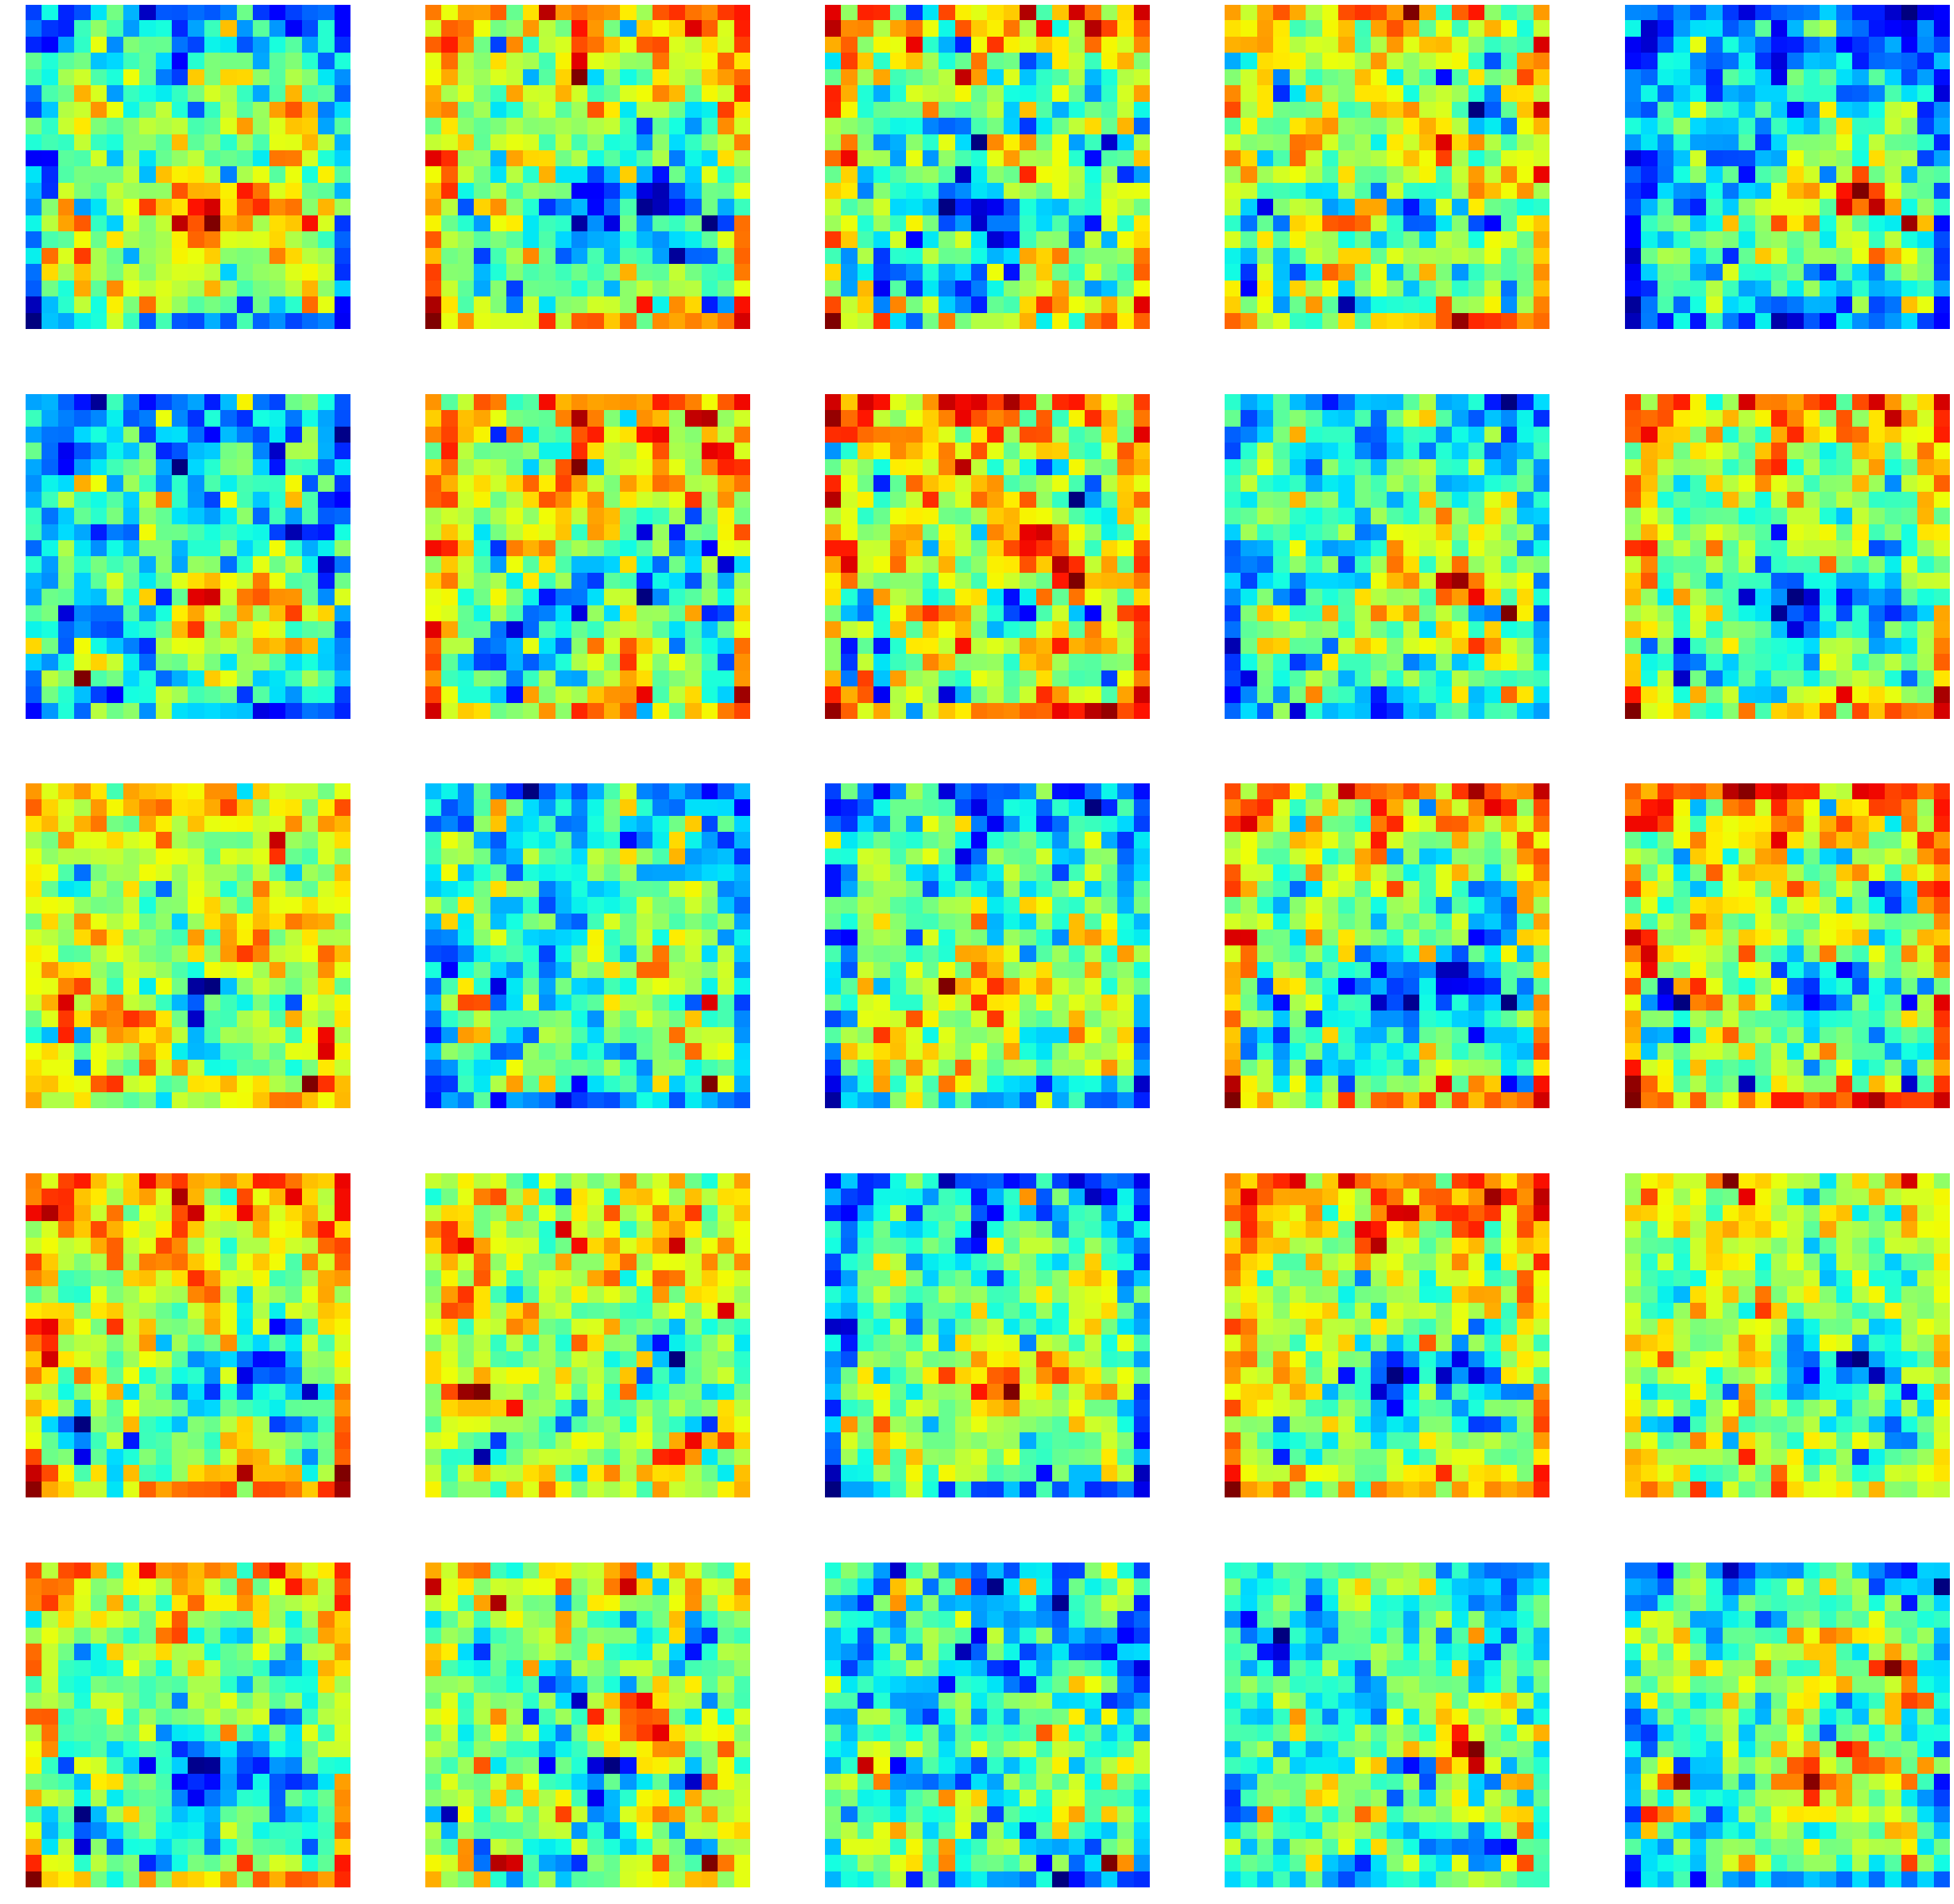

epoch 65, mean loss 7.9332979974746705, std loss 0.053416360328832777


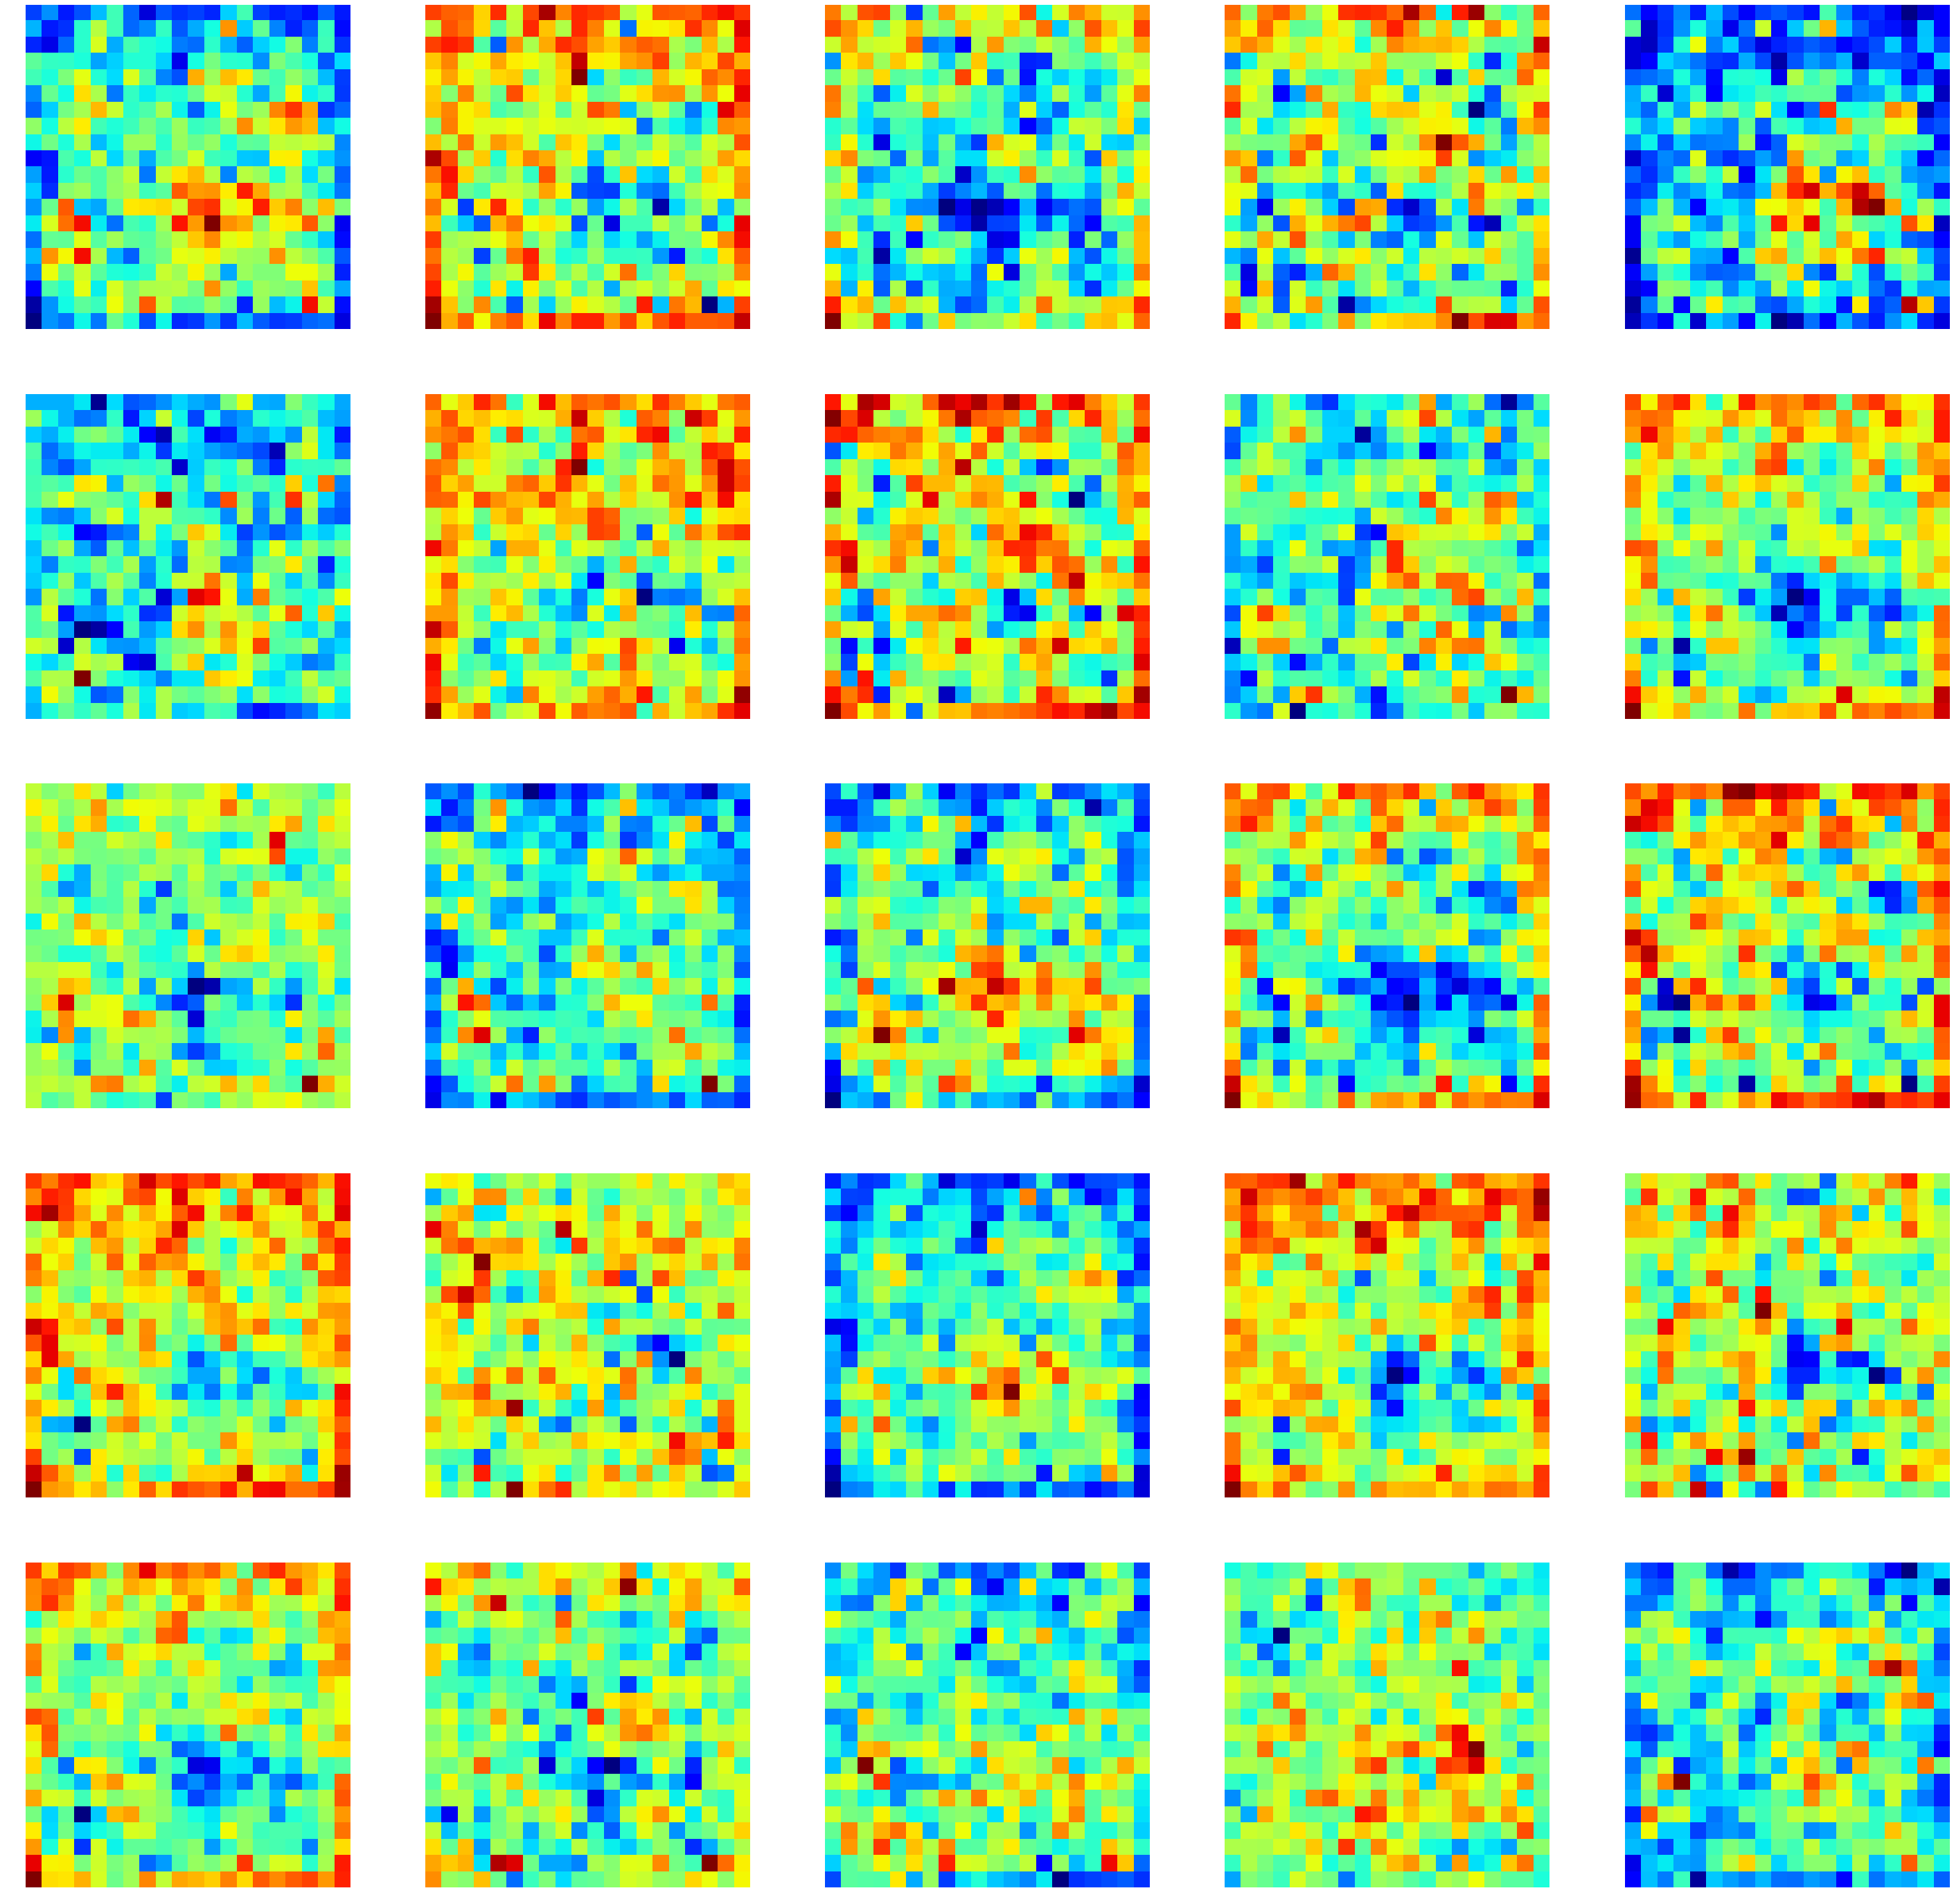

epoch 66, mean loss 7.93298185300827, std loss 0.05265093305365751


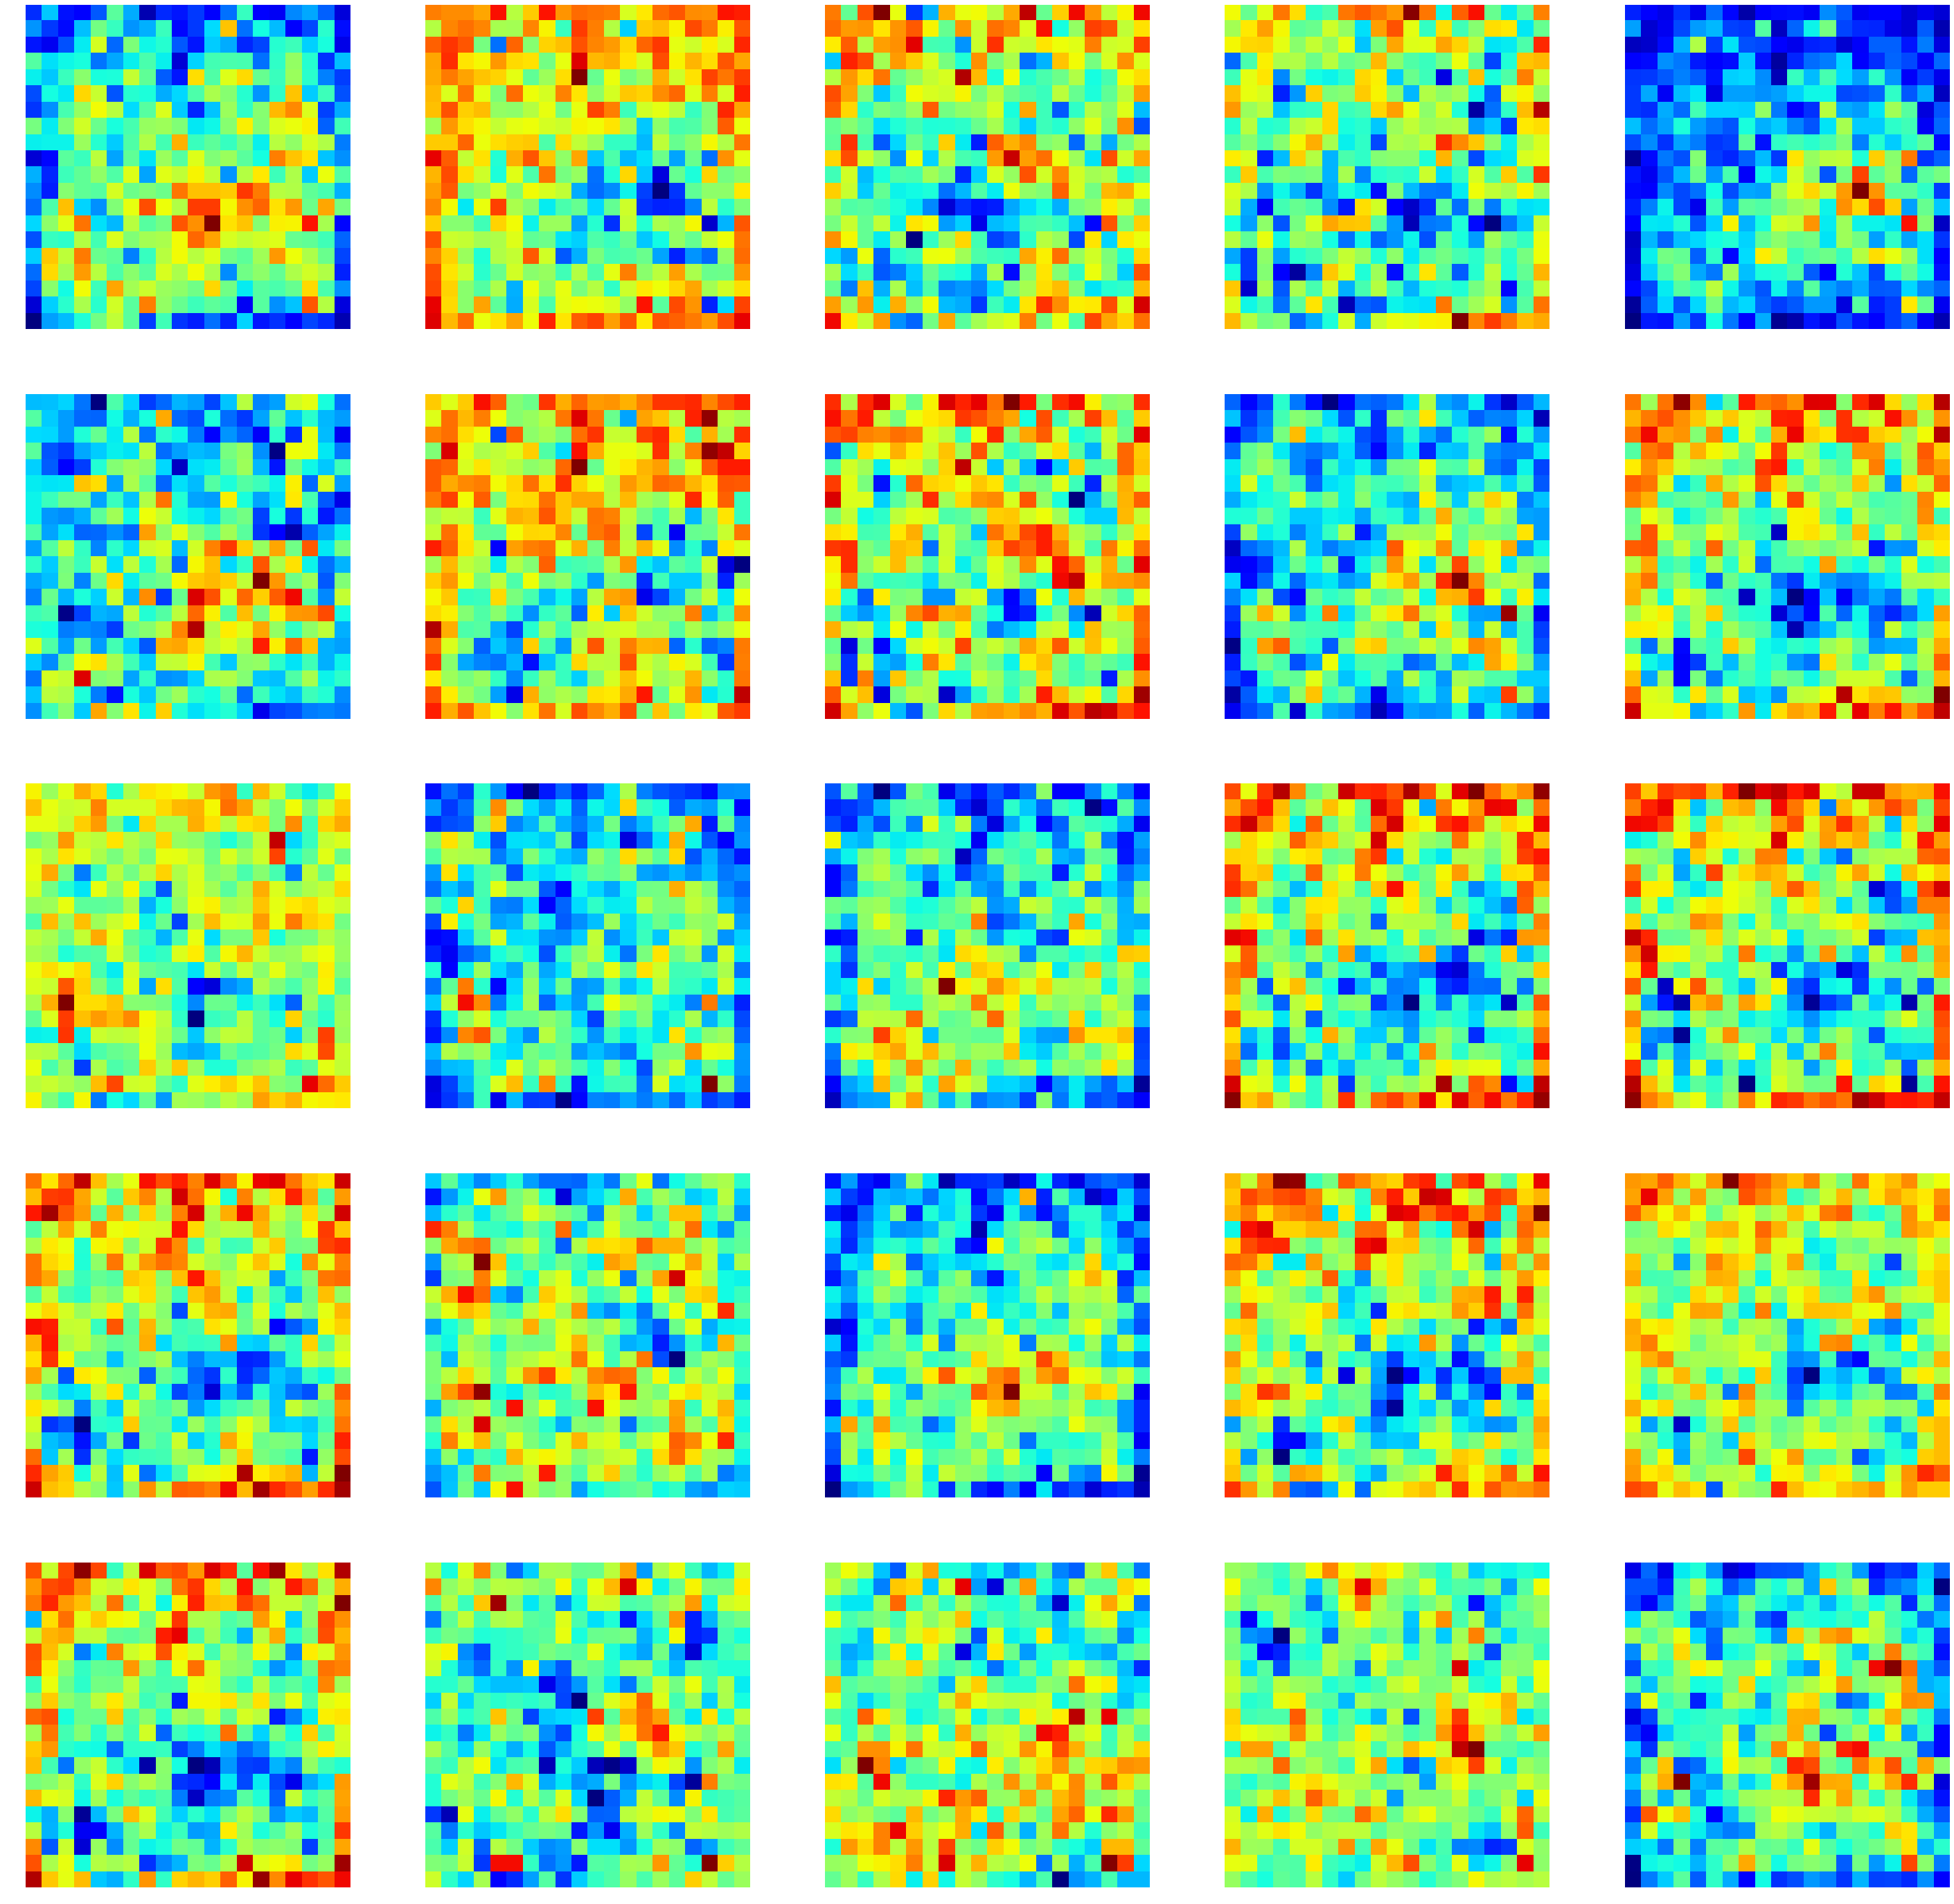

epoch 67, mean loss 7.932905410289765, std loss 0.05282381066450802


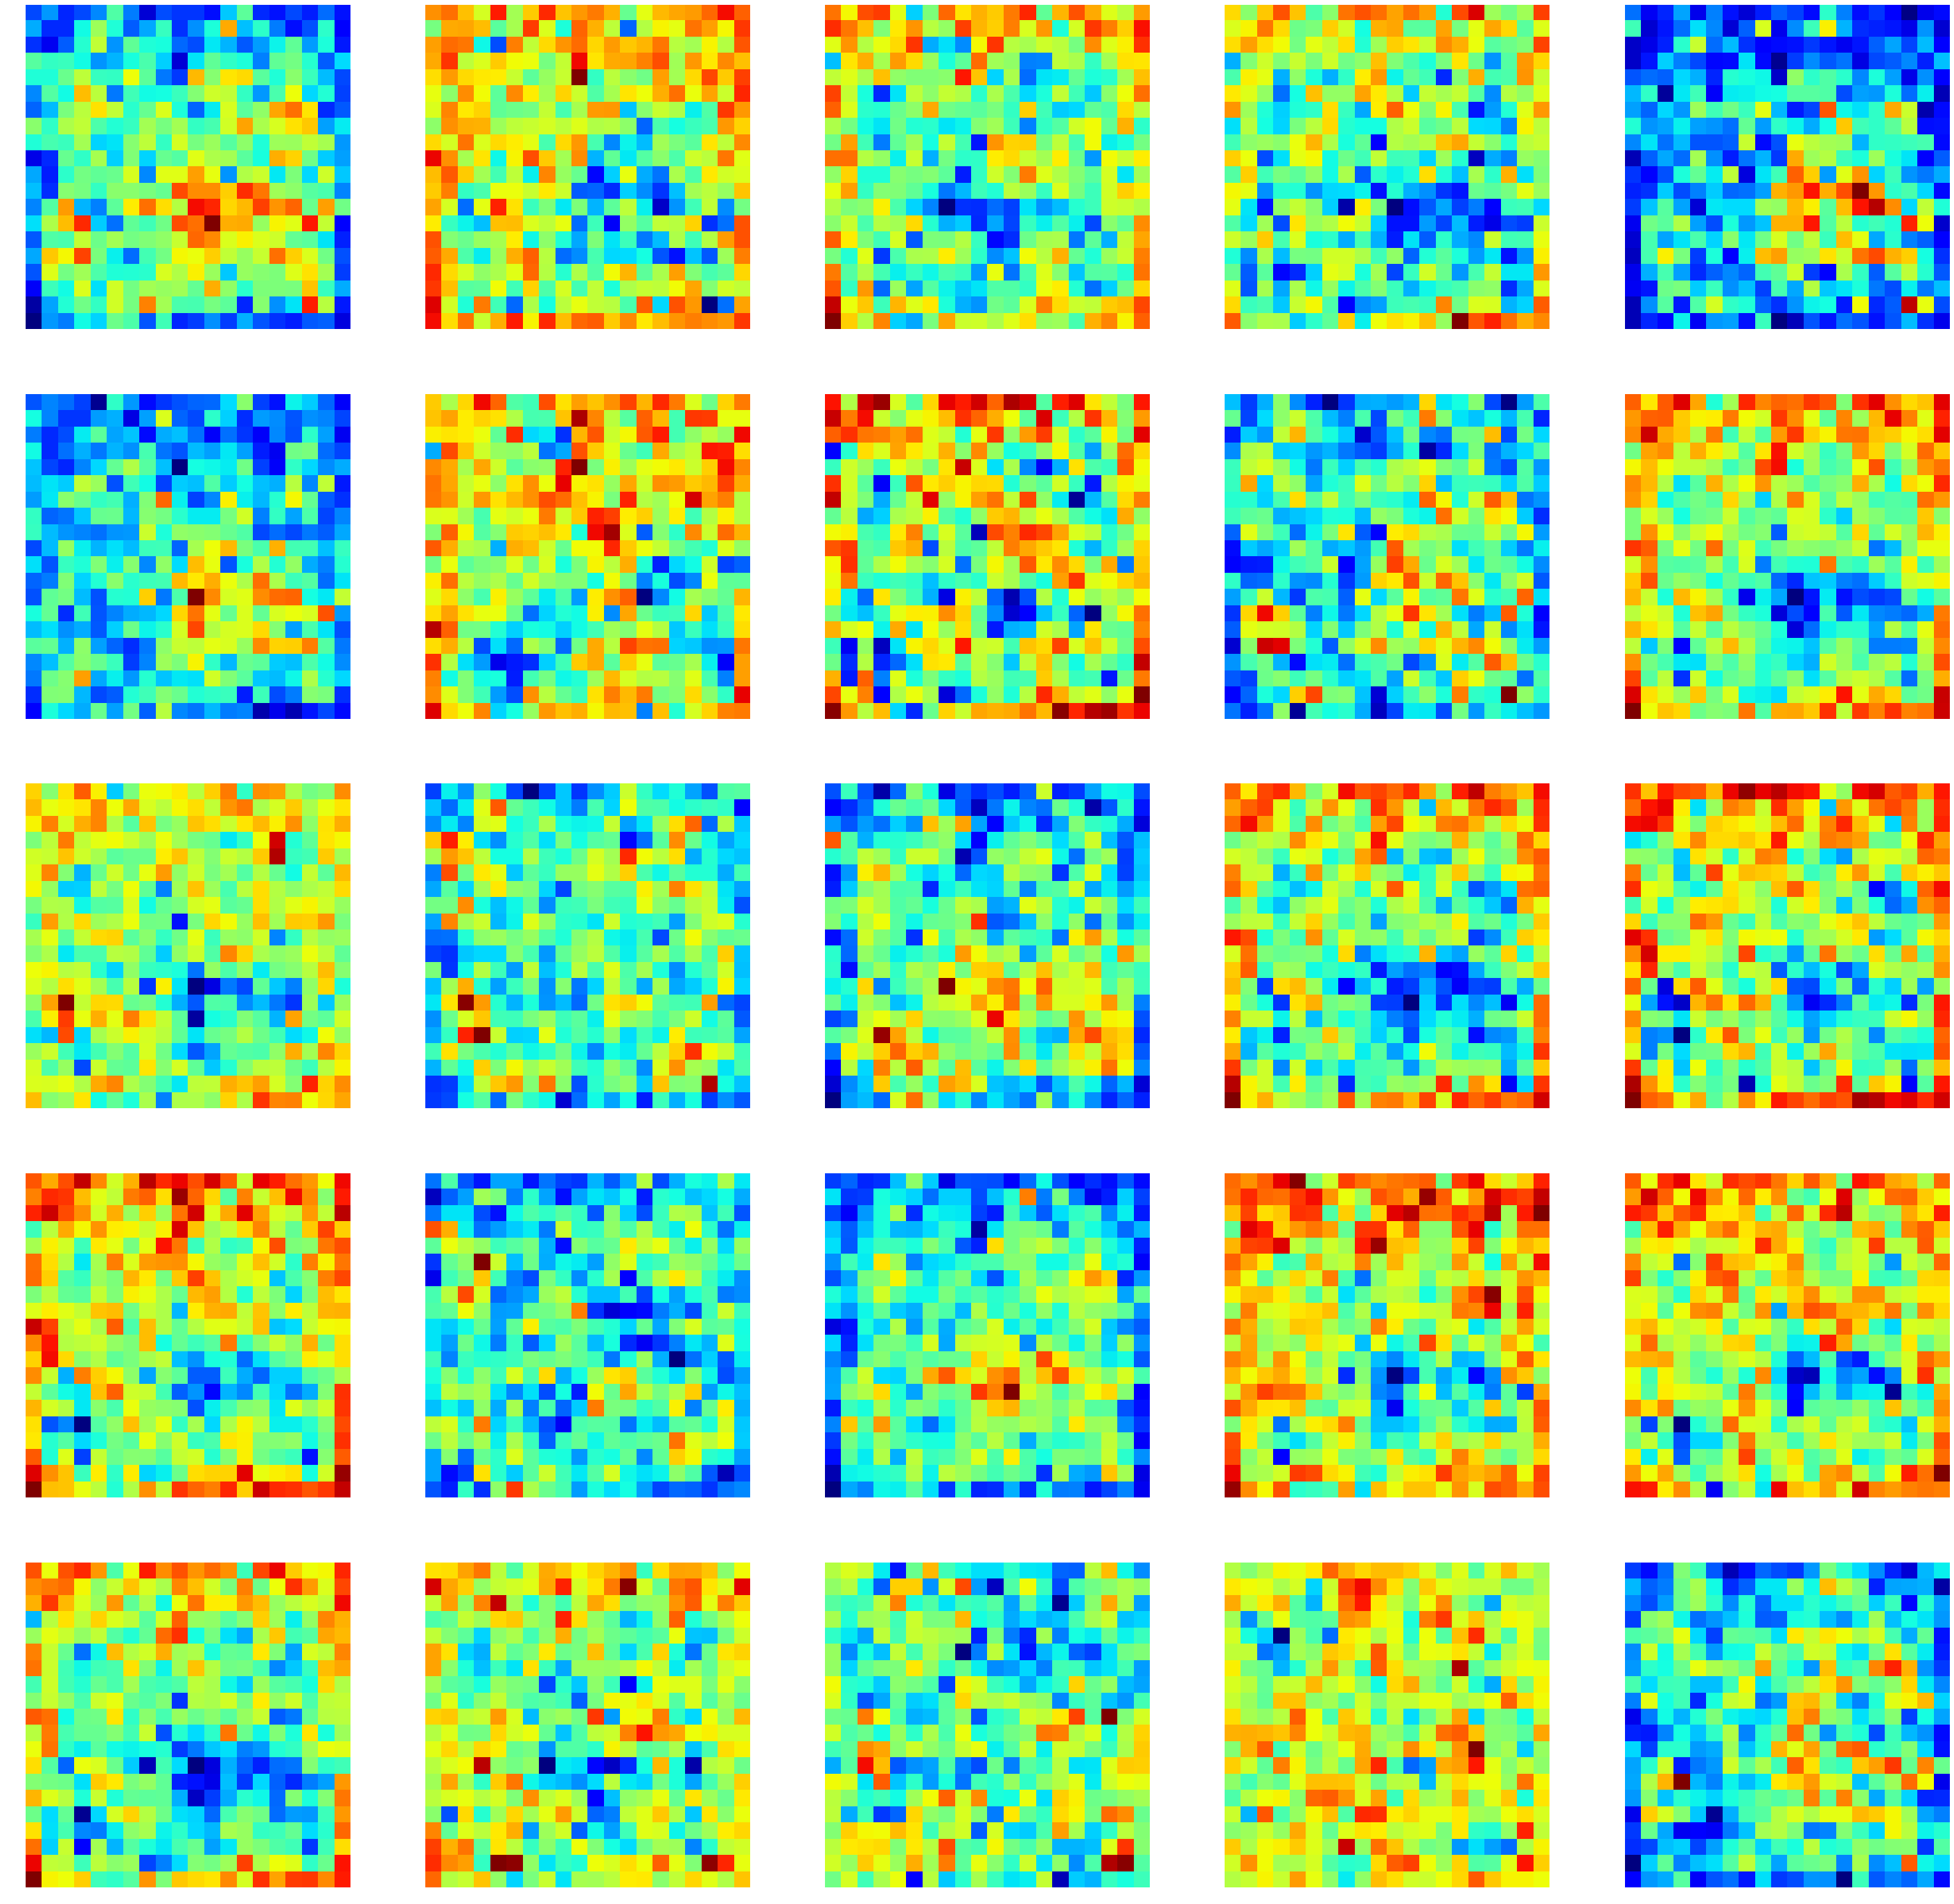

epoch 68, mean loss 7.933045922279358, std loss 0.053034244086524136


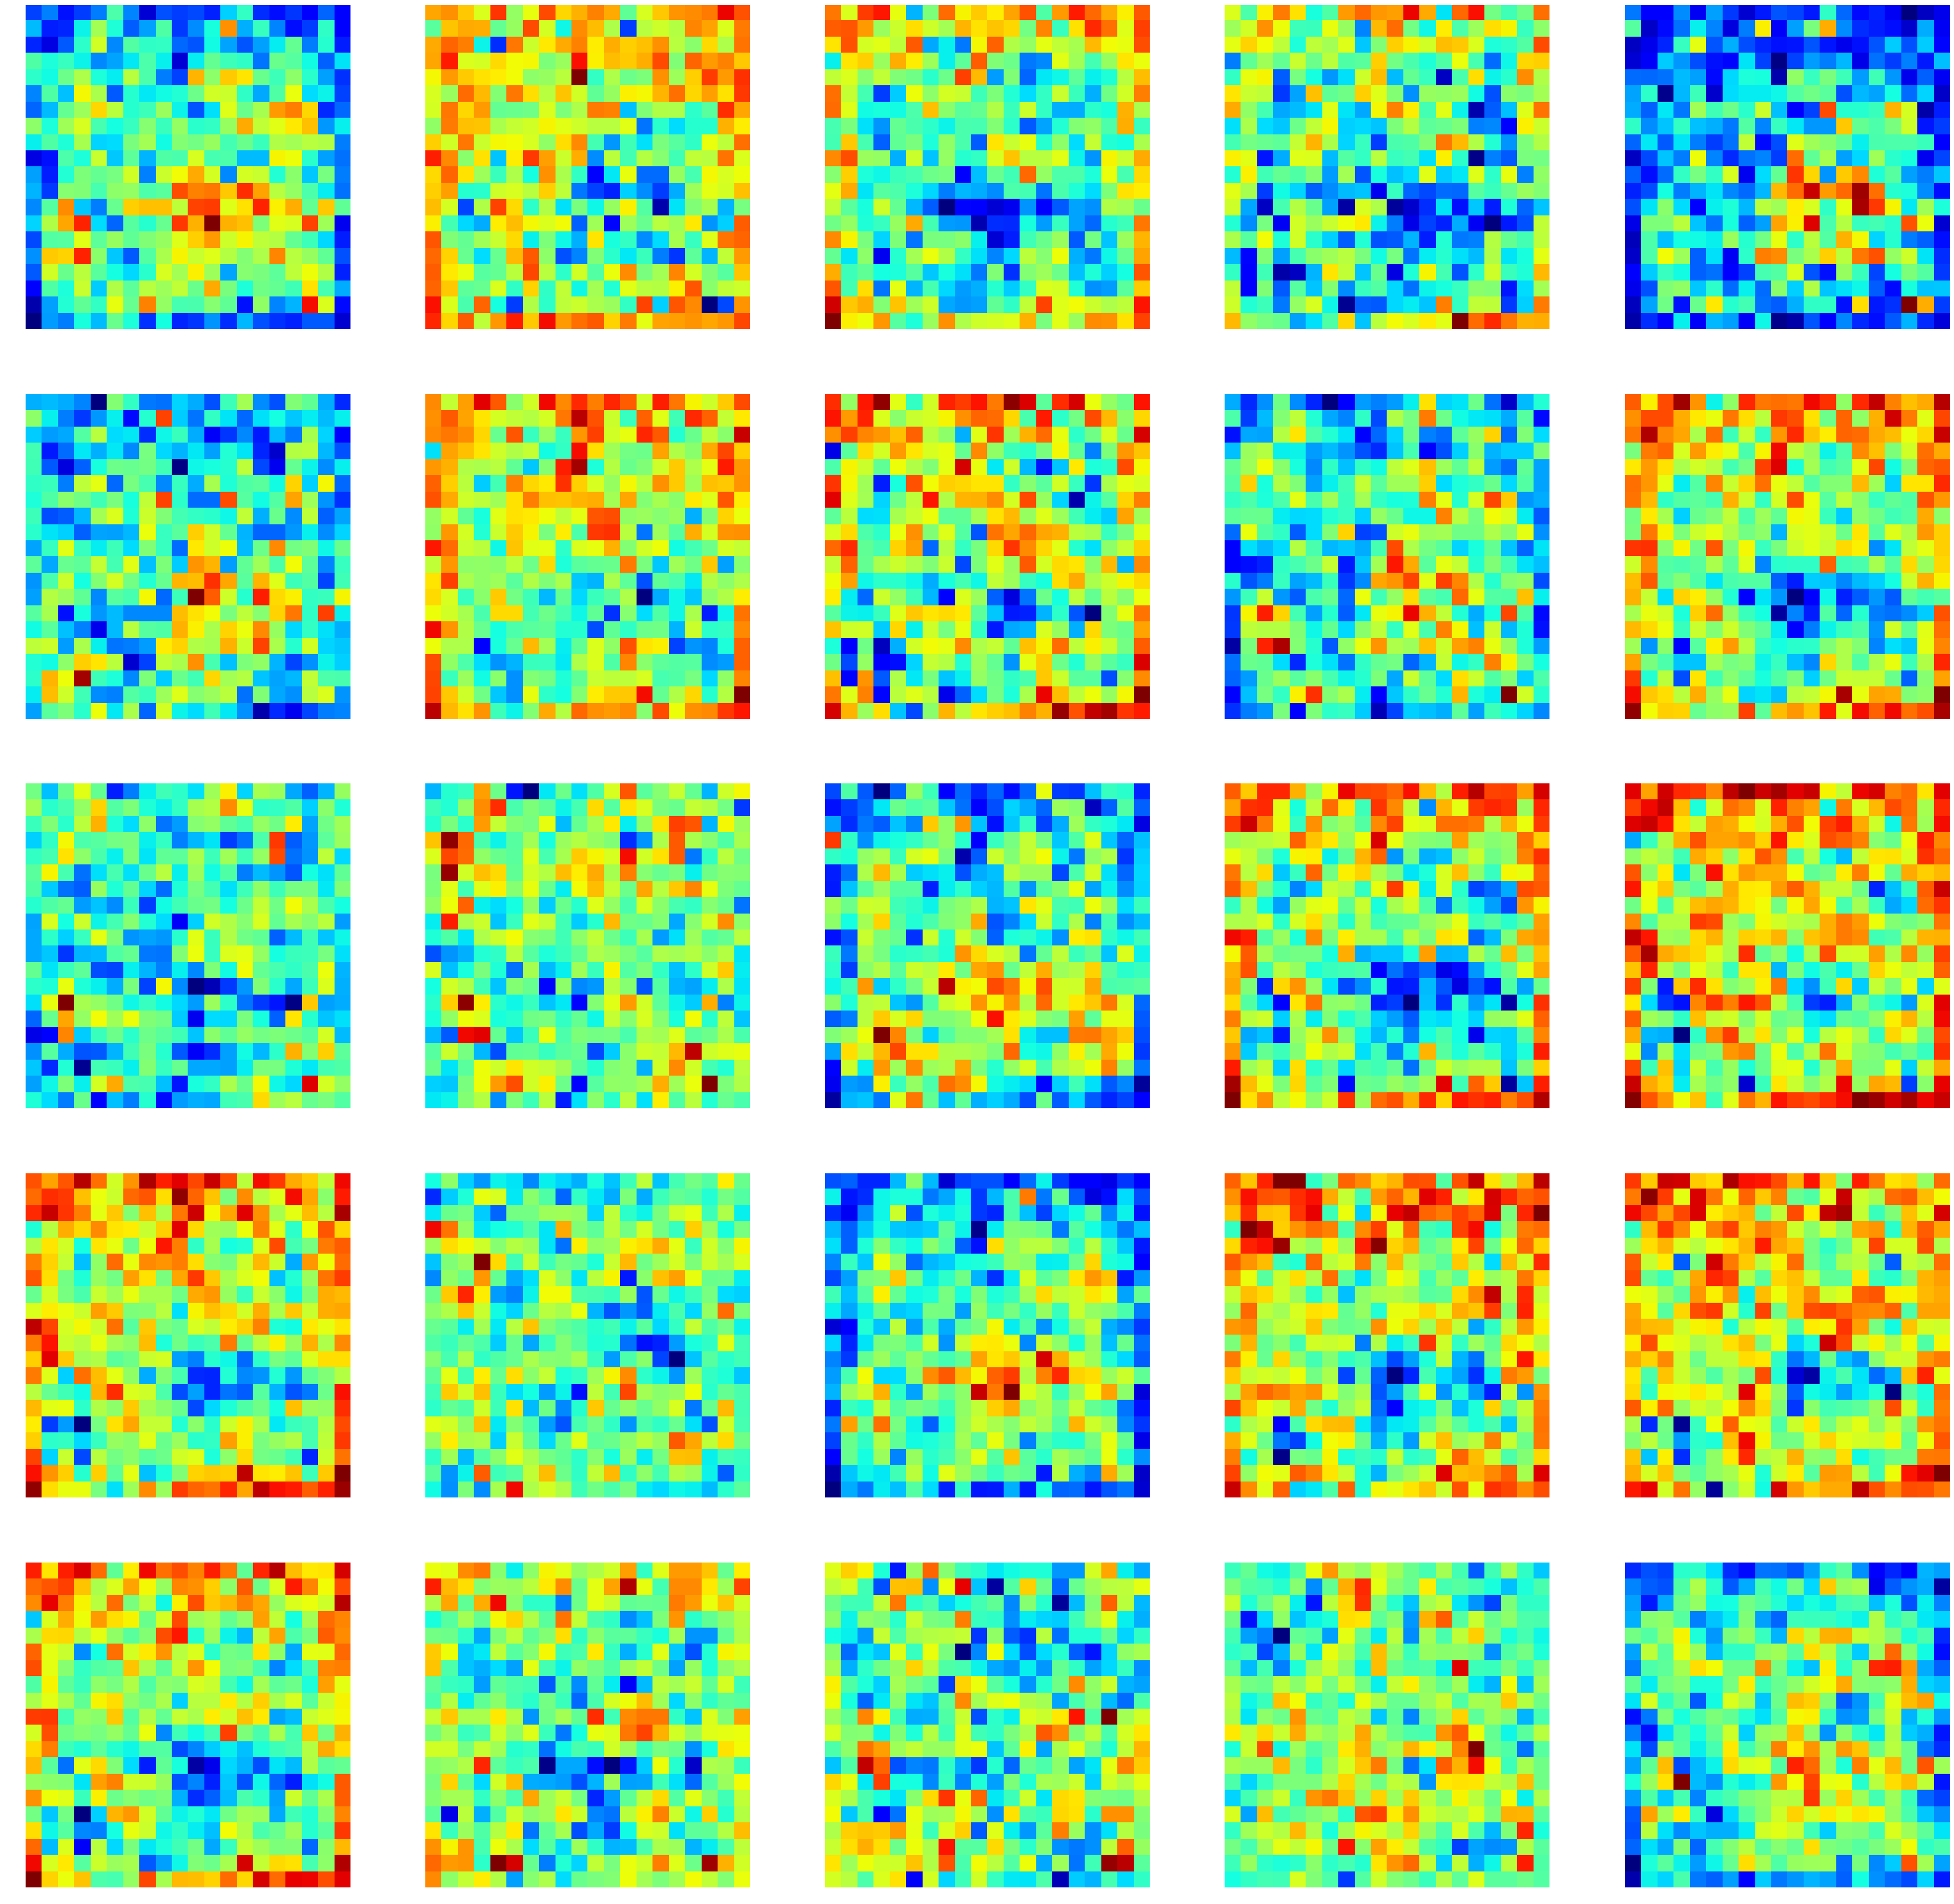

epoch 69, mean loss 7.9328425288200375, std loss 0.05315964604626007


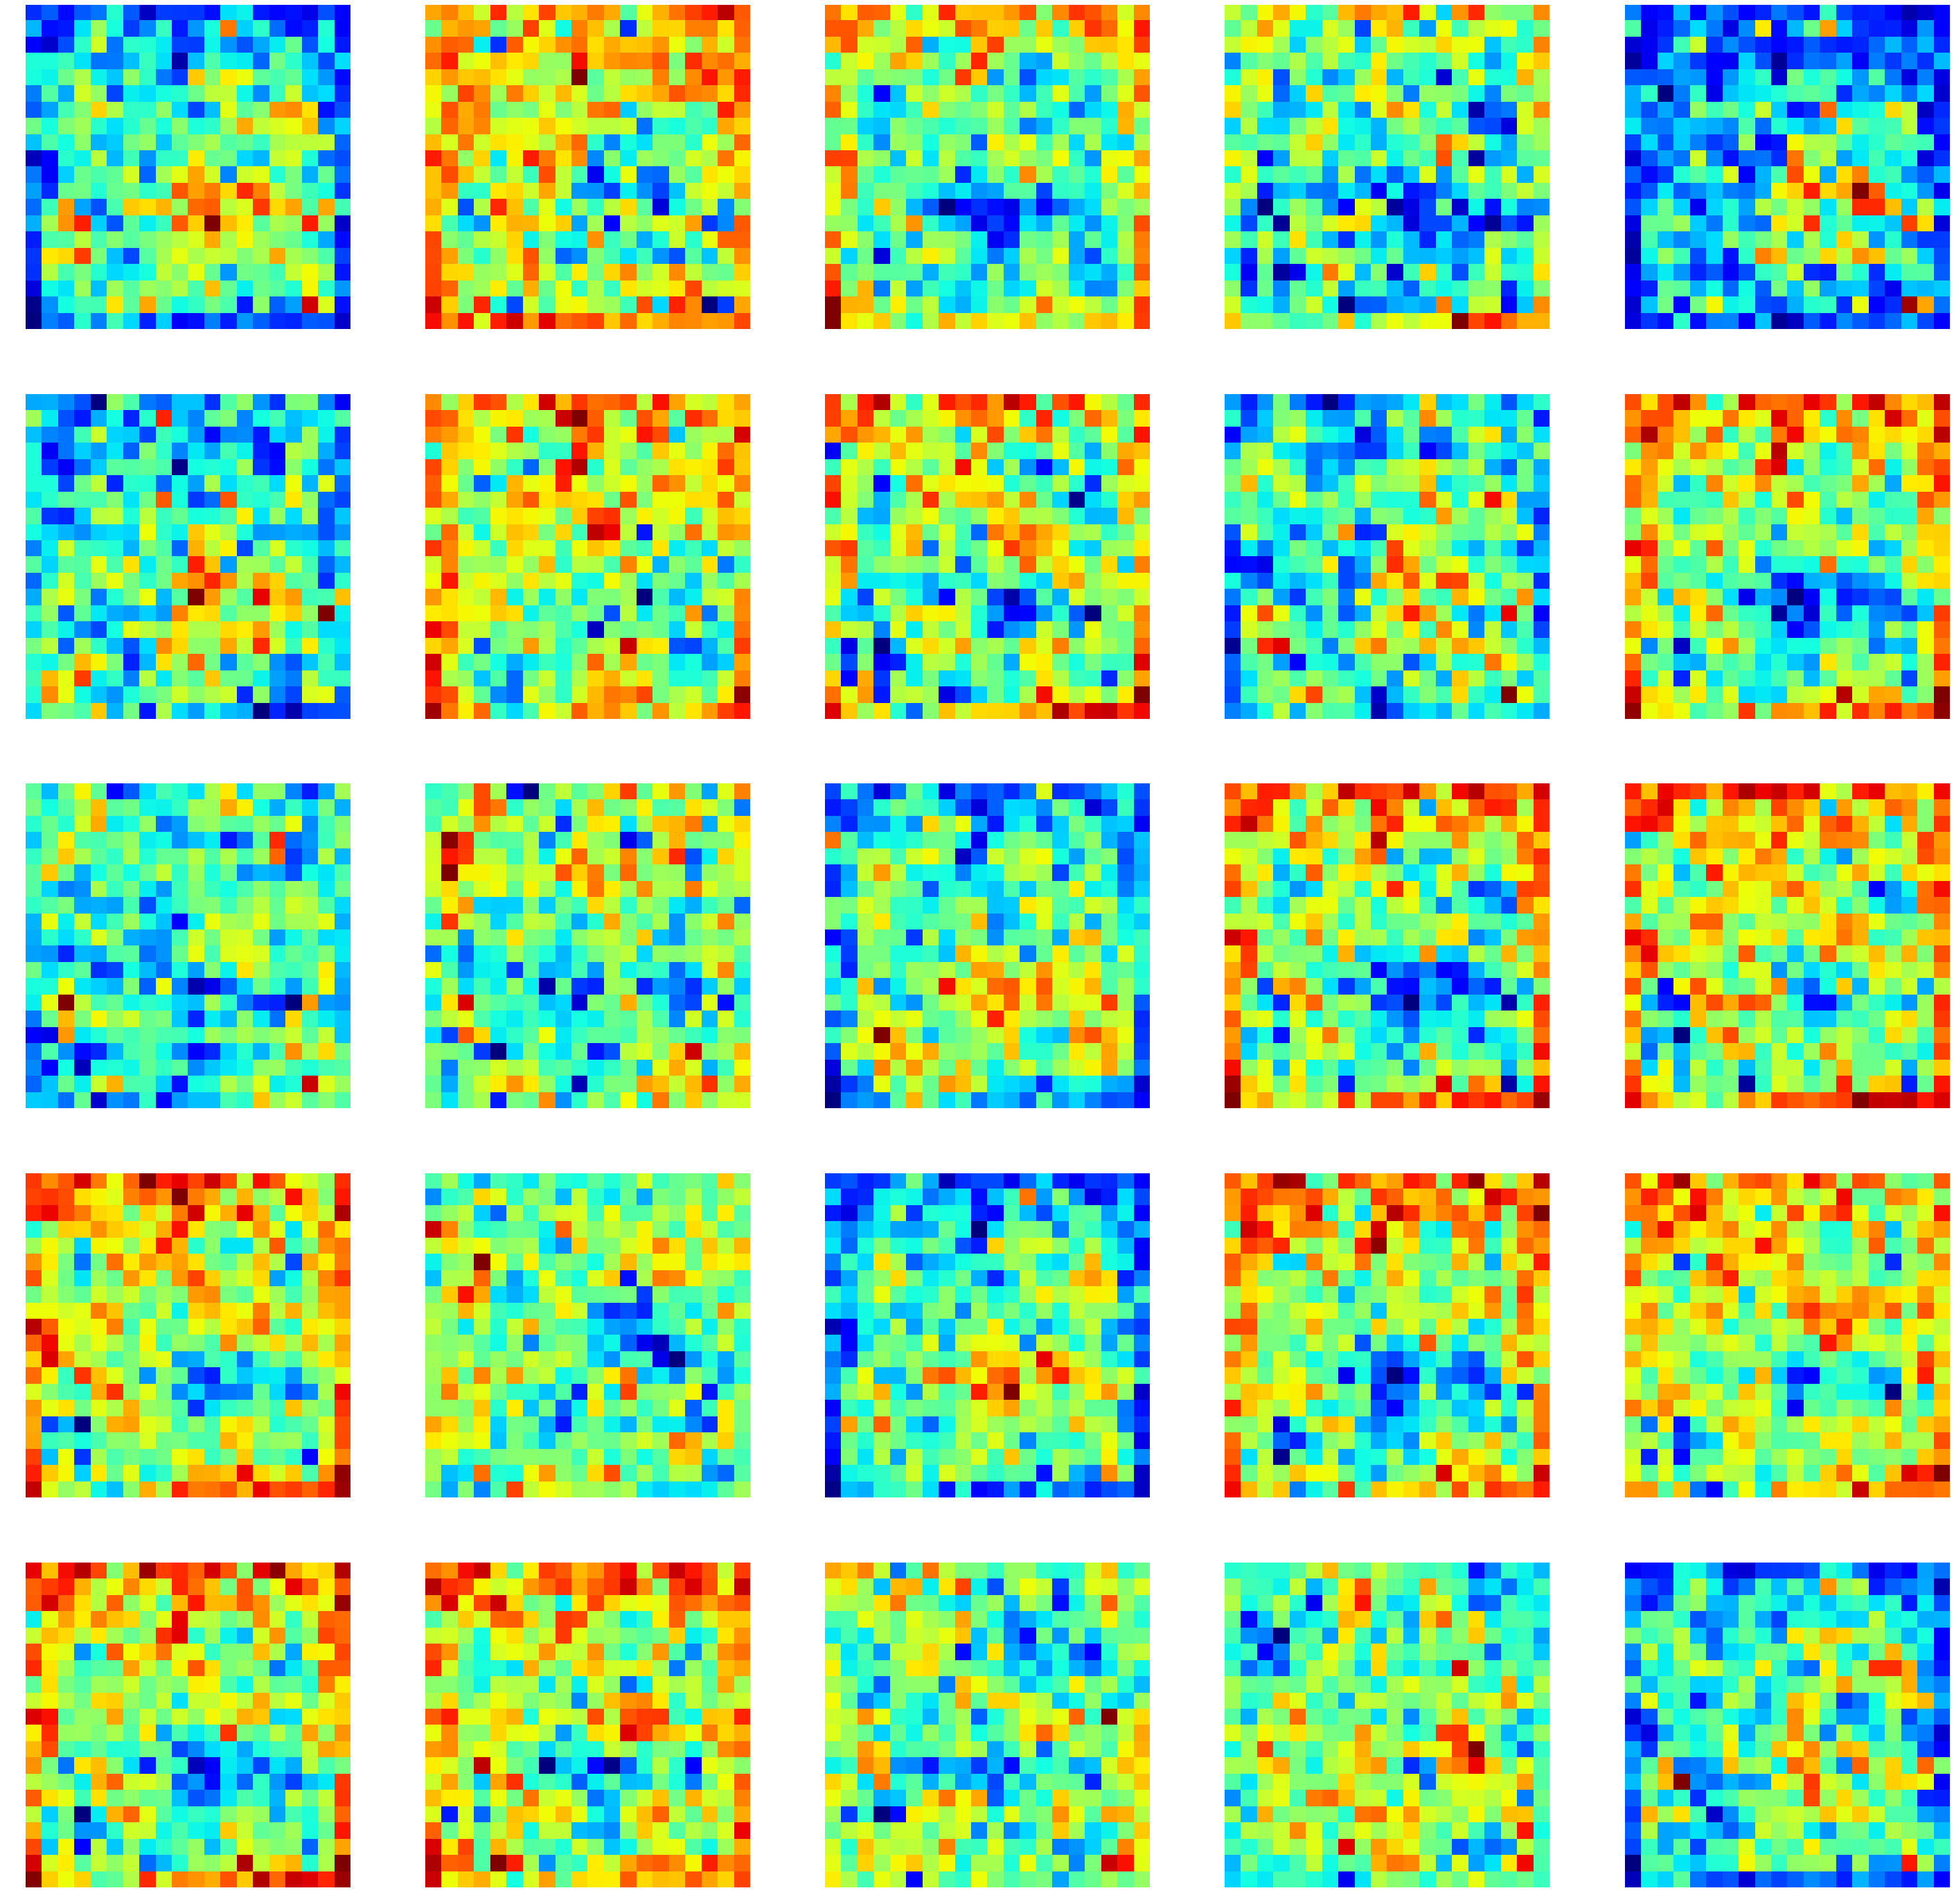

epoch 70, mean loss 7.932509332656861, std loss 0.05269971824399379


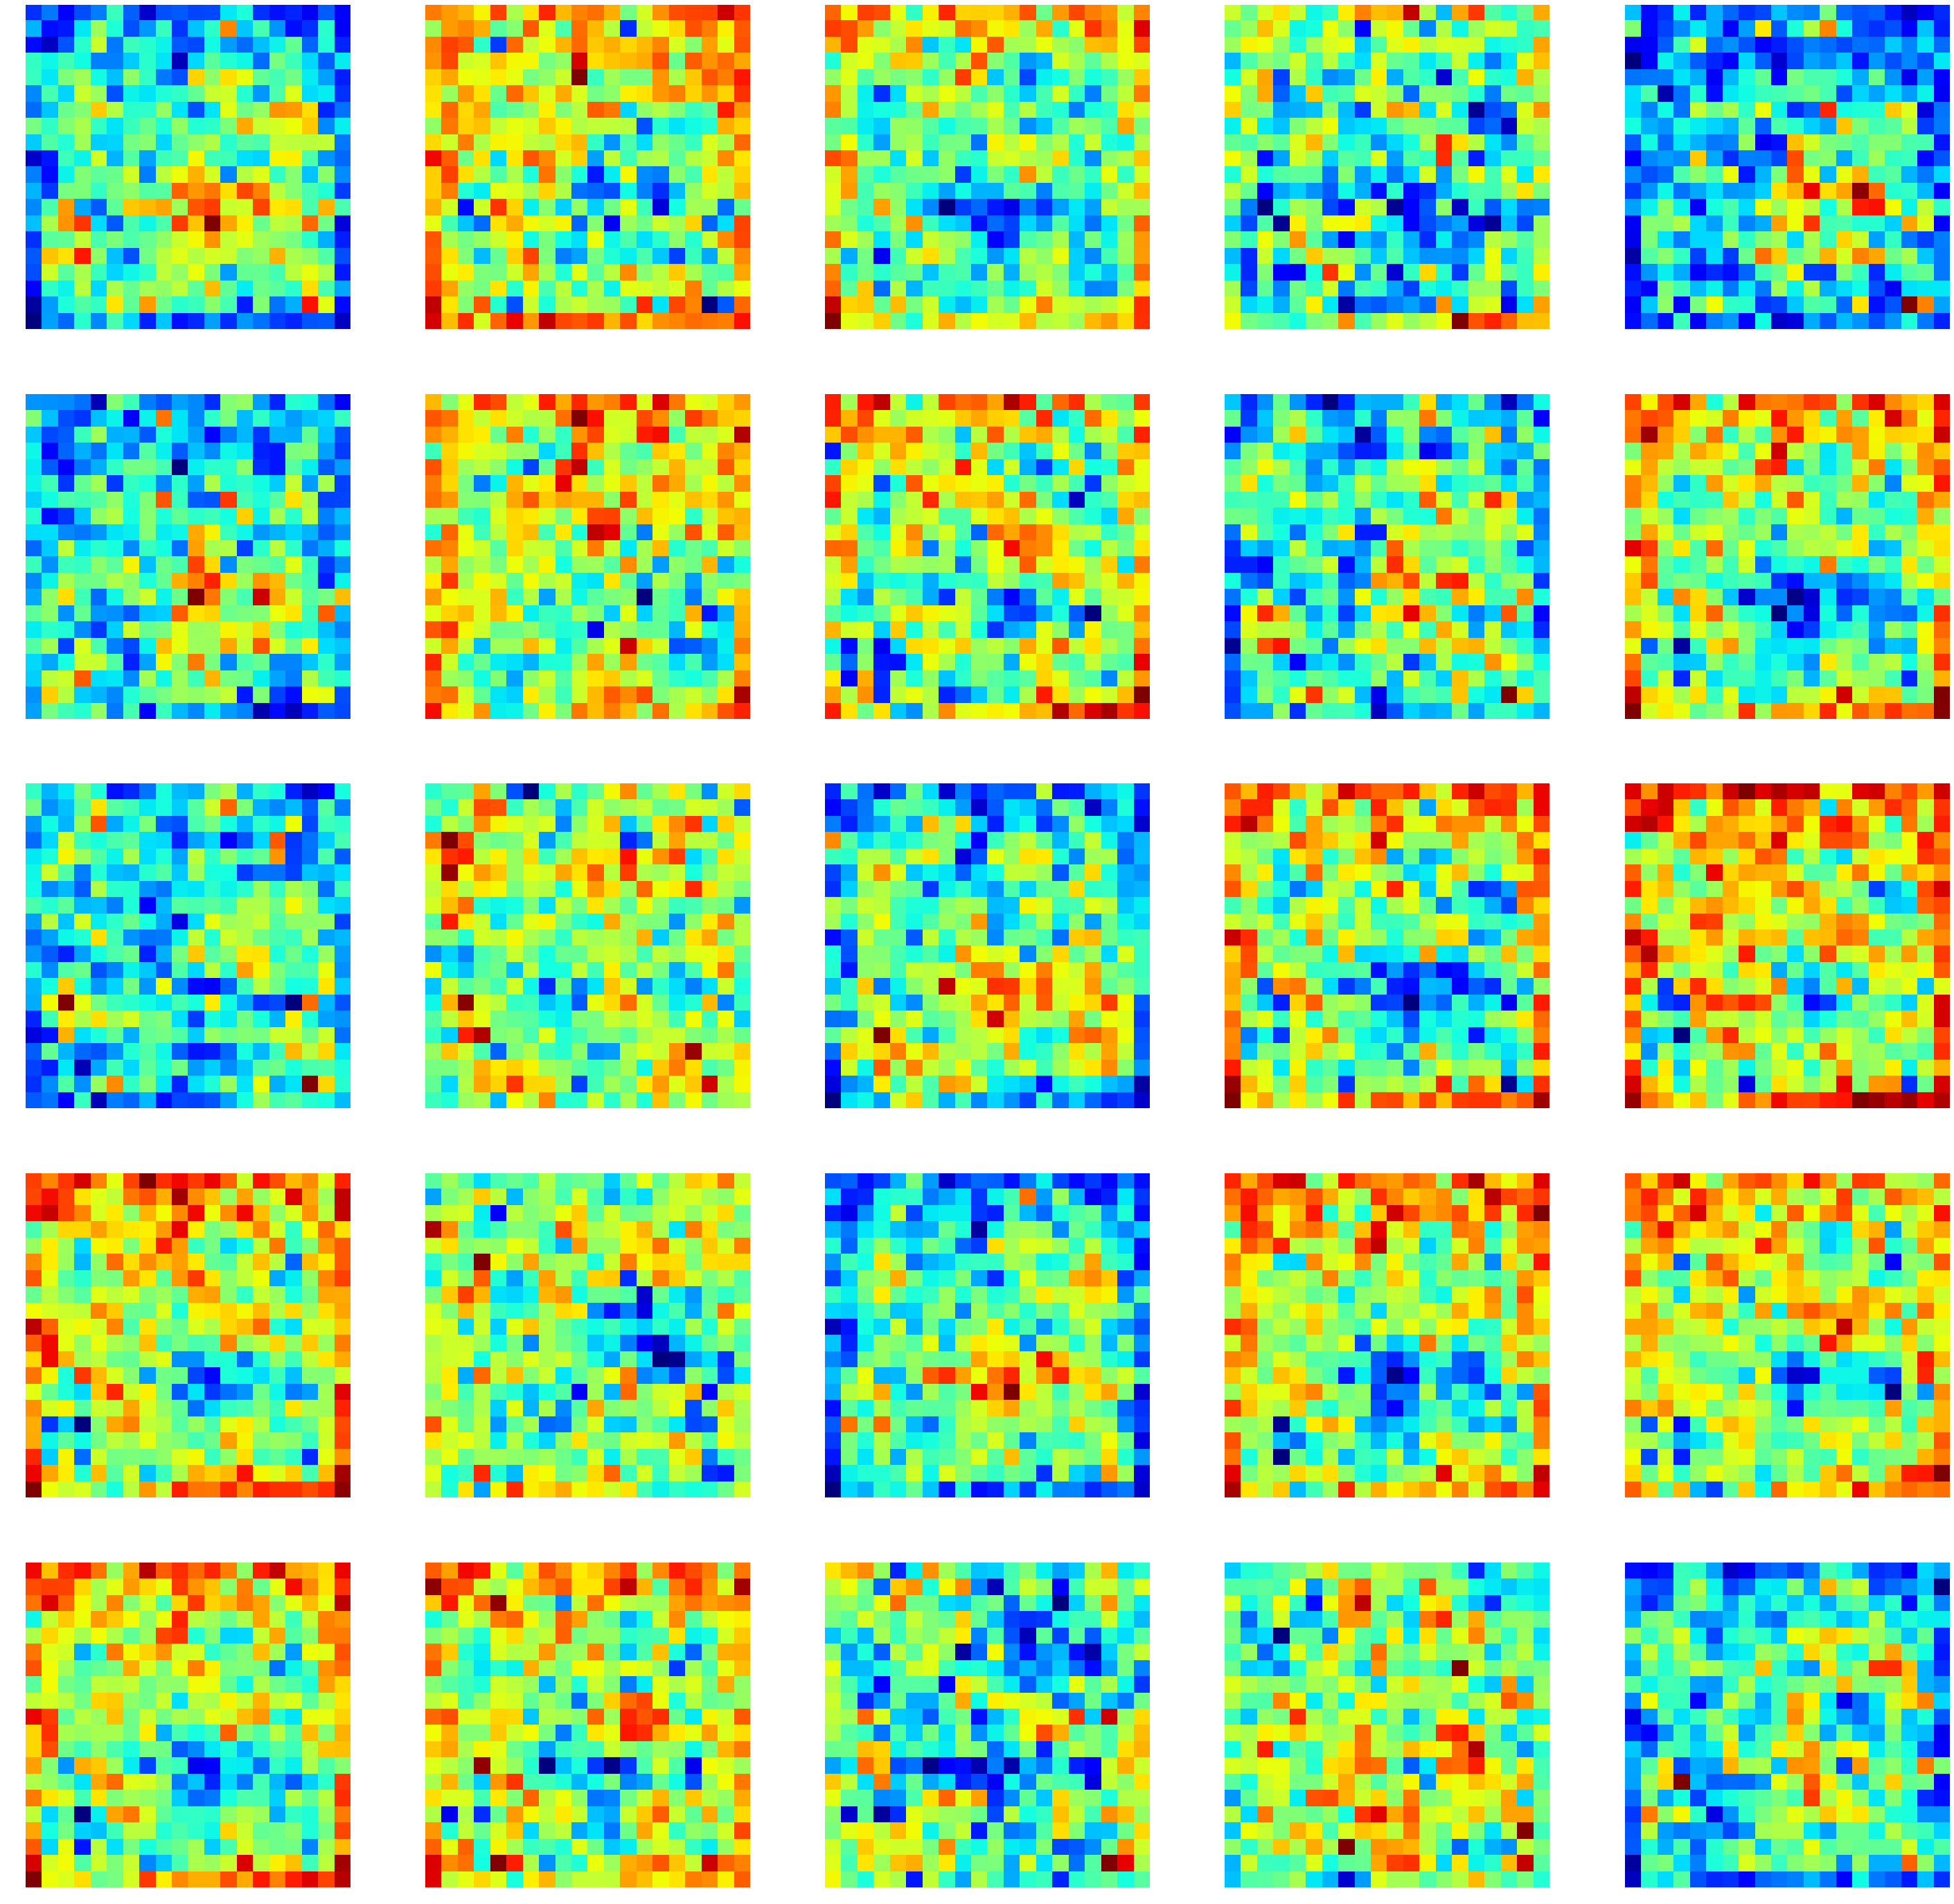

epoch 71, mean loss 7.931900916099548, std loss 0.053533879560559786


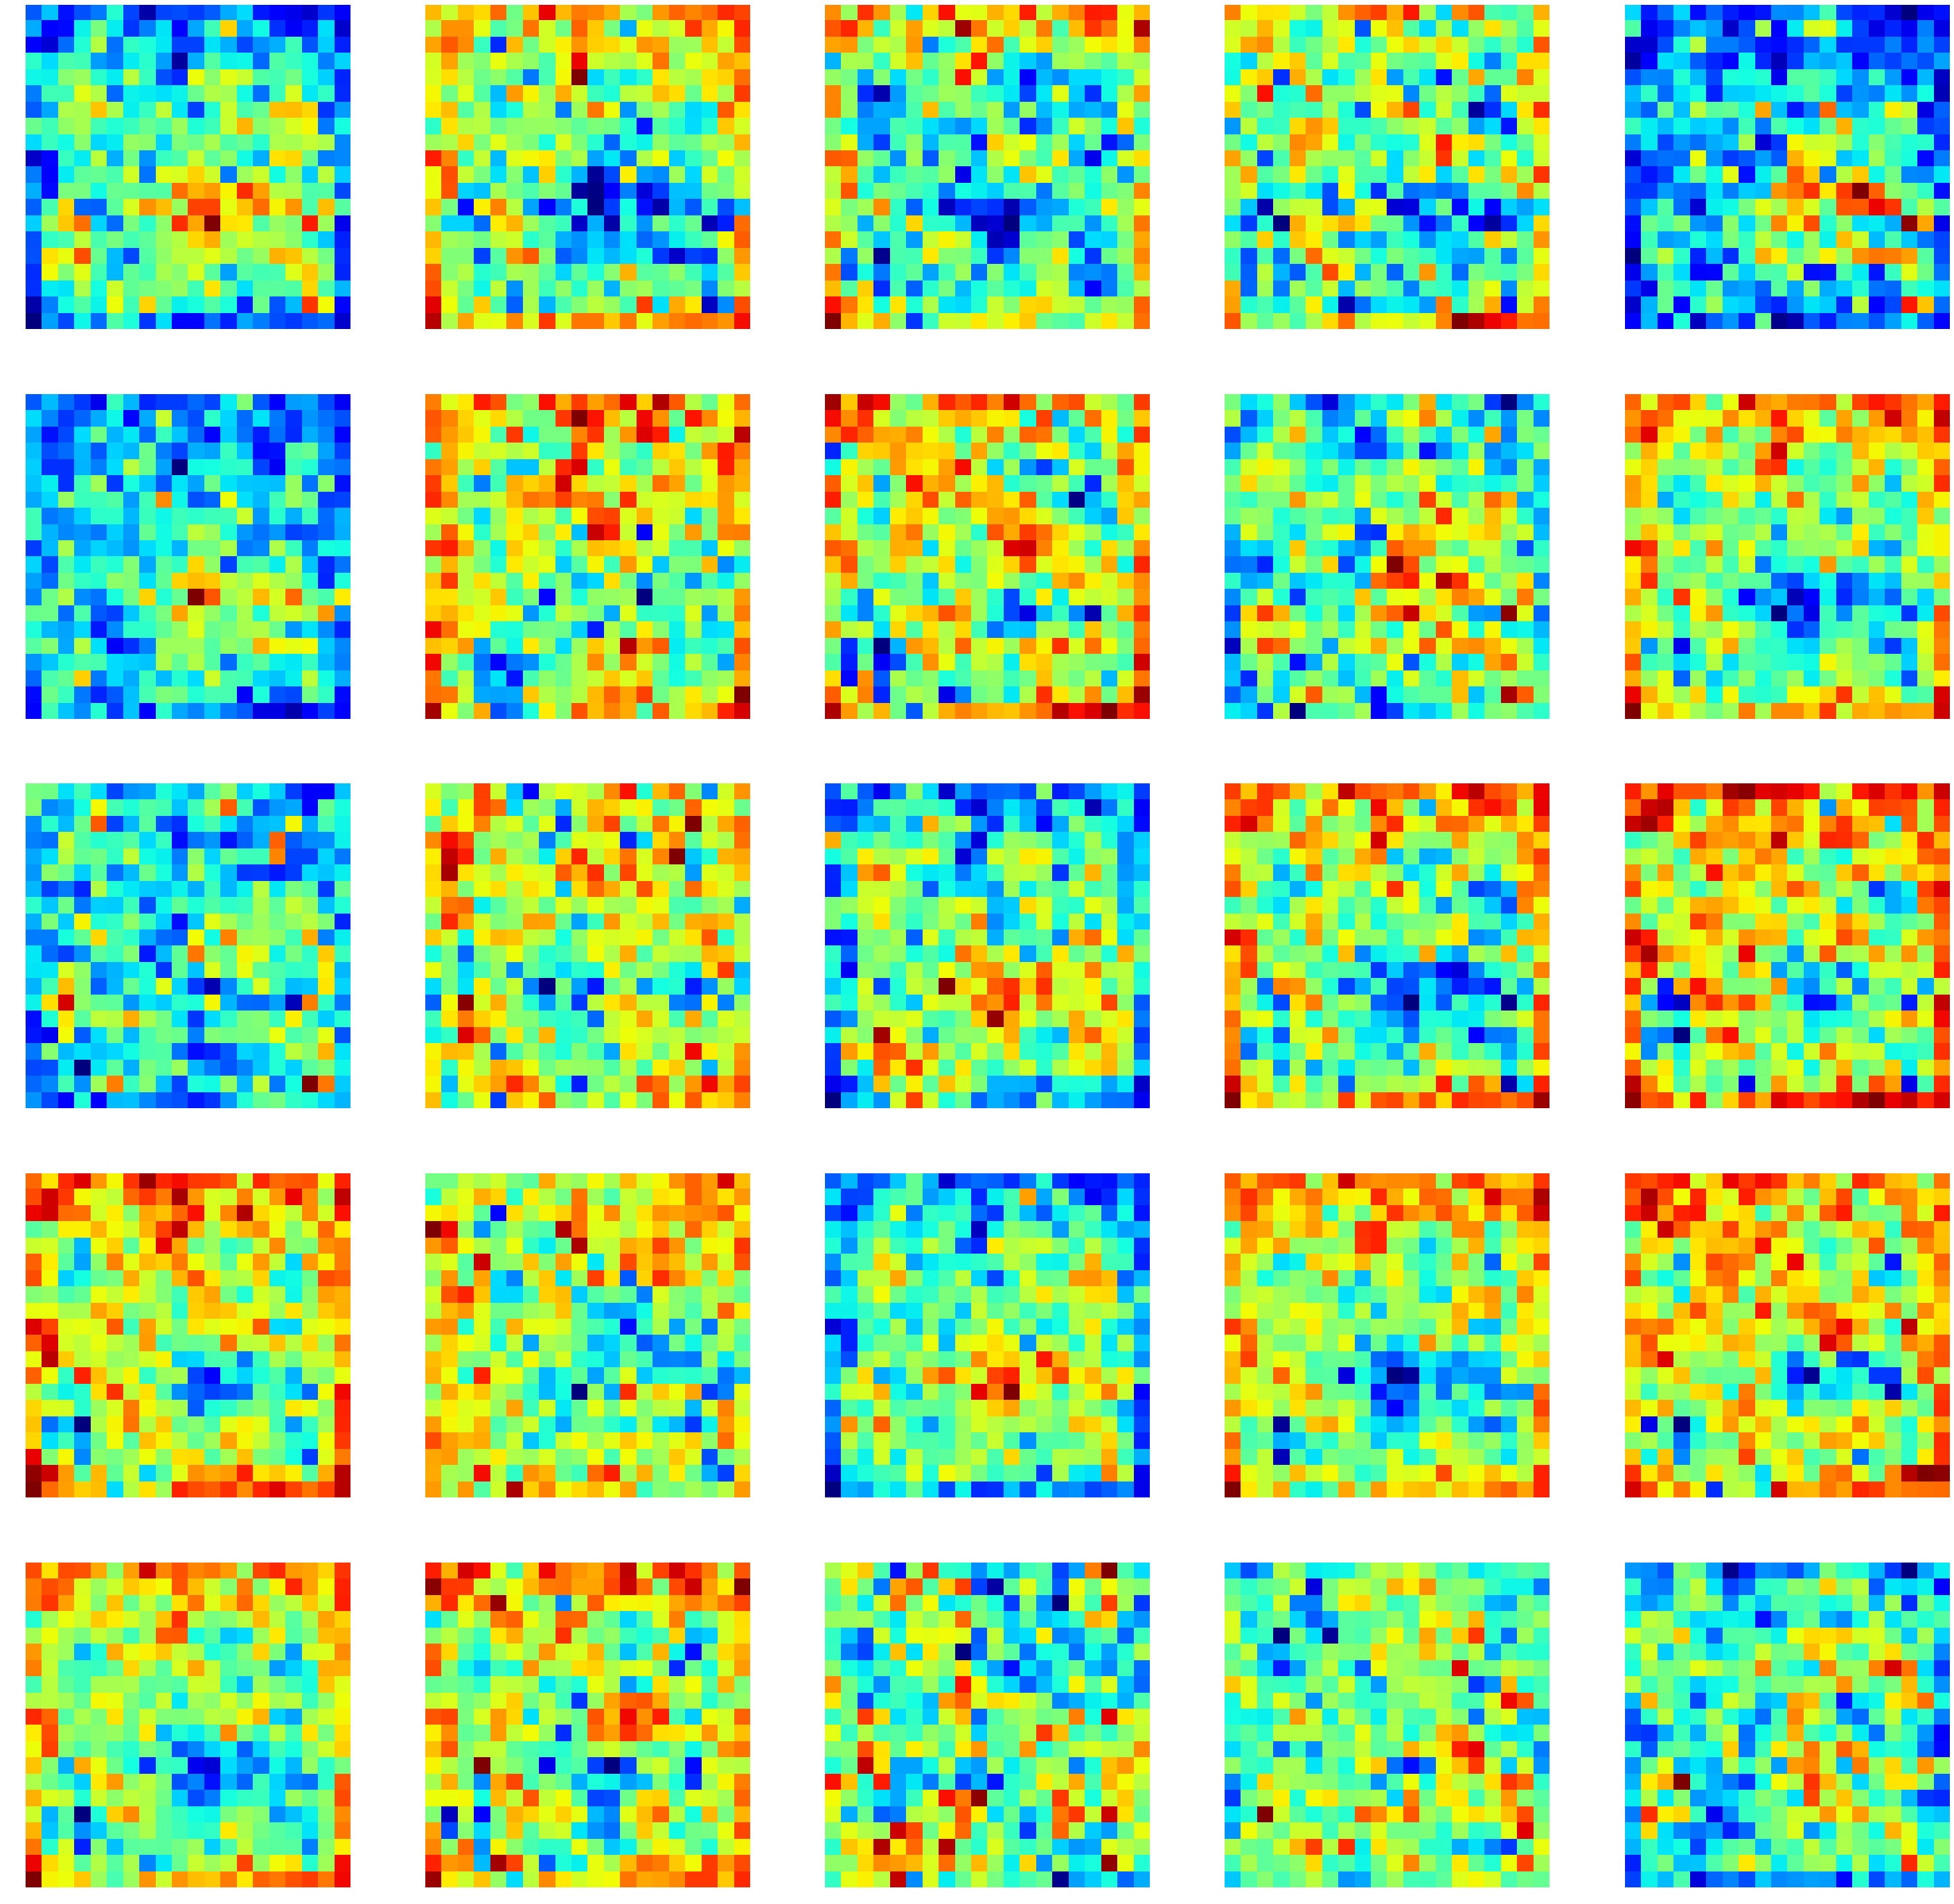

epoch 72, mean loss 7.931666516304016, std loss 0.053442154805959555


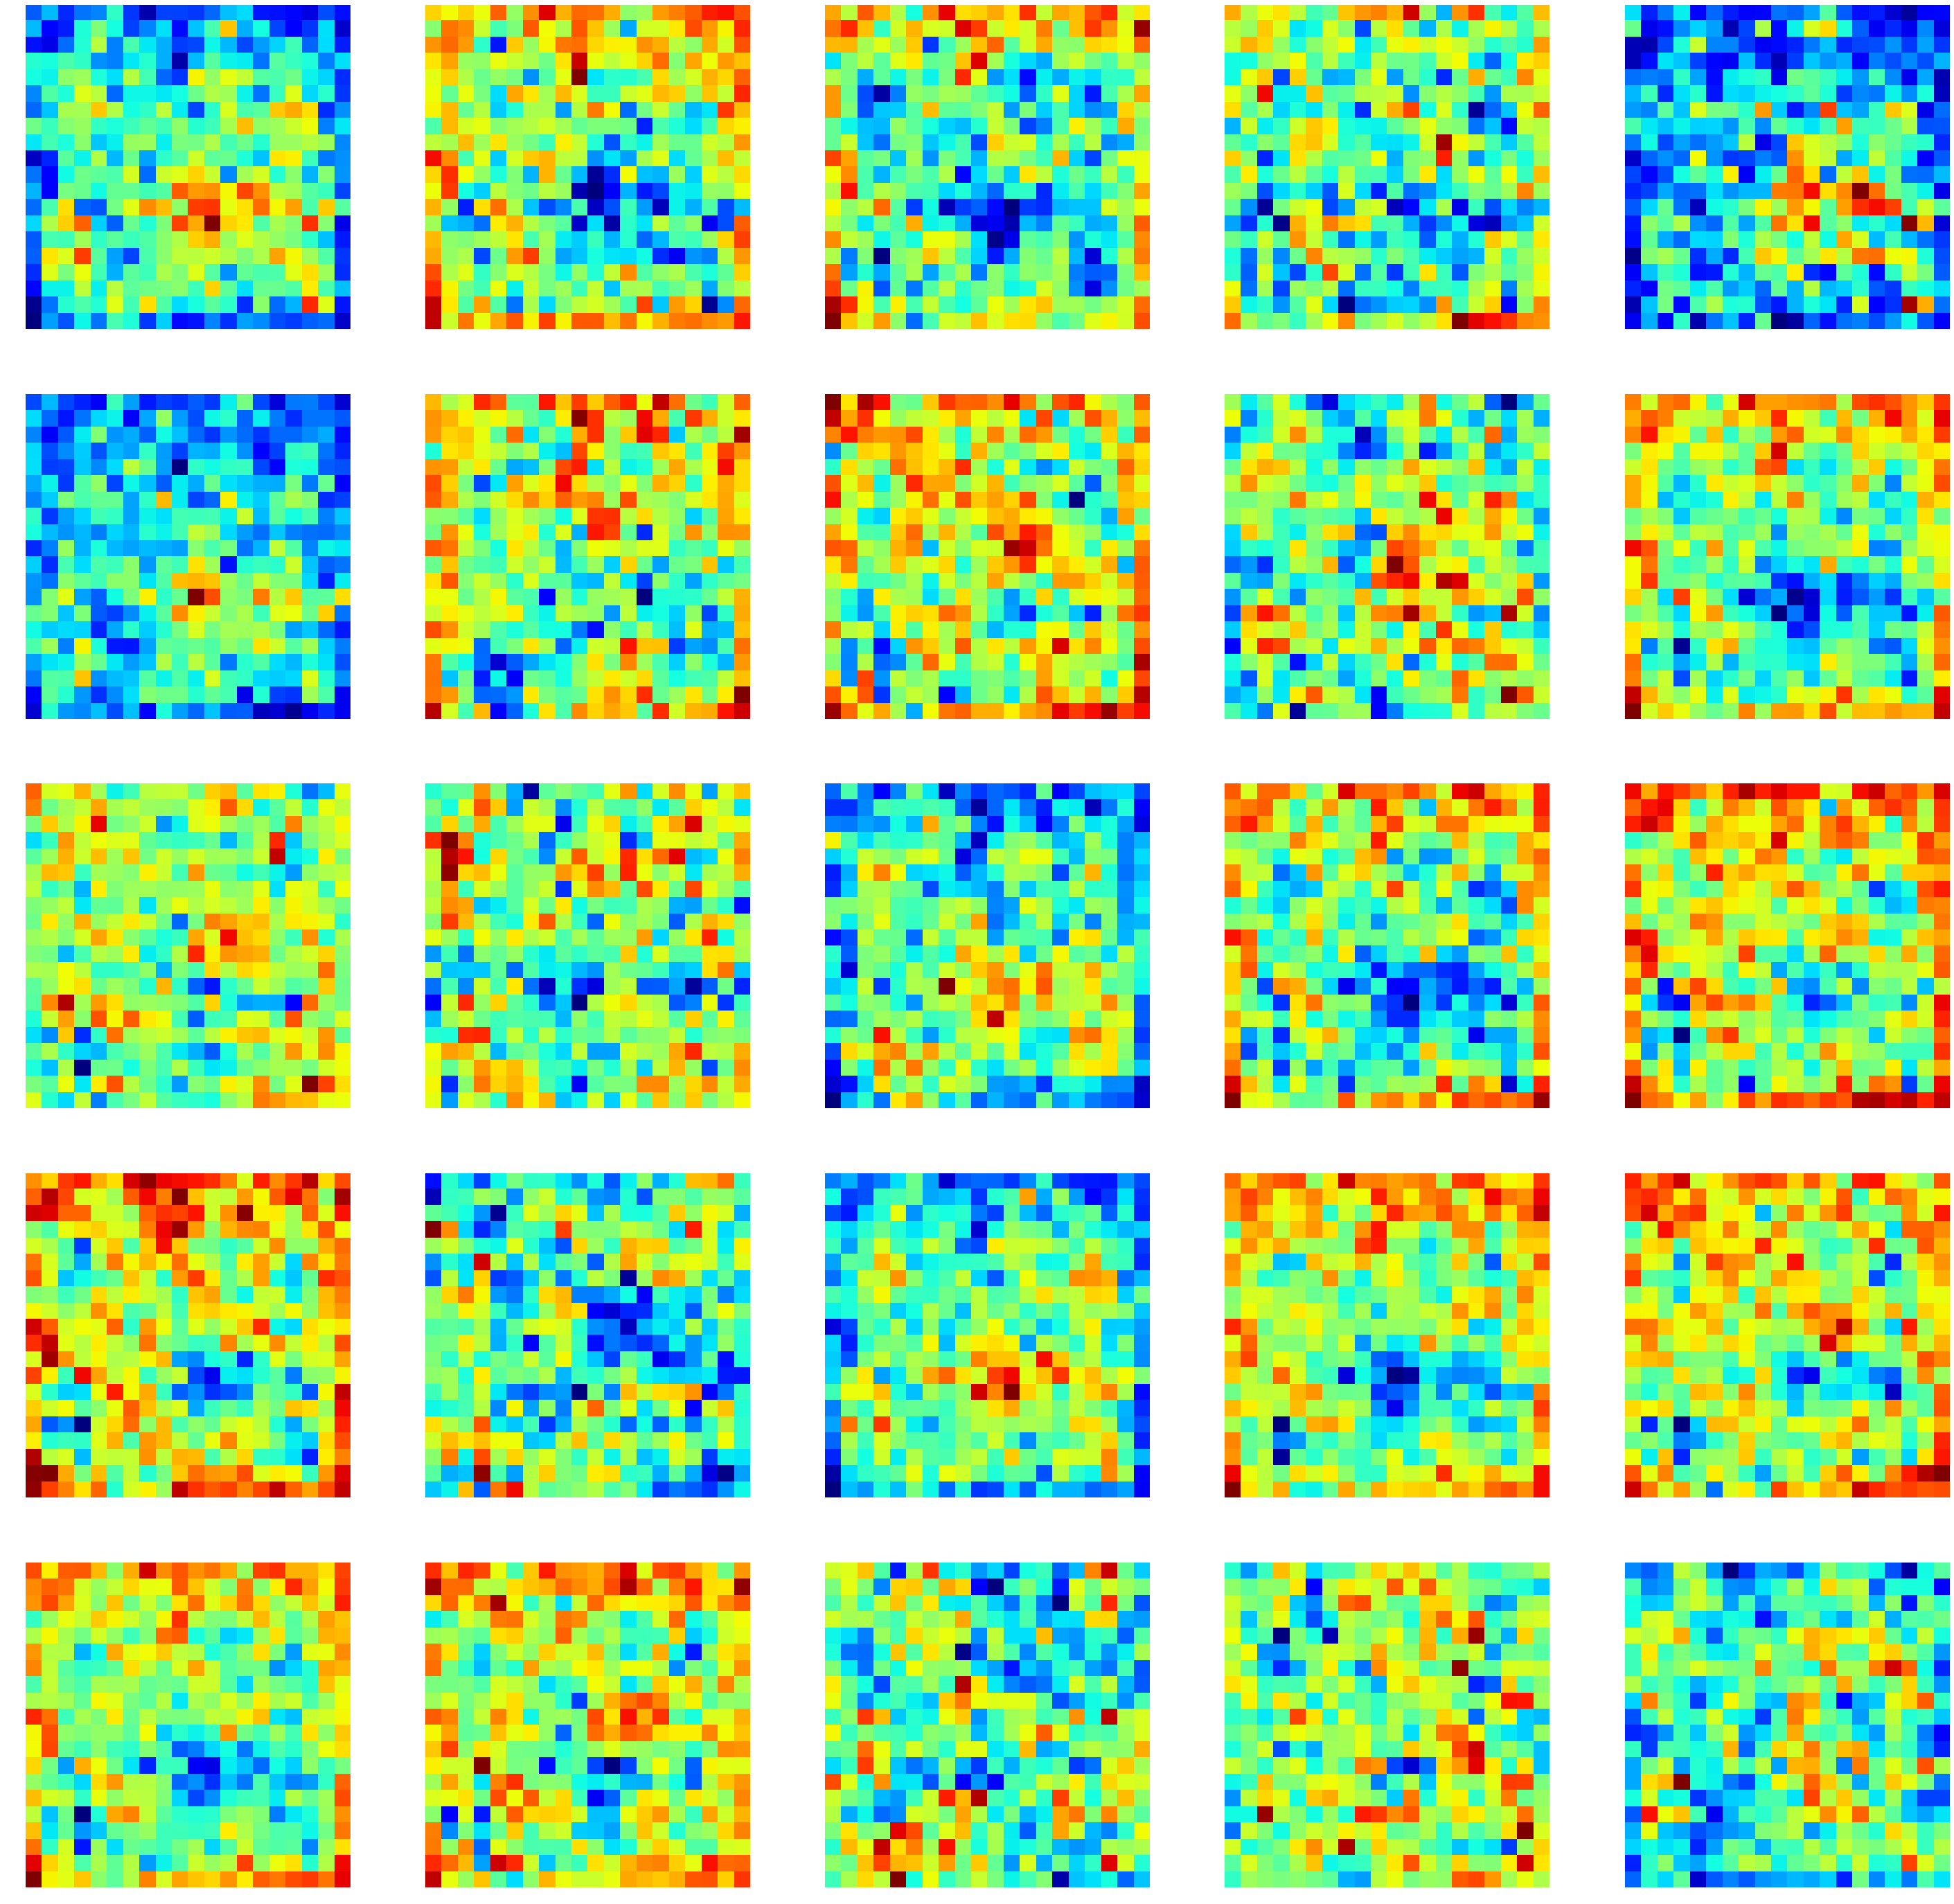

epoch 73, mean loss 7.931581477165222, std loss 0.05340819475395188


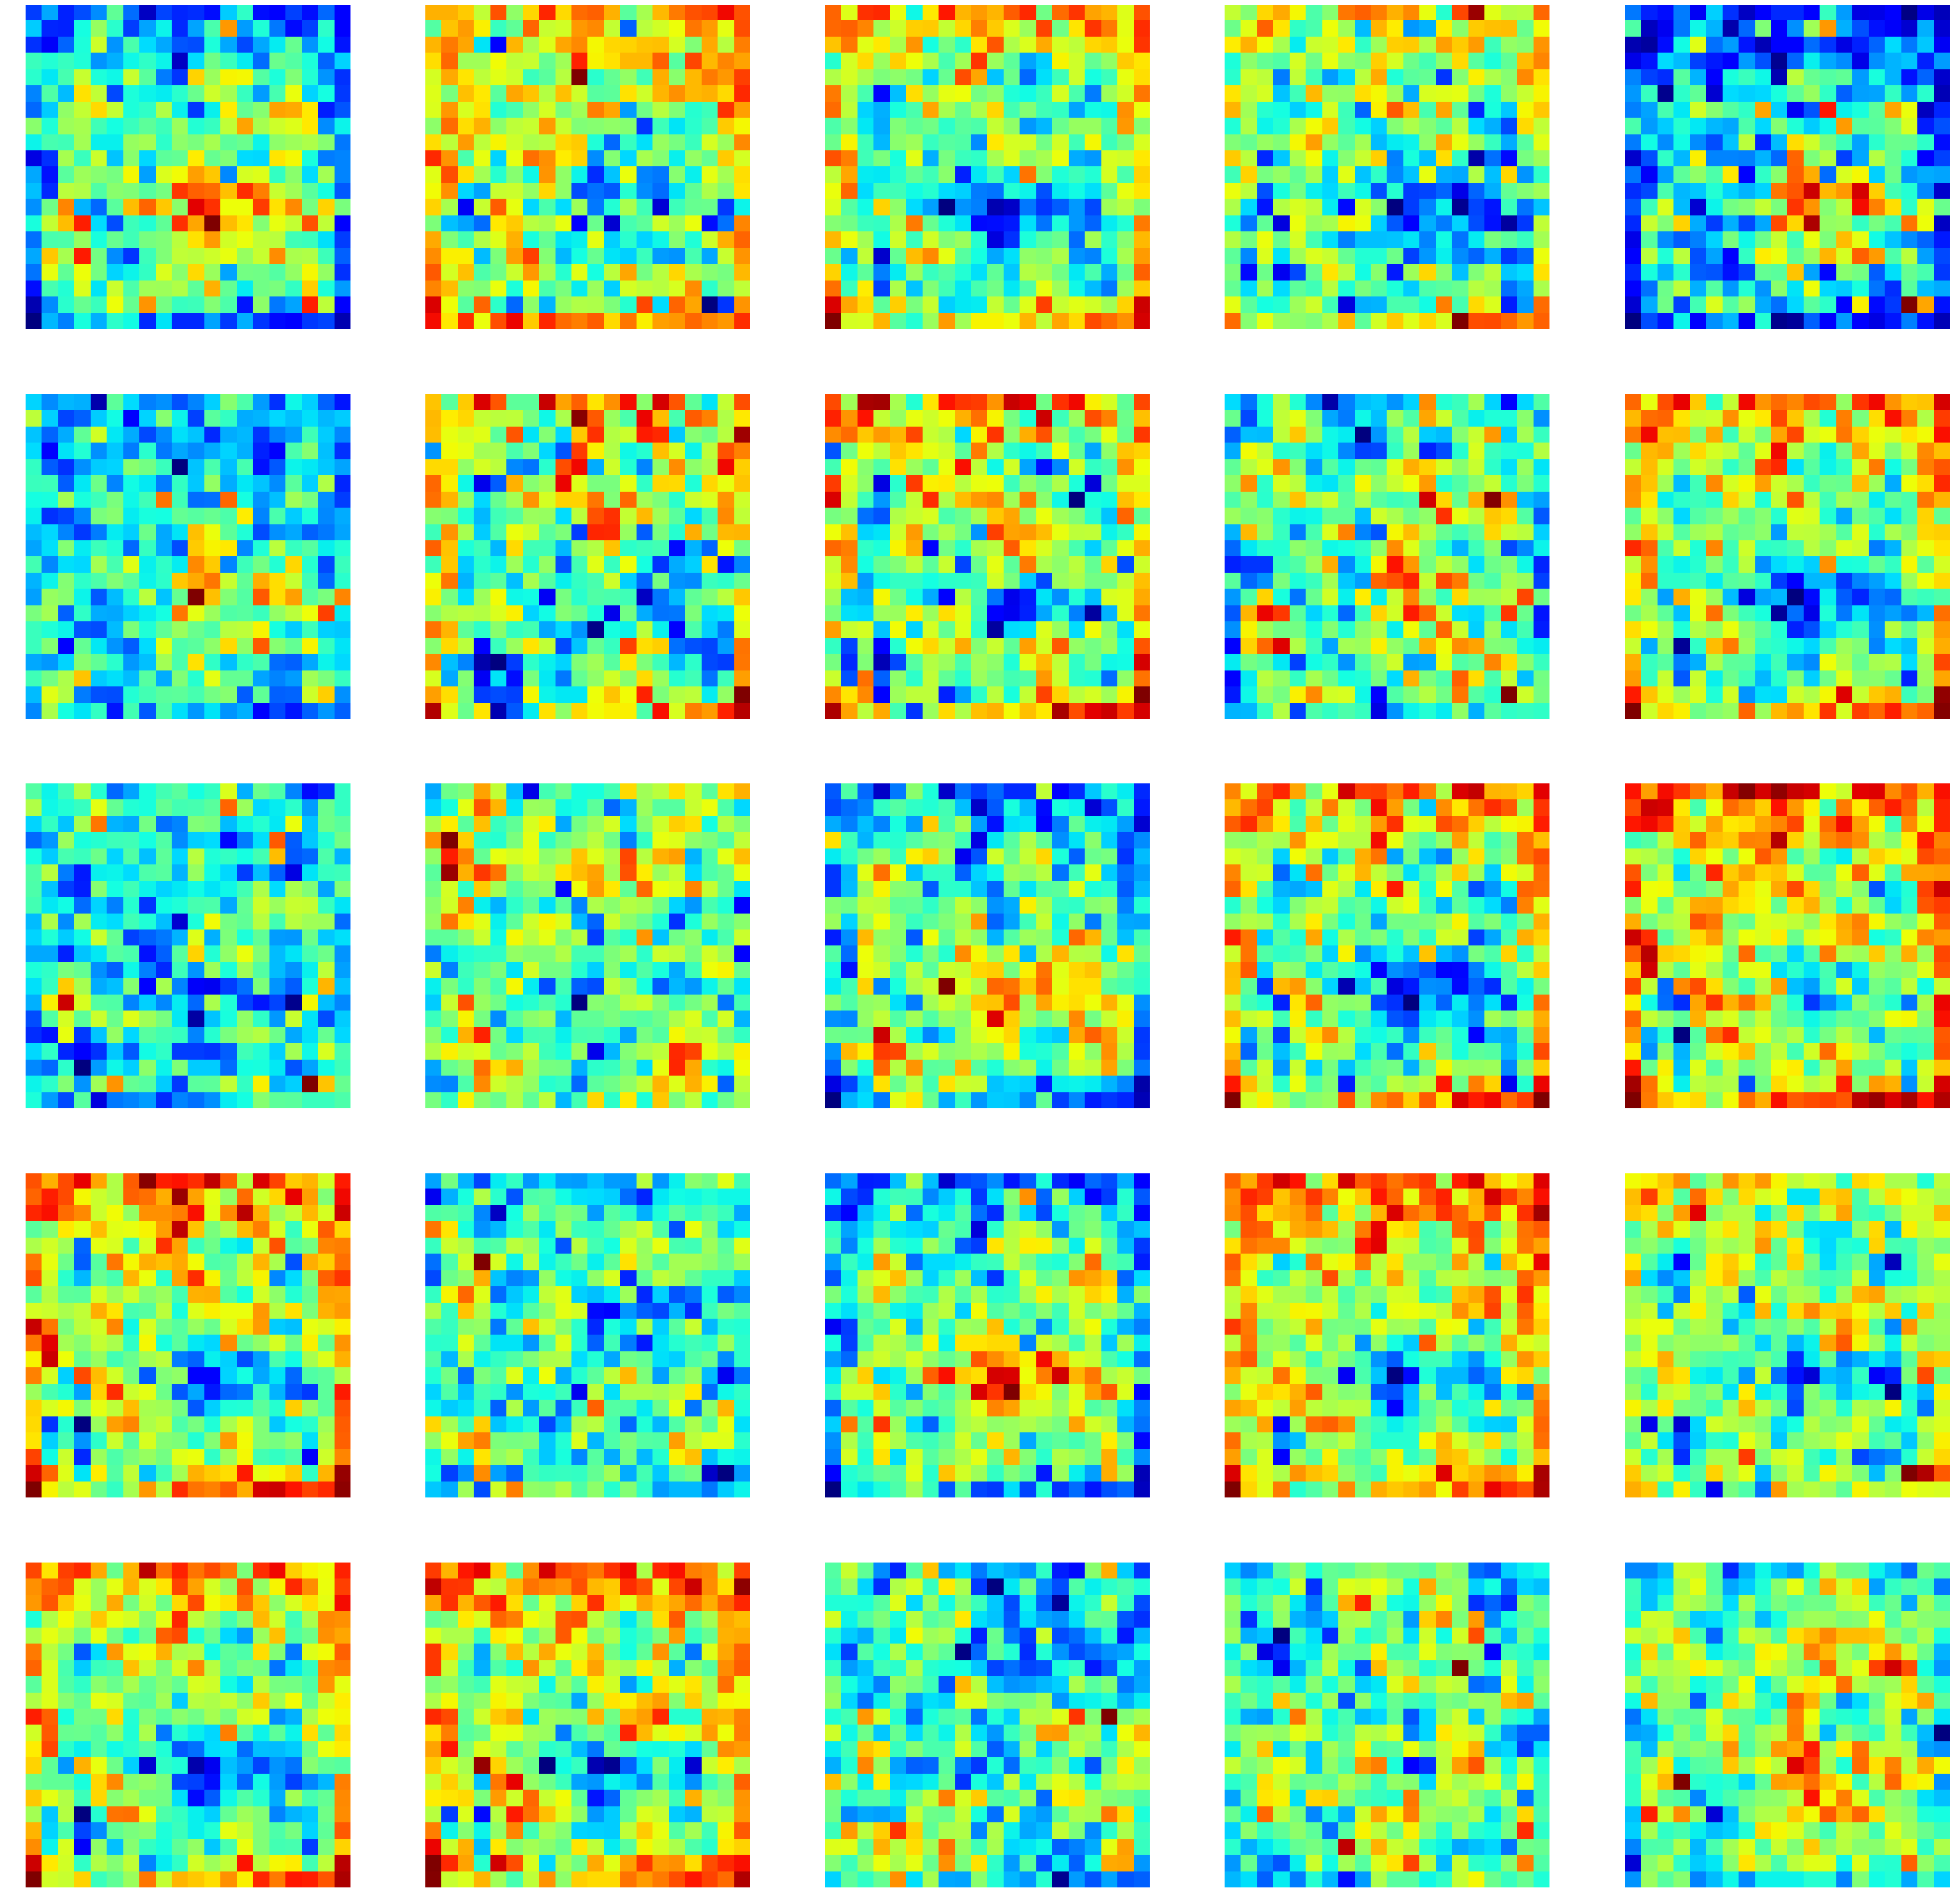

epoch 74, mean loss 7.9317873005867, std loss 0.052873417124784265


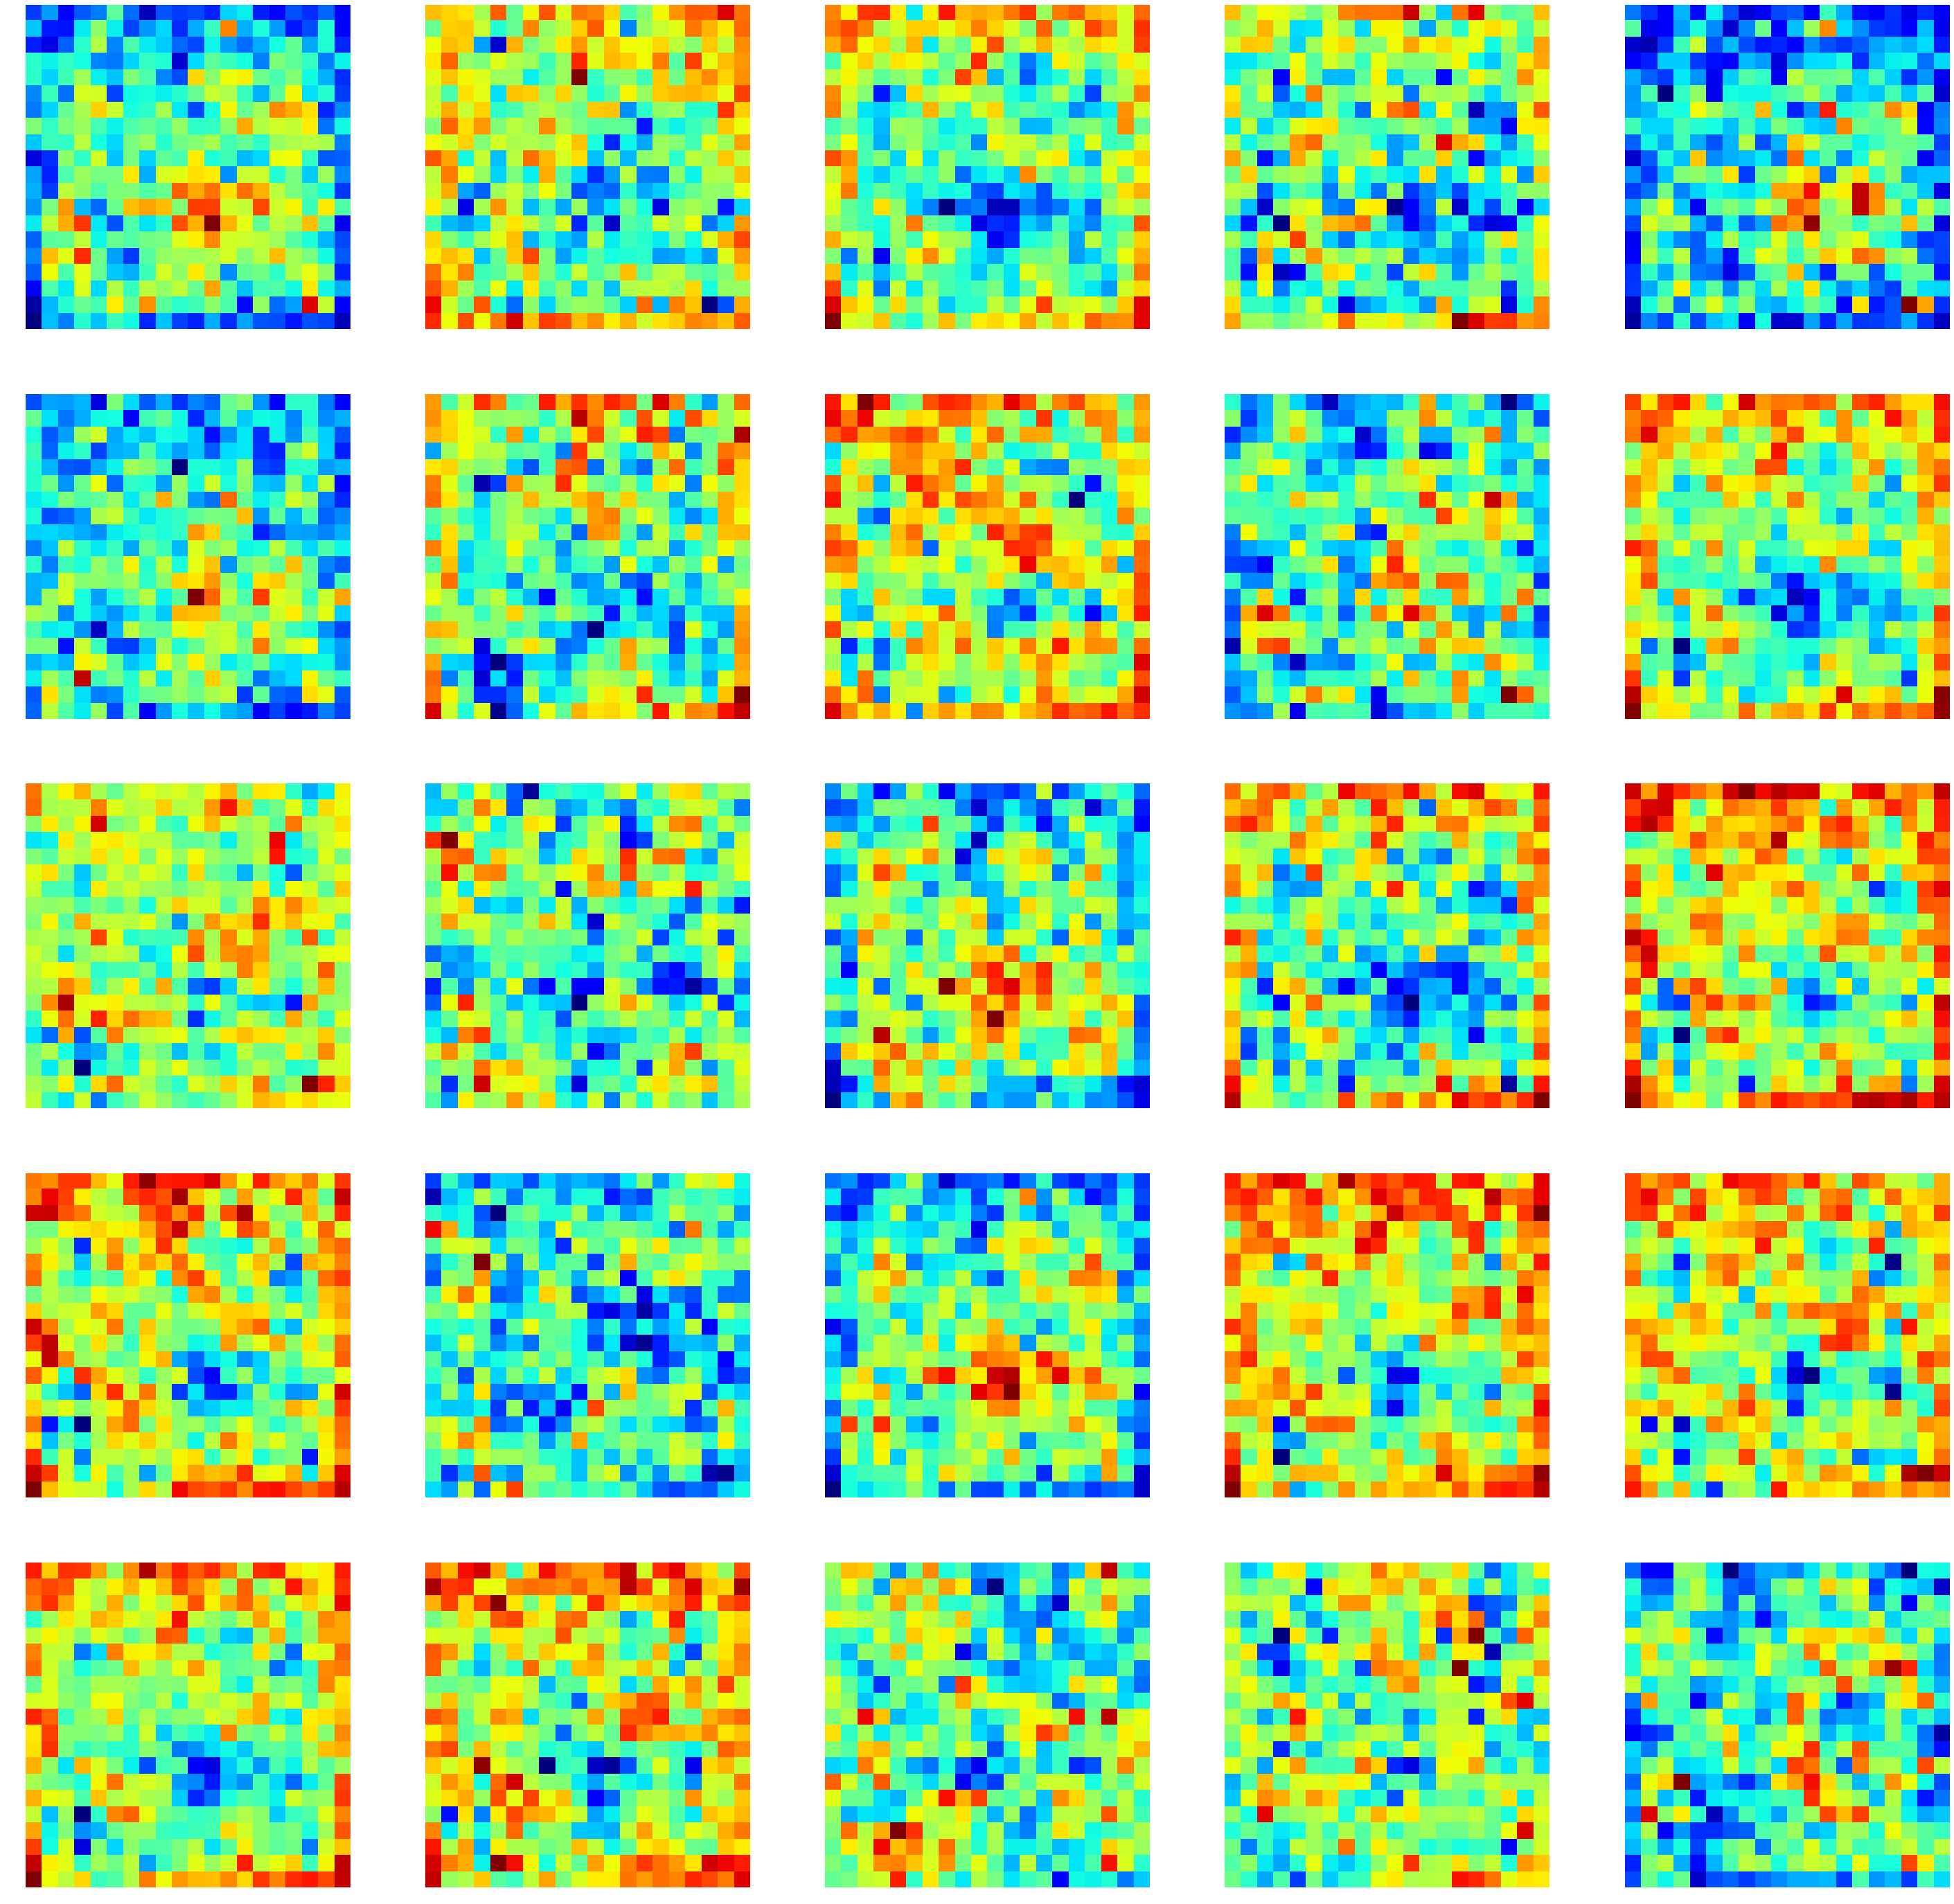

epoch 75, mean loss 7.931861322402954, std loss 0.05315007420460472


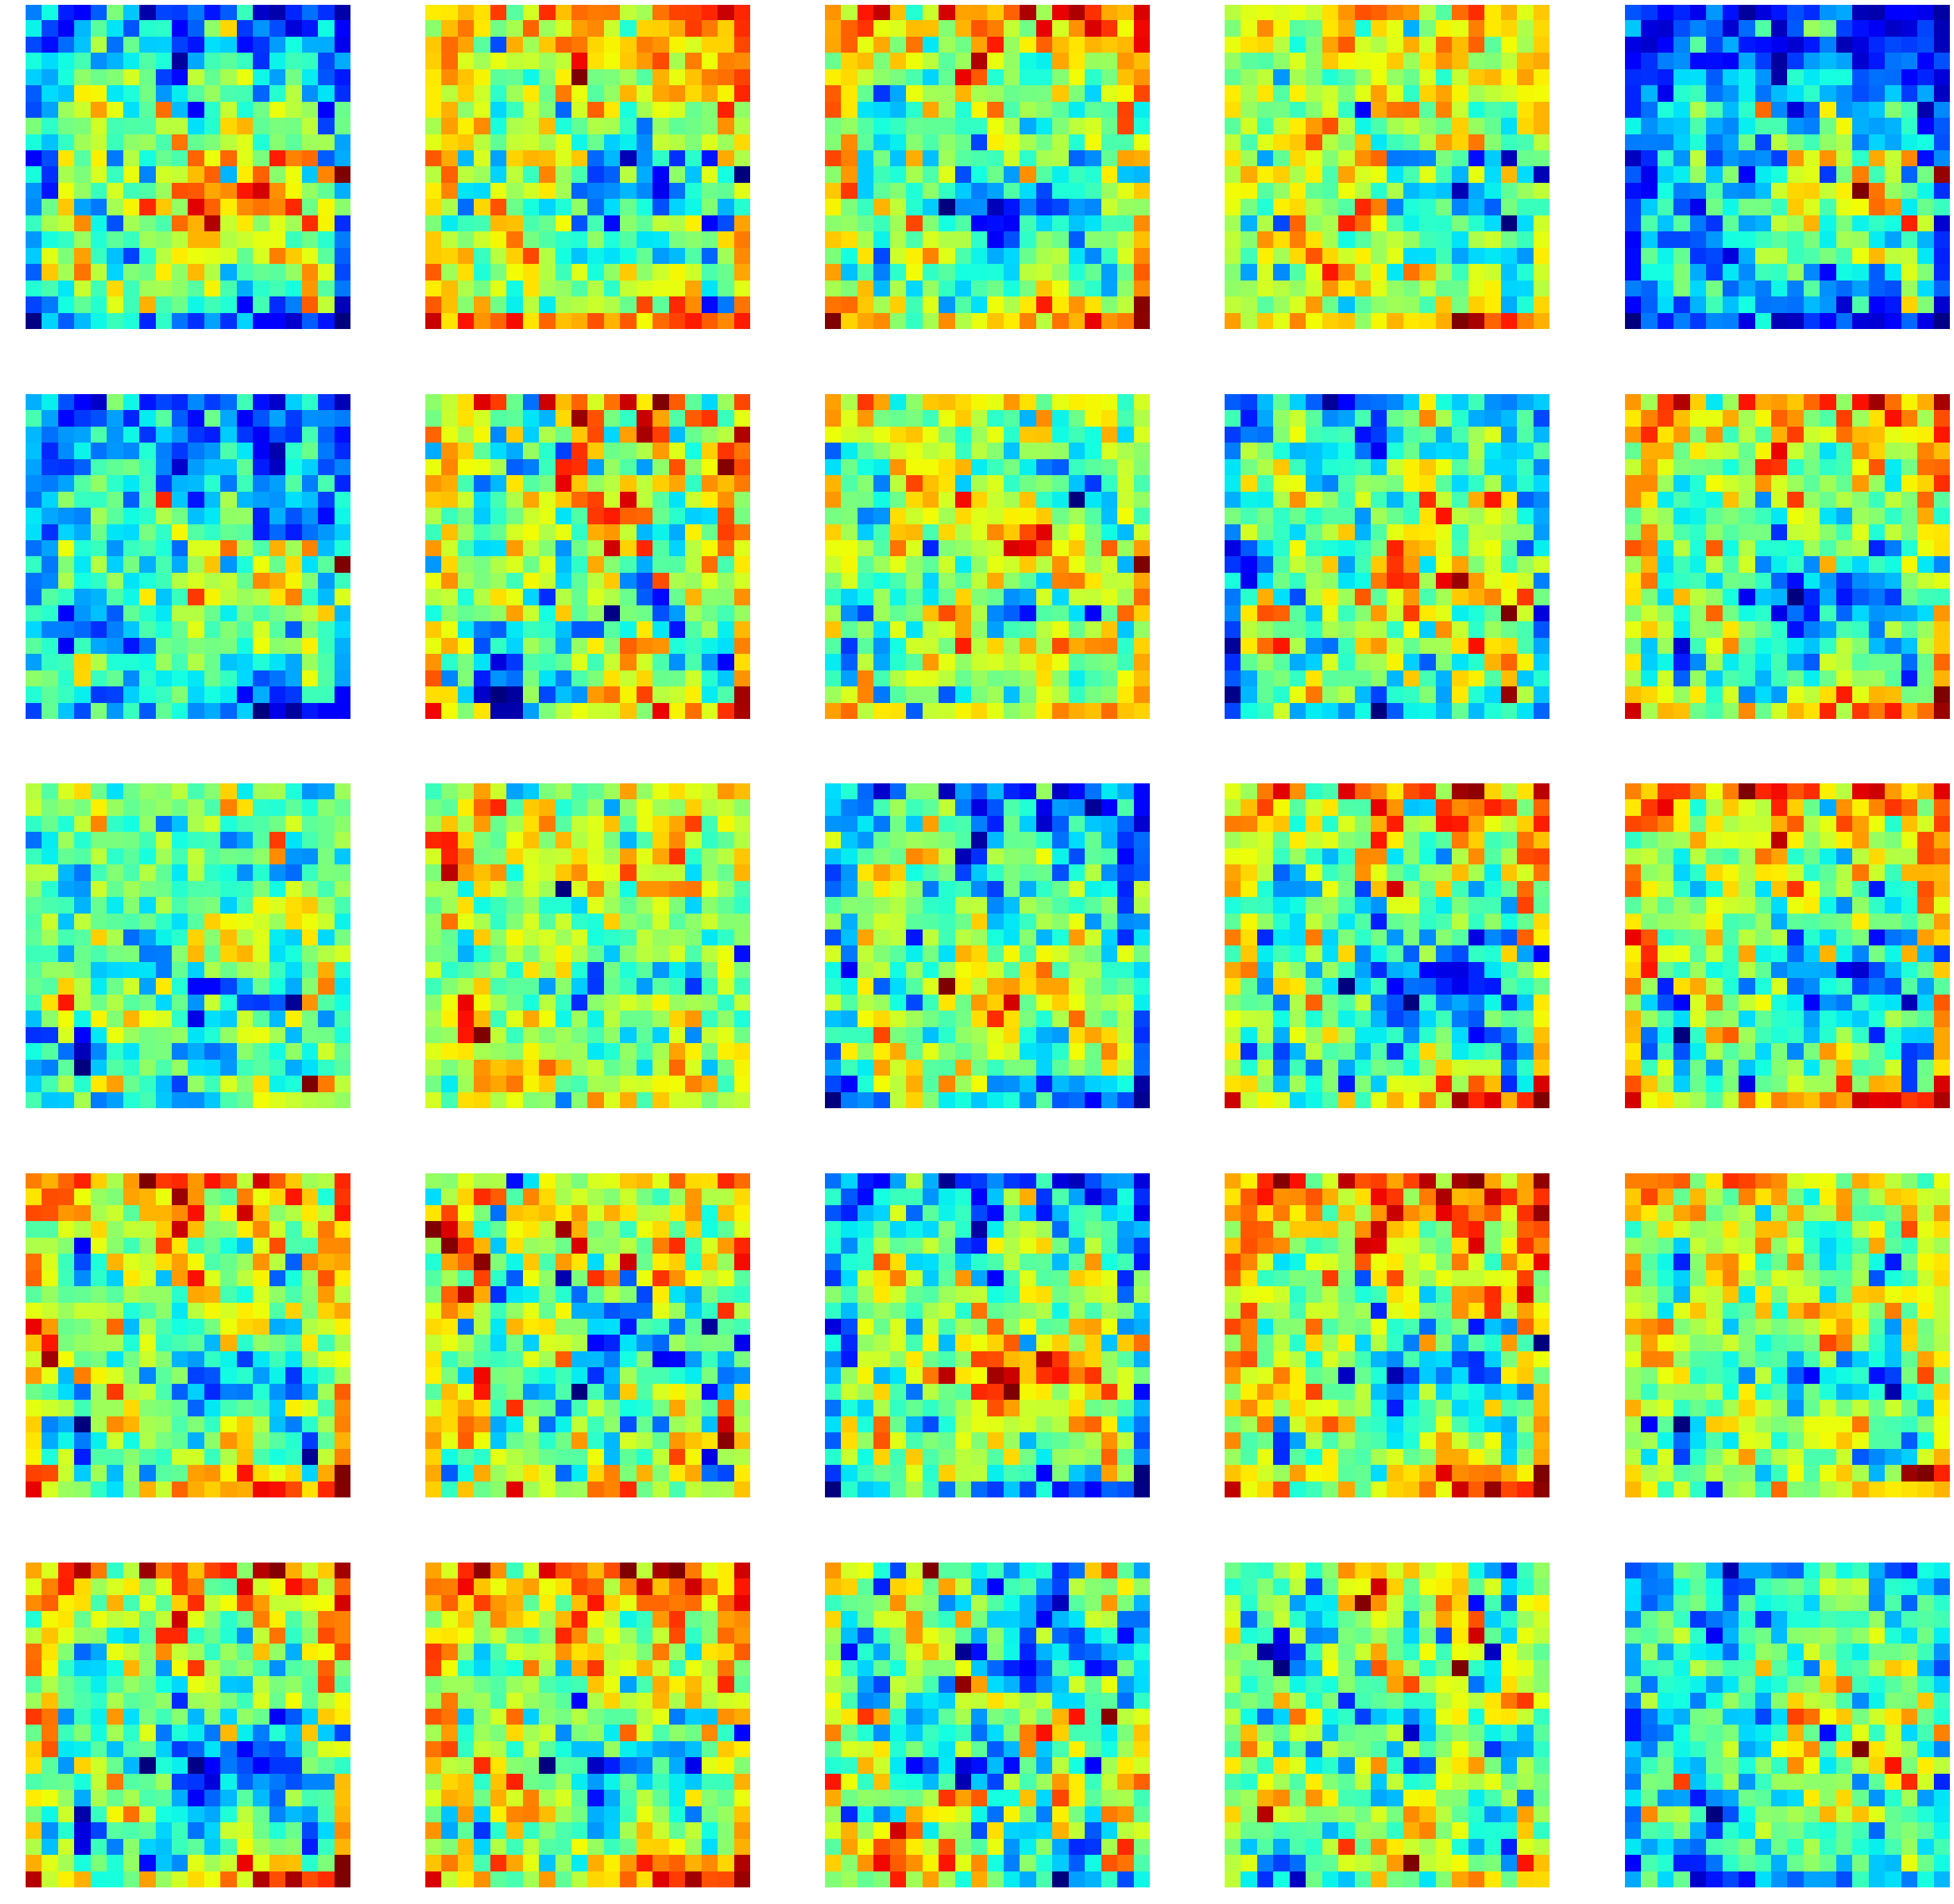

KeyboardInterrupt: 

In [30]:
losses = train_model(VNM, dm_dataloader, place_cells, hd_cells, lr=1e-5, num_epochs=1000)
plt.plot(np.arange(len(losses)), losses)
plt.show()